In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
from imagenet_dataset import get_dataset
from retina_env import RetinaEnv, calculate_retinal_filter
from rl_networks import create_actor_model, create_critic_model, policy
from rl_core import Buffer, update_target
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import types
config = types.SimpleNamespace()
config.batch_size = 32
config.margin = 20
config.image_h = 224
config.image_w = 224
config.image_hm = config.image_h+2*config.margin
config.image_wm = config.image_w+2*config.margin
config.foveate = None
config.do_grayscale = True
config.history_length = 16
config.t_ignore = 16
config.t_max =50
config.motion_mode = 'velocity'
config.use_dones = False

config.gym_mode = False
t_vec = np.linspace(0,150,16)

balanced_filter = calculate_retinal_filter(t_vec, R=1.0)
config.filter = balanced_filter.reshape([1,1,-1,1])
config.min_freq = 1
config.max_freq = 13
config.action_upper_bound = np.array([2.0, 2.0])

dataset_dir = '/home/bnapp/datasets/tensorflow_datasets/imagenet2012/5.0.0/'

def epsilon_scheduler(episode, floor_episode=200, epsilon_floor=0.1):
    if episode < floor_episode:
        return 1.-(1.-epsilon_floor)*episode/floor_episode
    else:
        return epsilon_floor

dataset = get_dataset(dataset_dir,
                                     'validation',
                                     config.batch_size,
                                     image_h = config.image_hm,
                                     image_w = config.image_wm,
                                     preprocessing='identity',
                                     rggb_mode=False,
                                     central_squeeze_and_pad_factor=-1)

env = RetinaEnv(config, image_generator=dataset)

if config.gym_mode:
    num_states = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    upper_bound = env.action_space.high[0]
    lower_bound = env.action_space.low[0]
else:
    num_states = env.observation_size
    num_actions = env.action_size
    upper_bound = env.action_upper_bound
    lower_bound = env.action_lower_bound


actor_model = create_actor_model(env.image_h, env.image_w,
                                 env.spectral_density_size, env.location_history_size,
                                 env.timestep_size, env.action_size)
agent = GaussianPolicyAgent(std_deviation=1.0,model=actor_model)

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [2]:
# Training loop
reward_records = []
epsilon_records = []
action_mean_records = []
action_var_records = []
episodes = 10000
for ep in range(episodes):
    prev_state = env.reset()
    episodic_reward = 0
    states, actions, rewards = [], [], []

#     epsilon = epsilon_scheduler(ep, floor_episode=1000)

    while True:

        action = agent.get_action(prev_state)
        state, reward, done, info = env.step(action)
        
        if env.warmup_done:
            states.append(state)
            actions.append(action)
            rewards.append(reward)
                
            episodic_reward += reward
           
            action_mean_records.append(deterministic_action.numpy().mean(axis=0))
            action_var_records.append(deterministic_action.numpy().var(axis=0))
        # End this episode when `done` is True
        if done:
            break

        prev_state = np.copy(state)
    
    agent.train(np.array(states), np.array(actions), np.array(rewards))

    print(f"Episode * {ep} * exploration epsilon {epsilon} * Episodic Reward is ==> {episodic_reward.numpy().mean()}")
    print("action means and variances at step -10:", action_mean_records[-10],action_var_records[-10])
    print("action means and variances at step -5:", action_mean_records[-5],action_var_records[-5])


Episode * 0 * exploration epsilon 1.0 * Episodic Reward is ==> -12.079345703125
action means and variances at step -10: [-0.00576902  0.0713701 ] [0.00024543 0.00094248]
action means and variances at step -5: [0.00021518 0.07955159] [0.00031681 0.00070359]
Episode * 1 * exploration epsilon 0.9991 * Episodic Reward is ==> -10.838767051696777
action means and variances at step -10: [0.04131601 0.09375681] [9.2991977e-05 1.0912885e-03]
action means and variances at step -5: [0.04738214 0.09259296] [9.286798e-05 9.657287e-04]
Episode * 2 * exploration epsilon 0.9982 * Episodic Reward is ==> -10.025697708129883
action means and variances at step -10: [0.08389589 0.09211553] [0.00026179 0.00096894]
action means and variances at step -5: [0.08947411 0.09019971] [0.00035205 0.000716  ]
Episode * 3 * exploration epsilon 0.9973 * Episodic Reward is ==> -11.472944259643555
action means and variances at step -10: [0.15029544 0.05524432] [0.00063019 0.00028161]
action means and variances at step -5

Episode * 16 * exploration epsilon 0.9856 * Episodic Reward is ==> -13.528877258300781
action means and variances at step -10: [ 0.81096095 -0.44460964] [0.00608215 0.00175751]
action means and variances at step -5: [ 0.8217455  -0.45066664] [0.00633507 0.00184673]
Episode * 17 * exploration epsilon 0.9847 * Episodic Reward is ==> -12.516618728637695
action means and variances at step -10: [ 0.8962207 -0.4859641] [0.00542534 0.0013289 ]
action means and variances at step -5: [ 0.90099853 -0.48809403] [0.00609852 0.00157434]
Episode * 18 * exploration epsilon 0.9838 * Episodic Reward is ==> -12.220173835754395
action means and variances at step -10: [ 0.9629412 -0.5233935] [0.00542428 0.00138953]
action means and variances at step -5: [ 0.97059244 -0.5282987 ] [0.00529337 0.00129927]
Episode * 19 * exploration epsilon 0.9829 * Episodic Reward is ==> -10.454155921936035
action means and variances at step -10: [ 0.984045  -0.5372416] [0.00603744 0.00120445]
action means and variances at s

Episode * 32 * exploration epsilon 0.9712 * Episodic Reward is ==> -11.219498634338379
action means and variances at step -10: [ 1.841956  -0.7723805] [0.00864763 0.00117701]
action means and variances at step -5: [ 1.8562514  -0.77812105] [0.00878525 0.00126583]
Episode * 33 * exploration epsilon 0.9703 * Episodic Reward is ==> -11.11665153503418
action means and variances at step -10: [ 1.8574286  -0.77578676] [0.00725155 0.00103286]
action means and variances at step -5: [ 1.8659325 -0.7781707] [0.00665291 0.00100833]
Episode * 34 * exploration epsilon 0.9694 * Episodic Reward is ==> -10.193429946899414
action means and variances at step -10: [ 1.9051894  -0.78979665] [0.00609876 0.00101012]
action means and variances at step -5: [ 1.9018238 -0.7881748] [0.00536737 0.00098045]
Episode * 35 * exploration epsilon 0.9685 * Episodic Reward is ==> -10.39503002166748
action means and variances at step -10: [ 1.9635553 -0.8230964] [0.00263892 0.00107765]
action means and variances at step 

Episode * 48 * exploration epsilon 0.9568 * Episodic Reward is ==> -12.197278022766113
action means and variances at step -10: [ 2.        -0.9175753] [0.         0.00065043]
action means and variances at step -5: [ 2.        -0.9079917] [0.         0.00049668]
Episode * 49 * exploration epsilon 0.9559 * Episodic Reward is ==> -10.994932174682617
action means and variances at step -10: [ 2.        -0.8347788] [0.         0.00035153]
action means and variances at step -5: [ 2.        -0.8162679] [0.         0.00034507]
Episode * 50 * exploration epsilon 0.955 * Episodic Reward is ==> -11.883097648620605
action means and variances at step -10: [ 2.       -0.723233] [0.         0.00018154]
action means and variances at step -5: [ 2.        -0.7254588] [0.         0.00017637]
Episode * 51 * exploration epsilon 0.9541 * Episodic Reward is ==> -11.784706115722656
action means and variances at step -10: [ 2.       -0.754604] [0.         0.00020845]
action means and variances at step -5: [ 2. 

Episode * 64 * exploration epsilon 0.9424 * Episodic Reward is ==> -11.413490295410156
action means and variances at step -10: [ 2.         -0.89568204] [0.         0.00043364]
action means and variances at step -5: [ 2.        -0.8969548] [0.         0.00041755]
Episode * 65 * exploration epsilon 0.9415 * Episodic Reward is ==> -11.240118026733398
action means and variances at step -10: [ 2.         -0.91210777] [0.         0.00049492]
action means and variances at step -5: [ 2.        -0.9128123] [0.         0.00040776]
Episode * 66 * exploration epsilon 0.9406 * Episodic Reward is ==> -11.041098594665527
action means and variances at step -10: [ 2.         -0.91546154] [0.         0.00037098]
action means and variances at step -5: [ 2.       -0.918277] [0.         0.00026826]
Episode * 67 * exploration epsilon 0.9397 * Episodic Reward is ==> -10.57343578338623
action means and variances at step -10: [ 2.       -0.929417] [0.         0.00030693]
action means and variances at step -5:

Episode * 80 * exploration epsilon 0.928 * Episodic Reward is ==> -9.952217102050781
action means and variances at step -10: [ 2.        -1.0499953] [0.         0.00018236]
action means and variances at step -5: [ 2.        -1.0543834] [0.         0.00014531]
Episode * 81 * exploration epsilon 0.9271 * Episodic Reward is ==> -13.72381591796875
action means and variances at step -10: [ 2.        -1.0615518] [0.         0.00016566]
action means and variances at step -5: [ 2.        -1.0595344] [0.         0.00015361]
Episode * 82 * exploration epsilon 0.9262 * Episodic Reward is ==> -12.143138885498047
action means and variances at step -10: [ 2.        -1.0577521] [0.        0.0001013]
action means and variances at step -5: [ 2.        -1.0533352] [0.        0.0001603]
Episode * 83 * exploration epsilon 0.9253 * Episodic Reward is ==> -10.148164749145508
action means and variances at step -10: [ 2.        -1.0805644] [0.         0.00012655]
action means and variances at step -5: [ 2.   

Episode * 96 * exploration epsilon 0.9136 * Episodic Reward is ==> -13.134723663330078
action means and variances at step -10: [ 2.        -1.1908367] [0.000000e+00 9.393172e-05]
action means and variances at step -5: [ 2.        -1.1928223] [0.000000e+00 9.295884e-05]
Episode * 97 * exploration epsilon 0.9127 * Episodic Reward is ==> -11.427522659301758
action means and variances at step -10: [ 2.        -1.2184564] [0.000000e+00 9.579704e-05]
action means and variances at step -5: [ 2.        -1.2197912] [0.         0.00010365]
Episode * 98 * exploration epsilon 0.9117999999999999 * Episodic Reward is ==> -11.871438026428223
action means and variances at step -10: [ 2.       -1.225624] [0.000000e+00 7.189085e-05]
action means and variances at step -5: [ 2.        -1.2239474] [0.0000000e+00 5.5022345e-05]
Episode * 99 * exploration epsilon 0.9109 * Episodic Reward is ==> -11.819612503051758
action means and variances at step -10: [ 2.        -1.2309306] [0.000000e+00 9.827663e-05]
act

Episode * 112 * exploration epsilon 0.8992 * Episodic Reward is ==> -13.03409194946289
action means and variances at step -10: [ 2.        -1.2758644] [0.0000000e+00 4.1332813e-05]
action means and variances at step -5: [ 2.        -1.2740284] [0.0000000e+00 3.1807827e-05]
Episode * 113 * exploration epsilon 0.8983 * Episodic Reward is ==> -10.259571075439453
action means and variances at step -10: [ 2.        -1.2940623] [0.0000000e+00 4.6027188e-05]
action means and variances at step -5: [ 2.        -1.2868575] [0.0000000e+00 3.9602633e-05]
Episode * 114 * exploration epsilon 0.8974 * Episodic Reward is ==> -10.187688827514648
action means and variances at step -10: [ 2.        -1.2755368] [0.0000000e+00 4.2821583e-05]
action means and variances at step -5: [ 2.        -1.2798089] [0.0000000e+00 4.0259452e-05]
Episode * 115 * exploration epsilon 0.8965 * Episodic Reward is ==> -10.53210735321045
action means and variances at step -10: [ 2.        -1.2726699] [0.0000000e+00 3.1080122e

Episode * 128 * exploration epsilon 0.8848 * Episodic Reward is ==> -9.325843811035156
action means and variances at step -10: [ 2.       -1.286337] [0.0000000e+00 5.0125258e-05]
action means and variances at step -5: [ 2.        -1.2836676] [0.000000e+00 4.364801e-05]
Episode * 129 * exploration epsilon 0.8839 * Episodic Reward is ==> -11.13644790649414
action means and variances at step -10: [ 2.        -1.2844071] [0.0000000e+00 2.1121896e-05]
action means and variances at step -5: [ 2.        -1.2779588] [0.000000e+00 4.153954e-05]
Episode * 130 * exploration epsilon 0.883 * Episodic Reward is ==> -12.664892196655273
action means and variances at step -10: [ 2.        -1.2812842] [0.0000000e+00 4.3457483e-05]
action means and variances at step -5: [ 2.        -1.2830255] [0.00000e+00 3.81423e-05]
Episode * 131 * exploration epsilon 0.8821 * Episodic Reward is ==> -11.280933380126953
action means and variances at step -10: [ 2.       -1.301956] [0.0000000e+00 2.6399637e-05]
action m

Episode * 144 * exploration epsilon 0.8704000000000001 * Episodic Reward is ==> -11.493636131286621
action means and variances at step -10: [ 2.        -1.2538267] [0.000000e+00 4.675267e-05]
action means and variances at step -5: [ 2.        -1.2555491] [0.0000000e+00 2.3631997e-05]
Episode * 145 * exploration epsilon 0.8694999999999999 * Episodic Reward is ==> -11.675209045410156
action means and variances at step -10: [ 2.       -1.256143] [0.0000000e+00 2.3008193e-05]
action means and variances at step -5: [ 2.        -1.2599828] [0.0000000e+00 1.6227676e-05]
Episode * 146 * exploration epsilon 0.8686 * Episodic Reward is ==> -12.946548461914062
action means and variances at step -10: [ 2.        -1.2561585] [0.0000000e+00 3.0845204e-05]
action means and variances at step -5: [ 2.        -1.2605509] [0.0000000e+00 1.9799661e-05]
Episode * 147 * exploration epsilon 0.8677 * Episodic Reward is ==> -11.468070030212402
action means and variances at step -10: [ 2.        -1.2564456] [0.

Episode * 160 * exploration epsilon 0.856 * Episodic Reward is ==> -9.821943283081055
action means and variances at step -10: [ 2.        -1.2510269] [0.000000e+00 8.668762e-06]
action means and variances at step -5: [ 2.        -1.2495698] [0.0000000e+00 1.2009648e-05]
Episode * 161 * exploration epsilon 0.8551 * Episodic Reward is ==> -10.332221984863281
action means and variances at step -10: [ 2.        -1.2456249] [0.000000e+00 1.464328e-05]
action means and variances at step -5: [ 2.        -1.2448406] [0.0000000e+00 6.8844233e-06]
Episode * 162 * exploration epsilon 0.8542 * Episodic Reward is ==> -12.825162887573242
action means and variances at step -10: [ 2.        -1.2465994] [0.0000000e+00 1.5390055e-05]
action means and variances at step -5: [ 2.        -1.2451755] [0.0000000e+00 1.2033261e-05]
Episode * 163 * exploration epsilon 0.8533 * Episodic Reward is ==> -10.015953063964844
action means and variances at step -10: [ 2.        -1.2477953] [0.0000000e+00 1.3840859e-05]

Episode * 176 * exploration epsilon 0.8416 * Episodic Reward is ==> -10.527618408203125
action means and variances at step -10: [ 2.       -1.252558] [0.0000000e+00 1.0787572e-05]
action means and variances at step -5: [ 2.        -1.2533851] [0.0000000e+00 7.0420497e-06]
Episode * 177 * exploration epsilon 0.8407 * Episodic Reward is ==> -11.253219604492188
action means and variances at step -10: [ 2.       -1.244699] [0.0000000e+00 6.5771983e-06]
action means and variances at step -5: [ 2.        -1.2511532] [0.0000000e+00 1.0350167e-05]
Episode * 178 * exploration epsilon 0.8398 * Episodic Reward is ==> -10.713231086730957
action means and variances at step -10: [ 2.        -1.2482057] [0.000000e+00 1.096253e-05]
action means and variances at step -5: [ 2.        -1.2490519] [0.000000e+00 5.723954e-06]
Episode * 179 * exploration epsilon 0.8389 * Episodic Reward is ==> -9.504352569580078
action means and variances at step -10: [ 2.        -1.2498596] [0.0000000e+00 1.1269203e-05]
ac

Episode * 192 * exploration epsilon 0.8271999999999999 * Episodic Reward is ==> -11.511298179626465
action means and variances at step -10: [ 2.        -1.2484206] [0.000000e+00 1.463638e-05]
action means and variances at step -5: [ 2.        -1.2471845] [0.0000000e+00 1.1669105e-05]
Episode * 193 * exploration epsilon 0.8263 * Episodic Reward is ==> -12.410263061523438
action means and variances at step -10: [ 2.        -1.2565994] [0.0000000e+00 4.1708236e-06]
action means and variances at step -5: [ 2.      -1.25929] [0.0000000e+00 3.9252063e-06]
Episode * 194 * exploration epsilon 0.8254 * Episodic Reward is ==> -11.457462310791016
action means and variances at step -10: [ 2.        -1.2528256] [0.000000e+00 4.940172e-06]
action means and variances at step -5: [ 2.        -1.2523317] [0.0000000e+00 3.2910411e-06]
Episode * 195 * exploration epsilon 0.8245 * Episodic Reward is ==> -12.506661415100098
action means and variances at step -10: [ 2.        -1.2609696] [0.000000e+00 7.378

Episode * 208 * exploration epsilon 0.8128 * Episodic Reward is ==> -12.121203422546387
action means and variances at step -10: [ 2.       -1.251156] [0.0000000e+00 6.9460148e-06]
action means and variances at step -5: [ 2.        -1.2458805] [0.000000e+00 5.841951e-06]
Episode * 209 * exploration epsilon 0.8119000000000001 * Episodic Reward is ==> -12.508678436279297
action means and variances at step -10: [ 2.        -1.2541412] [0.0000000e+00 2.9636717e-06]
action means and variances at step -5: [ 2.        -1.2551229] [0.000000e+00 5.961159e-06]
Episode * 210 * exploration epsilon 0.8109999999999999 * Episodic Reward is ==> -10.976198196411133
action means and variances at step -10: [ 2.        -1.2578201] [0.000000e+00 7.035847e-06]
action means and variances at step -5: [ 2.        -1.2585765] [0.0000000e+00 6.1965648e-06]
Episode * 211 * exploration epsilon 0.8101 * Episodic Reward is ==> -10.403047561645508
action means and variances at step -10: [ 2.        -1.2595148] [0.0000

Episode * 224 * exploration epsilon 0.7984 * Episodic Reward is ==> -11.741158485412598
action means and variances at step -10: [ 2.        -1.2780372] [0.0000000e+00 2.7216727e-06]
action means and variances at step -5: [ 2.      -1.28025] [0.00000e+00 2.25054e-06]
Episode * 225 * exploration epsilon 0.7975 * Episodic Reward is ==> -9.87204647064209
action means and variances at step -10: [ 2.        -1.2758037] [0.0000000e+00 3.0704298e-06]
action means and variances at step -5: [ 2.        -1.2770293] [0.0000000e+00 4.0732007e-06]
Episode * 226 * exploration epsilon 0.7966 * Episodic Reward is ==> -10.851557731628418
action means and variances at step -10: [ 2.        -1.2760416] [0.000000e+00 4.029656e-06]
action means and variances at step -5: [ 2.        -1.2759838] [0.000000e+00 3.166287e-06]
Episode * 227 * exploration epsilon 0.7957 * Episodic Reward is ==> -9.656655311584473
action means and variances at step -10: [ 2.        -1.2759101] [0.0000000e+00 4.2054994e-06]
action m

Episode * 240 * exploration epsilon 0.784 * Episodic Reward is ==> -11.822383880615234
action means and variances at step -10: [ 2.        -1.2587965] [0.000000e+00 2.809174e-06]
action means and variances at step -5: [ 2.        -1.2577083] [0.0000000e+00 3.5757364e-06]
Episode * 241 * exploration epsilon 0.7831 * Episodic Reward is ==> -11.289447784423828
action means and variances at step -10: [ 2.        -1.2640307] [0.0000000e+00 5.5563246e-06]
action means and variances at step -5: [ 2.        -1.2639399] [0.0000000e+00 2.3816629e-06]
Episode * 242 * exploration epsilon 0.7822 * Episodic Reward is ==> -11.89980697631836
action means and variances at step -10: [ 2.        -1.2699867] [0.0000000e+00 2.2629197e-06]
action means and variances at step -5: [ 2.       -1.275198] [0.0000000e+00 3.5814114e-06]
Episode * 243 * exploration epsilon 0.7813 * Episodic Reward is ==> -12.370172500610352
action means and variances at step -10: [ 2.        -1.2730298] [0.0000000e+00 3.4036493e-06]

Episode * 256 * exploration epsilon 0.7696000000000001 * Episodic Reward is ==> -12.377996444702148
action means and variances at step -10: [ 2.        -1.2542261] [0.0000000e+00 4.8341376e-06]
action means and variances at step -5: [ 2.        -1.2525704] [0.0000000e+00 3.5451098e-06]
Episode * 257 * exploration epsilon 0.7686999999999999 * Episodic Reward is ==> -10.347286224365234
action means and variances at step -10: [ 2.        -1.2478379] [0.0000000e+00 2.0640089e-06]
action means and variances at step -5: [ 2.        -1.2490964] [0.0000000e+00 3.3880303e-06]
Episode * 258 * exploration epsilon 0.7678 * Episodic Reward is ==> -11.39654541015625
action means and variances at step -10: [ 2.        -1.2550957] [0.0000000e+00 2.7481037e-06]
action means and variances at step -5: [ 2.        -1.2527274] [0.0000000e+00 1.3070868e-06]
Episode * 259 * exploration epsilon 0.7669 * Episodic Reward is ==> -12.704679489135742
action means and variances at step -10: [ 2.       -1.244814] [0

Episode * 272 * exploration epsilon 0.7552 * Episodic Reward is ==> -11.009634017944336
action means and variances at step -10: [ 2.       -1.248861] [0.000000e+00 2.300651e-06]
action means and variances at step -5: [ 2.        -1.2485886] [0.0000000e+00 1.1636442e-06]
Episode * 273 * exploration epsilon 0.7543 * Episodic Reward is ==> -14.008125305175781
action means and variances at step -10: [ 2.        -1.2433103] [0.0000000e+00 1.2879882e-06]
action means and variances at step -5: [ 2.        -1.2448511] [0.000000e+00 1.064429e-06]
Episode * 274 * exploration epsilon 0.7534000000000001 * Episodic Reward is ==> -12.15866470336914
action means and variances at step -10: [ 2.        -1.2448854] [0.000000e+00 1.961369e-06]
action means and variances at step -5: [ 2.        -1.2452183] [0.0000000e+00 5.5657274e-06]
Episode * 275 * exploration epsilon 0.7525 * Episodic Reward is ==> -12.20925521850586
action means and variances at step -10: [ 2.        -1.2499388] [0.0000000e+00 4.0599

Episode * 288 * exploration epsilon 0.7408 * Episodic Reward is ==> -9.939068794250488
action means and variances at step -10: [ 2.        -1.2575392] [0.0000000e+00 1.0735281e-06]
action means and variances at step -5: [ 2.       -1.260928] [0.0000000e+00 1.0445822e-06]
Episode * 289 * exploration epsilon 0.7399 * Episodic Reward is ==> -10.043392181396484
action means and variances at step -10: [ 2.       -1.261602] [0.0000000e+00 4.0024483e-07]
action means and variances at step -5: [ 2.        -1.2629542] [0.0000000e+00 1.0540232e-06]
Episode * 290 * exploration epsilon 0.739 * Episodic Reward is ==> -12.642380714416504
action means and variances at step -10: [ 2.        -1.2630827] [0.0000000e+00 2.2214579e-06]
action means and variances at step -5: [ 2.        -1.2621281] [0.0000000e+00 1.1866687e-06]
Episode * 291 * exploration epsilon 0.7381 * Episodic Reward is ==> -12.94509220123291
action means and variances at step -10: [ 2.        -1.2642968] [0.0000000e+00 1.5609993e-06]


Episode * 304 * exploration epsilon 0.7263999999999999 * Episodic Reward is ==> -11.59765625
action means and variances at step -10: [ 2.        -1.2824769] [0.000000e+00 5.433877e-06]
action means and variances at step -5: [ 2.       -1.284055] [0.000000e+00 6.558995e-06]
Episode * 305 * exploration epsilon 0.7255 * Episodic Reward is ==> -11.974742889404297
action means and variances at step -10: [ 2.        -1.2853835] [0.0000000e+00 2.3177377e-06]
action means and variances at step -5: [ 2.        -1.2840779] [0.000000e+00 1.050117e-06]
Episode * 306 * exploration epsilon 0.7245999999999999 * Episodic Reward is ==> -12.193851470947266
action means and variances at step -10: [ 2.        -1.2840333] [0.0000000e+00 3.0964063e-06]
action means and variances at step -5: [ 2.        -1.2832848] [0.0000000e+00 1.8090223e-06]
Episode * 307 * exploration epsilon 0.7237 * Episodic Reward is ==> -11.662224769592285
action means and variances at step -10: [ 2.        -1.2820002] [0.000000e+00 

Episode * 320 * exploration epsilon 0.712 * Episodic Reward is ==> -10.953022003173828
action means and variances at step -10: [ 2.        -1.2927518] [0.0000000e+00 8.5060697e-07]
action means and variances at step -5: [ 2.        -1.2918605] [0.000000e+00 8.156744e-07]
Episode * 321 * exploration epsilon 0.7111 * Episodic Reward is ==> -11.72988510131836
action means and variances at step -10: [ 2.       -1.283096] [0.0000000e+00 7.1578376e-07]
action means and variances at step -5: [ 2.        -1.2826849] [0.0000000e+00 6.3170955e-07]
Episode * 322 * exploration epsilon 0.7101999999999999 * Episodic Reward is ==> -12.653852462768555
action means and variances at step -10: [ 2.        -1.2843934] [0.000000e+00 2.644525e-06]
action means and variances at step -5: [ 2.        -1.2850981] [0.0000000e+00 1.7697174e-06]
Episode * 323 * exploration epsilon 0.7093 * Episodic Reward is ==> -12.544715881347656
action means and variances at step -10: [ 2.        -1.2861192] [0.000000e+00 1.274

Episode * 336 * exploration epsilon 0.6976 * Episodic Reward is ==> -12.52786636352539
action means and variances at step -10: [ 2.        -1.2838749] [0.0000000e+00 1.9800088e-06]
action means and variances at step -5: [ 2.        -1.2815905] [0.0000000e+00 1.4192856e-06]
Episode * 337 * exploration epsilon 0.6967 * Episodic Reward is ==> -11.062786102294922
action means and variances at step -10: [ 2.        -1.2845677] [0.000000e+00 1.178554e-06]
action means and variances at step -5: [ 2.        -1.2859547] [0.0000000e+00 1.1124154e-06]
Episode * 338 * exploration epsilon 0.6958 * Episodic Reward is ==> -12.365376472473145
action means and variances at step -10: [ 2.        -1.2817669] [0.0000000e+00 1.8223176e-06]
action means and variances at step -5: [ 2.        -1.2840551] [0.0000000e+00 2.0319587e-06]
Episode * 339 * exploration epsilon 0.6949 * Episodic Reward is ==> -13.817023277282715
action means and variances at step -10: [ 2.       -1.282936] [0.00000e+00 9.25007e-07]
ac

Episode * 352 * exploration epsilon 0.6832 * Episodic Reward is ==> -11.795360565185547
action means and variances at step -10: [ 2.        -1.3130013] [0.0000000e+00 1.2303494e-06]
action means and variances at step -5: [ 2.        -1.3108265] [0.0000000e+00 1.7096269e-06]
Episode * 353 * exploration epsilon 0.6823 * Episodic Reward is ==> -12.495107650756836
action means and variances at step -10: [ 2.        -1.3156662] [0.0000000e+00 1.0779107e-06]
action means and variances at step -5: [ 2.        -1.3161997] [0.0000000e+00 1.0621628e-06]
Episode * 354 * exploration epsilon 0.6814 * Episodic Reward is ==> -11.83860969543457
action means and variances at step -10: [ 2.       -1.318171] [0.0000000e+00 5.5943297e-06]
action means and variances at step -5: [ 2.        -1.3180058] [0.000000e+00 5.989007e-06]
Episode * 355 * exploration epsilon 0.6805 * Episodic Reward is ==> -12.138128280639648
action means and variances at step -10: [ 2.      -1.31704] [0.0000000e+00 1.2742961e-06]
ac

Episode * 368 * exploration epsilon 0.6688000000000001 * Episodic Reward is ==> -11.868741989135742
action means and variances at step -10: [ 2.       -1.333286] [0.000000e+00 9.475689e-07]
action means and variances at step -5: [ 2.       -1.331519] [0.00000e+00 8.07088e-07]
Episode * 369 * exploration epsilon 0.6678999999999999 * Episodic Reward is ==> -11.721240997314453
action means and variances at step -10: [ 2.        -1.3323541] [0.0000000e+00 1.2180955e-06]
action means and variances at step -5: [ 2.        -1.3319046] [0.0000000e+00 1.3759314e-06]
Episode * 370 * exploration epsilon 0.667 * Episodic Reward is ==> -11.4986572265625
action means and variances at step -10: [ 2.        -1.3304048] [0.000000e+00 7.331675e-07]
action means and variances at step -5: [ 2.        -1.3281131] [0.000000e+00 8.958202e-07]
Episode * 371 * exploration epsilon 0.6660999999999999 * Episodic Reward is ==> -13.37582015991211
action means and variances at step -10: [ 2.        -1.3314621] [0.00

Episode * 384 * exploration epsilon 0.6544 * Episodic Reward is ==> -12.004388809204102
action means and variances at step -10: [ 2.        -1.3372897] [0.0000000e+00 9.3678096e-07]
action means and variances at step -5: [ 2.        -1.3353024] [0.000000e+00 7.812867e-07]
Episode * 385 * exploration epsilon 0.6535 * Episodic Reward is ==> -12.209625244140625
action means and variances at step -10: [ 2.        -1.3398911] [0.0000000e+00 1.1520539e-06]
action means and variances at step -5: [ 2.        -1.3445486] [0.000000e+00 9.482906e-07]
Episode * 386 * exploration epsilon 0.6526 * Episodic Reward is ==> -11.483153343200684
action means and variances at step -10: [ 2.        -1.3413041] [0.000000e+00 7.177092e-07]
action means and variances at step -5: [ 2.       -1.341803] [0.0000000e+00 6.0983746e-07]
Episode * 387 * exploration epsilon 0.6517 * Episodic Reward is ==> -11.544862747192383
action means and variances at step -10: [ 2.        -1.3367771] [0.0000000e+00 8.7102836e-07]
a

Episode * 400 * exploration epsilon 0.64 * Episodic Reward is ==> -11.984051704406738
action means and variances at step -10: [ 2.        -1.3508383] [0.000000e+00 8.774887e-07]
action means and variances at step -5: [ 2.        -1.3498263] [0.000000e+00 5.453578e-07]
Episode * 401 * exploration epsilon 0.6391 * Episodic Reward is ==> -13.749998092651367
action means and variances at step -10: [ 2.        -1.3635877] [0.0000000e+00 6.0431387e-07]
action means and variances at step -5: [ 2.       -1.365789] [0.0000000e+00 4.3753988e-07]
Episode * 402 * exploration epsilon 0.6382 * Episodic Reward is ==> -12.203509330749512
action means and variances at step -10: [ 2.       -1.364403] [0.0000000e+00 5.7290936e-07]
action means and variances at step -5: [ 2.        -1.3642993] [0.000000e+00 8.170106e-07]
Episode * 403 * exploration epsilon 0.6373 * Episodic Reward is ==> -10.01502513885498
action means and variances at step -10: [ 2.       -1.360668] [0.000000e+00 9.226967e-07]
action mea

Episode * 416 * exploration epsilon 0.6255999999999999 * Episodic Reward is ==> -10.117093086242676
action means and variances at step -10: [ 2.       -1.353855] [0.0000000e+00 4.4364694e-07]
action means and variances at step -5: [ 2.        -1.3560349] [0.000000e+00 4.480747e-07]
Episode * 417 * exploration epsilon 0.6247 * Episodic Reward is ==> -11.444849014282227
action means and variances at step -10: [ 2.        -1.3564075] [0.0000000e+00 3.9474725e-07]
action means and variances at step -5: [ 2.        -1.3556204] [0.0000000e+00 4.8820795e-07]
Episode * 418 * exploration epsilon 0.6238 * Episodic Reward is ==> -10.4344482421875
action means and variances at step -10: [ 2.        -1.3561735] [0.0000000e+00 3.9810587e-07]
action means and variances at step -5: [ 2.        -1.3561164] [0.000000e+00 5.001543e-07]
Episode * 419 * exploration epsilon 0.6229 * Episodic Reward is ==> -12.453092575073242
action means and variances at step -10: [ 2.        -1.3595786] [0.000000e+00 7.015

Episode * 432 * exploration epsilon 0.6112 * Episodic Reward is ==> -13.86354923248291
action means and variances at step -10: [ 2.       -1.362502] [0.0000000e+00 7.5708436e-07]
action means and variances at step -5: [ 2.        -1.3615499] [0.0000000e+00 1.0774277e-06]
Episode * 433 * exploration epsilon 0.6103000000000001 * Episodic Reward is ==> -12.611096382141113
action means and variances at step -10: [ 2.        -1.3696785] [0.000000e+00 5.962811e-07]
action means and variances at step -5: [ 2.        -1.3712077] [0.0000000e+00 5.1312645e-07]
Episode * 434 * exploration epsilon 0.6093999999999999 * Episodic Reward is ==> -11.054790496826172
action means and variances at step -10: [ 2.        -1.3639592] [0.000000e+00 3.611928e-07]
action means and variances at step -5: [ 2.        -1.3654975] [0.0000000e+00 4.6908053e-07]
Episode * 435 * exploration epsilon 0.6085 * Episodic Reward is ==> -10.747660636901855
action means and variances at step -10: [ 2.        -1.3725867] [0.000

Episode * 448 * exploration epsilon 0.5968 * Episodic Reward is ==> -13.291589736938477
action means and variances at step -10: [ 2.        -1.3976628] [0.0000000e+00 4.4918525e-07]
action means and variances at step -5: [ 2.        -1.3984631] [0.000000e+00 4.894742e-07]
Episode * 449 * exploration epsilon 0.5959 * Episodic Reward is ==> -13.812429428100586
action means and variances at step -10: [ 2.        -1.3957499] [0.0000000e+00 6.1747727e-07]
action means and variances at step -5: [ 2.        -1.3964143] [0.0000000e+00 4.1885423e-07]
Episode * 450 * exploration epsilon 0.595 * Episodic Reward is ==> -13.019248962402344
action means and variances at step -10: [ 2.        -1.3967565] [0.000000e+00 7.560726e-07]
action means and variances at step -5: [ 2.        -1.3970307] [0.000000e+00 9.993365e-07]
Episode * 451 * exploration epsilon 0.5941 * Episodic Reward is ==> -12.731704711914062
action means and variances at step -10: [ 2.        -1.4006703] [0.00000e+00 8.21978e-07]
acti

Episode * 464 * exploration epsilon 0.5824 * Episodic Reward is ==> -12.152482986450195
action means and variances at step -10: [ 2.        -1.4065632] [0.0000000e+00 6.6176676e-07]
action means and variances at step -5: [ 2.        -1.4080217] [0.000000e+00 5.716218e-07]
Episode * 465 * exploration epsilon 0.5815 * Episodic Reward is ==> -14.619258880615234
action means and variances at step -10: [ 2.      -1.40529] [0.000000e+00 9.758094e-07]
action means and variances at step -5: [ 2.        -1.4049592] [0.000000e+00 8.578773e-07]
Episode * 466 * exploration epsilon 0.5806 * Episodic Reward is ==> -11.199479103088379
action means and variances at step -10: [ 2.       -1.409689] [0.0000000e+00 4.8264275e-07]
action means and variances at step -5: [ 2.        -1.4090664] [0.00000e+00 3.75923e-07]
Episode * 467 * exploration epsilon 0.5797 * Episodic Reward is ==> -10.624082565307617
action means and variances at step -10: [ 2.        -1.4034079] [0.000000e+00 8.783579e-07]
action mean

Episode * 480 * exploration epsilon 0.5680000000000001 * Episodic Reward is ==> -10.893667221069336
action means and variances at step -10: [ 2.        -1.4222435] [0.0000000e+00 7.7608524e-07]
action means and variances at step -5: [ 2.        -1.4225311] [0.0000000e+00 7.7136286e-07]
Episode * 481 * exploration epsilon 0.5670999999999999 * Episodic Reward is ==> -11.933019638061523
action means and variances at step -10: [ 2.        -1.4244306] [0.0000000e+00 7.1016916e-07]
action means and variances at step -5: [ 2.        -1.4229255] [0.0000000e+00 6.0522024e-07]
Episode * 482 * exploration epsilon 0.5662 * Episodic Reward is ==> -13.143945693969727
action means and variances at step -10: [ 2.        -1.4274209] [0.0000000e+00 4.9468294e-06]
action means and variances at step -5: [ 2.        -1.4243299] [0.000000e+00 3.597813e-06]
Episode * 483 * exploration epsilon 0.5653 * Episodic Reward is ==> -13.089729309082031
action means and variances at step -10: [ 2.        -1.4187558] [

Episode * 496 * exploration epsilon 0.5536 * Episodic Reward is ==> -12.921422958374023
action means and variances at step -10: [ 2.        -1.4257519] [0.0000000e+00 2.5078803e-06]
action means and variances at step -5: [ 2.        -1.4273397] [0.0000000e+00 2.3733273e-06]
Episode * 497 * exploration epsilon 0.5527 * Episodic Reward is ==> -12.205340385437012
action means and variances at step -10: [ 2.        -1.4189115] [0.000000e+00 8.084046e-07]
action means and variances at step -5: [ 2.        -1.4212533] [0.000000e+00 7.595652e-07]
Episode * 498 * exploration epsilon 0.5518000000000001 * Episodic Reward is ==> -10.639725685119629
action means and variances at step -10: [ 2.       -1.440388] [0.000000e+00 9.669994e-07]
action means and variances at step -5: [ 2.        -1.4361963] [0.0000000e+00 7.4770566e-07]
Episode * 499 * exploration epsilon 0.5509 * Episodic Reward is ==> -10.97899055480957
action means and variances at step -10: [ 2.        -1.4341677] [0.0000000e+00 7.517

Episode * 512 * exploration epsilon 0.5392 * Episodic Reward is ==> -11.248662948608398
action means and variances at step -10: [ 2.        -1.4632882] [0.00000e+00 9.62355e-07]
action means and variances at step -5: [ 2.        -1.4616619] [0.000000e+00 8.230124e-07]
Episode * 513 * exploration epsilon 0.5383 * Episodic Reward is ==> -11.779861450195312
action means and variances at step -10: [ 2.       -1.469637] [0.000000e+00 6.303936e-07]
action means and variances at step -5: [ 2.        -1.4719473] [0.0000000e+00 8.1901305e-07]
Episode * 514 * exploration epsilon 0.5374 * Episodic Reward is ==> -13.02220344543457
action means and variances at step -10: [ 2.        -1.4766004] [0.000000e+00 5.749396e-07]
action means and variances at step -5: [ 2.        -1.4769412] [0.0000000e+00 5.5353587e-07]
Episode * 515 * exploration epsilon 0.5365 * Episodic Reward is ==> -15.178136825561523
action means and variances at step -10: [ 2.        -1.4688652] [0.000000e+00 5.484605e-07]
action m

Episode * 528 * exploration epsilon 0.5247999999999999 * Episodic Reward is ==> -11.922107696533203
action means and variances at step -10: [ 2.        -1.5048257] [0.00000e+00 4.91742e-06]
action means and variances at step -5: [ 2.        -1.5031974] [0.000000e+00 5.323193e-06]
Episode * 529 * exploration epsilon 0.5239 * Episodic Reward is ==> -12.861963272094727
action means and variances at step -10: [ 2.       -1.502882] [0.0000000e+00 1.1201452e-06]
action means and variances at step -5: [ 2.        -1.5018817] [0.000000e+00 8.129333e-07]
Episode * 530 * exploration epsilon 0.523 * Episodic Reward is ==> -13.28980827331543
action means and variances at step -10: [ 2.        -1.5059437] [0.0000000e+00 3.2486372e-07]
action means and variances at step -5: [ 2.        -1.5113086] [0.000000e+00 2.719425e-07]
Episode * 531 * exploration epsilon 0.5221 * Episodic Reward is ==> -12.477846145629883
action means and variances at step -10: [ 2.        -1.4990481] [0.0000000e+00 2.8284347e

Episode * 544 * exploration epsilon 0.5104 * Episodic Reward is ==> -12.101934432983398
action means and variances at step -10: [ 2.        -1.5493197] [0.000000e+00 5.057733e-07]
action means and variances at step -5: [ 2.        -1.5483682] [0.0000000e+00 4.3215937e-07]
Episode * 545 * exploration epsilon 0.5095000000000001 * Episodic Reward is ==> -16.11197280883789
action means and variances at step -10: [ 2.        -1.5484182] [0.000000e+00 6.552616e-07]
action means and variances at step -5: [ 2.       -1.552056] [0.0000000e+00 5.2193417e-07]
Episode * 546 * exploration epsilon 0.5085999999999999 * Episodic Reward is ==> -14.355331420898438
action means and variances at step -10: [ 2.        -1.5411057] [0.000000e+00 4.775237e-07]
action means and variances at step -5: [ 2.        -1.5408472] [0.0000000e+00 5.1779665e-07]
Episode * 547 * exploration epsilon 0.5077 * Episodic Reward is ==> -14.75068473815918
action means and variances at step -10: [ 2.        -1.5485052] [0.000000

Episode * 560 * exploration epsilon 0.496 * Episodic Reward is ==> -11.823139190673828
action means and variances at step -10: [ 2.       -1.547402] [0.000000e+00 9.712704e-07]
action means and variances at step -5: [ 2.        -1.5470169] [0.0000000e+00 9.5251823e-07]
Episode * 561 * exploration epsilon 0.4951 * Episodic Reward is ==> -11.439756393432617
action means and variances at step -10: [ 2.        -1.5427182] [0.0000000e+00 1.0307972e-06]
action means and variances at step -5: [ 2.        -1.5430152] [0.000000e+00 8.880944e-07]
Episode * 562 * exploration epsilon 0.4942 * Episodic Reward is ==> -14.618947982788086
action means and variances at step -10: [ 2.        -1.5315921] [0.0000000e+00 8.9059637e-07]
action means and variances at step -5: [ 2.        -1.5292802] [0.000000e+00 8.464774e-07]
Episode * 563 * exploration epsilon 0.49329999999999996 * Episodic Reward is ==> -12.930591583251953
action means and variances at step -10: [ 2.        -1.5398948] [0.0000000e+00 3.08

Episode * 576 * exploration epsilon 0.48160000000000003 * Episodic Reward is ==> -14.08370304107666
action means and variances at step -10: [ 2.        -1.5436276] [0.0000000e+00 6.2964426e-07]
action means and variances at step -5: [ 2.        -1.5431662] [0.000000e+00 6.238885e-07]
Episode * 577 * exploration epsilon 0.4806999999999999 * Episodic Reward is ==> -12.0618896484375
action means and variances at step -10: [ 2.        -1.5392979] [0.0000000e+00 5.5237143e-07]
action means and variances at step -5: [ 2.        -1.5393137] [0.000000e+00 6.887921e-07]
Episode * 578 * exploration epsilon 0.4798 * Episodic Reward is ==> -10.41767692565918
action means and variances at step -10: [ 2.        -1.5383487] [0.0000000e+00 3.5094982e-07]
action means and variances at step -5: [ 2.        -1.5383406] [0.0000000e+00 5.0017405e-07]
Episode * 579 * exploration epsilon 0.4789 * Episodic Reward is ==> -12.246857643127441
action means and variances at step -10: [ 2.       -1.528134] [0.00000

Episode * 592 * exploration epsilon 0.46719999999999995 * Episodic Reward is ==> -12.931663513183594
action means and variances at step -10: [ 2.        -1.5094502] [0.000000e+00 1.043363e-06]
action means and variances at step -5: [ 2.        -1.5088325] [0.0000000e+00 9.3144126e-07]
Episode * 593 * exploration epsilon 0.46629999999999994 * Episodic Reward is ==> -12.068231582641602
action means and variances at step -10: [ 2.        -1.5158865] [0.0000000e+00 4.3874016e-07]
action means and variances at step -5: [ 2.        -1.5139246] [0.0000000e+00 3.5746314e-07]
Episode * 594 * exploration epsilon 0.4653999999999999 * Episodic Reward is ==> -12.214634895324707
action means and variances at step -10: [ 2.        -1.4982424] [0.0000000e+00 5.8392317e-07]
action means and variances at step -5: [ 2.        -1.4997668] [0.000000e+00 7.603884e-07]
Episode * 595 * exploration epsilon 0.4645 * Episodic Reward is ==> -11.999504089355469
action means and variances at step -10: [ 2.        -

Episode * 607 * exploration epsilon 0.4536999999999999 * Episodic Reward is ==> -13.701488494873047
action means and variances at step -10: [ 2.        -1.5125855] [0.000000e+00 5.344127e-07]
action means and variances at step -5: [ 2.        -1.5145367] [0.0000000e+00 4.3988348e-07]
Episode * 608 * exploration epsilon 0.4528 * Episodic Reward is ==> -12.32298469543457
action means and variances at step -10: [ 2.        -1.5231854] [0.000000e+00 6.785658e-07]
action means and variances at step -5: [ 2.        -1.5252826] [0.000000e+00 4.785133e-07]
Episode * 609 * exploration epsilon 0.45189999999999997 * Episodic Reward is ==> -13.135018348693848
action means and variances at step -10: [ 2.        -1.5294598] [0.0000000e+00 1.0333091e-06]
action means and variances at step -5: [ 2.        -1.5331783] [0.0000000e+00 1.0893218e-06]
Episode * 610 * exploration epsilon 0.45099999999999996 * Episodic Reward is ==> -12.713309288024902
action means and variances at step -10: [ 2.        -1.5

Episode * 623 * exploration epsilon 0.4392999999999999 * Episodic Reward is ==> -12.850809097290039
action means and variances at step -10: [ 2.        -1.5494006] [0.000000e+00 4.894198e-07]
action means and variances at step -5: [ 2.        -1.5583074] [0.0000000e+00 3.6358364e-07]
Episode * 624 * exploration epsilon 0.4384 * Episodic Reward is ==> -12.137529373168945
action means and variances at step -10: [ 2.        -1.5476352] [0.000000e+00 3.580975e-07]
action means and variances at step -5: [ 2.        -1.5536027] [0.0000000e+00 4.3567707e-07]
Episode * 625 * exploration epsilon 0.4375 * Episodic Reward is ==> -11.549942016601562
action means and variances at step -10: [ 2.        -1.5621723] [0.000000e+00 9.331409e-07]
action means and variances at step -5: [ 2.        -1.5625634] [0.0000000e+00 1.0893544e-06]
Episode * 626 * exploration epsilon 0.4366 * Episodic Reward is ==> -14.18200397491455
action means and variances at step -10: [ 2.        -1.5474099] [0.0000000e+00 3.5

Episode * 639 * exploration epsilon 0.42489999999999994 * Episodic Reward is ==> -16.050540924072266
action means and variances at step -10: [ 2.        -1.5501125] [0.0000000e+00 3.0907015e-07]
action means and variances at step -5: [ 2.        -1.5528498] [0.0000000e+00 4.3121364e-07]
Episode * 640 * exploration epsilon 0.42400000000000004 * Episodic Reward is ==> -15.2713623046875
action means and variances at step -10: [ 2.        -1.5583531] [0.0000000e+00 2.4136164e-06]
action means and variances at step -5: [ 2.        -1.5619713] [0.000000e+00 2.300265e-06]
Episode * 641 * exploration epsilon 0.42310000000000003 * Episodic Reward is ==> -13.909856796264648
action means and variances at step -10: [ 2.        -1.5621186] [0.0000000e+00 3.9290336e-07]
action means and variances at step -5: [ 2.        -1.5592324] [0.0000000e+00 3.7459125e-07]
Episode * 642 * exploration epsilon 0.4221999999999999 * Episodic Reward is ==> -12.891345977783203
action means and variances at step -10: 

Episode * 654 * exploration epsilon 0.4114 * Episodic Reward is ==> -14.905649185180664
action means and variances at step -10: [ 2.       -1.572828] [0.0000000e+00 4.8984464e-07]
action means and variances at step -5: [ 2.        -1.5692214] [0.0000000e+00 5.5498043e-07]
Episode * 655 * exploration epsilon 0.4105 * Episodic Reward is ==> -12.13757038116455
action means and variances at step -10: [ 2.        -1.5754181] [0.0000000e+00 2.3674384e-07]
action means and variances at step -5: [ 2.        -1.5716699] [0.0000000e+00 2.6709918e-07]
Episode * 656 * exploration epsilon 0.4096000000000001 * Episodic Reward is ==> -13.289544105529785
action means and variances at step -10: [ 2.        -1.5646609] [0.0000000e+00 4.6608838e-07]
action means and variances at step -5: [ 2.        -1.5669581] [0.0000000e+00 3.8253933e-07]
Episode * 657 * exploration epsilon 0.40869999999999995 * Episodic Reward is ==> -14.138460159301758
action means and variances at step -10: [ 2.        -1.5702051] [

Episode * 670 * exploration epsilon 0.397 * Episodic Reward is ==> -12.03016471862793
action means and variances at step -10: [ 2.        -1.5748733] [0.0000000e+00 4.5300095e-07]
action means and variances at step -5: [ 2.        -1.5762569] [0.00000e+00 5.18492e-07]
Episode * 671 * exploration epsilon 0.3961 * Episodic Reward is ==> -14.14205551147461
action means and variances at step -10: [ 2.        -1.5795317] [0.000000e+00 7.848946e-07]
action means and variances at step -5: [ 2.        -1.5791823] [0.000000e+00 9.616622e-07]
Episode * 672 * exploration epsilon 0.3951999999999999 * Episodic Reward is ==> -11.52231502532959
action means and variances at step -10: [ 2.        -1.5762705] [0.0000000e+00 5.6583376e-06]
action means and variances at step -5: [ 2.        -1.5731645] [0.0000000e+00 5.1846937e-06]
Episode * 673 * exploration epsilon 0.3943 * Episodic Reward is ==> -13.003009796142578
action means and variances at step -10: [ 2.        -1.5716105] [0.0000000e+00 2.240255

Episode * 686 * exploration epsilon 0.38260000000000005 * Episodic Reward is ==> -12.93901252746582
action means and variances at step -10: [ 2.        -1.5713099] [0.0000000e+00 2.7847705e-06]
action means and variances at step -5: [ 2.        -1.5736588] [0.0000000e+00 3.8773883e-06]
Episode * 687 * exploration epsilon 0.38169999999999993 * Episodic Reward is ==> -12.770291328430176
action means and variances at step -10: [ 2.        -1.5719161] [0.000000e+00 5.085546e-07]
action means and variances at step -5: [ 2.        -1.5712321] [0.000000e+00 4.212983e-07]
Episode * 688 * exploration epsilon 0.3807999999999999 * Episodic Reward is ==> -12.740127563476562
action means and variances at step -10: [ 2.        -1.5777225] [0.0000000e+00 1.6551404e-06]
action means and variances at step -5: [ 2.        -1.5781163] [0.0000000e+00 1.7595372e-06]
Episode * 689 * exploration epsilon 0.3799 * Episodic Reward is ==> -13.06202220916748
action means and variances at step -10: [ 2.        -1.

Episode * 701 * exploration epsilon 0.3691 * Episodic Reward is ==> -13.79438591003418
action means and variances at step -10: [ 2.        -1.5848628] [0.0000000e+00 4.2863155e-07]
action means and variances at step -5: [ 2.        -1.5788556] [0.0000000e+00 4.0435725e-07]
Episode * 702 * exploration epsilon 0.36819999999999997 * Episodic Reward is ==> -12.69558334350586
action means and variances at step -10: [ 2.        -1.5778916] [0.00000e+00 6.54011e-07]
action means and variances at step -5: [ 2.        -1.5767188] [0.0000000e+00 8.5597964e-07]
Episode * 703 * exploration epsilon 0.36729999999999996 * Episodic Reward is ==> -11.898113250732422
action means and variances at step -10: [ 2.        -1.5717708] [0.000000e+00 9.237427e-07]
action means and variances at step -5: [ 2.        -1.5750926] [0.0000000e+00 1.0239272e-06]
Episode * 704 * exploration epsilon 0.36639999999999995 * Episodic Reward is ==> -12.507461547851562
action means and variances at step -10: [ 2.        -1.5

Episode * 717 * exploration epsilon 0.3546999999999999 * Episodic Reward is ==> -12.74479866027832
action means and variances at step -10: [ 2.        -1.5689919] [0.0000000e+00 1.3933088e-06]
action means and variances at step -5: [ 2.        -1.5714763] [0.0000000e+00 7.3576473e-07]
Episode * 718 * exploration epsilon 0.3538 * Episodic Reward is ==> -15.946714401245117
action means and variances at step -10: [ 2.        -1.5651813] [0.000000e+00 2.872536e-07]
action means and variances at step -5: [ 2.        -1.5684427] [0.0000000e+00 2.4309756e-07]
Episode * 719 * exploration epsilon 0.3529 * Episodic Reward is ==> -14.002986907958984
action means and variances at step -10: [ 2.        -1.5795801] [0.0000000e+00 3.4223757e-07]
action means and variances at step -5: [ 2.        -1.5818362] [0.0000000e+00 2.8688004e-07]
Episode * 720 * exploration epsilon 0.352 * Episodic Reward is ==> -13.799398422241211
action means and variances at step -10: [ 2.        -1.5812538] [0.0000000e+00 

Episode * 732 * exploration epsilon 0.34119999999999995 * Episodic Reward is ==> -13.578756332397461
action means and variances at step -10: [ 2.        -1.5886939] [0.0000000e+00 7.5210806e-07]
action means and variances at step -5: [ 2.        -1.5885412] [0.000000e+00 4.486864e-07]
Episode * 733 * exploration epsilon 0.34029999999999994 * Episodic Reward is ==> -13.162506103515625
action means and variances at step -10: [ 2.        -1.5900332] [0.0000000e+00 1.6615398e-07]
action means and variances at step -5: [ 2.        -1.5915308] [0.0000000e+00 2.7564474e-07]
Episode * 734 * exploration epsilon 0.3393999999999999 * Episodic Reward is ==> -14.601223945617676
action means and variances at step -10: [ 2.        -1.5909243] [0.0000000e+00 2.8953713e-07]
action means and variances at step -5: [ 2.        -1.5891886] [0.0000000e+00 3.9194566e-07]
Episode * 735 * exploration epsilon 0.3385 * Episodic Reward is ==> -11.964189529418945
action means and variances at step -10: [ 2.       

Episode * 748 * exploration epsilon 0.3268 * Episodic Reward is ==> -13.38209056854248
action means and variances at step -10: [ 2.        -1.5965067] [0.000000e+00 2.834694e-07]
action means and variances at step -5: [ 2.        -1.6007512] [0.0000000e+00 2.5115403e-07]
Episode * 749 * exploration epsilon 0.32589999999999997 * Episodic Reward is ==> -14.834752082824707
action means and variances at step -10: [ 2.        -1.5943476] [0.000000e+00 2.620408e-07]
action means and variances at step -5: [ 2.        -1.5932189] [0.0000000e+00 1.6593818e-07]
Episode * 750 * exploration epsilon 0.32499999999999996 * Episodic Reward is ==> -12.91000747680664
action means and variances at step -10: [ 2.        -1.5932862] [0.0000000e+00 2.7760404e-07]
action means and variances at step -5: [ 2.        -1.5949631] [0.0000000e+00 1.9865539e-07]
Episode * 751 * exploration epsilon 0.32410000000000005 * Episodic Reward is ==> -11.395767211914062
action means and variances at step -10: [ 2.        -1

Episode * 763 * exploration epsilon 0.3132999999999999 * Episodic Reward is ==> -12.550007820129395
action means and variances at step -10: [ 2.        -1.5959855] [0.0000000e+00 4.2710028e-07]
action means and variances at step -5: [ 2.        -1.5955474] [0.0000000e+00 5.5615124e-07]
Episode * 764 * exploration epsilon 0.3124 * Episodic Reward is ==> -14.239665985107422
action means and variances at step -10: [ 2.        -1.5845302] [0.0000000e+00 1.6787384e-07]
action means and variances at step -5: [ 2.        -1.5858182] [0.0000000e+00 1.2816896e-07]
Episode * 765 * exploration epsilon 0.3115 * Episodic Reward is ==> -12.37057113647461
action means and variances at step -10: [ 2.        -1.5887848] [0.000000e+00 1.955521e-07]
action means and variances at step -5: [ 2.        -1.5878568] [0.00000e+00 2.09249e-07]
Episode * 766 * exploration epsilon 0.3106 * Episodic Reward is ==> -13.947301864624023
action means and variances at step -10: [ 2.        -1.5898383] [0.0000000e+00 3.6

Episode * 779 * exploration epsilon 0.29889999999999994 * Episodic Reward is ==> -12.657171249389648
action means and variances at step -10: [ 2.        -1.6026613] [0.0000000e+00 3.6965523e-07]
action means and variances at step -5: [ 2.        -1.6044134] [0.0000000e+00 3.1559404e-07]
Episode * 780 * exploration epsilon 0.29800000000000004 * Episodic Reward is ==> -13.098886489868164
action means and variances at step -10: [ 2.        -1.5975764] [0.0000000e+00 2.7783545e-07]
action means and variances at step -5: [ 2.        -1.5949347] [0.0000000e+00 2.4138546e-07]
Episode * 781 * exploration epsilon 0.29710000000000003 * Episodic Reward is ==> -13.834598541259766
action means and variances at step -10: [ 2.        -1.5999808] [0.0000000e+00 4.2514898e-07]
action means and variances at step -5: [ 2.        -1.5961683] [0.0000000e+00 4.1270457e-07]
Episode * 782 * exploration epsilon 0.2961999999999999 * Episodic Reward is ==> -13.642963409423828
action means and variances at step -

Episode * 794 * exploration epsilon 0.2854 * Episodic Reward is ==> -13.036046981811523
action means and variances at step -10: [ 2.        -1.5854336] [0.000000e+00 3.236389e-07]
action means and variances at step -5: [ 2.      -1.58425] [0.000000e+00 3.210266e-07]
Episode * 795 * exploration epsilon 0.2845 * Episodic Reward is ==> -13.001571655273438
action means and variances at step -10: [ 2.        -1.6002479] [0.0000000e+00 2.9414915e-07]
action means and variances at step -5: [ 2.        -1.6010731] [0.0000000e+00 2.6365294e-07]
Episode * 796 * exploration epsilon 0.2836000000000001 * Episodic Reward is ==> -12.226409912109375
action means and variances at step -10: [ 2.        -1.5944746] [0.000000e+00 4.067765e-07]
action means and variances at step -5: [ 2.        -1.5936223] [0.0000000e+00 3.2645488e-07]
Episode * 797 * exploration epsilon 0.28269999999999995 * Episodic Reward is ==> -12.9446382522583
action means and variances at step -10: [ 2.        -1.5901028] [0.0000000

Episode * 810 * exploration epsilon 0.271 * Episodic Reward is ==> -15.602900505065918
action means and variances at step -10: [ 2.        -1.6063963] [0.000000e+00 1.154723e-06]
action means and variances at step -5: [ 2.        -1.6074317] [0.0000000e+00 1.0327958e-06]
Episode * 811 * exploration epsilon 0.2701 * Episodic Reward is ==> -13.332653045654297
action means and variances at step -10: [ 2.        -1.6116407] [0.0000000e+00 1.1838736e-07]
action means and variances at step -5: [ 2.        -1.6164825] [0.0000000e+00 1.5299106e-07]
Episode * 812 * exploration epsilon 0.2691999999999999 * Episodic Reward is ==> -12.872007369995117
action means and variances at step -10: [ 2.        -1.6175942] [0.000000e+00 2.806639e-07]
action means and variances at step -5: [ 2.        -1.6168412] [0.000000e+00 2.966371e-07]
Episode * 813 * exploration epsilon 0.2683 * Episodic Reward is ==> -14.500429153442383
action means and variances at step -10: [ 2.        -1.6128618] [0.000000e+00 9.37

Episode * 826 * exploration epsilon 0.25660000000000005 * Episodic Reward is ==> -15.116376876831055
action means and variances at step -10: [ 2.        -1.6471745] [0.000000e+00 4.925821e-07]
action means and variances at step -5: [ 2.        -1.6482404] [0.0000000e+00 4.7411055e-07]
Episode * 827 * exploration epsilon 0.2556999999999999 * Episodic Reward is ==> -14.589400291442871
action means and variances at step -10: [ 2.        -1.6554518] [0.0000000e+00 2.3521227e-07]
action means and variances at step -5: [ 2.        -1.6552815] [0.0000000e+00 2.0530891e-07]
Episode * 828 * exploration epsilon 0.2547999999999999 * Episodic Reward is ==> -15.282491683959961
action means and variances at step -10: [ 2.       -1.649142] [0.0000000e+00 3.1065704e-07]
action means and variances at step -5: [ 2.        -1.6504598] [0.0000000e+00 3.3879266e-07]
Episode * 829 * exploration epsilon 0.2539 * Episodic Reward is ==> -15.312650680541992
action means and variances at step -10: [ 2.        -1

Episode * 841 * exploration epsilon 0.24309999999999998 * Episodic Reward is ==> -15.307920455932617
action means and variances at step -10: [ 2.        -1.6572125] [0.0000000e+00 3.5531627e-07]
action means and variances at step -5: [ 2.        -1.6577156] [0.0000000e+00 2.8425643e-07]
Episode * 842 * exploration epsilon 0.24219999999999997 * Episodic Reward is ==> -13.310297966003418
action means and variances at step -10: [ 2.        -1.6702993] [0.0000000e+00 2.6114418e-07]
action means and variances at step -5: [ 2.        -1.6659585] [0.0000000e+00 2.3403803e-07]
Episode * 843 * exploration epsilon 0.24129999999999996 * Episodic Reward is ==> -14.221916198730469
action means and variances at step -10: [ 2.        -1.6604162] [0.0000000e+00 2.0863965e-07]
action means and variances at step -5: [ 2.        -1.6632745] [0.0000000e+00 2.5516874e-07]
Episode * 844 * exploration epsilon 0.24039999999999995 * Episodic Reward is ==> -14.240318298339844
action means and variances at step 

Episode * 857 * exploration epsilon 0.2286999999999999 * Episodic Reward is ==> -13.870872497558594
action means and variances at step -10: [ 2.        -1.6950623] [0.0000000e+00 1.9067099e-07]
action means and variances at step -5: [ 2.        -1.6975168] [0.0000000e+00 2.6231788e-07]
Episode * 858 * exploration epsilon 0.2278 * Episodic Reward is ==> -16.467195510864258
action means and variances at step -10: [ 2.        -1.6990921] [0.000000e+00 1.638236e-07]
action means and variances at step -5: [ 2.        -1.7019097] [0.0000000e+00 7.9589974e-08]
Episode * 859 * exploration epsilon 0.2269 * Episodic Reward is ==> -15.361892700195312
action means and variances at step -10: [ 2.        -1.7043171] [0.000000e+00 9.111828e-07]
action means and variances at step -5: [ 2.        -1.7034862] [0.000000e+00 6.962309e-07]
Episode * 860 * exploration epsilon 0.22599999999999998 * Episodic Reward is ==> -11.747065544128418
action means and variances at step -10: [ 2.       -1.704671] [0.000

Episode * 872 * exploration epsilon 0.21519999999999995 * Episodic Reward is ==> -14.786518096923828
action means and variances at step -10: [ 2.        -1.6905987] [0.0000000e+00 2.6207027e-07]
action means and variances at step -5: [ 2.       -1.690586] [0.0000000e+00 1.6062009e-07]
Episode * 873 * exploration epsilon 0.21429999999999993 * Episodic Reward is ==> -15.343419075012207
action means and variances at step -10: [ 2.        -1.6914384] [0.0000000e+00 2.2250136e-07]
action means and variances at step -5: [ 2.        -1.6917442] [0.0000000e+00 1.8148255e-07]
Episode * 874 * exploration epsilon 0.21339999999999992 * Episodic Reward is ==> -13.684014320373535
action means and variances at step -10: [ 2.        -1.6845952] [0.0000000e+00 4.0749046e-07]
action means and variances at step -5: [ 2.        -1.6845875] [0.000000e+00 6.699064e-07]
Episode * 875 * exploration epsilon 0.21250000000000002 * Episodic Reward is ==> -12.366844177246094
action means and variances at step -10:

Episode * 888 * exploration epsilon 0.20079999999999998 * Episodic Reward is ==> -13.945796966552734
action means and variances at step -10: [ 2.       -1.698278] [0.0000000e+00 1.8229525e-06]
action means and variances at step -5: [ 2.        -1.6947259] [0.0000000e+00 1.6710254e-06]
Episode * 889 * exploration epsilon 0.19989999999999997 * Episodic Reward is ==> -13.435523986816406
action means and variances at step -10: [ 2.        -1.6969528] [0.0000000e+00 2.9779184e-07]
action means and variances at step -5: [ 2.        -1.6940974] [0.0000000e+00 2.2577694e-07]
Episode * 890 * exploration epsilon 0.19899999999999995 * Episodic Reward is ==> -13.739346504211426
action means and variances at step -10: [ 2.        -1.6955014] [0.000000e+00 3.708144e-07]
action means and variances at step -5: [ 2.        -1.6947917] [0.0000000e+00 3.5332877e-07]
Episode * 891 * exploration epsilon 0.19810000000000005 * Episodic Reward is ==> -13.498367309570312
action means and variances at step -10:

Episode * 903 * exploration epsilon 0.1872999999999999 * Episodic Reward is ==> -13.286405563354492
action means and variances at step -10: [ 2.        -1.7279269] [0.0000000e+00 1.3142291e-07]
action means and variances at step -5: [ 2.        -1.7307166] [0.0000000e+00 1.7228736e-07]
Episode * 904 * exploration epsilon 0.1864 * Episodic Reward is ==> -15.048941612243652
action means and variances at step -10: [ 2.        -1.7408626] [0.0000000e+00 2.0970276e-07]
action means and variances at step -5: [ 2.        -1.7423338] [0.000000e+00 2.465982e-07]
Episode * 905 * exploration epsilon 0.1855 * Episodic Reward is ==> -14.840566635131836
action means and variances at step -10: [ 2.       -1.745016] [0.0000000e+00 4.3775088e-07]
action means and variances at step -5: [ 2.        -1.7448442] [0.0000000e+00 2.4540756e-07]
Episode * 906 * exploration epsilon 0.1846 * Episodic Reward is ==> -13.274712562561035
action means and variances at step -10: [ 2.        -1.7421026] [0.0000000e+00 

Episode * 919 * exploration epsilon 0.17289999999999994 * Episodic Reward is ==> -13.498762130737305
action means and variances at step -10: [ 2.        -1.7115823] [0.0000000e+00 2.3802443e-07]
action means and variances at step -5: [ 2.        -1.7112945] [0.000000e+00 2.195292e-07]
Episode * 920 * exploration epsilon 0.17200000000000004 * Episodic Reward is ==> -15.270572662353516
action means and variances at step -10: [ 2.       -1.711859] [0.0000000e+00 1.6365327e-07]
action means and variances at step -5: [ 2.        -1.7116897] [0.0000000e+00 2.3404884e-07]
Episode * 921 * exploration epsilon 0.17110000000000003 * Episodic Reward is ==> -13.607569694519043
action means and variances at step -10: [ 2.        -1.7172022] [0.0000000e+00 8.6667444e-07]
action means and variances at step -5: [ 2.        -1.7190728] [0.0000000e+00 8.9464186e-07]
Episode * 922 * exploration epsilon 0.1701999999999999 * Episodic Reward is ==> -15.850152015686035
action means and variances at step -10: 

Episode * 934 * exploration epsilon 0.1594 * Episodic Reward is ==> -14.342496871948242
action means and variances at step -10: [ 2.        -1.7439599] [0.0000000e+00 2.6804605e-07]
action means and variances at step -5: [ 2.        -1.7420739] [0.0000000e+00 1.8907389e-07]
Episode * 935 * exploration epsilon 0.15849999999999997 * Episodic Reward is ==> -14.774520874023438
action means and variances at step -10: [ 2.       -1.736898] [0.000000e+00 9.544578e-07]
action means and variances at step -5: [ 2.        -1.7356718] [0.0000000e+00 1.0153096e-06]
Episode * 936 * exploration epsilon 0.15760000000000007 * Episodic Reward is ==> -14.850125312805176
action means and variances at step -10: [ 2.        -1.7283841] [0.0000000e+00 2.6250947e-07]
action means and variances at step -5: [ 2.        -1.7277044] [0.0000000e+00 3.3582583e-07]
Episode * 937 * exploration epsilon 0.15669999999999995 * Episodic Reward is ==> -15.349565505981445
action means and variances at step -10: [ 2.        

Episode * 950 * exploration epsilon 0.14500000000000002 * Episodic Reward is ==> -14.46356201171875
action means and variances at step -10: [ 2.        -1.6957238] [0.0000000e+00 2.8190568e-06]
action means and variances at step -5: [ 2.        -1.6955343] [0.0000000e+00 2.9961375e-06]
Episode * 951 * exploration epsilon 0.1441 * Episodic Reward is ==> -15.042332649230957
action means and variances at step -10: [ 2.        -1.6973252] [0.0000000e+00 2.6973382e-07]
action means and variances at step -5: [ 2.        -1.6974616] [0.0000000e+00 2.3454947e-07]
Episode * 952 * exploration epsilon 0.14319999999999988 * Episodic Reward is ==> -15.254192352294922
action means and variances at step -10: [ 2.       -1.702665] [0.0000000e+00 3.0283294e-07]
action means and variances at step -5: [ 2.        -1.7040685] [0.0000000e+00 1.8398188e-07]
Episode * 953 * exploration epsilon 0.14229999999999998 * Episodic Reward is ==> -13.480146408081055
action means and variances at step -10: [ 2.       

Episode * 965 * exploration epsilon 0.13149999999999995 * Episodic Reward is ==> -14.701354026794434
action means and variances at step -10: [ 2.        -1.7307177] [0.0000000e+00 1.4381644e-07]
action means and variances at step -5: [ 2.       -1.729968] [0.0000000e+00 1.2924846e-07]
Episode * 966 * exploration epsilon 0.13060000000000005 * Episodic Reward is ==> -16.511789321899414
action means and variances at step -10: [ 2.        -1.7501001] [0.0000000e+00 1.7678855e-07]
action means and variances at step -5: [ 2.        -1.7534447] [0.0000000e+00 1.2389005e-07]
Episode * 967 * exploration epsilon 0.12969999999999993 * Episodic Reward is ==> -13.211647033691406
action means and variances at step -10: [ 2.        -1.7577052] [0.000000e+00 2.481215e-07]
action means and variances at step -5: [ 2.        -1.7558094] [0.0000000e+00 2.9314333e-07]
Episode * 968 * exploration epsilon 0.12879999999999991 * Episodic Reward is ==> -13.847150802612305
action means and variances at step -10:

Episode * 981 * exploration epsilon 0.11709999999999998 * Episodic Reward is ==> -14.159645080566406
action means and variances at step -10: [ 2.        -1.7329586] [0.0000000e+00 4.9941536e-07]
action means and variances at step -5: [ 2.        -1.7328196] [0.0000000e+00 3.3838833e-07]
Episode * 982 * exploration epsilon 0.11619999999999997 * Episodic Reward is ==> -16.221603393554688
action means and variances at step -10: [ 2.        -1.7360651] [0.0000000e+00 1.9361237e-07]
action means and variances at step -5: [ 2.        -1.7357943] [0.0000000e+00 2.2872507e-07]
Episode * 983 * exploration epsilon 0.11529999999999996 * Episodic Reward is ==> -15.194658279418945
action means and variances at step -10: [ 2.       -1.732395] [0.000000e+00 2.660342e-07]
action means and variances at step -5: [ 2.        -1.7306441] [0.0000000e+00 2.0270801e-07]
Episode * 984 * exploration epsilon 0.11439999999999995 * Episodic Reward is ==> -15.722371101379395
action means and variances at step -10:

Episode * 996 * exploration epsilon 0.10360000000000003 * Episodic Reward is ==> -15.11461353302002
action means and variances at step -10: [ 2.        -1.7074672] [0.000000e+00 4.505606e-07]
action means and variances at step -5: [ 2.       -1.706877] [0.0000000e+00 2.3468097e-07]
Episode * 997 * exploration epsilon 0.1026999999999999 * Episodic Reward is ==> -14.76607894897461
action means and variances at step -10: [ 2.        -1.7099497] [0.00000000e+00 1.16673746e-07]
action means and variances at step -5: [ 2.        -1.7095534] [0.0000000e+00 7.1685385e-08]
Episode * 998 * exploration epsilon 0.1018 * Episodic Reward is ==> -16.403427124023438
action means and variances at step -10: [ 2.        -1.7095106] [0.0000000e+00 1.8787364e-07]
action means and variances at step -5: [ 2.        -1.7087865] [0.0000000e+00 1.2826612e-07]
Episode * 999 * exploration epsilon 0.10089999999999999 * Episodic Reward is ==> -16.16019058227539
action means and variances at step -10: [ 2.        -1

Episode * 1012 * exploration epsilon 0.1 * Episodic Reward is ==> -14.16667366027832
action means and variances at step -10: [ 2.        -1.6891742] [0.0000000e+00 1.2801397e-07]
action means and variances at step -5: [ 2.        -1.6901366] [0.0000000e+00 1.2498143e-07]
Episode * 1013 * exploration epsilon 0.1 * Episodic Reward is ==> -15.100220680236816
action means and variances at step -10: [ 2.        -1.6921173] [0.0000000e+00 1.6799288e-07]
action means and variances at step -5: [ 2.        -1.6918216] [0.0000000e+00 1.6425936e-07]
Episode * 1014 * exploration epsilon 0.1 * Episodic Reward is ==> -15.886903762817383
action means and variances at step -10: [ 2.        -1.6865599] [0.0000000e+00 1.8804556e-07]
action means and variances at step -5: [ 2.        -1.6854975] [0.0000000e+00 1.9393228e-07]
Episode * 1015 * exploration epsilon 0.1 * Episodic Reward is ==> -16.2840633392334
action means and variances at step -10: [ 2.        -1.6848706] [0.0000000e+00 2.9505455e-07]
acti

Episode * 1028 * exploration epsilon 0.1 * Episodic Reward is ==> -15.549010276794434
action means and variances at step -10: [ 2.        -1.7087604] [0.0000000e+00 2.2389435e-07]
action means and variances at step -5: [ 2.        -1.7081739] [0.0000000e+00 2.5079896e-07]
Episode * 1029 * exploration epsilon 0.1 * Episodic Reward is ==> -15.203585624694824
action means and variances at step -10: [ 2.        -1.7073385] [0.0000000e+00 1.6291654e-07]
action means and variances at step -5: [ 2.       -1.708038] [0.0000000e+00 1.8498483e-07]
Episode * 1030 * exploration epsilon 0.1 * Episodic Reward is ==> -14.184526443481445
action means and variances at step -10: [ 2.        -1.7066427] [0.0000000e+00 1.4419463e-07]
action means and variances at step -5: [ 2.        -1.7061411] [0.0000000e+00 1.3705541e-07]
Episode * 1031 * exploration epsilon 0.1 * Episodic Reward is ==> -14.301054954528809
action means and variances at step -10: [ 2.        -1.6957548] [0.0000000e+00 3.4202304e-07]
act

Episode * 1044 * exploration epsilon 0.1 * Episodic Reward is ==> -16.8347110748291
action means and variances at step -10: [ 2.        -1.7015959] [0.000e+00 2.589e-06]
action means and variances at step -5: [ 2.        -1.7007309] [0.0000000e+00 2.4785702e-06]
Episode * 1045 * exploration epsilon 0.1 * Episodic Reward is ==> -14.392967224121094
action means and variances at step -10: [ 2.        -1.7019928] [0.0000000e+00 1.1104762e-06]
action means and variances at step -5: [ 2.       -1.700575] [0.0000000e+00 7.8316424e-07]
Episode * 1046 * exploration epsilon 0.1 * Episodic Reward is ==> -14.402120590209961
action means and variances at step -10: [ 2.        -1.6980722] [0.000000e+00 1.407477e-07]
action means and variances at step -5: [ 2.        -1.7005941] [0.0000000e+00 1.3233942e-07]
Episode * 1047 * exploration epsilon 0.1 * Episodic Reward is ==> -15.600794792175293
action means and variances at step -10: [ 2.       -1.706931] [0.0000000e+00 2.5447827e-07]
action means and 

Episode * 1060 * exploration epsilon 0.1 * Episodic Reward is ==> -15.106080055236816
action means and variances at step -10: [ 2.        -1.6833708] [0.000000e+00 2.979055e-07]
action means and variances at step -5: [ 2.        -1.6867615] [0.000000e+00 5.597912e-07]
Episode * 1061 * exploration epsilon 0.1 * Episodic Reward is ==> -14.707033157348633
action means and variances at step -10: [ 2.        -1.6920289] [0.0000000e+00 1.8535565e-07]
action means and variances at step -5: [ 2.        -1.6907616] [0.0000000e+00 1.1702925e-07]
Episode * 1062 * exploration epsilon 0.1 * Episodic Reward is ==> -14.633870124816895
action means and variances at step -10: [ 2.        -1.6901761] [0.0000000e+00 1.1847211e-07]
action means and variances at step -5: [ 2.        -1.6923902] [0.0000000e+00 1.0378034e-07]
Episode * 1063 * exploration epsilon 0.1 * Episodic Reward is ==> -15.13319206237793
action means and variances at step -10: [ 2.        -1.6889561] [0.0000000e+00 1.6934139e-07]
action

Episode * 1076 * exploration epsilon 0.1 * Episodic Reward is ==> -16.214876174926758
action means and variances at step -10: [ 2.       -1.640282] [0.0000000e+00 5.9309727e-06]
action means and variances at step -5: [ 2.        -1.6380401] [0.0000000e+00 5.8357564e-06]
Episode * 1077 * exploration epsilon 0.1 * Episodic Reward is ==> -14.400898933410645
action means and variances at step -10: [ 2.        -1.6400208] [0.0000000e+00 1.1385187e-07]
action means and variances at step -5: [ 2.        -1.6384495] [0.0000000e+00 1.1041061e-07]
Episode * 1078 * exploration epsilon 0.1 * Episodic Reward is ==> -16.72499656677246
action means and variances at step -10: [ 2.        -1.6383417] [0.0000000e+00 1.7078821e-07]
action means and variances at step -5: [ 2.        -1.6350105] [0.0000000e+00 1.1053356e-07]
Episode * 1079 * exploration epsilon 0.1 * Episodic Reward is ==> -13.633064270019531
action means and variances at step -10: [ 2.        -1.6348946] [0.0000000e+00 1.7991522e-07]
acti

Episode * 1092 * exploration epsilon 0.1 * Episodic Reward is ==> -12.732263565063477
action means and variances at step -10: [ 2.       -1.598274] [0.0000000e+00 1.6472215e-07]
action means and variances at step -5: [ 2.        -1.5986845] [0.00000000e+00 1.01929146e-07]
Episode * 1093 * exploration epsilon 0.1 * Episodic Reward is ==> -14.505889892578125
action means and variances at step -10: [ 2.        -1.6041429] [0.0000000e+00 3.7762413e-07]
action means and variances at step -5: [ 2.        -1.6069627] [0.0000000e+00 2.4180335e-07]
Episode * 1094 * exploration epsilon 0.1 * Episodic Reward is ==> -14.42426872253418
action means and variances at step -10: [ 2.        -1.6189477] [0.0000000e+00 1.6948323e-07]
action means and variances at step -5: [ 2.        -1.6191899] [0.0000000e+00 1.0846041e-07]
Episode * 1095 * exploration epsilon 0.1 * Episodic Reward is ==> -15.259096145629883
action means and variances at step -10: [ 2.        -1.6204267] [0.0000000e+00 2.7137153e-07]
ac

Episode * 1108 * exploration epsilon 0.1 * Episodic Reward is ==> -15.207512855529785
action means and variances at step -10: [ 2.        -1.6306349] [0.0000000e+00 5.3650272e-08]
action means and variances at step -5: [ 2.        -1.6289816] [0.0000000e+00 6.2958314e-08]
Episode * 1109 * exploration epsilon 0.1 * Episodic Reward is ==> -15.945180892944336
action means and variances at step -10: [ 2.       -1.621036] [0.0000000e+00 1.7317325e-07]
action means and variances at step -5: [ 2.        -1.6184891] [0.0000000e+00 1.5468825e-07]
Episode * 1110 * exploration epsilon 0.1 * Episodic Reward is ==> -15.54983139038086
action means and variances at step -10: [ 2.        -1.6227217] [0.000000e+00 1.849858e-07]
action means and variances at step -5: [ 2.        -1.6252701] [0.0000000e+00 2.1195885e-07]
Episode * 1111 * exploration epsilon 0.1 * Episodic Reward is ==> -13.193464279174805
action means and variances at step -10: [ 2.        -1.6315962] [0.000000e+00 7.284087e-08]
action m

Episode * 1124 * exploration epsilon 0.1 * Episodic Reward is ==> -14.444938659667969
action means and variances at step -10: [ 2.        -1.6053522] [0.0000000e+00 2.0702774e-07]
action means and variances at step -5: [ 2.        -1.6049906] [0.0000000e+00 2.0768297e-07]
Episode * 1125 * exploration epsilon 0.1 * Episodic Reward is ==> -14.4512357711792
action means and variances at step -10: [ 2.        -1.5927575] [0.0000000e+00 2.1163498e-07]
action means and variances at step -5: [ 2.        -1.5887785] [0.0000000e+00 1.8070027e-07]
Episode * 1126 * exploration epsilon 0.1 * Episodic Reward is ==> -14.610631942749023
action means and variances at step -10: [ 2.        -1.5877001] [0.0000000e+00 1.3573099e-07]
action means and variances at step -5: [ 2.        -1.5895413] [0.0000000e+00 1.2021177e-07]
Episode * 1127 * exploration epsilon 0.1 * Episodic Reward is ==> -14.72326374053955
action means and variances at step -10: [ 2.        -1.5983281] [0.000000e+00 4.713092e-07]
action

Episode * 1140 * exploration epsilon 0.1 * Episodic Reward is ==> -16.27402687072754
action means and variances at step -10: [ 2.        -1.5689486] [0.0000000e+00 1.4832082e-07]
action means and variances at step -5: [ 2.        -1.5696474] [0.000000e+00 6.639864e-08]
Episode * 1141 * exploration epsilon 0.1 * Episodic Reward is ==> -15.373797416687012
action means and variances at step -10: [ 2.       -1.570945] [0.0000000e+00 1.2800537e-07]
action means and variances at step -5: [ 2.        -1.5723209] [0.0000000e+00 1.7846791e-07]
Episode * 1142 * exploration epsilon 0.1 * Episodic Reward is ==> -15.010650634765625
action means and variances at step -10: [ 2.        -1.5732293] [0.0000000e+00 1.3354503e-07]
action means and variances at step -5: [ 2.        -1.5753293] [0.0000000e+00 1.1776653e-07]
Episode * 1143 * exploration epsilon 0.1 * Episodic Reward is ==> -14.542984008789062
action means and variances at step -10: [ 2.        -1.5700152] [0.00000000e+00 1.13545475e-07]
acti

Episode * 1156 * exploration epsilon 0.1 * Episodic Reward is ==> -14.01778793334961
action means and variances at step -10: [ 2.       -1.562739] [0.0000000e+00 1.1754541e-07]
action means and variances at step -5: [ 2.        -1.5647779] [0.000000e+00 9.179716e-08]
Episode * 1157 * exploration epsilon 0.1 * Episodic Reward is ==> -14.869277954101562
action means and variances at step -10: [ 2.        -1.5658929] [0.0000000e+00 1.5875551e-07]
action means and variances at step -5: [ 2.        -1.5675853] [0.0000000e+00 1.2389033e-07]
Episode * 1158 * exploration epsilon 0.1 * Episodic Reward is ==> -15.20152473449707
action means and variances at step -10: [ 2.        -1.5841517] [0.0000000e+00 2.4772542e-05]
action means and variances at step -5: [ 2.        -1.5881346] [0.0000000e+00 1.9431878e-05]
Episode * 1159 * exploration epsilon 0.1 * Episodic Reward is ==> -13.906234741210938
action means and variances at step -10: [ 2.        -1.5973678] [0.0000000e+00 1.6376403e-07]
action 

Episode * 1172 * exploration epsilon 0.1 * Episodic Reward is ==> -13.527839660644531
action means and variances at step -10: [ 2.        -1.6439576] [0.0000000e+00 1.3942427e-07]
action means and variances at step -5: [ 2.        -1.6437093] [0.0000000e+00 1.3023096e-07]
Episode * 1173 * exploration epsilon 0.1 * Episodic Reward is ==> -15.383270263671875
action means and variances at step -10: [ 2.        -1.6392784] [0.0000000e+00 1.8696373e-07]
action means and variances at step -5: [ 2.        -1.6375785] [0.0000000e+00 1.6272091e-07]
Episode * 1174 * exploration epsilon 0.1 * Episodic Reward is ==> -14.791265487670898
action means and variances at step -10: [ 2.       -1.644308] [0.0000000e+00 2.3926822e-07]
action means and variances at step -5: [ 2.        -1.6430786] [0.000000e+00 1.500816e-07]
Episode * 1175 * exploration epsilon 0.1 * Episodic Reward is ==> -14.086036682128906
action means and variances at step -10: [ 2.        -1.6442872] [0.0000e+00 3.4607e-07]
action mean

Episode * 1188 * exploration epsilon 0.1 * Episodic Reward is ==> -15.874696731567383
action means and variances at step -10: [ 2.        -1.6911914] [0.0000000e+00 1.6751486e-07]
action means and variances at step -5: [ 2.        -1.6883426] [0.0000000e+00 1.2082384e-07]
Episode * 1189 * exploration epsilon 0.1 * Episodic Reward is ==> -16.079877853393555
action means and variances at step -10: [ 2.        -1.6933234] [0.0000000e+00 1.5354082e-07]
action means and variances at step -5: [ 2.        -1.6840895] [0.0000000e+00 1.4283773e-07]
Episode * 1190 * exploration epsilon 0.1 * Episodic Reward is ==> -13.64834213256836
action means and variances at step -10: [ 2.        -1.6859443] [0.0000000e+00 2.0483253e-07]
action means and variances at step -5: [ 2.        -1.6810193] [0.0000000e+00 1.3724352e-07]
Episode * 1191 * exploration epsilon 0.1 * Episodic Reward is ==> -14.621621131896973
action means and variances at step -10: [ 2.       -1.687096] [0.0000000e+00 1.0934839e-07]
acti

Episode * 1204 * exploration epsilon 0.1 * Episodic Reward is ==> -17.422561645507812
action means and variances at step -10: [ 2.        -1.6525259] [0.0000000e+00 4.0058126e-07]
action means and variances at step -5: [ 2.        -1.6555817] [0.0000000e+00 1.7597559e-07]
Episode * 1205 * exploration epsilon 0.1 * Episodic Reward is ==> -13.850034713745117
action means and variances at step -10: [ 2.        -1.6587355] [0.0000000e+00 1.6409464e-07]
action means and variances at step -5: [ 2.        -1.6596725] [0.0000000e+00 1.3166931e-07]
Episode * 1206 * exploration epsilon 0.1 * Episodic Reward is ==> -14.577531814575195
action means and variances at step -10: [ 2.        -1.6683786] [0.0000000e+00 1.5306296e-07]
action means and variances at step -5: [ 2.        -1.6674932] [0.0000000e+00 9.2066415e-08]
Episode * 1207 * exploration epsilon 0.1 * Episodic Reward is ==> -14.462176322937012
action means and variances at step -10: [ 2.        -1.6583635] [0.0000000e+00 1.2664207e-06]
a

Episode * 1220 * exploration epsilon 0.1 * Episodic Reward is ==> -15.882640838623047
action means and variances at step -10: [ 2.      -1.67229] [0.0000000e+00 9.8361106e-08]
action means and variances at step -5: [ 2.        -1.6720835] [0.0000000e+00 9.9556644e-08]
Episode * 1221 * exploration epsilon 0.1 * Episodic Reward is ==> -17.537878036499023
action means and variances at step -10: [ 2.        -1.6745518] [0.0000000e+00 3.3469783e-07]
action means and variances at step -5: [ 2.        -1.6714472] [0.0000000e+00 2.9984415e-07]
Episode * 1222 * exploration epsilon 0.1 * Episodic Reward is ==> -14.326715469360352
action means and variances at step -10: [ 2.        -1.6599272] [0.0000000e+00 1.3450658e-07]
action means and variances at step -5: [ 2.        -1.6642675] [0.0000000e+00 1.1122436e-07]
Episode * 1223 * exploration epsilon 0.1 * Episodic Reward is ==> -14.613748550415039
action means and variances at step -10: [ 2.        -1.6572272] [0.0000000e+00 2.4794346e-07]
actio

Episode * 1236 * exploration epsilon 0.1 * Episodic Reward is ==> -13.443672180175781
action means and variances at step -10: [ 2.        -1.6592411] [0.0000000e+00 1.4424822e-06]
action means and variances at step -5: [ 2.        -1.6574827] [0.0000000e+00 1.1810155e-06]
Episode * 1237 * exploration epsilon 0.1 * Episodic Reward is ==> -11.994071960449219
action means and variances at step -10: [ 2.        -1.6585499] [0.0000000e+00 1.3623895e-07]
action means and variances at step -5: [ 2.       -1.657792] [0.0000000e+00 1.0251389e-07]
Episode * 1238 * exploration epsilon 0.1 * Episodic Reward is ==> -15.634654998779297
action means and variances at step -10: [ 2.        -1.6722165] [0.0000000e+00 1.2734804e-07]
action means and variances at step -5: [ 2.        -1.6644588] [0.000000e+00 1.333602e-07]
Episode * 1239 * exploration epsilon 0.1 * Episodic Reward is ==> -15.995491027832031
action means and variances at step -10: [ 2.        -1.6689876] [0.000000e+00 2.645643e-07]
action 

Episode * 1252 * exploration epsilon 0.1 * Episodic Reward is ==> -13.693647384643555
action means and variances at step -10: [ 2.        -1.6733271] [0.0000000e+00 1.7184662e-07]
action means and variances at step -5: [ 2.        -1.6709085] [0.0000000e+00 1.3242078e-07]
Episode * 1253 * exploration epsilon 0.1 * Episodic Reward is ==> -13.41069221496582
action means and variances at step -10: [ 2.        -1.6673392] [0.0000000e+00 1.3215772e-07]
action means and variances at step -5: [ 2.        -1.6727583] [0.000000e+00 8.238211e-08]
Episode * 1254 * exploration epsilon 0.1 * Episodic Reward is ==> -14.325275421142578
action means and variances at step -10: [ 2.        -1.6714042] [0.000000e+00 4.189368e-07]
action means and variances at step -5: [ 2.        -1.6721052] [0.0000000e+00 3.3609098e-07]
Episode * 1255 * exploration epsilon 0.1 * Episodic Reward is ==> -16.30704116821289
action means and variances at step -10: [ 2.       -1.674647] [0.0000000e+00 1.5123939e-07]
action me

Episode * 1268 * exploration epsilon 0.1 * Episodic Reward is ==> -13.920692443847656
action means and variances at step -10: [ 2.        -1.6682038] [0.0000000e+00 1.2813477e-07]
action means and variances at step -5: [ 2.        -1.6666299] [0.0000000e+00 1.1822265e-07]
Episode * 1269 * exploration epsilon 0.1 * Episodic Reward is ==> -15.276399612426758
action means and variances at step -10: [ 2.        -1.6669971] [0.000000e+00 2.375332e-07]
action means and variances at step -5: [ 2.        -1.6616329] [0.0000000e+00 2.1798793e-07]
Episode * 1270 * exploration epsilon 0.1 * Episodic Reward is ==> -15.096952438354492
action means and variances at step -10: [ 2.        -1.6629448] [0.000000e+00 1.754218e-07]
action means and variances at step -5: [ 2.        -1.6634454] [0.0000000e+00 1.3414738e-07]
Episode * 1271 * exploration epsilon 0.1 * Episodic Reward is ==> -16.03891372680664
action means and variances at step -10: [ 2.        -1.6669976] [0.0000000e+00 1.3162017e-07]
action

Episode * 1284 * exploration epsilon 0.1 * Episodic Reward is ==> -13.787696838378906
action means and variances at step -10: [ 2.       -1.670034] [0.0000000e+00 2.8966292e-07]
action means and variances at step -5: [ 2.        -1.6682063] [0.000000e+00 2.478092e-07]
Episode * 1285 * exploration epsilon 0.1 * Episodic Reward is ==> -16.29613494873047
action means and variances at step -10: [ 2.        -1.6699057] [0.0000000e+00 1.0981367e-07]
action means and variances at step -5: [ 2.        -1.6673884] [0.000000e+00 9.661302e-08]
Episode * 1286 * exploration epsilon 0.1 * Episodic Reward is ==> -16.414508819580078
action means and variances at step -10: [ 2.        -1.6639808] [0.0000000e+00 1.6083838e-07]
action means and variances at step -5: [ 2.        -1.6650618] [0.000000e+00 9.967128e-08]
Episode * 1287 * exploration epsilon 0.1 * Episodic Reward is ==> -16.144277572631836
action means and variances at step -10: [ 2.        -1.6580935] [0.0000000e+00 2.6958122e-07]
action mea

Episode * 1300 * exploration epsilon 0.1 * Episodic Reward is ==> -16.72061538696289
action means and variances at step -10: [ 2.        -1.6318477] [0.0000000e+00 3.5892708e-07]
action means and variances at step -5: [ 2.        -1.6325259] [0.000000e+00 4.955344e-07]
Episode * 1301 * exploration epsilon 0.1 * Episodic Reward is ==> -14.631120681762695
action means and variances at step -10: [ 2.        -1.6422193] [0.000000e+00 1.985517e-07]
action means and variances at step -5: [ 2.        -1.6432112] [0.0000000e+00 1.5841731e-07]
Episode * 1302 * exploration epsilon 0.1 * Episodic Reward is ==> -14.183679580688477
action means and variances at step -10: [ 2.        -1.6451756] [0.000000e+00 6.949434e-08]
action means and variances at step -5: [ 2.        -1.6431907] [0.000000e+00 7.626126e-08]
Episode * 1303 * exploration epsilon 0.1 * Episodic Reward is ==> -13.730180740356445
action means and variances at step -10: [ 2.        -1.6420676] [0.0000000e+00 7.8451234e-07]
action mea

Episode * 1316 * exploration epsilon 0.1 * Episodic Reward is ==> -14.62433910369873
action means and variances at step -10: [ 2.        -1.6345097] [0.000000e+00 8.239789e-08]
action means and variances at step -5: [ 2.        -1.6336384] [0.00000000e+00 1.03109706e-07]
Episode * 1317 * exploration epsilon 0.1 * Episodic Reward is ==> -15.751699447631836
action means and variances at step -10: [ 2.        -1.6284193] [0.0000000e+00 1.8361888e-07]
action means and variances at step -5: [ 2.        -1.6270795] [0.0000000e+00 1.4772564e-07]
Episode * 1318 * exploration epsilon 0.1 * Episodic Reward is ==> -15.464264869689941
action means and variances at step -10: [ 2.        -1.6253635] [0.0000000e+00 1.4655001e-07]
action means and variances at step -5: [ 2.        -1.6246989] [0.000000e+00 1.706851e-07]
Episode * 1319 * exploration epsilon 0.1 * Episodic Reward is ==> -11.852933883666992
action means and variances at step -10: [ 2.        -1.6162499] [0.0000000e+00 1.0843802e-07]
acti

Episode * 1332 * exploration epsilon 0.1 * Episodic Reward is ==> -13.995121002197266
action means and variances at step -10: [ 2.        -1.5680637] [0.0000000e+00 1.5426272e-07]
action means and variances at step -5: [ 2.        -1.5674391] [0.0000000e+00 1.3595987e-07]
Episode * 1333 * exploration epsilon 0.1 * Episodic Reward is ==> -16.077489852905273
action means and variances at step -10: [ 2.        -1.5827602] [0.0000000e+00 1.8582875e-07]
action means and variances at step -5: [ 2.        -1.5795398] [0.0000000e+00 1.3536909e-07]
Episode * 1334 * exploration epsilon 0.1 * Episodic Reward is ==> -14.221364974975586
action means and variances at step -10: [ 2.        -1.5824172] [0.0000000e+00 1.2421272e-07]
action means and variances at step -5: [ 2.        -1.5825881] [0.000000e+00 7.555932e-08]
Episode * 1335 * exploration epsilon 0.1 * Episodic Reward is ==> -14.951364517211914
action means and variances at step -10: [ 2.        -1.5833163] [0.0000000e+00 1.4467274e-07]
act

Episode * 1348 * exploration epsilon 0.1 * Episodic Reward is ==> -13.687417984008789
action means and variances at step -10: [ 2.        -1.5840001] [0.0000000e+00 1.0482214e-07]
action means and variances at step -5: [ 2.        -1.5828397] [0.0000000e+00 1.2091803e-07]
Episode * 1349 * exploration epsilon 0.1 * Episodic Reward is ==> -13.72555160522461
action means and variances at step -10: [ 2.        -1.5717467] [0.0000000e+00 1.6576733e-07]
action means and variances at step -5: [ 2.        -1.5704097] [0.0000000e+00 1.2343766e-07]
Episode * 1350 * exploration epsilon 0.1 * Episodic Reward is ==> -13.59304428100586
action means and variances at step -10: [ 2.        -1.5747755] [0.0000000e+00 4.6387476e-07]
action means and variances at step -5: [ 2.        -1.5758513] [0.0000000e+00 4.4871913e-07]
Episode * 1351 * exploration epsilon 0.1 * Episodic Reward is ==> -13.438752174377441
action means and variances at step -10: [ 2.        -1.5831245] [0.0000000e+00 1.2503945e-07]
act

Episode * 1364 * exploration epsilon 0.1 * Episodic Reward is ==> -13.939735412597656
action means and variances at step -10: [ 2.        -1.5822893] [0.0000000e+00 1.2770693e-07]
action means and variances at step -5: [ 2.        -1.5843363] [0.0000000e+00 1.4322057e-07]
Episode * 1365 * exploration epsilon 0.1 * Episodic Reward is ==> -17.17169952392578
action means and variances at step -10: [ 2.        -1.6060407] [0.000000e+00 4.531961e-07]
action means and variances at step -5: [ 2.        -1.6119403] [0.000000e+00 3.325382e-07]
Episode * 1366 * exploration epsilon 0.1 * Episodic Reward is ==> -16.258474349975586
action means and variances at step -10: [ 2.        -1.6203827] [0.0000000e+00 7.4741436e-08]
action means and variances at step -5: [ 2.        -1.6206198] [0.0000000e+00 1.2307683e-07]
Episode * 1367 * exploration epsilon 0.1 * Episodic Reward is ==> -14.260356903076172
action means and variances at step -10: [ 2.        -1.6206125] [0.0000000e+00 1.0863457e-07]
action

Episode * 1380 * exploration epsilon 0.1 * Episodic Reward is ==> -13.773481369018555
action means and variances at step -10: [ 2.        -1.5705156] [0.0000000e+00 1.6532059e-06]
action means and variances at step -5: [ 2.        -1.5680714] [0.0000000e+00 1.8039643e-06]
Episode * 1381 * exploration epsilon 0.1 * Episodic Reward is ==> -13.946569442749023
action means and variances at step -10: [ 2.        -1.5627029] [0.000000e+00 1.412628e-07]
action means and variances at step -5: [ 2.        -1.5605695] [0.0000000e+00 1.2375901e-07]
Episode * 1382 * exploration epsilon 0.1 * Episodic Reward is ==> -15.653358459472656
action means and variances at step -10: [ 2.        -1.5603849] [0.000000e+00 2.278582e-07]
action means and variances at step -5: [ 2.        -1.5596449] [0.0000000e+00 2.2389963e-07]
Episode * 1383 * exploration epsilon 0.1 * Episodic Reward is ==> -13.68631362915039
action means and variances at step -10: [ 2.        -1.5624603] [0.0000000e+00 3.9464194e-07]
action

Episode * 1396 * exploration epsilon 0.1 * Episodic Reward is ==> -16.585159301757812
action means and variances at step -10: [ 2.        -1.5142417] [0.0000000e+00 7.1005604e-07]
action means and variances at step -5: [ 2.        -1.5131679] [0.0000000e+00 4.2774792e-07]
Episode * 1397 * exploration epsilon 0.1 * Episodic Reward is ==> -15.332850456237793
action means and variances at step -10: [ 2.        -1.5202843] [0.000000e+00 8.529282e-08]
action means and variances at step -5: [ 2.       -1.522159] [0.00000e+00 8.48751e-08]
Episode * 1398 * exploration epsilon 0.1 * Episodic Reward is ==> -13.966094970703125
action means and variances at step -10: [ 2.        -1.5193079] [0.000000e+00 1.557197e-07]
action means and variances at step -5: [ 2.        -1.5247296] [0.0000000e+00 2.1815039e-07]
Episode * 1399 * exploration epsilon 0.1 * Episodic Reward is ==> -15.625863075256348
action means and variances at step -10: [ 2.       -1.527819] [0.0000000e+00 1.0446805e-07]
action means 

Episode * 1412 * exploration epsilon 0.1 * Episodic Reward is ==> -15.641156196594238
action means and variances at step -10: [ 2.        -1.5040312] [0.0000000e+00 1.5271222e-07]
action means and variances at step -5: [ 2.       -1.499256] [0.0000000e+00 1.7179654e-07]
Episode * 1413 * exploration epsilon 0.1 * Episodic Reward is ==> -15.92255687713623
action means and variances at step -10: [ 2.        -1.5085105] [0.000000e+00 6.974677e-08]
action means and variances at step -5: [ 2.        -1.5081992] [0.000000e+00 6.268532e-08]
Episode * 1414 * exploration epsilon 0.1 * Episodic Reward is ==> -14.280993461608887
action means and variances at step -10: [ 2.        -1.5046916] [0.00000e+00 9.73346e-08]
action means and variances at step -5: [ 2.       -1.507376] [0.000000e+00 6.829311e-08]
Episode * 1415 * exploration epsilon 0.1 * Episodic Reward is ==> -14.574430465698242
action means and variances at step -10: [ 2.        -1.5099496] [0.0000000e+00 3.0981025e-07]
action means and

Episode * 1428 * exploration epsilon 0.1 * Episodic Reward is ==> -17.030698776245117
action means and variances at step -10: [ 2.        -1.5262603] [0.0000000e+00 1.9966157e-07]
action means and variances at step -5: [ 2.       -1.527727] [0.0000000e+00 1.8792042e-07]
Episode * 1429 * exploration epsilon 0.1 * Episodic Reward is ==> -12.32408332824707
action means and variances at step -10: [ 2.        -1.5241858] [0.0000000e+00 1.8520369e-07]
action means and variances at step -5: [ 2.        -1.5249016] [0.0000000e+00 1.2276713e-07]
Episode * 1430 * exploration epsilon 0.1 * Episodic Reward is ==> -15.677846908569336
action means and variances at step -10: [ 2.        -1.5231812] [0.000000e+00 8.635562e-08]
action means and variances at step -5: [ 2.        -1.5221927] [0.000000e+00 9.914398e-08]
Episode * 1431 * exploration epsilon 0.1 * Episodic Reward is ==> -12.94253158569336
action means and variances at step -10: [ 2.        -1.5174793] [0.0000000e+00 1.2351364e-07]
action me

Episode * 1444 * exploration epsilon 0.1 * Episodic Reward is ==> -13.88674259185791
action means and variances at step -10: [ 2.        -1.5080364] [0.0000000e+00 1.5146577e-07]
action means and variances at step -5: [ 2.        -1.5069256] [0.0000000e+00 1.7336255e-07]
Episode * 1445 * exploration epsilon 0.1 * Episodic Reward is ==> -13.864662170410156
action means and variances at step -10: [ 2.        -1.5033652] [0.000000e+00 6.925802e-07]
action means and variances at step -5: [ 2.        -1.5023434] [0.0000000e+00 5.6988716e-07]
Episode * 1446 * exploration epsilon 0.1 * Episodic Reward is ==> -14.844634056091309
action means and variances at step -10: [ 2.        -1.4991207] [0.0000000e+00 1.2429422e-07]
action means and variances at step -5: [ 2.        -1.5043638] [0.000000e+00 9.162864e-08]
Episode * 1447 * exploration epsilon 0.1 * Episodic Reward is ==> -15.611000061035156
action means and variances at step -10: [ 2.        -1.5169076] [0.0000000e+00 1.1293314e-07]
action

Episode * 1460 * exploration epsilon 0.1 * Episodic Reward is ==> -14.996440887451172
action means and variances at step -10: [ 2.        -1.4984598] [0.0000000e+00 1.1288261e-07]
action means and variances at step -5: [ 2.        -1.4981489] [0.000000e+00 7.847225e-08]
Episode * 1461 * exploration epsilon 0.1 * Episodic Reward is ==> -13.54025936126709
action means and variances at step -10: [ 2.        -1.4857711] [0.00000000e+00 1.10473636e-07]
action means and variances at step -5: [ 2.        -1.4812821] [0.0000000e+00 1.6250351e-07]
Episode * 1462 * exploration epsilon 0.1 * Episodic Reward is ==> -13.355770111083984
action means and variances at step -10: [ 2.       -1.479107] [0.0000000e+00 1.2498502e-07]
action means and variances at step -5: [ 2.        -1.4809605] [0.000000e+00 9.314927e-08]
Episode * 1463 * exploration epsilon 0.1 * Episodic Reward is ==> -14.38322925567627
action means and variances at step -10: [ 2.       -1.478218] [0.0000000e+00 1.5799148e-07]
action me

Episode * 1476 * exploration epsilon 0.1 * Episodic Reward is ==> -13.912521362304688
action means and variances at step -10: [ 2.        -1.4877111] [0.00000000e+00 1.15225895e-07]
action means and variances at step -5: [ 2.      -1.48829] [0.000000e+00 8.989334e-08]
Episode * 1477 * exploration epsilon 0.1 * Episodic Reward is ==> -15.05398178100586
action means and variances at step -10: [ 2.        -1.4943651] [0.000000e+00 7.644315e-08]
action means and variances at step -5: [ 2.       -1.496981] [0.000000e+00 7.020575e-08]
Episode * 1478 * exploration epsilon 0.1 * Episodic Reward is ==> -14.049562454223633
action means and variances at step -10: [ 2.        -1.4967259] [0.0000000e+00 1.1896945e-07]
action means and variances at step -5: [ 2.        -1.4963403] [0.000000e+00 8.336835e-08]
Episode * 1479 * exploration epsilon 0.1 * Episodic Reward is ==> -15.201833724975586
action means and variances at step -10: [ 2.        -1.5005493] [0.00000000e+00 1.12802184e-07]
action means

Episode * 1492 * exploration epsilon 0.1 * Episodic Reward is ==> -13.714715957641602
action means and variances at step -10: [ 2.        -1.5119754] [0.0000000e+00 1.4783384e-07]
action means and variances at step -5: [ 2.        -1.5127769] [0.0000000e+00 1.5339268e-07]
Episode * 1493 * exploration epsilon 0.1 * Episodic Reward is ==> -16.047882080078125
action means and variances at step -10: [ 2.        -1.5030403] [0.000000e+00 1.985746e-07]
action means and variances at step -5: [ 2.        -1.5045586] [0.0000000e+00 1.4782908e-07]
Episode * 1494 * exploration epsilon 0.1 * Episodic Reward is ==> -14.451842308044434
action means and variances at step -10: [ 2.        -1.5050255] [0.000000e+00 1.373838e-07]
action means and variances at step -5: [ 2.        -1.5053146] [0.0000000e+00 1.4121606e-07]
Episode * 1495 * exploration epsilon 0.1 * Episodic Reward is ==> -13.500420570373535
action means and variances at step -10: [ 2.        -1.4993345] [0.0000000e+00 2.0276111e-07]
actio

Episode * 1508 * exploration epsilon 0.1 * Episodic Reward is ==> -15.221612930297852
action means and variances at step -10: [ 2.        -1.5377704] [0.0000000e+00 2.2115137e-07]
action means and variances at step -5: [ 2.        -1.5352021] [0.000000e+00 1.821094e-07]
Episode * 1509 * exploration epsilon 0.1 * Episodic Reward is ==> -13.507598876953125
action means and variances at step -10: [ 2.        -1.5449547] [0.0000000e+00 1.5214401e-07]
action means and variances at step -5: [ 2.        -1.5442159] [0.0000000e+00 1.5759053e-07]
Episode * 1510 * exploration epsilon 0.1 * Episodic Reward is ==> -14.823270797729492
action means and variances at step -10: [ 2.        -1.5427585] [0.0000000e+00 1.3645543e-07]
action means and variances at step -5: [ 2.        -1.5452579] [0.0000000e+00 1.4682028e-07]
Episode * 1511 * exploration epsilon 0.1 * Episodic Reward is ==> -15.620040893554688
action means and variances at step -10: [ 2.        -1.5510908] [0.0000000e+00 1.2581103e-07]
act

Episode * 1524 * exploration epsilon 0.1 * Episodic Reward is ==> -14.364768981933594
action means and variances at step -10: [ 2.        -1.5982958] [0.0000000e+00 1.2049725e-07]
action means and variances at step -5: [ 2.        -1.5994492] [0.0000000e+00 1.2852956e-07]
Episode * 1525 * exploration epsilon 0.1 * Episodic Reward is ==> -13.457489013671875
action means and variances at step -10: [ 2.        -1.5977802] [0.0000000e+00 1.0071959e-07]
action means and variances at step -5: [ 2.        -1.5972656] [0.0000000e+00 8.2769105e-08]
Episode * 1526 * exploration epsilon 0.1 * Episodic Reward is ==> -15.89840316772461
action means and variances at step -10: [ 2.        -1.6129305] [0.0000000e+00 1.7097956e-07]
action means and variances at step -5: [ 2.        -1.6139544] [0.0000000e+00 1.3712327e-07]
Episode * 1527 * exploration epsilon 0.1 * Episodic Reward is ==> -14.654080390930176
action means and variances at step -10: [ 2.        -1.6324786] [0.000000e+00 2.087187e-07]
acti

Episode * 1540 * exploration epsilon 0.1 * Episodic Reward is ==> -14.170867919921875
action means and variances at step -10: [ 2.        -1.6523304] [0.0000000e+00 1.4033196e-07]
action means and variances at step -5: [ 2.        -1.6525617] [0.000000e+00 1.148059e-07]
Episode * 1541 * exploration epsilon 0.1 * Episodic Reward is ==> -14.355716705322266
action means and variances at step -10: [ 2.        -1.6601433] [0.0000000e+00 2.1103567e-07]
action means and variances at step -5: [ 2.        -1.6614753] [0.0000000e+00 1.7153792e-07]
Episode * 1542 * exploration epsilon 0.1 * Episodic Reward is ==> -15.075271606445312
action means and variances at step -10: [ 2.        -1.6634722] [0.0000000e+00 1.2128342e-07]
action means and variances at step -5: [ 2.        -1.6625013] [0.0000000e+00 1.0334167e-07]
Episode * 1543 * exploration epsilon 0.1 * Episodic Reward is ==> -13.231021881103516
action means and variances at step -10: [ 2.        -1.6685805] [0.0000000e+00 1.4603471e-07]
act

Episode * 1556 * exploration epsilon 0.1 * Episodic Reward is ==> -14.400521278381348
action means and variances at step -10: [ 2.        -1.6513866] [0.0000000e+00 1.9035686e-07]
action means and variances at step -5: [ 2.        -1.6496683] [0.0000000e+00 1.5745022e-07]
Episode * 1557 * exploration epsilon 0.1 * Episodic Reward is ==> -13.980552673339844
action means and variances at step -10: [ 2.        -1.6504662] [0.0000000e+00 5.8128495e-07]
action means and variances at step -5: [ 2.        -1.6500723] [0.000000e+00 4.835217e-07]
Episode * 1558 * exploration epsilon 0.1 * Episodic Reward is ==> -15.61924934387207
action means and variances at step -10: [ 2.        -1.6528624] [0.0000000e+00 1.8420515e-06]
action means and variances at step -5: [ 2.        -1.6510488] [0.0000000e+00 2.0227171e-06]
Episode * 1559 * exploration epsilon 0.1 * Episodic Reward is ==> -15.343011856079102
action means and variances at step -10: [ 2.        -1.6522427] [0.0000000e+00 1.3447021e-07]
acti

Episode * 1572 * exploration epsilon 0.1 * Episodic Reward is ==> -16.233501434326172
action means and variances at step -10: [ 2.        -1.6897615] [0.0000000e+00 1.0109178e-07]
action means and variances at step -5: [ 2.        -1.6888299] [0.0000e+00 9.9192e-08]
Episode * 1573 * exploration epsilon 0.1 * Episodic Reward is ==> -16.148441314697266
action means and variances at step -10: [ 2.        -1.6770928] [0.0000000e+00 8.3585824e-08]
action means and variances at step -5: [ 2.        -1.6764251] [0.0000000e+00 1.2959146e-07]
Episode * 1574 * exploration epsilon 0.1 * Episodic Reward is ==> -14.554691314697266
action means and variances at step -10: [ 2.        -1.6761364] [0.0000000e+00 1.6171956e-07]
action means and variances at step -5: [ 2.        -1.6756644] [0.0000000e+00 1.4668888e-07]
Episode * 1575 * exploration epsilon 0.1 * Episodic Reward is ==> -15.108166694641113
action means and variances at step -10: [ 2.        -1.6758726] [0.000000e+00 8.354056e-07]
action me

Episode * 1588 * exploration epsilon 0.1 * Episodic Reward is ==> -17.256900787353516
action means and variances at step -10: [ 2.        -1.6513275] [0.0000000e+00 1.3668013e-07]
action means and variances at step -5: [ 2.        -1.6505967] [0.0000000e+00 1.4688136e-07]
Episode * 1589 * exploration epsilon 0.1 * Episodic Reward is ==> -15.692693710327148
action means and variances at step -10: [ 2.        -1.6494201] [0.0000000e+00 2.2230556e-07]
action means and variances at step -5: [ 2.        -1.6522852] [0.000000e+00 2.399675e-07]
Episode * 1590 * exploration epsilon 0.1 * Episodic Reward is ==> -13.289566040039062
action means and variances at step -10: [ 2.        -1.6636249] [0.000000e+00 2.801258e-07]
action means and variances at step -5: [ 2.        -1.6642512] [0.0000000e+00 3.4992533e-07]
Episode * 1591 * exploration epsilon 0.1 * Episodic Reward is ==> -15.601520538330078
action means and variances at step -10: [ 2.        -1.6639256] [0.0000000e+00 2.8096244e-07]
actio

Episode * 1604 * exploration epsilon 0.1 * Episodic Reward is ==> -14.523735046386719
action means and variances at step -10: [ 2.       -1.632961] [0.0000000e+00 8.4440515e-08]
action means and variances at step -5: [ 2.        -1.6304076] [0.000000e+00 8.005797e-08]
Episode * 1605 * exploration epsilon 0.1 * Episodic Reward is ==> -15.743096351623535
action means and variances at step -10: [ 2.        -1.6260587] [0.000000e+00 2.194779e-07]
action means and variances at step -5: [ 2.        -1.6267421] [0.0000000e+00 2.4225616e-07]
Episode * 1606 * exploration epsilon 0.1 * Episodic Reward is ==> -13.879598617553711
action means and variances at step -10: [ 2.        -1.6243627] [0.000000e+00 8.505735e-08]
action means and variances at step -5: [ 2.        -1.6241462] [0.000000e+00 9.554513e-08]
Episode * 1607 * exploration epsilon 0.1 * Episodic Reward is ==> -14.680721282958984
action means and variances at step -10: [ 2.        -1.6175652] [0.0000000e+00 1.0571393e-07]
action mean

Episode * 1620 * exploration epsilon 0.1 * Episodic Reward is ==> -15.78794002532959
action means and variances at step -10: [ 2.        -1.6536334] [0.0000000e+00 3.9797908e-07]
action means and variances at step -5: [ 2.        -1.6531538] [0.0000000e+00 2.3538028e-07]
Episode * 1621 * exploration epsilon 0.1 * Episodic Reward is ==> -14.966938018798828
action means and variances at step -10: [ 2.        -1.6465149] [0.00000e+00 6.07279e-08]
action means and variances at step -5: [ 2.        -1.6452733] [0.00000e+00 5.60229e-08]
Episode * 1622 * exploration epsilon 0.1 * Episodic Reward is ==> -15.882389068603516
action means and variances at step -10: [ 2.        -1.6446866] [0.0000000e+00 1.3035651e-07]
action means and variances at step -5: [ 2.        -1.6440072] [0.0000000e+00 1.6019148e-07]
Episode * 1623 * exploration epsilon 0.1 * Episodic Reward is ==> -13.775918006896973
action means and variances at step -10: [ 2.        -1.6537497] [0.00000e+00 3.86378e-08]
action means a

Episode * 1636 * exploration epsilon 0.1 * Episodic Reward is ==> -15.38050651550293
action means and variances at step -10: [ 2.       -1.634874] [0.0000000e+00 2.4279575e-07]
action means and variances at step -5: [ 2.        -1.6338824] [0.0000000e+00 2.0326962e-07]
Episode * 1637 * exploration epsilon 0.1 * Episodic Reward is ==> -15.689882278442383
action means and variances at step -10: [ 2.        -1.6285708] [0.0000000e+00 2.0653904e-07]
action means and variances at step -5: [ 2.        -1.6287068] [0.0000000e+00 1.2514258e-07]
Episode * 1638 * exploration epsilon 0.1 * Episodic Reward is ==> -13.953557014465332
action means and variances at step -10: [ 2.        -1.6145527] [0.000000e+00 7.978261e-08]
action means and variances at step -5: [ 2.        -1.6130259] [0.0000000e+00 7.0676776e-08]
Episode * 1639 * exploration epsilon 0.1 * Episodic Reward is ==> -13.256603240966797
action means and variances at step -10: [ 2.        -1.6060103] [0.0000000e+00 2.4643134e-07]
action

Episode * 1652 * exploration epsilon 0.1 * Episodic Reward is ==> -13.293182373046875
action means and variances at step -10: [ 2.        -1.6223304] [0.0000000e+00 1.3173732e-07]
action means and variances at step -5: [ 2.        -1.6220162] [0.0000000e+00 1.4038952e-07]
Episode * 1653 * exploration epsilon 0.1 * Episodic Reward is ==> -15.153186798095703
action means and variances at step -10: [ 2.        -1.6171118] [0.000000e+00 9.196586e-08]
action means and variances at step -5: [ 2.       -1.613855] [0.000000e+00 6.348516e-08]
Episode * 1654 * exploration epsilon 0.1 * Episodic Reward is ==> -15.678701400756836
action means and variances at step -10: [ 2.        -1.6191797] [0.000000e+00 8.730612e-08]
action means and variances at step -5: [ 2.        -1.6111461] [0.0000000e+00 1.1784586e-07]
Episode * 1655 * exploration epsilon 0.1 * Episodic Reward is ==> -15.527124404907227
action means and variances at step -10: [ 2.        -1.6276983] [0.0000000e+00 6.2722826e-08]
action me

Episode * 1668 * exploration epsilon 0.1 * Episodic Reward is ==> -17.437469482421875
action means and variances at step -10: [ 2.        -1.6398767] [0.0000000e+00 1.4054257e-07]
action means and variances at step -5: [ 2.        -1.6385081] [0.0000000e+00 1.5760489e-07]
Episode * 1669 * exploration epsilon 0.1 * Episodic Reward is ==> -14.572856903076172
action means and variances at step -10: [ 2.       -1.630465] [0.0000000e+00 1.5043395e-07]
action means and variances at step -5: [ 2.        -1.6308053] [0.0000000e+00 1.2534835e-07]
Episode * 1670 * exploration epsilon 0.1 * Episodic Reward is ==> -13.568946838378906
action means and variances at step -10: [ 2.        -1.6168746] [0.000000e+00 7.622677e-08]
action means and variances at step -5: [ 2.        -1.6146303] [0.000000e+00 7.615938e-08]
Episode * 1671 * exploration epsilon 0.1 * Episodic Reward is ==> -15.939908027648926
action means and variances at step -10: [ 2.        -1.6162293] [0.0000000e+00 8.4558785e-08]
action 

Episode * 1684 * exploration epsilon 0.1 * Episodic Reward is ==> -14.061793327331543
action means and variances at step -10: [ 2.        -1.5818269] [0.0000000e+00 1.0905776e-07]
action means and variances at step -5: [ 2.        -1.5830672] [0.0000000e+00 5.7338617e-08]
Episode * 1685 * exploration epsilon 0.1 * Episodic Reward is ==> -14.260225296020508
action means and variances at step -10: [ 2.        -1.5830542] [0.0000000e+00 2.1231452e-07]
action means and variances at step -5: [ 2.        -1.5835618] [0.0000000e+00 2.3607966e-07]
Episode * 1686 * exploration epsilon 0.1 * Episodic Reward is ==> -14.377948760986328
action means and variances at step -10: [ 2.        -1.5852188] [0.0000000e+00 1.4280594e-07]
action means and variances at step -5: [ 2.        -1.5866716] [0.0000000e+00 2.0123889e-07]
Episode * 1687 * exploration epsilon 0.1 * Episodic Reward is ==> -12.562223434448242
action means and variances at step -10: [ 2.        -1.5941309] [0.0000000e+00 7.5250156e-08]
a

Episode * 1700 * exploration epsilon 0.1 * Episodic Reward is ==> -15.008136749267578
action means and variances at step -10: [ 2.        -1.6117787] [0.0000000e+00 2.9382218e-07]
action means and variances at step -5: [ 2.       -1.607901] [0.0000000e+00 2.7807567e-07]
Episode * 1701 * exploration epsilon 0.1 * Episodic Reward is ==> -14.532833099365234
action means and variances at step -10: [ 2.        -1.5998335] [0.0000000e+00 1.3321326e-07]
action means and variances at step -5: [ 2.        -1.6006799] [0.0000000e+00 1.0275388e-07]
Episode * 1702 * exploration epsilon 0.1 * Episodic Reward is ==> -14.888856887817383
action means and variances at step -10: [ 2.        -1.5909158] [0.0000000e+00 1.0563153e-07]
action means and variances at step -5: [ 2.        -1.5890082] [0.000000e+00 8.321489e-08]
Episode * 1703 * exploration epsilon 0.1 * Episodic Reward is ==> -15.857894897460938
action means and variances at step -10: [ 2.        -1.5919404] [0.0000000e+00 1.7774477e-07]
actio

Episode * 1716 * exploration epsilon 0.1 * Episodic Reward is ==> -15.421228408813477
action means and variances at step -10: [ 2.        -1.6110077] [0.0000000e+00 5.2115365e-07]
action means and variances at step -5: [ 2.        -1.6124705] [0.0000000e+00 6.7450503e-07]
Episode * 1717 * exploration epsilon 0.1 * Episodic Reward is ==> -14.08424186706543
action means and variances at step -10: [ 2.        -1.6120989] [0.000000e+00 9.209123e-08]
action means and variances at step -5: [ 2.        -1.6143247] [0.000000e+00 9.577723e-08]
Episode * 1718 * exploration epsilon 0.1 * Episodic Reward is ==> -12.775121688842773
action means and variances at step -10: [ 2.        -1.6175756] [0.000000e+00 9.479195e-08]
action means and variances at step -5: [ 2.        -1.6193689] [0.000000e+00 1.382344e-07]
Episode * 1719 * exploration epsilon 0.1 * Episodic Reward is ==> -15.683300018310547
action means and variances at step -10: [ 2.        -1.6179813] [0.00000e+00 7.78443e-08]
action means a

Episode * 1732 * exploration epsilon 0.1 * Episodic Reward is ==> -12.753894805908203
action means and variances at step -10: [ 2.        -1.6234242] [0.000000e+00 7.457043e-08]
action means and variances at step -5: [ 2.        -1.6218582] [0.0000000e+00 1.0779148e-07]
Episode * 1733 * exploration epsilon 0.1 * Episodic Reward is ==> -14.081587791442871
action means and variances at step -10: [ 2.        -1.6175058] [0.00000000e+00 1.14447275e-07]
action means and variances at step -5: [ 2.       -1.617194] [0.00000e+00 7.16809e-08]
Episode * 1734 * exploration epsilon 0.1 * Episodic Reward is ==> -14.49045181274414
action means and variances at step -10: [ 2.        -1.6102083] [0.000000e+00 1.712082e-07]
action means and variances at step -5: [ 2.        -1.6061083] [0.00000000e+00 1.09219776e-07]
Episode * 1735 * exploration epsilon 0.1 * Episodic Reward is ==> -14.915804862976074
action means and variances at step -10: [ 2.        -1.6067163] [0.00000e+00 8.75575e-08]
action means

Episode * 1748 * exploration epsilon 0.1 * Episodic Reward is ==> -14.660499572753906
action means and variances at step -10: [ 2.        -1.5997351] [0.0000000e+00 1.9271215e-07]
action means and variances at step -5: [ 2.        -1.5994519] [0.0000000e+00 2.2954214e-07]
Episode * 1749 * exploration epsilon 0.1 * Episodic Reward is ==> -14.361343383789062
action means and variances at step -10: [ 2.        -1.6086571] [0.000000e+00 9.628032e-08]
action means and variances at step -5: [ 2.        -1.6103489] [0.0000000e+00 1.0250922e-07]
Episode * 1750 * exploration epsilon 0.1 * Episodic Reward is ==> -14.062948226928711
action means and variances at step -10: [ 2.       -1.614005] [0.0000000e+00 1.3126187e-07]
action means and variances at step -5: [ 2.        -1.6147379] [0.0000000e+00 1.3010023e-07]
Episode * 1751 * exploration epsilon 0.1 * Episodic Reward is ==> -15.8424654006958
action means and variances at step -10: [ 2.        -1.6040362] [0.0000000e+00 1.7625082e-07]
action 

Episode * 1764 * exploration epsilon 0.1 * Episodic Reward is ==> -14.99472427368164
action means and variances at step -10: [ 2.        -1.6360496] [0.0000000e+00 1.5338452e-07]
action means and variances at step -5: [ 2.       -1.638151] [0.0000000e+00 1.5502494e-07]
Episode * 1765 * exploration epsilon 0.1 * Episodic Reward is ==> -13.658462524414062
action means and variances at step -10: [ 2.        -1.6311036] [0.000000e+00 6.624532e-08]
action means and variances at step -5: [ 2.        -1.6309794] [0.0000e+00 6.3371e-08]
Episode * 1766 * exploration epsilon 0.1 * Episodic Reward is ==> -14.162347793579102
action means and variances at step -10: [ 2.        -1.6244888] [0.000000e+00 8.565995e-08]
action means and variances at step -5: [ 2.       -1.624255] [0.000000e+00 7.330798e-08]
Episode * 1767 * exploration epsilon 0.1 * Episodic Reward is ==> -15.640395164489746
action means and variances at step -10: [ 2.        -1.6285067] [0.000000e+00 5.854628e-08]
action means and var

Episode * 1780 * exploration epsilon 0.1 * Episodic Reward is ==> -15.662017822265625
action means and variances at step -10: [ 2.        -1.6150742] [0.0000000e+00 6.3214415e-08]
action means and variances at step -5: [ 2.        -1.6150546] [0.000000e+00 9.608401e-08]
Episode * 1781 * exploration epsilon 0.1 * Episodic Reward is ==> -15.285886764526367
action means and variances at step -10: [ 2.        -1.6090225] [0.0000000e+00 1.2022599e-07]
action means and variances at step -5: [ 2.        -1.6098444] [0.000000e+00 9.707375e-08]
Episode * 1782 * exploration epsilon 0.1 * Episodic Reward is ==> -14.207195281982422
action means and variances at step -10: [ 2.        -1.6127676] [0.0000000e+00 1.2898553e-07]
action means and variances at step -5: [ 2.        -1.6118585] [0.0000000e+00 1.1432599e-07]
Episode * 1783 * exploration epsilon 0.1 * Episodic Reward is ==> -15.39112663269043
action means and variances at step -10: [ 2.        -1.6080464] [0.0000000e+00 2.1230149e-07]
action

Episode * 1796 * exploration epsilon 0.1 * Episodic Reward is ==> -13.913898468017578
action means and variances at step -10: [ 2.        -1.6458241] [0.0000000e+00 8.5674166e-08]
action means and variances at step -5: [ 2.        -1.6470522] [0.000000e+00 5.141527e-08]
Episode * 1797 * exploration epsilon 0.1 * Episodic Reward is ==> -15.211775779724121
action means and variances at step -10: [ 2.        -1.6509653] [0.000000e+00 8.344479e-08]
action means and variances at step -5: [ 2.        -1.6529248] [0.0000000e+00 7.2140324e-08]
Episode * 1798 * exploration epsilon 0.1 * Episodic Reward is ==> -15.914113998413086
action means and variances at step -10: [ 2.        -1.6494513] [0.0000000e+00 3.2568778e-07]
action means and variances at step -5: [ 2.        -1.6483345] [0.0000000e+00 1.8730208e-07]
Episode * 1799 * exploration epsilon 0.1 * Episodic Reward is ==> -13.502992630004883
action means and variances at step -10: [ 2.        -1.6536618] [0.00000e+00 2.73904e-07]
action me

Episode * 1812 * exploration epsilon 0.1 * Episodic Reward is ==> -13.864198684692383
action means and variances at step -10: [ 2.        -1.6184068] [0.000000e+00 4.154808e-08]
action means and variances at step -5: [ 2.        -1.6207858] [0.0000000e+00 4.7279915e-08]
Episode * 1813 * exploration epsilon 0.1 * Episodic Reward is ==> -14.49222183227539
action means and variances at step -10: [ 2.        -1.6225548] [0.0000000e+00 2.4367358e-07]
action means and variances at step -5: [ 2.        -1.6246136] [0.0000000e+00 1.5736671e-07]
Episode * 1814 * exploration epsilon 0.1 * Episodic Reward is ==> -14.236472129821777
action means and variances at step -10: [ 2.        -1.6305789] [0.0000000e+00 1.0322889e-07]
action means and variances at step -5: [ 2.        -1.6303754] [0.000000e+00 7.731898e-08]
Episode * 1815 * exploration epsilon 0.1 * Episodic Reward is ==> -13.438518524169922
action means and variances at step -10: [ 2.        -1.6467686] [0.0000000e+00 1.2783067e-07]
action

Episode * 1828 * exploration epsilon 0.1 * Episodic Reward is ==> -13.800939559936523
action means and variances at step -10: [ 2.        -1.6805097] [0.00000e+00 8.94627e-08]
action means and variances at step -5: [ 2.       -1.679498] [0.000000e+00 8.657652e-08]
Episode * 1829 * exploration epsilon 0.1 * Episodic Reward is ==> -14.830455780029297
action means and variances at step -10: [ 2.        -1.6688356] [0.000000e+00 3.382632e-07]
action means and variances at step -5: [ 2.       -1.672073] [0.0000000e+00 3.8168116e-07]
Episode * 1830 * exploration epsilon 0.1 * Episodic Reward is ==> -13.173629760742188
action means and variances at step -10: [ 2.        -1.6739262] [0.00000e+00 5.97566e-08]
action means and variances at step -5: [ 2.        -1.6742693] [0.000000e+00 7.519377e-08]
Episode * 1831 * exploration epsilon 0.1 * Episodic Reward is ==> -16.27022933959961
action means and variances at step -10: [ 2.        -1.6809249] [0.0000000e+00 1.3156492e-07]
action means and var

Episode * 1844 * exploration epsilon 0.1 * Episodic Reward is ==> -14.248414039611816
action means and variances at step -10: [ 2.        -1.6761086] [0.0000000e+00 1.5712199e-07]
action means and variances at step -5: [ 2.        -1.6699463] [0.0000000e+00 1.2841117e-07]
Episode * 1845 * exploration epsilon 0.1 * Episodic Reward is ==> -14.538202285766602
action means and variances at step -10: [ 2.        -1.6798929] [0.00000e+00 8.79066e-08]
action means and variances at step -5: [ 2.        -1.6718547] [0.00000e+00 6.23872e-08]
Episode * 1846 * exploration epsilon 0.1 * Episodic Reward is ==> -14.968681335449219
action means and variances at step -10: [ 2.       -1.676118] [0.0000000e+00 2.4987467e-06]
action means and variances at step -5: [ 2.        -1.6738347] [0.0000000e+00 2.0639466e-06]
Episode * 1847 * exploration epsilon 0.1 * Episodic Reward is ==> -15.225730895996094
action means and variances at step -10: [ 2.        -1.6627337] [0.0000000e+00 2.4107797e-07]
action mean

Episode * 1860 * exploration epsilon 0.1 * Episodic Reward is ==> -15.099224090576172
action means and variances at step -10: [ 2.        -1.6467586] [0.0000000e+00 1.3902958e-07]
action means and variances at step -5: [ 2.        -1.6440183] [0.000000e+00 9.130649e-08]
Episode * 1861 * exploration epsilon 0.1 * Episodic Reward is ==> -15.688047409057617
action means and variances at step -10: [ 2.        -1.6515146] [0.0000000e+00 1.2457636e-07]
action means and variances at step -5: [ 2.        -1.6511929] [0.000000e+00 1.270005e-07]
Episode * 1862 * exploration epsilon 0.1 * Episodic Reward is ==> -17.132740020751953
action means and variances at step -10: [ 2.       -1.644057] [0.0000000e+00 6.9494064e-08]
action means and variances at step -5: [ 2.        -1.6404794] [0.0000000e+00 6.7202855e-08]
Episode * 1863 * exploration epsilon 0.1 * Episodic Reward is ==> -14.563241958618164
action means and variances at step -10: [ 2.        -1.6475494] [0.0000000e+00 1.2269561e-07]
action 

Episode * 1876 * exploration epsilon 0.1 * Episodic Reward is ==> -15.80932331085205
action means and variances at step -10: [ 2.        -1.6521337] [0.000000e+00 7.268635e-08]
action means and variances at step -5: [ 2.        -1.6496824] [0.000000e+00 4.408095e-08]
Episode * 1877 * exploration epsilon 0.1 * Episodic Reward is ==> -15.527475357055664
action means and variances at step -10: [ 2.        -1.6453605] [0.0000000e+00 4.7362338e-08]
action means and variances at step -5: [ 2.        -1.6433469] [0.0000000e+00 4.8873968e-08]
Episode * 1878 * exploration epsilon 0.1 * Episodic Reward is ==> -15.926054954528809
action means and variances at step -10: [ 2.        -1.6470062] [0.0000000e+00 1.2712712e-07]
action means and variances at step -5: [ 2.        -1.6421592] [0.0000000e+00 8.9496574e-08]
Episode * 1879 * exploration epsilon 0.1 * Episodic Reward is ==> -15.17987060546875
action means and variances at step -10: [ 2.        -1.6378158] [0.0000000e+00 4.1994673e-07]
action 

Episode * 1892 * exploration epsilon 0.1 * Episodic Reward is ==> -14.260276794433594
action means and variances at step -10: [ 2.        -1.6226715] [0.000000e+00 8.318917e-08]
action means and variances at step -5: [ 2.       -1.627255] [0.0000000e+00 5.8803742e-08]
Episode * 1893 * exploration epsilon 0.1 * Episodic Reward is ==> -14.590351104736328
action means and variances at step -10: [ 2.        -1.6377803] [0.0000000e+00 1.0243154e-07]
action means and variances at step -5: [ 2.        -1.6386563] [0.000000e+00 8.386785e-08]
Episode * 1894 * exploration epsilon 0.1 * Episodic Reward is ==> -16.078832626342773
action means and variances at step -10: [ 2.        -1.6457539] [0.0000000e+00 5.7211287e-07]
action means and variances at step -5: [ 2.        -1.6430186] [0.00000e+00 3.82946e-07]
Episode * 1895 * exploration epsilon 0.1 * Episodic Reward is ==> -16.45250129699707
action means and variances at step -10: [ 2.        -1.6406441] [0.0000000e+00 1.0253763e-07]
action means

Episode * 1908 * exploration epsilon 0.1 * Episodic Reward is ==> -13.270746231079102
action means and variances at step -10: [ 2.       -1.634613] [0.0000000e+00 2.3399421e-07]
action means and variances at step -5: [ 2.        -1.6328923] [0.0000000e+00 1.9180017e-07]
Episode * 1909 * exploration epsilon 0.1 * Episodic Reward is ==> -15.843168258666992
action means and variances at step -10: [ 2.        -1.6412137] [0.000000e+00 1.346251e-07]
action means and variances at step -5: [ 2.        -1.6415441] [0.00000e+00 6.18362e-08]
Episode * 1910 * exploration epsilon 0.1 * Episodic Reward is ==> -13.220033645629883
action means and variances at step -10: [ 2.        -1.6449999] [0.0000000e+00 1.1555977e-07]
action means and variances at step -5: [ 2.        -1.6444329] [0.000000e+00 9.051388e-08]
Episode * 1911 * exploration epsilon 0.1 * Episodic Reward is ==> -13.005311965942383
action means and variances at step -10: [ 2.        -1.6417519] [0.000000e+00 7.589113e-08]
action means 

Episode * 1924 * exploration epsilon 0.1 * Episodic Reward is ==> -14.836791038513184
action means and variances at step -10: [ 2.        -1.6443868] [0.0000000e+00 9.5386746e-08]
action means and variances at step -5: [ 2.       -1.644903] [0.0000000e+00 1.0869207e-07]
Episode * 1925 * exploration epsilon 0.1 * Episodic Reward is ==> -15.681291580200195
action means and variances at step -10: [ 2.        -1.6550475] [0.000000e+00 3.788278e-07]
action means and variances at step -5: [ 2.        -1.6509265] [0.000000e+00 3.526201e-07]
Episode * 1926 * exploration epsilon 0.1 * Episodic Reward is ==> -14.764949798583984
action means and variances at step -10: [ 2.        -1.6632546] [0.000000e+00 2.409307e-07]
action means and variances at step -5: [ 2.        -1.6647426] [0.0000000e+00 1.9575143e-07]
Episode * 1927 * exploration epsilon 0.1 * Episodic Reward is ==> -16.035860061645508
action means and variances at step -10: [ 2.        -1.6652162] [0.0000000e+00 9.2197325e-08]
action me

Episode * 1940 * exploration epsilon 0.1 * Episodic Reward is ==> -14.633848190307617
action means and variances at step -10: [ 2.        -1.6574904] [0.0000000e+00 2.9638576e-07]
action means and variances at step -5: [ 2.        -1.6554424] [0.0000000e+00 2.6231652e-07]
Episode * 1941 * exploration epsilon 0.1 * Episodic Reward is ==> -14.923114776611328
action means and variances at step -10: [ 2.        -1.6609809] [0.000000e+00 1.183288e-07]
action means and variances at step -5: [ 2.        -1.6615168] [0.0000000e+00 1.1411236e-07]
Episode * 1942 * exploration epsilon 0.1 * Episodic Reward is ==> -13.369250297546387
action means and variances at step -10: [ 2.        -1.6609037] [0.0000000e+00 2.1760377e-07]
action means and variances at step -5: [ 2.        -1.6616095] [0.000000e+00 1.606348e-07]
Episode * 1943 * exploration epsilon 0.1 * Episodic Reward is ==> -14.219690322875977
action means and variances at step -10: [ 2.        -1.6603423] [0.0000000e+00 3.8451773e-07]
actio

Episode * 1956 * exploration epsilon 0.1 * Episodic Reward is ==> -14.651095390319824
action means and variances at step -10: [ 2.        -1.6074734] [0.000000e+00 9.662796e-08]
action means and variances at step -5: [ 2.        -1.6053625] [0.0000000e+00 8.3999126e-08]
Episode * 1957 * exploration epsilon 0.1 * Episodic Reward is ==> -13.280557632446289
action means and variances at step -10: [ 2.        -1.5992253] [0.0000000e+00 4.6664667e-07]
action means and variances at step -5: [ 2.        -1.6002462] [0.0000000e+00 3.5844465e-07]
Episode * 1958 * exploration epsilon 0.1 * Episodic Reward is ==> -14.090657234191895
action means and variances at step -10: [ 2.        -1.6047162] [0.000000e+00 9.180872e-08]
action means and variances at step -5: [ 2.        -1.6042134] [0.0000000e+00 1.1963893e-07]
Episode * 1959 * exploration epsilon 0.1 * Episodic Reward is ==> -16.454368591308594
action means and variances at step -10: [ 2.        -1.6083746] [0.0000000e+00 5.5618138e-08]
actio

Episode * 1972 * exploration epsilon 0.1 * Episodic Reward is ==> -14.804971694946289
action means and variances at step -10: [ 2.        -1.6025666] [0.0000000e+00 8.1481886e-07]
action means and variances at step -5: [ 2.        -1.6027522] [0.0000000e+00 1.0892052e-06]
Episode * 1973 * exploration epsilon 0.1 * Episodic Reward is ==> -17.38138198852539
action means and variances at step -10: [ 2.        -1.6037308] [0.000000e+00 7.952276e-08]
action means and variances at step -5: [ 2.        -1.6039968] [0.000000e+00 6.213508e-08]
Episode * 1974 * exploration epsilon 0.1 * Episodic Reward is ==> -15.079147338867188
action means and variances at step -10: [ 2.        -1.6056144] [0.0000000e+00 1.0350931e-07]
action means and variances at step -5: [ 2.        -1.6063236] [0.0000000e+00 1.1845272e-07]
Episode * 1975 * exploration epsilon 0.1 * Episodic Reward is ==> -13.155234336853027
action means and variances at step -10: [ 2.        -1.6097327] [0.0000000e+00 1.7599284e-07]
action

Episode * 1988 * exploration epsilon 0.1 * Episodic Reward is ==> -13.148137092590332
action means and variances at step -10: [ 2.        -1.6405191] [0.00000e+00 5.27421e-07]
action means and variances at step -5: [ 2.       -1.641892] [0.0000000e+00 3.8181878e-07]
Episode * 1989 * exploration epsilon 0.1 * Episodic Reward is ==> -14.225637435913086
action means and variances at step -10: [ 2.        -1.6273673] [0.00000000e+00 1.10358805e-07]
action means and variances at step -5: [ 2.        -1.6228355] [0.00000e+00 8.26344e-08]
Episode * 1990 * exploration epsilon 0.1 * Episodic Reward is ==> -15.21577262878418
action means and variances at step -10: [ 2.        -1.6312618] [0.0000000e+00 1.2330578e-07]
action means and variances at step -5: [ 2.        -1.6371272] [0.0000000e+00 1.6792994e-07]
Episode * 1991 * exploration epsilon 0.1 * Episodic Reward is ==> -15.919078826904297
action means and variances at step -10: [ 2.        -1.6392227] [0.000000e+00 1.730398e-07]
action means

Episode * 2004 * exploration epsilon 0.1 * Episodic Reward is ==> -14.03125286102295
action means and variances at step -10: [ 2.        -1.6530737] [0.0000000e+00 1.9463455e-07]
action means and variances at step -5: [ 2.        -1.6508272] [0.0000000e+00 1.3994219e-07]
Episode * 2005 * exploration epsilon 0.1 * Episodic Reward is ==> -14.102725982666016
action means and variances at step -10: [ 2.        -1.6580024] [0.000000e+00 9.644342e-08]
action means and variances at step -5: [ 2.        -1.6592151] [0.000000e+00 7.726737e-08]
Episode * 2006 * exploration epsilon 0.1 * Episodic Reward is ==> -15.607598304748535
action means and variances at step -10: [ 2.        -1.6587615] [0.000000e+00 4.565782e-08]
action means and variances at step -5: [ 2.        -1.6603386] [0.000000e+00 5.213402e-08]
Episode * 2007 * exploration epsilon 0.1 * Episodic Reward is ==> -15.962045669555664
action means and variances at step -10: [ 2.       -1.653231] [0.0000000e+00 5.4791957e-07]
action means

Episode * 2020 * exploration epsilon 0.1 * Episodic Reward is ==> -17.3023681640625
action means and variances at step -10: [ 2.        -1.6552573] [0.0000000e+00 1.0876503e-07]
action means and variances at step -5: [ 2.        -1.6525282] [0.0000000e+00 1.3353618e-07]
Episode * 2021 * exploration epsilon 0.1 * Episodic Reward is ==> -15.719189643859863
action means and variances at step -10: [ 2.        -1.6505153] [0.000000e+00 2.014087e-07]
action means and variances at step -5: [ 2.        -1.6478624] [0.0000000e+00 1.8588327e-07]
Episode * 2022 * exploration epsilon 0.1 * Episodic Reward is ==> -14.46341323852539
action means and variances at step -10: [ 2.        -1.6500367] [0.0000000e+00 2.0283326e-07]
action means and variances at step -5: [ 2.        -1.6507566] [0.000000e+00 3.067124e-07]
Episode * 2023 * exploration epsilon 0.1 * Episodic Reward is ==> -14.743772506713867
action means and variances at step -10: [ 2.        -1.6446998] [0.0000000e+00 1.2748819e-07]
action m

Episode * 2036 * exploration epsilon 0.1 * Episodic Reward is ==> -14.2337007522583
action means and variances at step -10: [ 2.        -1.6445935] [0.000000e+00 6.730752e-08]
action means and variances at step -5: [ 2.        -1.6425332] [0.000000e+00 4.379754e-08]
Episode * 2037 * exploration epsilon 0.1 * Episodic Reward is ==> -16.065509796142578
action means and variances at step -10: [ 2.        -1.6595843] [0.000000e+00 9.312828e-08]
action means and variances at step -5: [ 2.        -1.6570443] [0.000000e+00 7.024773e-08]
Episode * 2038 * exploration epsilon 0.1 * Episodic Reward is ==> -14.405007362365723
action means and variances at step -10: [ 2.        -1.6439608] [0.0000000e+00 1.0437941e-07]
action means and variances at step -5: [ 2.      -1.64871] [0.000000e+00 8.543704e-08]
Episode * 2039 * exploration epsilon 0.1 * Episodic Reward is ==> -14.493423461914062
action means and variances at step -10: [ 2.       -1.649065] [0.0000000e+00 1.1919723e-07]
action means and va

Episode * 2052 * exploration epsilon 0.1 * Episodic Reward is ==> -14.609432220458984
action means and variances at step -10: [ 2.        -1.6313586] [0.0000000e+00 1.8543687e-07]
action means and variances at step -5: [ 2.        -1.6259011] [0.0000000e+00 1.7290631e-07]
Episode * 2053 * exploration epsilon 0.1 * Episodic Reward is ==> -18.0625057220459
action means and variances at step -10: [ 2.        -1.6367674] [0.000000e+00 5.421856e-08]
action means and variances at step -5: [ 2.        -1.6430522] [0.000000e+00 8.075624e-08]
Episode * 2054 * exploration epsilon 0.1 * Episodic Reward is ==> -14.199943542480469
action means and variances at step -10: [ 2.        -1.6283045] [0.000000e+00 8.762293e-08]
action means and variances at step -5: [ 2.        -1.6287999] [0.0000000e+00 1.3567316e-07]
Episode * 2055 * exploration epsilon 0.1 * Episodic Reward is ==> -15.878271102905273
action means and variances at step -10: [ 2.        -1.6331813] [0.0000000e+00 1.8730464e-07]
action me

Episode * 2068 * exploration epsilon 0.1 * Episodic Reward is ==> -12.998080253601074
action means and variances at step -10: [ 2.        -1.6270181] [0.0000000e+00 5.1462695e-08]
action means and variances at step -5: [ 2.        -1.6272521] [0.0000000e+00 5.0414123e-08]
Episode * 2069 * exploration epsilon 0.1 * Episodic Reward is ==> -14.312219619750977
action means and variances at step -10: [ 2.        -1.6432129] [0.0000000e+00 5.2094656e-08]
action means and variances at step -5: [ 2.        -1.6420534] [0.000000e+00 5.675585e-08]
Episode * 2070 * exploration epsilon 0.1 * Episodic Reward is ==> -14.917669296264648
action means and variances at step -10: [ 2.        -1.6420575] [0.000000e+00 7.425569e-08]
action means and variances at step -5: [ 2.        -1.6399155] [0.0000000e+00 6.5764716e-08]
Episode * 2071 * exploration epsilon 0.1 * Episodic Reward is ==> -14.904109954833984
action means and variances at step -10: [ 2.        -1.6455382] [0.0000000e+00 9.5196825e-08]
actio

Episode * 2084 * exploration epsilon 0.1 * Episodic Reward is ==> -14.712441444396973
action means and variances at step -10: [ 2.        -1.6487738] [0.000000e+00 1.200252e-07]
action means and variances at step -5: [ 2.        -1.6493459] [0.00000000e+00 1.17443356e-07]
Episode * 2085 * exploration epsilon 0.1 * Episodic Reward is ==> -14.843912124633789
action means and variances at step -10: [ 2.        -1.6418346] [0.000000e+00 7.597327e-08]
action means and variances at step -5: [ 2.        -1.6381465] [0.00000e+00 7.84384e-08]
Episode * 2086 * exploration epsilon 0.1 * Episodic Reward is ==> -14.832181930541992
action means and variances at step -10: [ 2.        -1.6475255] [0.0000000e+00 1.1946695e-07]
action means and variances at step -5: [ 2.        -1.6444422] [0.0000000e+00 8.8121325e-08]
Episode * 2087 * exploration epsilon 0.1 * Episodic Reward is ==> -14.23974609375
action means and variances at step -10: [ 2.        -1.6477213] [0.000000e+00 1.087557e-07]
action means 

Episode * 2100 * exploration epsilon 0.1 * Episodic Reward is ==> -14.309520721435547
action means and variances at step -10: [ 2.        -1.6487461] [0.000000e+00 5.997062e-08]
action means and variances at step -5: [ 2.        -1.6499264] [0.000000e+00 5.576696e-08]
Episode * 2101 * exploration epsilon 0.1 * Episodic Reward is ==> -15.133330345153809
action means and variances at step -10: [ 2.        -1.6447685] [0.0000000e+00 3.2719907e-07]
action means and variances at step -5: [ 2.        -1.6521963] [0.0000000e+00 2.1672996e-07]
Episode * 2102 * exploration epsilon 0.1 * Episodic Reward is ==> -11.531309127807617
action means and variances at step -10: [ 2.        -1.6470754] [0.000000e+00 6.404857e-08]
action means and variances at step -5: [ 2.        -1.6420949] [0.000000e+00 5.151317e-08]
Episode * 2103 * exploration epsilon 0.1 * Episodic Reward is ==> -13.57032585144043
action means and variances at step -10: [ 2.        -1.6340306] [0.00000e+00 9.73642e-08]
action means a

Episode * 2116 * exploration epsilon 0.1 * Episodic Reward is ==> -13.908987045288086
action means and variances at step -10: [ 2.        -1.6552955] [0.000000e+00 8.209459e-08]
action means and variances at step -5: [ 2.        -1.6566651] [0.000000e+00 7.353316e-08]
Episode * 2117 * exploration epsilon 0.1 * Episodic Reward is ==> -14.645818710327148
action means and variances at step -10: [ 2.        -1.6625149] [0.0000000e+00 1.7652894e-07]
action means and variances at step -5: [ 2.        -1.6658269] [0.0000000e+00 1.2209772e-07]
Episode * 2118 * exploration epsilon 0.1 * Episodic Reward is ==> -14.738419532775879
action means and variances at step -10: [ 2.        -1.6525292] [0.0000000e+00 5.6600135e-07]
action means and variances at step -5: [ 2.        -1.6507101] [0.000000e+00 5.800409e-07]
Episode * 2119 * exploration epsilon 0.1 * Episodic Reward is ==> -16.319229125976562
action means and variances at step -10: [ 2.        -1.6617165] [0.0000000e+00 1.1012381e-07]
action 

Episode * 2132 * exploration epsilon 0.1 * Episodic Reward is ==> -15.331669807434082
action means and variances at step -10: [ 2.        -1.6592941] [0.0000000e+00 6.5552676e-08]
action means and variances at step -5: [ 2.       -1.656897] [0.000000e+00 6.517369e-08]
Episode * 2133 * exploration epsilon 0.1 * Episodic Reward is ==> -14.702825546264648
action means and variances at step -10: [ 2.        -1.6522434] [0.0000000e+00 1.1000624e-07]
action means and variances at step -5: [ 2.        -1.6546456] [0.00000e+00 9.28163e-08]
Episode * 2134 * exploration epsilon 0.1 * Episodic Reward is ==> -13.041877746582031
action means and variances at step -10: [ 2.       -1.660172] [0.0000000e+00 2.7796708e-07]
action means and variances at step -5: [ 2.        -1.6626198] [0.0000000e+00 1.9168883e-07]
Episode * 2135 * exploration epsilon 0.1 * Episodic Reward is ==> -14.46645736694336
action means and variances at step -10: [ 2.        -1.6546185] [0.00000000e+00 1.00080065e-07]
action mea

Episode * 2148 * exploration epsilon 0.1 * Episodic Reward is ==> -14.494701385498047
action means and variances at step -10: [ 2.        -1.6715965] [0.0000000e+00 1.5497005e-07]
action means and variances at step -5: [ 2.        -1.6688352] [0.000000e+00 1.455605e-07]
Episode * 2149 * exploration epsilon 0.1 * Episodic Reward is ==> -14.733470916748047
action means and variances at step -10: [ 2.        -1.6693327] [0.000000e+00 1.005848e-07]
action means and variances at step -5: [ 2.        -1.6728159] [0.0000000e+00 5.6781758e-08]
Episode * 2150 * exploration epsilon 0.1 * Episodic Reward is ==> -13.653730392456055
action means and variances at step -10: [ 2.        -1.6710238] [0.00000000e+00 1.09364784e-07]
action means and variances at step -5: [ 2.        -1.6787308] [0.0000000e+00 1.2383006e-07]
Episode * 2151 * exploration epsilon 0.1 * Episodic Reward is ==> -14.9852933883667
action means and variances at step -10: [ 2.        -1.6690638] [0.0000000e+00 1.6486543e-07]
actio

Episode * 2164 * exploration epsilon 0.1 * Episodic Reward is ==> -14.571531295776367
action means and variances at step -10: [ 2.        -1.6650113] [0.0000000e+00 1.3044001e-07]
action means and variances at step -5: [ 2.        -1.6649767] [0.000000e+00 8.780414e-08]
Episode * 2165 * exploration epsilon 0.1 * Episodic Reward is ==> -14.419520378112793
action means and variances at step -10: [ 2.        -1.6750184] [0.000000e+00 1.055159e-07]
action means and variances at step -5: [ 2.        -1.6759729] [0.0000000e+00 8.9980844e-08]
Episode * 2166 * exploration epsilon 0.1 * Episodic Reward is ==> -15.038741111755371
action means and variances at step -10: [ 2.       -1.668516] [0.000000e+00 7.885577e-08]
action means and variances at step -5: [ 2.        -1.6667771] [0.000000e+00 6.018437e-08]
Episode * 2167 * exploration epsilon 0.1 * Episodic Reward is ==> -16.863061904907227
action means and variances at step -10: [ 2.        -1.6583523] [0.0000000e+00 9.3128406e-08]
action mean

Episode * 2180 * exploration epsilon 0.1 * Episodic Reward is ==> -13.28707504272461
action means and variances at step -10: [ 2.        -1.6710985] [0.0000000e+00 1.5018017e-07]
action means and variances at step -5: [ 2.        -1.6665988] [0.0000000e+00 1.5216285e-07]
Episode * 2181 * exploration epsilon 0.1 * Episodic Reward is ==> -14.69053840637207
action means and variances at step -10: [ 2.       -1.666076] [0.0000000e+00 9.0776254e-08]
action means and variances at step -5: [ 2.        -1.6676383] [0.0000000e+00 5.9378415e-08]
Episode * 2182 * exploration epsilon 0.1 * Episodic Reward is ==> -15.403693199157715
action means and variances at step -10: [ 2.        -1.6697189] [0.00000000e+00 1.14076556e-07]
action means and variances at step -5: [ 2.      -1.66431] [0.0000000e+00 1.6592699e-07]
Episode * 2183 * exploration epsilon 0.1 * Episodic Reward is ==> -14.411044120788574
action means and variances at step -10: [ 2.        -1.6756439] [0.0000000e+00 1.5638608e-07]
action 

Episode * 2196 * exploration epsilon 0.1 * Episodic Reward is ==> -14.756333351135254
action means and variances at step -10: [ 2.        -1.6581497] [0.0000000e+00 1.1230206e-07]
action means and variances at step -5: [ 2.        -1.6589786] [0.000000e+00 8.161018e-08]
Episode * 2197 * exploration epsilon 0.1 * Episodic Reward is ==> -14.915119171142578
action means and variances at step -10: [ 2.        -1.6614386] [0.0000000e+00 6.9668694e-08]
action means and variances at step -5: [ 2.        -1.6579285] [0.0000000e+00 1.0245503e-07]
Episode * 2198 * exploration epsilon 0.1 * Episodic Reward is ==> -14.119903564453125
action means and variances at step -10: [ 2.        -1.6685469] [0.0000000e+00 1.2109318e-07]
action means and variances at step -5: [ 2.        -1.6703739] [0.0000000e+00 1.2217538e-07]
Episode * 2199 * exploration epsilon 0.1 * Episodic Reward is ==> -15.414368629455566
action means and variances at step -10: [ 2.        -1.6657181] [0.000000e+00 6.891558e-08]
actio

Episode * 2212 * exploration epsilon 0.1 * Episodic Reward is ==> -14.60003662109375
action means and variances at step -10: [ 2.      -1.66013] [0.000000e+00 6.232862e-08]
action means and variances at step -5: [ 2.        -1.6585823] [0.00000e+00 6.47047e-08]
Episode * 2213 * exploration epsilon 0.1 * Episodic Reward is ==> -14.08559799194336
action means and variances at step -10: [ 2.        -1.6588359] [0.0000000e+00 8.0324725e-08]
action means and variances at step -5: [ 2.        -1.6598988] [0.000000e+00 9.412101e-08]
Episode * 2214 * exploration epsilon 0.1 * Episodic Reward is ==> -13.742172241210938
action means and variances at step -10: [ 2.        -1.6594385] [0.0000000e+00 7.1022015e-08]
action means and variances at step -5: [ 2.       -1.665323] [0.000000e+00 4.127816e-08]
Episode * 2215 * exploration epsilon 0.1 * Episodic Reward is ==> -15.801095962524414
action means and variances at step -10: [ 2.        -1.6645675] [0.0000000e+00 8.7156856e-08]
action means and va

Episode * 2228 * exploration epsilon 0.1 * Episodic Reward is ==> -14.275527954101562
action means and variances at step -10: [ 2.        -1.6648414] [0.000000e+00 5.230413e-08]
action means and variances at step -5: [ 2.        -1.6691233] [0.0000000e+00 5.0617338e-08]
Episode * 2229 * exploration epsilon 0.1 * Episodic Reward is ==> -14.200742721557617
action means and variances at step -10: [ 2.        -1.6678064] [0.0000000e+00 8.8822254e-08]
action means and variances at step -5: [ 2.        -1.6665754] [0.0000000e+00 8.5859696e-08]
Episode * 2230 * exploration epsilon 0.1 * Episodic Reward is ==> -12.978523254394531
action means and variances at step -10: [ 2.        -1.6746439] [0.00000e+00 5.14229e-08]
action means and variances at step -5: [ 2.        -1.6754749] [0.0000000e+00 3.6703412e-08]
Episode * 2231 * exploration epsilon 0.1 * Episodic Reward is ==> -13.734567642211914
action means and variances at step -10: [ 2.        -1.6701503] [0.0000000e+00 1.3508802e-07]
action 

Episode * 2244 * exploration epsilon 0.1 * Episodic Reward is ==> -16.351072311401367
action means and variances at step -10: [ 2.        -1.6536579] [0.0000000e+00 2.1252637e-07]
action means and variances at step -5: [ 2.        -1.6569448] [0.0000000e+00 1.7294184e-07]
Episode * 2245 * exploration epsilon 0.1 * Episodic Reward is ==> -14.60906982421875
action means and variances at step -10: [ 2.        -1.6513684] [0.0000000e+00 1.0644812e-07]
action means and variances at step -5: [ 2.        -1.6514876] [0.0000000e+00 1.5006839e-07]
Episode * 2246 * exploration epsilon 0.1 * Episodic Reward is ==> -13.585840225219727
action means and variances at step -10: [ 2.        -1.6578231] [0.00000000e+00 1.15977464e-07]
action means and variances at step -5: [ 2.        -1.6558527] [0.0000000e+00 8.9266535e-08]
Episode * 2247 * exploration epsilon 0.1 * Episodic Reward is ==> -13.79343032836914
action means and variances at step -10: [ 2.       -1.657213] [0.0000000e+00 1.1188935e-07]
act

Episode * 2260 * exploration epsilon 0.1 * Episodic Reward is ==> -13.853826522827148
action means and variances at step -10: [ 2.       -1.665335] [0.00000e+00 8.51592e-08]
action means and variances at step -5: [ 2.        -1.6655153] [0.0000e+00 9.1293e-08]
Episode * 2261 * exploration epsilon 0.1 * Episodic Reward is ==> -14.548882484436035
action means and variances at step -10: [ 2.        -1.6605475] [0.0000000e+00 1.2145463e-07]
action means and variances at step -5: [ 2.        -1.6554095] [0.00000000e+00 1.18221365e-07]
Episode * 2262 * exploration epsilon 0.1 * Episodic Reward is ==> -15.613140106201172
action means and variances at step -10: [ 2.        -1.6661348] [0.0000000e+00 1.0122236e-07]
action means and variances at step -5: [ 2.        -1.6653731] [0.0000000e+00 1.1517282e-07]
Episode * 2263 * exploration epsilon 0.1 * Episodic Reward is ==> -14.491172790527344
action means and variances at step -10: [ 2.        -1.6527221] [0.000000e+00 8.861669e-08]
action means 

Episode * 2276 * exploration epsilon 0.1 * Episodic Reward is ==> -14.98310661315918
action means and variances at step -10: [ 2.        -1.6445394] [0.000000e+00 8.264788e-08]
action means and variances at step -5: [ 2.        -1.6489539] [0.0000000e+00 9.3607106e-08]
Episode * 2277 * exploration epsilon 0.1 * Episodic Reward is ==> -13.704543113708496
action means and variances at step -10: [ 2.        -1.6497384] [0.000000e+00 9.536567e-08]
action means and variances at step -5: [ 2.        -1.6533066] [0.000000e+00 1.244567e-07]
Episode * 2278 * exploration epsilon 0.1 * Episodic Reward is ==> -15.079864501953125
action means and variances at step -10: [ 2.        -1.6466429] [0.0000e+00 6.0679e-08]
action means and variances at step -5: [ 2.       -1.647188] [0.0000000e+00 4.9668248e-08]
Episode * 2279 * exploration epsilon 0.1 * Episodic Reward is ==> -16.541160583496094
action means and variances at step -10: [ 2.        -1.6506879] [0.00000e+00 7.25312e-07]
action means and var

Episode * 2292 * exploration epsilon 0.1 * Episodic Reward is ==> -17.156906127929688
action means and variances at step -10: [ 2.        -1.6542637] [0.00000000e+00 1.01943286e-07]
action means and variances at step -5: [ 2.        -1.6575277] [0.00000e+00 1.23783e-07]
Episode * 2293 * exploration epsilon 0.1 * Episodic Reward is ==> -17.093502044677734
action means and variances at step -10: [ 2.        -1.6591282] [0.0000000e+00 1.3404983e-07]
action means and variances at step -5: [ 2.        -1.6572167] [0.0000000e+00 8.7914735e-08]
Episode * 2294 * exploration epsilon 0.1 * Episodic Reward is ==> -15.441845893859863
action means and variances at step -10: [ 2.        -1.6487399] [0.0000000e+00 7.2473654e-08]
action means and variances at step -5: [ 2.        -1.6490444] [0.000000e+00 6.759409e-08]
Episode * 2295 * exploration epsilon 0.1 * Episodic Reward is ==> -13.7735013961792
action means and variances at step -10: [ 2.        -1.6512198] [0.0000000e+00 6.7932376e-08]
action 

Episode * 2308 * exploration epsilon 0.1 * Episodic Reward is ==> -16.654434204101562
action means and variances at step -10: [ 2.        -1.6562252] [0.000000e+00 7.903899e-08]
action means and variances at step -5: [ 2.        -1.6652216] [0.000000e+00 8.327392e-08]
Episode * 2309 * exploration epsilon 0.1 * Episodic Reward is ==> -14.98094654083252
action means and variances at step -10: [ 2.        -1.6577468] [0.0000000e+00 6.9925484e-08]
action means and variances at step -5: [ 2.       -1.661674] [0.000000e+00 7.590166e-08]
Episode * 2310 * exploration epsilon 0.1 * Episodic Reward is ==> -14.726604461669922
action means and variances at step -10: [ 2.        -1.6577945] [0.0000000e+00 9.6878374e-08]
action means and variances at step -5: [ 2.        -1.6550056] [0.000000e+00 7.706549e-08]
Episode * 2311 * exploration epsilon 0.1 * Episodic Reward is ==> -16.47212028503418
action means and variances at step -10: [ 2.       -1.650974] [0.000000e+00 9.654186e-08]
action means and 

Episode * 2324 * exploration epsilon 0.1 * Episodic Reward is ==> -14.78050422668457
action means and variances at step -10: [ 2.        -1.6533883] [0.0000000e+00 6.5831145e-08]
action means and variances at step -5: [ 2.       -1.653681] [0.00000e+00 7.07439e-08]
Episode * 2325 * exploration epsilon 0.1 * Episodic Reward is ==> -15.410724639892578
action means and variances at step -10: [ 2.        -1.6516321] [0.00000000e+00 1.15949724e-07]
action means and variances at step -5: [ 2.        -1.6571023] [0.0000000e+00 1.1033218e-07]
Episode * 2326 * exploration epsilon 0.1 * Episodic Reward is ==> -13.88938045501709
action means and variances at step -10: [ 2.        -1.6506022] [0.0000000e+00 1.1574011e-07]
action means and variances at step -5: [ 2.        -1.6578839] [0.000000e+00 9.153192e-08]
Episode * 2327 * exploration epsilon 0.1 * Episodic Reward is ==> -16.575807571411133
action means and variances at step -10: [ 2.        -1.6541955] [0.000000e+00 2.070571e-07]
action mean

Episode * 2340 * exploration epsilon 0.1 * Episodic Reward is ==> -14.024415969848633
action means and variances at step -10: [ 2.        -1.6670763] [0.000000e+00 7.555238e-08]
action means and variances at step -5: [ 2.        -1.6654311] [0.000000e+00 7.062171e-08]
Episode * 2341 * exploration epsilon 0.1 * Episodic Reward is ==> -14.982925415039062
action means and variances at step -10: [ 2.        -1.6709659] [0.0000000e+00 1.5641564e-07]
action means and variances at step -5: [ 2.        -1.6740301] [0.0000000e+00 1.5681886e-07]
Episode * 2342 * exploration epsilon 0.1 * Episodic Reward is ==> -13.714557647705078
action means and variances at step -10: [ 2.        -1.6654612] [0.000000e+00 3.594424e-08]
action means and variances at step -5: [ 2.        -1.6685244] [0.0000000e+00 6.0644744e-08]
Episode * 2343 * exploration epsilon 0.1 * Episodic Reward is ==> -15.315485000610352
action means and variances at step -10: [ 2.        -1.6652393] [0.0000000e+00 1.3119553e-07]
action 

Episode * 2356 * exploration epsilon 0.1 * Episodic Reward is ==> -12.619680404663086
action means and variances at step -10: [ 2.        -1.6484368] [0.000000e+00 9.619159e-08]
action means and variances at step -5: [ 2.        -1.6504458] [0.0000000e+00 5.3460578e-08]
Episode * 2357 * exploration epsilon 0.1 * Episodic Reward is ==> -13.847698211669922
action means and variances at step -10: [ 2.        -1.6483529] [0.0000000e+00 5.7433013e-08]
action means and variances at step -5: [ 2.        -1.6426549] [0.00000e+00 6.70161e-08]
Episode * 2358 * exploration epsilon 0.1 * Episodic Reward is ==> -13.027307510375977
action means and variances at step -10: [ 2.       -1.658823] [0.000000e+00 1.202166e-07]
action means and variances at step -5: [ 2.        -1.6579866] [0.00000000e+00 1.06161764e-07]
Episode * 2359 * exploration epsilon 0.1 * Episodic Reward is ==> -16.729463577270508
action means and variances at step -10: [ 2.        -1.6635184] [0.0000000e+00 1.6246544e-07]
action me

Episode * 2372 * exploration epsilon 0.1 * Episodic Reward is ==> -15.672111511230469
action means and variances at step -10: [ 2.        -1.6485084] [0.0000000e+00 1.3257831e-07]
action means and variances at step -5: [ 2.        -1.6468976] [0.000000e+00 9.967185e-08]
Episode * 2373 * exploration epsilon 0.1 * Episodic Reward is ==> -14.571137428283691
action means and variances at step -10: [ 2.        -1.6526369] [0.0000000e+00 3.9260847e-08]
action means and variances at step -5: [ 2.       -1.652394] [0.000000e+00 5.063226e-08]
Episode * 2374 * exploration epsilon 0.1 * Episodic Reward is ==> -15.712913513183594
action means and variances at step -10: [ 2.        -1.6448936] [0.0000000e+00 1.6505203e-07]
action means and variances at step -5: [ 2.        -1.6469195] [0.0000000e+00 2.0333822e-07]
Episode * 2375 * exploration epsilon 0.1 * Episodic Reward is ==> -13.401355743408203
action means and variances at step -10: [ 2.        -1.6510024] [0.0000000e+00 2.1820676e-07]
action 

Episode * 2388 * exploration epsilon 0.1 * Episodic Reward is ==> -15.335533142089844
action means and variances at step -10: [ 2.        -1.6547266] [0.0000000e+00 1.4441606e-07]
action means and variances at step -5: [ 2.        -1.6530246] [0.000000e+00 5.501875e-08]
Episode * 2389 * exploration epsilon 0.1 * Episodic Reward is ==> -15.148874282836914
action means and variances at step -10: [ 2.        -1.6516243] [0.00000e+00 8.40713e-08]
action means and variances at step -5: [ 2.        -1.6516769] [0.0000000e+00 9.4861875e-08]
Episode * 2390 * exploration epsilon 0.1 * Episodic Reward is ==> -12.815460205078125
action means and variances at step -10: [ 2.        -1.6480134] [0.0000000e+00 1.0274742e-07]
action means and variances at step -5: [ 2.        -1.6488898] [0.000000e+00 8.423854e-08]
Episode * 2391 * exploration epsilon 0.1 * Episodic Reward is ==> -16.548416137695312
action means and variances at step -10: [ 2.       -1.644598] [0.0000000e+00 3.3871967e-07]
action mean

Episode * 2404 * exploration epsilon 0.1 * Episodic Reward is ==> -12.788429260253906
action means and variances at step -10: [ 2.        -1.6584102] [0.0000000e+00 1.0418218e-07]
action means and variances at step -5: [ 2.        -1.6586218] [0.0000000e+00 9.8442364e-08]
Episode * 2405 * exploration epsilon 0.1 * Episodic Reward is ==> -13.434904098510742
action means and variances at step -10: [ 2.        -1.6567271] [0.000000e+00 8.988094e-08]
action means and variances at step -5: [ 2.        -1.6577599] [0.000000e+00 8.132172e-08]
Episode * 2406 * exploration epsilon 0.1 * Episodic Reward is ==> -13.288230895996094
action means and variances at step -10: [ 2.        -1.6502538] [0.0000e+00 9.7898e-08]
action means and variances at step -5: [ 2.        -1.6511005] [0.0000000e+00 4.5931255e-08]
Episode * 2407 * exploration epsilon 0.1 * Episodic Reward is ==> -15.034994125366211
action means and variances at step -10: [ 2.        -1.6539545] [0.0000000e+00 5.3422696e-07]
action mean

Episode * 2420 * exploration epsilon 0.1 * Episodic Reward is ==> -13.596324920654297
action means and variances at step -10: [ 2.        -1.6541082] [0.00000000e+00 1.01503424e-07]
action means and variances at step -5: [ 2.       -1.649149] [0.0000000e+00 7.3909426e-08]
Episode * 2421 * exploration epsilon 0.1 * Episodic Reward is ==> -12.704050064086914
action means and variances at step -10: [ 2.        -1.6573771] [0.000000e+00 1.442597e-07]
action means and variances at step -5: [ 2.        -1.6576141] [0.000000e+00 8.273466e-08]
Episode * 2422 * exploration epsilon 0.1 * Episodic Reward is ==> -16.40347671508789
action means and variances at step -10: [ 2.        -1.6501608] [0.0000000e+00 1.7484601e-07]
action means and variances at step -5: [ 2.        -1.6456239] [0.0000000e+00 2.2106369e-07]
Episode * 2423 * exploration epsilon 0.1 * Episodic Reward is ==> -16.04543113708496
action means and variances at step -10: [ 2.        -1.6280118] [0.000000e+00 1.703238e-07]
action me

Episode * 2436 * exploration epsilon 0.1 * Episodic Reward is ==> -14.769889831542969
action means and variances at step -10: [ 2.        -1.6527519] [0.0000000e+00 1.2061915e-07]
action means and variances at step -5: [ 2.        -1.6541727] [0.000000e+00 8.119703e-08]
Episode * 2437 * exploration epsilon 0.1 * Episodic Reward is ==> -14.374828338623047
action means and variances at step -10: [ 2.        -1.6428701] [0.0000000e+00 1.0100845e-07]
action means and variances at step -5: [ 2.        -1.6432815] [0.000000e+00 9.332523e-08]
Episode * 2438 * exploration epsilon 0.1 * Episodic Reward is ==> -15.129764556884766
action means and variances at step -10: [ 2.        -1.6510696] [0.0000000e+00 6.8555994e-07]
action means and variances at step -5: [ 2.        -1.6495678] [0.0000000e+00 4.1454396e-07]
Episode * 2439 * exploration epsilon 0.1 * Episodic Reward is ==> -13.763385772705078
action means and variances at step -10: [ 2.        -1.6432558] [0.0000000e+00 6.8874314e-08]
actio

Episode * 2452 * exploration epsilon 0.1 * Episodic Reward is ==> -14.545526504516602
action means and variances at step -10: [ 2.        -1.6296393] [0.0000000e+00 2.0764323e-06]
action means and variances at step -5: [ 2.        -1.6285192] [0.000000e+00 1.242097e-06]
Episode * 2453 * exploration epsilon 0.1 * Episodic Reward is ==> -13.831912994384766
action means and variances at step -10: [ 2.        -1.6314641] [0.000000e+00 8.247598e-08]
action means and variances at step -5: [ 2.        -1.6336818] [0.000000e+00 6.710631e-08]
Episode * 2454 * exploration epsilon 0.1 * Episodic Reward is ==> -15.398319244384766
action means and variances at step -10: [ 2.        -1.6385169] [0.000000e+00 6.362364e-08]
action means and variances at step -5: [ 2.        -1.6392063] [0.000000e+00 3.120194e-08]
Episode * 2455 * exploration epsilon 0.1 * Episodic Reward is ==> -16.739116668701172
action means and variances at step -10: [ 2.        -1.6364996] [0.000000e+00 1.819887e-07]
action means 

Episode * 2468 * exploration epsilon 0.1 * Episodic Reward is ==> -14.85710334777832
action means and variances at step -10: [ 2.        -1.5563202] [0.000000e+00 6.486944e-08]
action means and variances at step -5: [ 2.        -1.5557152] [0.0000000e+00 5.8981392e-08]
Episode * 2469 * exploration epsilon 0.1 * Episodic Reward is ==> -16.210529327392578
action means and variances at step -10: [ 2.        -1.5631413] [0.0000000e+00 1.2687835e-07]
action means and variances at step -5: [ 2.        -1.5621552] [0.00000000e+00 1.07316005e-07]
Episode * 2470 * exploration epsilon 0.1 * Episodic Reward is ==> -14.350667953491211
action means and variances at step -10: [ 2.       -1.560748] [0.000000e+00 9.944208e-08]
action means and variances at step -5: [ 2.        -1.5606145] [0.000000e+00 7.593448e-08]
Episode * 2471 * exploration epsilon 0.1 * Episodic Reward is ==> -15.277831077575684
action means and variances at step -10: [ 2.        -1.5546329] [0.0000000e+00 5.0691195e-08]
action m

Episode * 2484 * exploration epsilon 0.1 * Episodic Reward is ==> -15.167285919189453
action means and variances at step -10: [ 2.        -1.4946986] [0.0000000e+00 7.6054285e-08]
action means and variances at step -5: [ 2.        -1.4947277] [0.0000000e+00 5.5968837e-08]
Episode * 2485 * exploration epsilon 0.1 * Episodic Reward is ==> -13.28286075592041
action means and variances at step -10: [ 2.        -1.4996204] [0.000000e+00 8.855796e-08]
action means and variances at step -5: [ 2.       -1.500985] [0.000000e+00 6.729531e-08]
Episode * 2486 * exploration epsilon 0.1 * Episodic Reward is ==> -13.726546287536621
action means and variances at step -10: [ 2.        -1.5021036] [0.0000000e+00 1.5072203e-07]
action means and variances at step -5: [ 2.        -1.5019968] [0.000000e+00 7.666088e-08]
Episode * 2487 * exploration epsilon 0.1 * Episodic Reward is ==> -14.60759449005127
action means and variances at step -10: [ 2.        -1.5040125] [0.000000e+00 6.607965e-08]
action means 

Episode * 2500 * exploration epsilon 0.1 * Episodic Reward is ==> -15.430408477783203
action means and variances at step -10: [ 2.        -1.5850567] [0.0000000e+00 1.1263301e-07]
action means and variances at step -5: [ 2.       -1.584606] [0.000000e+00 9.933486e-08]
Episode * 2501 * exploration epsilon 0.1 * Episodic Reward is ==> -13.185117721557617
action means and variances at step -10: [ 2.        -1.5858415] [0.000000e+00 8.863978e-08]
action means and variances at step -5: [ 2.        -1.5871634] [0.0000000e+00 6.8016234e-08]
Episode * 2502 * exploration epsilon 0.1 * Episodic Reward is ==> -14.896467208862305
action means and variances at step -10: [ 2.        -1.5966024] [0.000000e+00 8.559424e-08]
action means and variances at step -5: [ 2.        -1.5987736] [0.000000e+00 5.987442e-08]
Episode * 2503 * exploration epsilon 0.1 * Episodic Reward is ==> -15.616090774536133
action means and variances at step -10: [ 2.        -1.6075772] [0.000000e+00 7.641553e-08]
action means 

Episode * 2516 * exploration epsilon 0.1 * Episodic Reward is ==> -14.531728744506836
action means and variances at step -10: [ 2.        -1.6593574] [0.000000e+00 9.091304e-08]
action means and variances at step -5: [ 2.        -1.6567109] [0.0000000e+00 9.3349854e-08]
Episode * 2517 * exploration epsilon 0.1 * Episodic Reward is ==> -14.960454940795898
action means and variances at step -10: [ 2.       -1.660103] [0.000000e+00 9.819807e-08]
action means and variances at step -5: [ 2.        -1.6608866] [0.0000000e+00 8.0431604e-08]
Episode * 2518 * exploration epsilon 0.1 * Episodic Reward is ==> -12.280664443969727
action means and variances at step -10: [ 2.        -1.6624033] [0.0000000e+00 2.3432416e-07]
action means and variances at step -5: [ 2.        -1.6643441] [0.0000000e+00 1.7586021e-07]
Episode * 2519 * exploration epsilon 0.1 * Episodic Reward is ==> -13.98369026184082
action means and variances at step -10: [ 2.        -1.6576796] [0.000000e+00 1.295352e-07]
action mea

Episode * 2532 * exploration epsilon 0.1 * Episodic Reward is ==> -14.936761856079102
action means and variances at step -10: [ 2.        -1.5976675] [0.000000e+00 7.151027e-08]
action means and variances at step -5: [ 2.        -1.5965581] [0.000000e+00 7.605251e-08]
Episode * 2533 * exploration epsilon 0.1 * Episodic Reward is ==> -14.875872611999512
action means and variances at step -10: [ 2.      -1.61089] [0.0000000e+00 1.5669002e-07]
action means and variances at step -5: [ 2.        -1.6121228] [0.00000e+00 9.48537e-08]
Episode * 2534 * exploration epsilon 0.1 * Episodic Reward is ==> -12.997186660766602
action means and variances at step -10: [ 2.        -1.6128448] [0.0000000e+00 8.6578545e-08]
action means and variances at step -5: [ 2.        -1.6110479] [0.0000000e+00 6.5250575e-08]
Episode * 2535 * exploration epsilon 0.1 * Episodic Reward is ==> -15.242438316345215
action means and variances at step -10: [ 2.        -1.6054201] [0.0000000e+00 1.1603491e-07]
action means 

Episode * 2548 * exploration epsilon 0.1 * Episodic Reward is ==> -13.692617416381836
action means and variances at step -10: [ 2.        -1.6185002] [0.000000e+00 9.287874e-08]
action means and variances at step -5: [ 2.        -1.6163217] [0.000000e+00 6.799958e-08]
Episode * 2549 * exploration epsilon 0.1 * Episodic Reward is ==> -14.311332702636719
action means and variances at step -10: [ 2.        -1.6059186] [0.000000e+00 9.093026e-08]
action means and variances at step -5: [ 2.        -1.6043943] [0.0000000e+00 6.6013335e-08]
Episode * 2550 * exploration epsilon 0.1 * Episodic Reward is ==> -14.960149765014648
action means and variances at step -10: [ 2.        -1.5996205] [0.0000000e+00 1.8799172e-07]
action means and variances at step -5: [ 2.        -1.5989547] [0.0000000e+00 1.8739337e-07]
Episode * 2551 * exploration epsilon 0.1 * Episodic Reward is ==> -14.379451751708984
action means and variances at step -10: [ 2.        -1.5944595] [0.0000000e+00 1.0008919e-07]
action 

Episode * 2564 * exploration epsilon 0.1 * Episodic Reward is ==> -12.661073684692383
action means and variances at step -10: [ 2.        -1.6129637] [0.0000000e+00 1.2447452e-07]
action means and variances at step -5: [ 2.        -1.6141961] [0.000000e+00 1.463922e-07]
Episode * 2565 * exploration epsilon 0.1 * Episodic Reward is ==> -15.799812316894531
action means and variances at step -10: [ 2.        -1.6109229] [0.0000000e+00 1.4242514e-07]
action means and variances at step -5: [ 2.       -1.609633] [0.00000000e+00 1.15246664e-07]
Episode * 2566 * exploration epsilon 0.1 * Episodic Reward is ==> -15.34062385559082
action means and variances at step -10: [ 2.        -1.6119593] [0.000000e+00 9.510848e-08]
action means and variances at step -5: [ 2.        -1.6108435] [0.0000000e+00 7.1630424e-08]
Episode * 2567 * exploration epsilon 0.1 * Episodic Reward is ==> -15.122406005859375
action means and variances at step -10: [ 2.        -1.6021209] [0.000000e+00 3.625538e-08]
action m

Episode * 2580 * exploration epsilon 0.1 * Episodic Reward is ==> -13.864977836608887
action means and variances at step -10: [ 2.        -1.6075172] [0.000000e+00 8.827479e-08]
action means and variances at step -5: [ 2.        -1.6062336] [0.0000000e+00 1.0616284e-07]
Episode * 2581 * exploration epsilon 0.1 * Episodic Reward is ==> -14.294075012207031
action means and variances at step -10: [ 2.        -1.6059368] [0.0000000e+00 2.4128155e-07]
action means and variances at step -5: [ 2.        -1.6040615] [0.0000000e+00 1.2150522e-07]
Episode * 2582 * exploration epsilon 0.1 * Episodic Reward is ==> -15.135342597961426
action means and variances at step -10: [ 2.        -1.6078596] [0.0000000e+00 3.9456474e-08]
action means and variances at step -5: [ 2.        -1.6065722] [0.0000000e+00 4.8258634e-08]
Episode * 2583 * exploration epsilon 0.1 * Episodic Reward is ==> -15.358945846557617
action means and variances at step -10: [ 2.        -1.6044132] [0.0000000e+00 1.4535688e-07]
act

Episode * 2596 * exploration epsilon 0.1 * Episodic Reward is ==> -12.800726890563965
action means and variances at step -10: [ 2.        -1.5766476] [0.000000e+00 7.257362e-08]
action means and variances at step -5: [ 2.        -1.5756663] [0.0000000e+00 6.1318374e-08]
Episode * 2597 * exploration epsilon 0.1 * Episodic Reward is ==> -14.193862915039062
action means and variances at step -10: [ 2.        -1.5841174] [0.000000e+00 6.519676e-08]
action means and variances at step -5: [ 2.        -1.5848407] [0.000000e+00 6.098381e-08]
Episode * 2598 * exploration epsilon 0.1 * Episodic Reward is ==> -14.101119995117188
action means and variances at step -10: [ 2.        -1.5924251] [0.0000000e+00 4.9410765e-08]
action means and variances at step -5: [ 2.        -1.5932505] [0.000000e+00 4.662578e-08]
Episode * 2599 * exploration epsilon 0.1 * Episodic Reward is ==> -13.024959564208984
action means and variances at step -10: [ 2.        -1.5958601] [0.000000e+00 5.467343e-08]
action mean

Episode * 2612 * exploration epsilon 0.1 * Episodic Reward is ==> -14.62720012664795
action means and variances at step -10: [ 2.        -1.5883048] [0.0000000e+00 1.3681009e-07]
action means and variances at step -5: [ 2.       -1.588261] [0.000000e+00 9.270951e-08]
Episode * 2613 * exploration epsilon 0.1 * Episodic Reward is ==> -14.863548278808594
action means and variances at step -10: [ 2.        -1.5925269] [0.000000e+00 8.041042e-07]
action means and variances at step -5: [ 2.        -1.5938164] [0.000000e+00 1.369624e-06]
Episode * 2614 * exploration epsilon 0.1 * Episodic Reward is ==> -17.53318214416504
action means and variances at step -10: [ 2.        -1.5995206] [0.000000e+00 1.720021e-07]
action means and variances at step -5: [ 2.        -1.6096244] [0.000000e+00 2.336846e-07]
Episode * 2615 * exploration epsilon 0.1 * Episodic Reward is ==> -12.497201919555664
action means and variances at step -10: [ 2.       -1.600545] [0.000000e+00 5.146973e-08]
action means and va

Episode * 2628 * exploration epsilon 0.1 * Episodic Reward is ==> -16.028667449951172
action means and variances at step -10: [ 2.        -1.6686612] [0.00000e+00 1.25424e-07]
action means and variances at step -5: [ 2.        -1.6661862] [0.000000e+00 1.114538e-07]
Episode * 2629 * exploration epsilon 0.1 * Episodic Reward is ==> -14.823668479919434
action means and variances at step -10: [ 2.       -1.656184] [0.0000000e+00 1.4592203e-07]
action means and variances at step -5: [ 2.        -1.6544389] [0.00000000e+00 1.01235585e-07]
Episode * 2630 * exploration epsilon 0.1 * Episodic Reward is ==> -14.588544845581055
action means and variances at step -10: [ 2.        -1.6582454] [0.0000000e+00 4.1468076e-07]
action means and variances at step -5: [ 2.        -1.6672966] [0.0000000e+00 5.5011463e-07]
Episode * 2631 * exploration epsilon 0.1 * Episodic Reward is ==> -14.970314979553223
action means and variances at step -10: [ 2.        -1.6761883] [0.0000000e+00 5.5428814e-08]
action 

Episode * 2644 * exploration epsilon 0.1 * Episodic Reward is ==> -12.775215148925781
action means and variances at step -10: [ 2.        -1.6601903] [0.000000e+00 9.260911e-08]
action means and variances at step -5: [ 2.        -1.6638429] [0.0000000e+00 9.2724264e-08]
Episode * 2645 * exploration epsilon 0.1 * Episodic Reward is ==> -16.04680633544922
action means and variances at step -10: [ 2.        -1.6616133] [0.000000e+00 6.636743e-08]
action means and variances at step -5: [ 2.       -1.663021] [0.0000000e+00 6.3211615e-08]
Episode * 2646 * exploration epsilon 0.1 * Episodic Reward is ==> -14.849306106567383
action means and variances at step -10: [ 2.        -1.6588514] [0.0000000e+00 4.8043184e-08]
action means and variances at step -5: [ 2.        -1.6623037] [0.0000000e+00 5.9242794e-08]
Episode * 2647 * exploration epsilon 0.1 * Episodic Reward is ==> -13.586772918701172
action means and variances at step -10: [ 2.        -1.6738204] [0.0000000e+00 1.2047231e-07]
action m

Episode * 2660 * exploration epsilon 0.1 * Episodic Reward is ==> -16.283580780029297
action means and variances at step -10: [ 2.        -1.6768022] [0.0000000e+00 1.4638303e-07]
action means and variances at step -5: [ 2.        -1.6781375] [0.0000000e+00 2.3366499e-07]
Episode * 2661 * exploration epsilon 0.1 * Episodic Reward is ==> -14.719087600708008
action means and variances at step -10: [ 2.        -1.6759943] [0.0000000e+00 2.1760788e-07]
action means and variances at step -5: [ 2.        -1.6774654] [0.0000000e+00 2.2307913e-07]
Episode * 2662 * exploration epsilon 0.1 * Episodic Reward is ==> -13.0132417678833
action means and variances at step -10: [ 2.        -1.6731182] [0.0000000e+00 7.6486856e-08]
action means and variances at step -5: [ 2.        -1.6726223] [0.0000000e+00 1.1802525e-07]
Episode * 2663 * exploration epsilon 0.1 * Episodic Reward is ==> -14.173487663269043
action means and variances at step -10: [ 2.        -1.6792133] [0.0000000e+00 2.2086549e-07]
act

Episode * 2676 * exploration epsilon 0.1 * Episodic Reward is ==> -13.727319717407227
action means and variances at step -10: [ 2.        -1.7345276] [0.0000000e+00 6.5157636e-08]
action means and variances at step -5: [ 2.        -1.7380084] [0.0000000e+00 6.4953525e-08]
Episode * 2677 * exploration epsilon 0.1 * Episodic Reward is ==> -14.241060256958008
action means and variances at step -10: [ 2.        -1.7355993] [0.0000000e+00 1.3433538e-07]
action means and variances at step -5: [ 2.        -1.7376578] [0.000000e+00 8.838763e-08]
Episode * 2678 * exploration epsilon 0.1 * Episodic Reward is ==> -13.27255630493164
action means and variances at step -10: [ 2.       -1.740919] [0.0000000e+00 1.6498235e-07]
action means and variances at step -5: [ 2.        -1.7419542] [0.0000000e+00 1.3410443e-07]
Episode * 2679 * exploration epsilon 0.1 * Episodic Reward is ==> -13.916352272033691
action means and variances at step -10: [ 2.        -1.7383777] [0.00000000e+00 1.15162734e-07]
acti

Episode * 2692 * exploration epsilon 0.1 * Episodic Reward is ==> -13.072186470031738
action means and variances at step -10: [ 2.        -1.6508758] [0.000000e+00 4.932251e-08]
action means and variances at step -5: [ 2.        -1.6516794] [0.0000000e+00 5.1892894e-08]
Episode * 2693 * exploration epsilon 0.1 * Episodic Reward is ==> -15.155939102172852
action means and variances at step -10: [ 2.        -1.6546425] [0.00000000e+00 1.15792034e-07]
action means and variances at step -5: [ 2.        -1.6521026] [0.0000000e+00 5.4758004e-08]
Episode * 2694 * exploration epsilon 0.1 * Episodic Reward is ==> -15.23072624206543
action means and variances at step -10: [ 2.        -1.6565384] [0.000000e+00 9.872341e-08]
action means and variances at step -5: [ 2.        -1.6543171] [0.000000e+00 7.592939e-08]
Episode * 2695 * exploration epsilon 0.1 * Episodic Reward is ==> -13.895943641662598
action means and variances at step -10: [ 2.        -1.6633961] [0.000000e+00 3.672762e-08]
action m

Episode * 2708 * exploration epsilon 0.1 * Episodic Reward is ==> -14.5555419921875
action means and variances at step -10: [ 2.        -1.6412796] [0.000000e+00 3.753519e-08]
action means and variances at step -5: [ 2.        -1.6434814] [0.00000e+00 5.01335e-08]
Episode * 2709 * exploration epsilon 0.1 * Episodic Reward is ==> -13.898660659790039
action means and variances at step -10: [ 2.        -1.6415551] [0.0000000e+00 5.1574403e-08]
action means and variances at step -5: [ 2.        -1.6371226] [0.000000e+00 6.014283e-08]
Episode * 2710 * exploration epsilon 0.1 * Episodic Reward is ==> -15.509785652160645
action means and variances at step -10: [ 2.        -1.6438792] [0.0000000e+00 1.5789132e-07]
action means and variances at step -5: [ 2.        -1.6418049] [0.0000000e+00 2.6113977e-07]
Episode * 2711 * exploration epsilon 0.1 * Episodic Reward is ==> -14.49194622039795
action means and variances at step -10: [ 2.        -1.6502867] [0.0000000e+00 1.6383828e-07]
action means

Episode * 2724 * exploration epsilon 0.1 * Episodic Reward is ==> -15.67822265625
action means and variances at step -10: [ 2.        -1.6470653] [0.0000000e+00 8.2078074e-08]
action means and variances at step -5: [ 2.        -1.6460081] [0.000000e+00 5.198909e-08]
Episode * 2725 * exploration epsilon 0.1 * Episodic Reward is ==> -13.012048721313477
action means and variances at step -10: [ 2.        -1.6329803] [0.0000000e+00 4.5502297e-08]
action means and variances at step -5: [ 2.        -1.6352924] [0.000000e+00 6.553646e-08]
Episode * 2726 * exploration epsilon 0.1 * Episodic Reward is ==> -14.28822135925293
action means and variances at step -10: [ 2.        -1.6451638] [0.000000e+00 8.010238e-08]
action means and variances at step -5: [ 2.        -1.6416005] [0.0000000e+00 7.4340335e-08]
Episode * 2727 * exploration epsilon 0.1 * Episodic Reward is ==> -15.43348217010498
action means and variances at step -10: [ 2.        -1.6385524] [0.000000e+00 7.153142e-08]
action means an

Episode * 2740 * exploration epsilon 0.1 * Episodic Reward is ==> -14.740727424621582
action means and variances at step -10: [ 2.        -1.6613286] [0.0000000e+00 9.8297996e-08]
action means and variances at step -5: [ 2.        -1.6554366] [0.0000000e+00 1.1501973e-07]
Episode * 2741 * exploration epsilon 0.1 * Episodic Reward is ==> -13.420079231262207
action means and variances at step -10: [ 2.        -1.6687874] [0.0000000e+00 1.6604362e-07]
action means and variances at step -5: [ 2.        -1.6667942] [0.0000000e+00 1.3272529e-07]
Episode * 2742 * exploration epsilon 0.1 * Episodic Reward is ==> -14.601466178894043
action means and variances at step -10: [ 2.        -1.6611135] [0.0000000e+00 3.3654057e-08]
action means and variances at step -5: [ 2.        -1.6615782] [0.0000000e+00 4.5047543e-08]
Episode * 2743 * exploration epsilon 0.1 * Episodic Reward is ==> -14.748563766479492
action means and variances at step -10: [ 2.        -1.6577362] [0.0000000e+00 1.5893403e-07]
a

Episode * 2756 * exploration epsilon 0.1 * Episodic Reward is ==> -15.534770965576172
action means and variances at step -10: [ 2.        -1.6461633] [0.0000000e+00 1.0011323e-07]
action means and variances at step -5: [ 2.        -1.6475273] [0.0000000e+00 1.1826394e-07]
Episode * 2757 * exploration epsilon 0.1 * Episodic Reward is ==> -13.332901000976562
action means and variances at step -10: [ 2.        -1.6447477] [0.0000000e+00 1.5028104e-07]
action means and variances at step -5: [ 2.        -1.6508287] [0.0000000e+00 4.7316128e-08]
Episode * 2758 * exploration epsilon 0.1 * Episodic Reward is ==> -15.125543594360352
action means and variances at step -10: [ 2.        -1.6452435] [0.00000e+00 3.44114e-08]
action means and variances at step -5: [ 2.        -1.6487609] [0.0000000e+00 2.6906577e-08]
Episode * 2759 * exploration epsilon 0.1 * Episodic Reward is ==> -15.790852546691895
action means and variances at step -10: [ 2.        -1.6456827] [0.0000000e+00 1.6197939e-07]
actio

Episode * 2772 * exploration epsilon 0.1 * Episodic Reward is ==> -13.789445877075195
action means and variances at step -10: [ 2.        -1.6412604] [0.0000000e+00 5.7486616e-08]
action means and variances at step -5: [ 2.        -1.6411836] [0.000000e+00 3.662776e-08]
Episode * 2773 * exploration epsilon 0.1 * Episodic Reward is ==> -15.113073348999023
action means and variances at step -10: [ 2.        -1.6482593] [0.000000e+00 4.906666e-08]
action means and variances at step -5: [ 2.        -1.6514834] [0.000000e+00 3.189105e-08]
Episode * 2774 * exploration epsilon 0.1 * Episodic Reward is ==> -16.972900390625
action means and variances at step -10: [ 2.        -1.6401649] [0.000000e+00 9.859341e-08]
action means and variances at step -5: [ 2.        -1.6445799] [0.000000e+00 5.118401e-08]
Episode * 2775 * exploration epsilon 0.1 * Episodic Reward is ==> -14.678121566772461
action means and variances at step -10: [ 2.        -1.6391138] [0.000000e+00 9.883291e-08]
action means and

Episode * 2788 * exploration epsilon 0.1 * Episodic Reward is ==> -14.5198392868042
action means and variances at step -10: [ 2.        -1.6291835] [0.00000e+00 7.88558e-08]
action means and variances at step -5: [ 2.       -1.628867] [0.00000e+00 6.96778e-08]
Episode * 2789 * exploration epsilon 0.1 * Episodic Reward is ==> -14.350576400756836
action means and variances at step -10: [ 2.        -1.6349386] [0.0000000e+00 1.1876119e-07]
action means and variances at step -5: [ 2.        -1.6399298] [0.00000000e+00 1.10351905e-07]
Episode * 2790 * exploration epsilon 0.1 * Episodic Reward is ==> -13.943522453308105
action means and variances at step -10: [ 2.        -1.6302118] [0.0000000e+00 9.8302884e-08]
action means and variances at step -5: [ 2.        -1.6283982] [0.0000000e+00 7.2872965e-08]
Episode * 2791 * exploration epsilon 0.1 * Episodic Reward is ==> -13.528417587280273
action means and variances at step -10: [ 2.        -1.6486745] [0.00000e+00 9.77677e-08]
action means an

Episode * 2804 * exploration epsilon 0.1 * Episodic Reward is ==> -14.883454322814941
action means and variances at step -10: [ 2.        -1.6366227] [0.0000000e+00 1.3258348e-07]
action means and variances at step -5: [ 2.        -1.6358672] [0.0000000e+00 1.5214215e-07]
Episode * 2805 * exploration epsilon 0.1 * Episodic Reward is ==> -13.29677677154541
action means and variances at step -10: [ 2.        -1.6436628] [0.000000e+00 1.522951e-07]
action means and variances at step -5: [ 2.        -1.6422642] [0.0000000e+00 1.3196467e-07]
Episode * 2806 * exploration epsilon 0.1 * Episodic Reward is ==> -15.410181999206543
action means and variances at step -10: [ 2.        -1.6515751] [0.000000e+00 3.208754e-07]
action means and variances at step -5: [ 2.        -1.6475906] [0.0000000e+00 2.0935889e-07]
Episode * 2807 * exploration epsilon 0.1 * Episodic Reward is ==> -14.787829399108887
action means and variances at step -10: [ 2.        -1.6395679] [0.000000e+00 9.318265e-08]
action m

Episode * 2820 * exploration epsilon 0.1 * Episodic Reward is ==> -15.118402481079102
action means and variances at step -10: [ 2.       -1.635189] [0.0000000e+00 5.1492172e-08]
action means and variances at step -5: [ 2.        -1.6349711] [0.0000000e+00 7.4351114e-08]
Episode * 2821 * exploration epsilon 0.1 * Episodic Reward is ==> -14.13216495513916
action means and variances at step -10: [ 2.        -1.6449294] [0.0000000e+00 7.2912734e-08]
action means and variances at step -5: [ 2.       -1.647054] [0.000000e+00 7.855856e-08]
Episode * 2822 * exploration epsilon 0.1 * Episodic Reward is ==> -14.083671569824219
action means and variances at step -10: [ 2.        -1.6382518] [0.0000000e+00 1.8088576e-07]
action means and variances at step -5: [ 2.        -1.6348339] [0.0000000e+00 1.1025536e-07]
Episode * 2823 * exploration epsilon 0.1 * Episodic Reward is ==> -14.25045394897461
action means and variances at step -10: [ 2.       -1.642575] [0.000000e+00 5.073096e-08]
action means 

Episode * 2836 * exploration epsilon 0.1 * Episodic Reward is ==> -17.27733039855957
action means and variances at step -10: [ 2.        -1.6313734] [0.0000000e+00 1.2383971e-07]
action means and variances at step -5: [ 2.        -1.6343095] [0.000000e+00 9.066352e-08]
Episode * 2837 * exploration epsilon 0.1 * Episodic Reward is ==> -15.413594245910645
action means and variances at step -10: [ 2.        -1.6219126] [0.0000000e+00 1.5514895e-06]
action means and variances at step -5: [ 2.        -1.6220465] [0.0000000e+00 1.1803038e-06]
Episode * 2838 * exploration epsilon 0.1 * Episodic Reward is ==> -14.37756061553955
action means and variances at step -10: [ 2.        -1.6381865] [0.0000000e+00 3.8955505e-08]
action means and variances at step -5: [ 2.        -1.6309603] [0.000000e+00 3.971165e-08]
Episode * 2839 * exploration epsilon 0.1 * Episodic Reward is ==> -15.351548194885254
action means and variances at step -10: [ 2.        -1.6336586] [0.0000000e+00 1.0366373e-07]
action 

Episode * 2852 * exploration epsilon 0.1 * Episodic Reward is ==> -14.36964225769043
action means and variances at step -10: [ 2.       -1.629812] [0.000000e+00 7.508771e-08]
action means and variances at step -5: [ 2.        -1.6296735] [0.000000e+00 6.394035e-08]
Episode * 2853 * exploration epsilon 0.1 * Episodic Reward is ==> -14.606550216674805
action means and variances at step -10: [ 2.        -1.6348107] [0.000000e+00 7.476299e-08]
action means and variances at step -5: [ 2.        -1.6381418] [0.0000000e+00 5.4715212e-08]
Episode * 2854 * exploration epsilon 0.1 * Episodic Reward is ==> -14.572802543640137
action means and variances at step -10: [ 2.        -1.6352122] [0.000000e+00 6.377421e-08]
action means and variances at step -5: [ 2.        -1.6302933] [0.0000000e+00 5.7090087e-08]
Episode * 2855 * exploration epsilon 0.1 * Episodic Reward is ==> -12.920040130615234
action means and variances at step -10: [ 2.        -1.6359596] [0.000000e+00 8.298646e-08]
action means a

Episode * 2868 * exploration epsilon 0.1 * Episodic Reward is ==> -17.76431655883789
action means and variances at step -10: [ 2.        -1.6122377] [0.0000000e+00 1.0097333e-07]
action means and variances at step -5: [ 2.        -1.6085287] [0.000000e+00 7.274564e-08]
Episode * 2869 * exploration epsilon 0.1 * Episodic Reward is ==> -13.664154052734375
action means and variances at step -10: [ 2.        -1.6056991] [0.0000000e+00 7.1735954e-08]
action means and variances at step -5: [ 2.        -1.6028291] [0.0000000e+00 8.1070226e-08]
Episode * 2870 * exploration epsilon 0.1 * Episodic Reward is ==> -16.032947540283203
action means and variances at step -10: [ 2.        -1.6179059] [0.0000000e+00 1.2761431e-07]
action means and variances at step -5: [ 2.        -1.6159654] [0.0000000e+00 1.2325133e-07]
Episode * 2871 * exploration epsilon 0.1 * Episodic Reward is ==> -16.865110397338867
action means and variances at step -10: [ 2.        -1.6102333] [0.0000000e+00 4.5762127e-07]
acti

Episode * 2884 * exploration epsilon 0.1 * Episodic Reward is ==> -13.059148788452148
action means and variances at step -10: [ 2.        -1.6089859] [0.0000000e+00 1.4528163e-07]
action means and variances at step -5: [ 2.        -1.6097803] [0.0000000e+00 2.0600697e-07]
Episode * 2885 * exploration epsilon 0.1 * Episodic Reward is ==> -15.648008346557617
action means and variances at step -10: [ 2.        -1.6061249] [0.000000e+00 1.132874e-07]
action means and variances at step -5: [ 2.        -1.6062613] [0.0000000e+00 7.3642106e-08]
Episode * 2886 * exploration epsilon 0.1 * Episodic Reward is ==> -16.221925735473633
action means and variances at step -10: [ 2.       -1.602219] [0.00000e+00 7.87161e-08]
action means and variances at step -5: [ 2.        -1.5957967] [0.0000000e+00 5.3987378e-08]
Episode * 2887 * exploration epsilon 0.1 * Episodic Reward is ==> -15.0145263671875
action means and variances at step -10: [ 2.        -1.6030648] [0.000000e+00 7.457344e-08]
action means 

Episode * 2900 * exploration epsilon 0.1 * Episodic Reward is ==> -14.526931762695312
action means and variances at step -10: [ 2.        -1.6004333] [0.0000000e+00 1.3879978e-07]
action means and variances at step -5: [ 2.        -1.6031985] [0.0000000e+00 1.0714828e-07]
Episode * 2901 * exploration epsilon 0.1 * Episodic Reward is ==> -13.605847358703613
action means and variances at step -10: [ 2.        -1.5982573] [0.000000e+00 5.072254e-07]
action means and variances at step -5: [ 2.        -1.5970961] [0.0000000e+00 1.5102512e-07]
Episode * 2902 * exploration epsilon 0.1 * Episodic Reward is ==> -17.0085391998291
action means and variances at step -10: [ 2.        -1.5975757] [0.000000e+00 7.305277e-08]
action means and variances at step -5: [ 2.        -1.5950568] [0.000000e+00 6.799514e-08]
Episode * 2903 * exploration epsilon 0.1 * Episodic Reward is ==> -13.54226016998291
action means and variances at step -10: [ 2.        -1.5972121] [0.0000000e+00 1.8269643e-07]
action mea

Episode * 2916 * exploration epsilon 0.1 * Episodic Reward is ==> -16.27958869934082
action means and variances at step -10: [ 2.       -1.611007] [0.000000e+00 7.687979e-08]
action means and variances at step -5: [ 2.        -1.6061513] [0.000000e+00 6.718676e-08]
Episode * 2917 * exploration epsilon 0.1 * Episodic Reward is ==> -15.902441024780273
action means and variances at step -10: [ 2.        -1.6006132] [0.000000e+00 6.072445e-08]
action means and variances at step -5: [ 2.        -1.5968152] [0.0000000e+00 5.0174666e-08]
Episode * 2918 * exploration epsilon 0.1 * Episodic Reward is ==> -15.188164710998535
action means and variances at step -10: [ 2.        -1.6038873] [0.000000e+00 7.771565e-08]
action means and variances at step -5: [ 2.        -1.6042142] [0.0000000e+00 6.7636144e-08]
Episode * 2919 * exploration epsilon 0.1 * Episodic Reward is ==> -14.978679656982422
action means and variances at step -10: [ 2.        -1.6080073] [0.000000e+00 8.156818e-08]
action means a

Episode * 2932 * exploration epsilon 0.1 * Episodic Reward is ==> -16.022254943847656
action means and variances at step -10: [ 2.        -1.5956763] [0.0000000e+00 4.4938712e-08]
action means and variances at step -5: [ 2.       -1.594849] [0.0000000e+00 5.4379484e-08]
Episode * 2933 * exploration epsilon 0.1 * Episodic Reward is ==> -14.936445236206055
action means and variances at step -10: [ 2.        -1.5955292] [0.0000000e+00 4.1305775e-08]
action means and variances at step -5: [ 2.        -1.5934172] [0.000000e+00 7.786747e-08]
Episode * 2934 * exploration epsilon 0.1 * Episodic Reward is ==> -15.7390718460083
action means and variances at step -10: [ 2.        -1.6007298] [0.000000e+00 4.864207e-08]
action means and variances at step -5: [ 2.        -1.5996363] [0.0000000e+00 4.6880558e-08]
Episode * 2935 * exploration epsilon 0.1 * Episodic Reward is ==> -13.900914192199707
action means and variances at step -10: [ 2.        -1.6002964] [0.0000000e+00 1.3537019e-07]
action me

Episode * 2948 * exploration epsilon 0.1 * Episodic Reward is ==> -13.634042739868164
action means and variances at step -10: [ 2.        -1.6082686] [0.000000e+00 9.766219e-08]
action means and variances at step -5: [ 2.        -1.6035451] [0.0000000e+00 8.5004444e-08]
Episode * 2949 * exploration epsilon 0.1 * Episodic Reward is ==> -14.927775382995605
action means and variances at step -10: [ 2.        -1.6078094] [0.00000000e+00 1.05247324e-07]
action means and variances at step -5: [ 2.        -1.6072628] [0.000000e+00 5.293508e-08]
Episode * 2950 * exploration epsilon 0.1 * Episodic Reward is ==> -14.870635986328125
action means and variances at step -10: [ 2.        -1.6079081] [0.0000000e+00 6.9440046e-07]
action means and variances at step -5: [ 2.        -1.6080221] [0.0000000e+00 4.6757577e-07]
Episode * 2951 * exploration epsilon 0.1 * Episodic Reward is ==> -13.38410758972168
action means and variances at step -10: [ 2.       -1.605385] [0.000000e+00 6.723638e-08]
action m

Episode * 2964 * exploration epsilon 0.1 * Episodic Reward is ==> -14.34516716003418
action means and variances at step -10: [ 2.        -1.5954179] [0.000000e+00 4.800402e-08]
action means and variances at step -5: [ 2.        -1.5978916] [0.0000000e+00 5.8617243e-08]
Episode * 2965 * exploration epsilon 0.1 * Episodic Reward is ==> -14.211010932922363
action means and variances at step -10: [ 2.        -1.5971022] [0.0000000e+00 5.6647337e-08]
action means and variances at step -5: [ 2.        -1.5981681] [0.0000000e+00 4.1613188e-08]
Episode * 2966 * exploration epsilon 0.1 * Episodic Reward is ==> -16.53241539001465
action means and variances at step -10: [ 2.        -1.5963686] [0.0000000e+00 4.1796113e-08]
action means and variances at step -5: [ 2.        -1.6010224] [0.0000000e+00 3.3201825e-08]
Episode * 2967 * exploration epsilon 0.1 * Episodic Reward is ==> -13.955575942993164
action means and variances at step -10: [ 2.        -1.5960209] [0.0000000e+00 3.2961287e-07]
actio

Episode * 2980 * exploration epsilon 0.1 * Episodic Reward is ==> -15.336845397949219
action means and variances at step -10: [ 2.        -1.5999969] [0.000000e+00 8.208997e-08]
action means and variances at step -5: [ 2.        -1.6050785] [0.000000e+00 9.799946e-08]
Episode * 2981 * exploration epsilon 0.1 * Episodic Reward is ==> -14.304469108581543
action means and variances at step -10: [ 2.        -1.5938678] [0.000000e+00 7.790939e-08]
action means and variances at step -5: [ 2.        -1.5901334] [0.000000e+00 3.664553e-08]
Episode * 2982 * exploration epsilon 0.1 * Episodic Reward is ==> -14.280847549438477
action means and variances at step -10: [ 2.        -1.5925416] [0.0000000e+00 2.0556763e-07]
action means and variances at step -5: [ 2.        -1.5953281] [0.0000000e+00 1.6341056e-07]
Episode * 2983 * exploration epsilon 0.1 * Episodic Reward is ==> -13.364144325256348
action means and variances at step -10: [ 2.        -1.5902547] [0.0000000e+00 1.4878013e-06]
action me

Episode * 2996 * exploration epsilon 0.1 * Episodic Reward is ==> -14.91977310180664
action means and variances at step -10: [ 2.        -1.6003222] [0.000000e+00 6.607354e-08]
action means and variances at step -5: [ 2.        -1.5971022] [0.0000000e+00 6.3981986e-08]
Episode * 2997 * exploration epsilon 0.1 * Episodic Reward is ==> -13.995079040527344
action means and variances at step -10: [ 2.        -1.6045735] [0.000000e+00 7.328443e-07]
action means and variances at step -5: [ 2.       -1.600877] [0.000000e+00 5.976832e-07]
Episode * 2998 * exploration epsilon 0.1 * Episodic Reward is ==> -13.979288101196289
action means and variances at step -10: [ 2.        -1.6004391] [0.000000e+00 9.005908e-08]
action means and variances at step -5: [ 2.        -1.5954088] [0.0000000e+00 4.7857604e-08]
Episode * 2999 * exploration epsilon 0.1 * Episodic Reward is ==> -12.459033966064453
action means and variances at step -10: [ 2.        -1.6015038] [0.000000e+00 9.579228e-08]
action means a

Episode * 3012 * exploration epsilon 0.1 * Episodic Reward is ==> -14.474677085876465
action means and variances at step -10: [ 2.        -1.6060815] [0.0000000e+00 1.2704845e-07]
action means and variances at step -5: [ 2.        -1.6042686] [0.000000e+00 1.174604e-07]
Episode * 3013 * exploration epsilon 0.1 * Episodic Reward is ==> -14.796966552734375
action means and variances at step -10: [ 2.        -1.6103327] [0.000000e+00 9.708803e-08]
action means and variances at step -5: [ 2.        -1.6051154] [0.00000e+00 7.67982e-08]
Episode * 3014 * exploration epsilon 0.1 * Episodic Reward is ==> -14.645566940307617
action means and variances at step -10: [ 2.        -1.6127356] [0.000000e+00 8.831129e-08]
action means and variances at step -5: [ 2.        -1.6134547] [0.00000e+00 5.98445e-08]
Episode * 3015 * exploration epsilon 0.1 * Episodic Reward is ==> -14.854990005493164
action means and variances at step -10: [ 2.        -1.6146785] [0.0000000e+00 6.5209896e-08]
action means an

Episode * 3028 * exploration epsilon 0.1 * Episodic Reward is ==> -15.072195053100586
action means and variances at step -10: [ 2.        -1.6141742] [0.0000000e+00 5.2935178e-08]
action means and variances at step -5: [ 2.        -1.6154412] [0.0000000e+00 5.6946227e-08]
Episode * 3029 * exploration epsilon 0.1 * Episodic Reward is ==> -15.848690032958984
action means and variances at step -10: [ 2.        -1.6096785] [0.000000e+00 6.833891e-08]
action means and variances at step -5: [ 2.        -1.6093293] [0.0000000e+00 4.0580904e-08]
Episode * 3030 * exploration epsilon 0.1 * Episodic Reward is ==> -14.368036270141602
action means and variances at step -10: [ 2.        -1.6147637] [0.0000000e+00 6.9538565e-08]
action means and variances at step -5: [ 2.        -1.6132714] [0.000000e+00 3.755479e-08]
Episode * 3031 * exploration epsilon 0.1 * Episodic Reward is ==> -13.655745506286621
action means and variances at step -10: [ 2.        -1.6118312] [0.000000e+00 7.602062e-08]
action 

Episode * 3044 * exploration epsilon 0.1 * Episodic Reward is ==> -15.4776029586792
action means and variances at step -10: [ 2.        -1.5980445] [0.0000000e+00 5.1148845e-08]
action means and variances at step -5: [ 2.        -1.5966971] [0.0000000e+00 4.7125113e-08]
Episode * 3045 * exploration epsilon 0.1 * Episodic Reward is ==> -14.128686904907227
action means and variances at step -10: [ 2.        -1.5976065] [0.000000e+00 2.733333e-07]
action means and variances at step -5: [ 2.        -1.5965626] [0.0000000e+00 1.8623219e-07]
Episode * 3046 * exploration epsilon 0.1 * Episodic Reward is ==> -14.611760139465332
action means and variances at step -10: [ 2.        -1.6002805] [0.0000000e+00 5.3581395e-08]
action means and variances at step -5: [ 2.        -1.5990771] [0.000000e+00 4.117512e-08]
Episode * 3047 * exploration epsilon 0.1 * Episodic Reward is ==> -15.731042861938477
action means and variances at step -10: [ 2.        -1.6108171] [0.00000e+00 1.59154e-07]
action mean

Episode * 3060 * exploration epsilon 0.1 * Episodic Reward is ==> -15.379152297973633
action means and variances at step -10: [ 2.        -1.6061931] [0.000000e+00 3.752387e-08]
action means and variances at step -5: [ 2.        -1.6043953] [0.000000e+00 4.268534e-08]
Episode * 3061 * exploration epsilon 0.1 * Episodic Reward is ==> -14.533281326293945
action means and variances at step -10: [ 2.        -1.6114467] [0.0000000e+00 5.6685725e-08]
action means and variances at step -5: [ 2.        -1.6099658] [0.00000000e+00 1.07356755e-07]
Episode * 3062 * exploration epsilon 0.1 * Episodic Reward is ==> -13.997737884521484
action means and variances at step -10: [ 2.        -1.6026926] [0.000000e+00 5.162293e-08]
action means and variances at step -5: [ 2.        -1.6062584] [0.000000e+00 3.853746e-08]
Episode * 3063 * exploration epsilon 0.1 * Episodic Reward is ==> -16.935977935791016
action means and variances at step -10: [ 2.        -1.6055166] [0.0000000e+00 1.3967914e-07]
action 

Episode * 3076 * exploration epsilon 0.1 * Episodic Reward is ==> -16.337024688720703
action means and variances at step -10: [ 2.        -1.5989106] [0.0000000e+00 6.0154704e-08]
action means and variances at step -5: [ 2.        -1.5951796] [0.000000e+00 6.280085e-08]
Episode * 3077 * exploration epsilon 0.1 * Episodic Reward is ==> -13.709186553955078
action means and variances at step -10: [ 2.        -1.6057702] [0.000000e+00 9.291219e-08]
action means and variances at step -5: [ 2.        -1.6045431] [0.000000e+00 8.692665e-08]
Episode * 3078 * exploration epsilon 0.1 * Episodic Reward is ==> -12.177865982055664
action means and variances at step -10: [ 2.        -1.5930678] [0.000000e+00 4.813727e-08]
action means and variances at step -5: [ 2.        -1.6008631] [0.0000000e+00 3.7021596e-08]
Episode * 3079 * exploration epsilon 0.1 * Episodic Reward is ==> -14.528307914733887
action means and variances at step -10: [ 2.        -1.6058903] [0.000000e+00 6.795145e-08]
action mean

Episode * 3092 * exploration epsilon 0.1 * Episodic Reward is ==> -13.47733211517334
action means and variances at step -10: [ 2.      -1.61521] [0.0000000e+00 2.4093488e-08]
action means and variances at step -5: [ 2.        -1.6178653] [0.0000000e+00 3.0126635e-08]
Episode * 3093 * exploration epsilon 0.1 * Episodic Reward is ==> -14.329261779785156
action means and variances at step -10: [ 2.        -1.6078926] [0.0000000e+00 9.8766726e-08]
action means and variances at step -5: [ 2.        -1.6050633] [0.000000e+00 8.463185e-08]
Episode * 3094 * exploration epsilon 0.1 * Episodic Reward is ==> -14.351789474487305
action means and variances at step -10: [ 2.        -1.6063415] [0.000000e+00 6.037655e-08]
action means and variances at step -5: [ 2.        -1.6047179] [0.0000000e+00 6.3897375e-08]
Episode * 3095 * exploration epsilon 0.1 * Episodic Reward is ==> -16.24725341796875
action means and variances at step -10: [ 2.        -1.6080685] [0.00000e+00 9.47924e-08]
action means an

Episode * 3108 * exploration epsilon 0.1 * Episodic Reward is ==> -14.511314392089844
action means and variances at step -10: [ 2.        -1.6013527] [0.0000000e+00 6.8070044e-08]
action means and variances at step -5: [ 2.       -1.606702] [0.0000000e+00 5.4830302e-08]
Episode * 3109 * exploration epsilon 0.1 * Episodic Reward is ==> -14.214550018310547
action means and variances at step -10: [ 2.        -1.5956457] [0.0000000e+00 6.3975556e-08]
action means and variances at step -5: [ 2.        -1.5977428] [0.0000000e+00 6.8626406e-08]
Episode * 3110 * exploration epsilon 0.1 * Episodic Reward is ==> -14.06102466583252
action means and variances at step -10: [ 2.        -1.6053301] [0.000000e+00 8.746745e-08]
action means and variances at step -5: [ 2.        -1.6045866] [0.000000e+00 7.256873e-08]
Episode * 3111 * exploration epsilon 0.1 * Episodic Reward is ==> -13.380544662475586
action means and variances at step -10: [ 2.        -1.6125984] [0.000000e+00 7.677499e-08]
action mea

Episode * 3124 * exploration epsilon 0.1 * Episodic Reward is ==> -14.573097229003906
action means and variances at step -10: [ 2.        -1.6105157] [0.000000e+00 3.002769e-08]
action means and variances at step -5: [ 2.        -1.6113523] [0.0000000e+00 3.4688078e-08]
Episode * 3125 * exploration epsilon 0.1 * Episodic Reward is ==> -16.730348587036133
action means and variances at step -10: [ 2.        -1.6153597] [0.000000e+00 1.357698e-07]
action means and variances at step -5: [ 2.        -1.6121545] [0.0000000e+00 1.3135494e-07]
Episode * 3126 * exploration epsilon 0.1 * Episodic Reward is ==> -15.019331932067871
action means and variances at step -10: [ 2.        -1.6058186] [0.000000e+00 6.903363e-08]
action means and variances at step -5: [ 2.        -1.6076603] [0.0000000e+00 4.5301498e-08]
Episode * 3127 * exploration epsilon 0.1 * Episodic Reward is ==> -15.028098106384277
action means and variances at step -10: [ 2.        -1.6082397] [0.000000e+00 7.526942e-08]
action me

Episode * 3140 * exploration epsilon 0.1 * Episodic Reward is ==> -16.11467742919922
action means and variances at step -10: [ 2.        -1.6051793] [0.000000e+00 1.288753e-06]
action means and variances at step -5: [ 2.        -1.6123843] [0.000000e+00 7.429232e-07]
Episode * 3141 * exploration epsilon 0.1 * Episodic Reward is ==> -14.664679527282715
action means and variances at step -10: [ 2.        -1.6098078] [0.0000000e+00 7.1858153e-07]
action means and variances at step -5: [ 2.        -1.6082761] [0.0000000e+00 4.4893224e-07]
Episode * 3142 * exploration epsilon 0.1 * Episodic Reward is ==> -14.149694442749023
action means and variances at step -10: [ 2.        -1.6089671] [0.0000000e+00 8.7315385e-08]
action means and variances at step -5: [ 2.        -1.6064284] [0.000000e+00 6.036461e-08]
Episode * 3143 * exploration epsilon 0.1 * Episodic Reward is ==> -15.703055381774902
action means and variances at step -10: [ 2.        -1.6118202] [0.000000e+00 7.828049e-08]
action mea

Episode * 3156 * exploration epsilon 0.1 * Episodic Reward is ==> -15.380829811096191
action means and variances at step -10: [ 2.        -1.6102687] [0.0000000e+00 1.7291038e-07]
action means and variances at step -5: [ 2.        -1.6090548] [0.0000000e+00 1.7196008e-07]
Episode * 3157 * exploration epsilon 0.1 * Episodic Reward is ==> -15.464221954345703
action means and variances at step -10: [ 2.        -1.6033607] [0.000000e+00 7.417922e-08]
action means and variances at step -5: [ 2.        -1.6073782] [0.000000e+00 6.494146e-08]
Episode * 3158 * exploration epsilon 0.1 * Episodic Reward is ==> -14.313485145568848
action means and variances at step -10: [ 2.        -1.6008474] [0.0000000e+00 2.9136913e-07]
action means and variances at step -5: [ 2.        -1.5985367] [0.000000e+00 2.116851e-07]
Episode * 3159 * exploration epsilon 0.1 * Episodic Reward is ==> -14.918128967285156
action means and variances at step -10: [ 2.        -1.6114782] [0.00000e+00 6.21099e-08]
action mean

Episode * 3172 * exploration epsilon 0.1 * Episodic Reward is ==> -16.794883728027344
action means and variances at step -10: [ 2.        -1.6078724] [0.0000000e+00 1.6349728e-07]
action means and variances at step -5: [ 2.        -1.6083846] [0.0000000e+00 1.4094994e-07]
Episode * 3173 * exploration epsilon 0.1 * Episodic Reward is ==> -14.356372833251953
action means and variances at step -10: [ 2.        -1.6094484] [0.000000e+00 6.654212e-08]
action means and variances at step -5: [ 2.        -1.6101117] [0.000000e+00 8.166321e-08]
Episode * 3174 * exploration epsilon 0.1 * Episodic Reward is ==> -13.676216125488281
action means and variances at step -10: [ 2.        -1.6152521] [0.000000e+00 1.206017e-07]
action means and variances at step -5: [ 2.        -1.6195266] [0.000000e+00 5.796544e-08]
Episode * 3175 * exploration epsilon 0.1 * Episodic Reward is ==> -14.596097946166992
action means and variances at step -10: [ 2.        -1.6092699] [0.0000000e+00 8.5312024e-08]
action me

Episode * 3188 * exploration epsilon 0.1 * Episodic Reward is ==> -16.797489166259766
action means and variances at step -10: [ 2.      -1.61457] [0.0000000e+00 1.0871892e-07]
action means and variances at step -5: [ 2.        -1.6125486] [0.0000000e+00 8.7880764e-08]
Episode * 3189 * exploration epsilon 0.1 * Episodic Reward is ==> -14.533306121826172
action means and variances at step -10: [ 2.        -1.6123087] [0.00000000e+00 1.15717704e-07]
action means and variances at step -5: [ 2.        -1.6140932] [0.0000000e+00 1.1364701e-07]
Episode * 3190 * exploration epsilon 0.1 * Episodic Reward is ==> -13.463804244995117
action means and variances at step -10: [ 2.       -1.614732] [0.0000000e+00 6.1388874e-08]
action means and variances at step -5: [ 2.      -1.61841] [0.0000000e+00 4.5691486e-08]
Episode * 3191 * exploration epsilon 0.1 * Episodic Reward is ==> -15.760534286499023
action means and variances at step -10: [ 2.        -1.6214616] [0.000000e+00 8.736686e-08]
action mean

Episode * 3204 * exploration epsilon 0.1 * Episodic Reward is ==> -14.569205284118652
action means and variances at step -10: [ 2.        -1.6119965] [0.0000000e+00 5.3808893e-08]
action means and variances at step -5: [ 2.        -1.6213218] [0.00000e+00 8.14276e-08]
Episode * 3205 * exploration epsilon 0.1 * Episodic Reward is ==> -17.529052734375
action means and variances at step -10: [ 2.        -1.6058205] [0.000000e+00 9.223226e-08]
action means and variances at step -5: [ 2.        -1.6094538] [0.000000e+00 5.375537e-08]
Episode * 3206 * exploration epsilon 0.1 * Episodic Reward is ==> -14.055946350097656
action means and variances at step -10: [ 2.        -1.6041286] [0.0000000e+00 3.9074763e-08]
action means and variances at step -5: [ 2.        -1.6042861] [0.000000e+00 4.675964e-08]
Episode * 3207 * exploration epsilon 0.1 * Episodic Reward is ==> -15.014948844909668
action means and variances at step -10: [ 2.        -1.6062295] [0.0000000e+00 4.8623487e-08]
action means a

Episode * 3220 * exploration epsilon 0.1 * Episodic Reward is ==> -14.64963150024414
action means and variances at step -10: [ 2.       -1.595893] [0.0000000e+00 1.3642318e-07]
action means and variances at step -5: [ 2.        -1.6012508] [0.0000000e+00 2.0537695e-07]
Episode * 3221 * exploration epsilon 0.1 * Episodic Reward is ==> -13.999707221984863
action means and variances at step -10: [ 2.        -1.5994198] [0.0000000e+00 7.5635974e-08]
action means and variances at step -5: [ 2.        -1.6009986] [0.000000e+00 3.823229e-08]
Episode * 3222 * exploration epsilon 0.1 * Episodic Reward is ==> -14.206887245178223
action means and variances at step -10: [ 2.        -1.6009228] [0.0000000e+00 1.1446538e-07]
action means and variances at step -5: [ 2.        -1.6012331] [0.000000e+00 7.638497e-08]
Episode * 3223 * exploration epsilon 0.1 * Episodic Reward is ==> -15.912639617919922
action means and variances at step -10: [ 2.        -1.5995724] [0.0000000e+00 9.0666695e-08]
action m

Episode * 3236 * exploration epsilon 0.1 * Episodic Reward is ==> -14.405759811401367
action means and variances at step -10: [ 2.        -1.5893788] [0.000000e+00 6.025607e-08]
action means and variances at step -5: [ 2.       -1.592044] [0.0000000e+00 5.4927277e-08]
Episode * 3237 * exploration epsilon 0.1 * Episodic Reward is ==> -15.851377487182617
action means and variances at step -10: [ 2.        -1.5892061] [0.0000000e+00 1.0280746e-07]
action means and variances at step -5: [ 2.        -1.5906186] [0.00000e+00 6.95516e-08]
Episode * 3238 * exploration epsilon 0.1 * Episodic Reward is ==> -14.622204780578613
action means and variances at step -10: [ 2.        -1.5934014] [0.0000000e+00 6.7254945e-08]
action means and variances at step -5: [ 2.        -1.5951679] [0.000000e+00 6.805851e-08]
Episode * 3239 * exploration epsilon 0.1 * Episodic Reward is ==> -14.748516082763672
action means and variances at step -10: [ 2.        -1.5876603] [0.0000000e+00 5.0656666e-08]
action mean

Episode * 3252 * exploration epsilon 0.1 * Episodic Reward is ==> -15.147699356079102
action means and variances at step -10: [ 2.        -1.5935798] [0.0000000e+00 1.2852973e-07]
action means and variances at step -5: [ 2.        -1.5877482] [0.0000000e+00 1.3390192e-07]
Episode * 3253 * exploration epsilon 0.1 * Episodic Reward is ==> -14.345870971679688
action means and variances at step -10: [ 2.       -1.591865] [0.0000000e+00 3.9496037e-08]
action means and variances at step -5: [ 2.        -1.5879896] [0.0000000e+00 3.5165073e-08]
Episode * 3254 * exploration epsilon 0.1 * Episodic Reward is ==> -14.286680221557617
action means and variances at step -10: [ 2.        -1.5908638] [0.000000e+00 6.333096e-08]
action means and variances at step -5: [ 2.        -1.5891958] [0.0000000e+00 7.9597925e-08]
Episode * 3255 * exploration epsilon 0.1 * Episodic Reward is ==> -13.690442085266113
action means and variances at step -10: [ 2.        -1.5883863] [0.0000000e+00 1.1582312e-07]
actio

Episode * 3268 * exploration epsilon 0.1 * Episodic Reward is ==> -14.281563758850098
action means and variances at step -10: [ 2.        -1.5875361] [0.0000000e+00 2.0943065e-07]
action means and variances at step -5: [ 2.        -1.5825002] [0.0000000e+00 1.8185574e-07]
Episode * 3269 * exploration epsilon 0.1 * Episodic Reward is ==> -14.350362777709961
action means and variances at step -10: [ 2.        -1.5869993] [0.0000000e+00 4.7938286e-08]
action means and variances at step -5: [ 2.       -1.585622] [0.000000e+00 3.341749e-08]
Episode * 3270 * exploration epsilon 0.1 * Episodic Reward is ==> -14.625709533691406
action means and variances at step -10: [ 2.        -1.5865835] [0.000000e+00 5.096945e-08]
action means and variances at step -5: [ 2.        -1.5894974] [0.000000e+00 3.833982e-08]
Episode * 3271 * exploration epsilon 0.1 * Episodic Reward is ==> -13.969844818115234
action means and variances at step -10: [ 2.        -1.5892491] [0.000000e+00 7.232234e-08]
action mean

Episode * 3284 * exploration epsilon 0.1 * Episodic Reward is ==> -13.339334487915039
action means and variances at step -10: [ 2.        -1.5999593] [0.00000000e+00 1.01386114e-07]
action means and variances at step -5: [ 2.       -1.593627] [0.000000e+00 6.910349e-08]
Episode * 3285 * exploration epsilon 0.1 * Episodic Reward is ==> -15.072500228881836
action means and variances at step -10: [ 2.        -1.6033125] [0.000000e+00 7.546001e-08]
action means and variances at step -5: [ 2.        -1.6069373] [0.000000e+00 7.036816e-08]
Episode * 3286 * exploration epsilon 0.1 * Episodic Reward is ==> -13.951854705810547
action means and variances at step -10: [ 2.        -1.5997118] [0.000000e+00 6.326077e-08]
action means and variances at step -5: [ 2.        -1.6009043] [0.0000000e+00 5.5612052e-08]
Episode * 3287 * exploration epsilon 0.1 * Episodic Reward is ==> -16.048389434814453
action means and variances at step -10: [ 2.       -1.592037] [0.0000000e+00 9.0792774e-08]
action mean

Episode * 3300 * exploration epsilon 0.1 * Episodic Reward is ==> -16.722341537475586
action means and variances at step -10: [ 2.        -1.5973659] [0.0000000e+00 2.1117492e-06]
action means and variances at step -5: [ 2.        -1.5954814] [0.0000000e+00 1.7624574e-06]
Episode * 3301 * exploration epsilon 0.1 * Episodic Reward is ==> -13.807466506958008
action means and variances at step -10: [ 2.        -1.5905697] [0.0000000e+00 2.8676772e-07]
action means and variances at step -5: [ 2.        -1.5864198] [0.0000000e+00 4.0688386e-07]
Episode * 3302 * exploration epsilon 0.1 * Episodic Reward is ==> -15.878870010375977
action means and variances at step -10: [ 2.        -1.5905762] [0.0000000e+00 2.6882236e-07]
action means and variances at step -5: [ 2.        -1.5850735] [0.000000e+00 2.017309e-07]
Episode * 3303 * exploration epsilon 0.1 * Episodic Reward is ==> -13.215677261352539
action means and variances at step -10: [ 2.        -1.5853084] [0.00000e+00 6.95742e-08]
action 

Episode * 3316 * exploration epsilon 0.1 * Episodic Reward is ==> -12.934696197509766
action means and variances at step -10: [ 2.        -1.5786226] [0.0000000e+00 1.0191262e-07]
action means and variances at step -5: [ 2.        -1.5785615] [0.0000000e+00 1.0595961e-07]
Episode * 3317 * exploration epsilon 0.1 * Episodic Reward is ==> -13.902250289916992
action means and variances at step -10: [ 2.        -1.5766405] [0.000000e+00 8.166583e-08]
action means and variances at step -5: [ 2.        -1.5767812] [0.00000e+00 9.20922e-08]
Episode * 3318 * exploration epsilon 0.1 * Episodic Reward is ==> -14.151484489440918
action means and variances at step -10: [ 2.        -1.5772243] [0.0000000e+00 5.3107378e-08]
action means and variances at step -5: [ 2.        -1.5783823] [0.0000000e+00 5.9168556e-08]
Episode * 3319 * exploration epsilon 0.1 * Episodic Reward is ==> -14.988741874694824
action means and variances at step -10: [ 2.       -1.571669] [0.0000000e+00 6.3866516e-08]
action me

Episode * 3332 * exploration epsilon 0.1 * Episodic Reward is ==> -15.207565307617188
action means and variances at step -10: [ 2.        -1.5588999] [0.000000e+00 9.570855e-08]
action means and variances at step -5: [ 2.        -1.5587566] [0.0000000e+00 1.2871782e-07]
Episode * 3333 * exploration epsilon 0.1 * Episodic Reward is ==> -13.337629318237305
action means and variances at step -10: [ 2.        -1.5599084] [0.0000000e+00 3.4040227e-08]
action means and variances at step -5: [ 2.        -1.5599315] [0.000000e+00 5.161021e-08]
Episode * 3334 * exploration epsilon 0.1 * Episodic Reward is ==> -15.908841133117676
action means and variances at step -10: [ 2.        -1.5621345] [0.0000000e+00 8.7933614e-08]
action means and variances at step -5: [ 2.        -1.5608436] [0.00000000e+00 1.02453136e-07]
Episode * 3335 * exploration epsilon 0.1 * Episodic Reward is ==> -15.800487518310547
action means and variances at step -10: [ 2.        -1.5520369] [0.0000000e+00 5.7639777e-08]
act

Episode * 3348 * exploration epsilon 0.1 * Episodic Reward is ==> -14.388114929199219
action means and variances at step -10: [ 2.        -1.5763835] [0.000000e+00 6.865695e-08]
action means and variances at step -5: [ 2.        -1.5762833] [0.0000000e+00 5.5573867e-08]
Episode * 3349 * exploration epsilon 0.1 * Episodic Reward is ==> -14.23527717590332
action means and variances at step -10: [ 2.        -1.5772309] [0.0000000e+00 9.9929835e-08]
action means and variances at step -5: [ 2.        -1.5784016] [0.0000000e+00 9.0565344e-08]
Episode * 3350 * exploration epsilon 0.1 * Episodic Reward is ==> -15.92422103881836
action means and variances at step -10: [ 2.        -1.5821273] [0.0000000e+00 1.0804143e-07]
action means and variances at step -5: [ 2.        -1.5825803] [0.00000000e+00 1.08979314e-07]
Episode * 3351 * exploration epsilon 0.1 * Episodic Reward is ==> -14.214370727539062
action means and variances at step -10: [ 2.        -1.5877826] [0.000000e+00 5.631656e-08]
actio

Episode * 3364 * exploration epsilon 0.1 * Episodic Reward is ==> -14.45457649230957
action means and variances at step -10: [ 2.        -1.5878469] [0.00000e+00 6.03941e-08]
action means and variances at step -5: [ 2.        -1.5830476] [0.0000000e+00 5.3475485e-08]
Episode * 3365 * exploration epsilon 0.1 * Episodic Reward is ==> -14.550176620483398
action means and variances at step -10: [ 2.        -1.5773913] [0.0000000e+00 1.2679504e-07]
action means and variances at step -5: [ 2.        -1.5765972] [0.00000e+00 1.43567e-07]
Episode * 3366 * exploration epsilon 0.1 * Episodic Reward is ==> -14.623764038085938
action means and variances at step -10: [ 2.        -1.5886842] [0.0000000e+00 5.9882446e-08]
action means and variances at step -5: [ 2.        -1.5881732] [0.0000000e+00 6.5067866e-08]
Episode * 3367 * exploration epsilon 0.1 * Episodic Reward is ==> -15.021892547607422
action means and variances at step -10: [ 2.        -1.5801961] [0.000000e+00 6.032168e-08]
action means

Episode * 3380 * exploration epsilon 0.1 * Episodic Reward is ==> -15.27291488647461
action means and variances at step -10: [ 2.        -1.5947545] [0.0000000e+00 3.6663153e-08]
action means and variances at step -5: [ 2.       -1.591227] [0.0000000e+00 5.5272388e-08]
Episode * 3381 * exploration epsilon 0.1 * Episodic Reward is ==> -14.347485542297363
action means and variances at step -10: [ 2.        -1.5891927] [0.000000e+00 7.167299e-08]
action means and variances at step -5: [ 2.        -1.5863134] [0.0000000e+00 5.1688293e-08]
Episode * 3382 * exploration epsilon 0.1 * Episodic Reward is ==> -14.65213394165039
action means and variances at step -10: [ 2.        -1.5925239] [0.0000000e+00 1.0460158e-07]
action means and variances at step -5: [ 2.        -1.5951527] [0.0000000e+00 7.0907205e-08]
Episode * 3383 * exploration epsilon 0.1 * Episodic Reward is ==> -15.145217895507812
action means and variances at step -10: [ 2.        -1.5880495] [0.0000000e+00 2.0378363e-07]
action 

Episode * 3396 * exploration epsilon 0.1 * Episodic Reward is ==> -14.06666374206543
action means and variances at step -10: [ 2.        -1.6193428] [0.0000000e+00 1.0584649e-07]
action means and variances at step -5: [ 2.        -1.6167687] [0.0000000e+00 9.2783594e-08]
Episode * 3397 * exploration epsilon 0.1 * Episodic Reward is ==> -14.851222038269043
action means and variances at step -10: [ 2.        -1.6219684] [0.0000000e+00 9.0257934e-08]
action means and variances at step -5: [ 2.       -1.624329] [0.0000000e+00 9.7946284e-08]
Episode * 3398 * exploration epsilon 0.1 * Episodic Reward is ==> -16.96645736694336
action means and variances at step -10: [ 2.        -1.6329502] [0.0000000e+00 6.3864725e-08]
action means and variances at step -5: [ 2.        -1.6355735] [0.0000000e+00 6.9433106e-08]
Episode * 3399 * exploration epsilon 0.1 * Episodic Reward is ==> -14.627143859863281
action means and variances at step -10: [ 2.        -1.6350358] [0.000000e+00 5.434833e-07]
action 

Episode * 3412 * exploration epsilon 0.1 * Episodic Reward is ==> -13.043804168701172
action means and variances at step -10: [ 2.        -1.5857826] [0.0000000e+00 2.1363405e-08]
action means and variances at step -5: [ 2.        -1.5863584] [0.0000000e+00 4.5220226e-08]
Episode * 3413 * exploration epsilon 0.1 * Episodic Reward is ==> -14.602012634277344
action means and variances at step -10: [ 2.        -1.5849564] [0.0000000e+00 1.1953749e-07]
action means and variances at step -5: [ 2.        -1.5832322] [0.0000000e+00 1.5248415e-07]
Episode * 3414 * exploration epsilon 0.1 * Episodic Reward is ==> -14.306092262268066
action means and variances at step -10: [ 2.        -1.5815822] [0.0000000e+00 5.0678903e-08]
action means and variances at step -5: [ 2.        -1.5824332] [0.0000000e+00 5.8545915e-08]
Episode * 3415 * exploration epsilon 0.1 * Episodic Reward is ==> -16.561649322509766
action means and variances at step -10: [ 2.        -1.5785556] [0.0000000e+00 4.7171703e-08]
a

Episode * 3428 * exploration epsilon 0.1 * Episodic Reward is ==> -14.78727912902832
action means and variances at step -10: [ 2.        -1.5858442] [0.0000000e+00 5.1866955e-08]
action means and variances at step -5: [ 2.        -1.5934922] [0.0000000e+00 6.5727804e-08]
Episode * 3429 * exploration epsilon 0.1 * Episodic Reward is ==> -18.293807983398438
action means and variances at step -10: [ 2.        -1.5860937] [0.0000000e+00 9.7585264e-08]
action means and variances at step -5: [ 2.        -1.5804793] [0.000000e+00 7.620178e-08]
Episode * 3430 * exploration epsilon 0.1 * Episodic Reward is ==> -14.027580261230469
action means and variances at step -10: [ 2.        -1.5703667] [0.000000e+00 4.956951e-08]
action means and variances at step -5: [ 2.        -1.5699575] [0.000000e+00 3.277487e-08]
Episode * 3431 * exploration epsilon 0.1 * Episodic Reward is ==> -12.569979667663574
action means and variances at step -10: [ 2.        -1.5711555] [0.0000000e+00 2.1036415e-08]
action m

Episode * 3444 * exploration epsilon 0.1 * Episodic Reward is ==> -15.834238052368164
action means and variances at step -10: [ 2.        -1.6153921] [0.0000000e+00 3.6336154e-08]
action means and variances at step -5: [ 2.        -1.6155994] [0.000000e+00 3.940054e-08]
Episode * 3445 * exploration epsilon 0.1 * Episodic Reward is ==> -15.936654090881348
action means and variances at step -10: [ 2.       -1.619773] [0.0000000e+00 1.1511002e-07]
action means and variances at step -5: [ 2.        -1.6212856] [0.0000000e+00 8.0866045e-08]
Episode * 3446 * exploration epsilon 0.1 * Episodic Reward is ==> -14.86988639831543
action means and variances at step -10: [ 2.        -1.6238782] [0.0000000e+00 7.3353455e-08]
action means and variances at step -5: [ 2.        -1.6230441] [0.000000e+00 7.997314e-08]
Episode * 3447 * exploration epsilon 0.1 * Episodic Reward is ==> -14.536144256591797
action means and variances at step -10: [ 2.        -1.6195688] [0.000000e+00 9.982124e-08]
action mea

Episode * 3460 * exploration epsilon 0.1 * Episodic Reward is ==> -14.220142364501953
action means and variances at step -10: [ 2.        -1.5954864] [0.000000e+00 4.428923e-08]
action means and variances at step -5: [ 2.        -1.5948989] [0.0000000e+00 3.9187597e-08]
Episode * 3461 * exploration epsilon 0.1 * Episodic Reward is ==> -13.22667121887207
action means and variances at step -10: [ 2.        -1.6046767] [0.0000000e+00 4.2124547e-08]
action means and variances at step -5: [ 2.        -1.6040246] [0.0000000e+00 3.9559787e-08]
Episode * 3462 * exploration epsilon 0.1 * Episodic Reward is ==> -14.40707015991211
action means and variances at step -10: [ 2.        -1.6053959] [0.0000000e+00 2.1490212e-07]
action means and variances at step -5: [ 2.        -1.6053278] [0.0000000e+00 1.2963812e-07]
Episode * 3463 * exploration epsilon 0.1 * Episodic Reward is ==> -14.27812671661377
action means and variances at step -10: [ 2.       -1.601125] [0.0000000e+00 5.6094144e-08]
action m

Episode * 3476 * exploration epsilon 0.1 * Episodic Reward is ==> -14.203889846801758
action means and variances at step -10: [ 2.        -1.5455952] [0.0000000e+00 7.3530735e-08]
action means and variances at step -5: [ 2.        -1.5480287] [0.00000000e+00 1.13369175e-07]
Episode * 3477 * exploration epsilon 0.1 * Episodic Reward is ==> -14.269416809082031
action means and variances at step -10: [ 2.        -1.5512296] [0.000000e+00 4.373314e-08]
action means and variances at step -5: [ 2.        -1.5518943] [0.0000000e+00 3.2396848e-08]
Episode * 3478 * exploration epsilon 0.1 * Episodic Reward is ==> -13.334741592407227
action means and variances at step -10: [ 2.        -1.5585859] [0.0000000e+00 4.6849863e-08]
action means and variances at step -5: [ 2.        -1.5556636] [0.0000000e+00 4.9910064e-08]
Episode * 3479 * exploration epsilon 0.1 * Episodic Reward is ==> -15.743694305419922
action means and variances at step -10: [ 2.        -1.5484688] [0.0000000e+00 6.3916076e-08]
a

Episode * 3492 * exploration epsilon 0.1 * Episodic Reward is ==> -12.951356887817383
action means and variances at step -10: [ 2.        -1.5635004] [0.0000000e+00 1.2219496e-07]
action means and variances at step -5: [ 2.        -1.5623401] [0.000000e+00 6.264106e-08]
Episode * 3493 * exploration epsilon 0.1 * Episodic Reward is ==> -16.634681701660156
action means and variances at step -10: [ 2.        -1.5653317] [0.000000e+00 4.616317e-08]
action means and variances at step -5: [ 2.        -1.5661917] [0.0000000e+00 5.2696844e-08]
Episode * 3494 * exploration epsilon 0.1 * Episodic Reward is ==> -12.484997749328613
action means and variances at step -10: [ 2.        -1.5547543] [0.000000e+00 5.604717e-08]
action means and variances at step -5: [ 2.        -1.5552042] [0.000000e+00 6.120445e-08]
Episode * 3495 * exploration epsilon 0.1 * Episodic Reward is ==> -12.67972183227539
action means and variances at step -10: [ 2.       -1.565172] [0.0000000e+00 3.8746542e-08]
action means

Episode * 3508 * exploration epsilon 0.1 * Episodic Reward is ==> -14.84895133972168
action means and variances at step -10: [ 2.       -1.622267] [0.0000000e+00 8.5503544e-08]
action means and variances at step -5: [ 2.        -1.6212624] [0.0000000e+00 6.7255236e-08]
Episode * 3509 * exploration epsilon 0.1 * Episodic Reward is ==> -14.43078327178955
action means and variances at step -10: [ 2.        -1.6217237] [0.000000e+00 8.881955e-08]
action means and variances at step -5: [ 2.        -1.6208512] [0.000000e+00 6.474909e-08]
Episode * 3510 * exploration epsilon 0.1 * Episodic Reward is ==> -13.204261779785156
action means and variances at step -10: [ 2.        -1.6222228] [0.000000e+00 5.614383e-07]
action means and variances at step -5: [ 2.        -1.6188484] [0.0000000e+00 4.9211826e-07]
Episode * 3511 * exploration epsilon 0.1 * Episodic Reward is ==> -13.939319610595703
action means and variances at step -10: [ 2.        -1.6161811] [0.000000e+00 9.433236e-08]
action means 

Episode * 3524 * exploration epsilon 0.1 * Episodic Reward is ==> -13.087703704833984
action means and variances at step -10: [ 2.        -1.5844307] [0.00000000e+00 1.02358165e-07]
action means and variances at step -5: [ 2.        -1.5853261] [0.000000e+00 9.859453e-08]
Episode * 3525 * exploration epsilon 0.1 * Episodic Reward is ==> -14.704474449157715
action means and variances at step -10: [ 2.        -1.5882869] [0.0000000e+00 7.0088966e-08]
action means and variances at step -5: [ 2.        -1.5840464] [0.000000e+00 7.339509e-08]
Episode * 3526 * exploration epsilon 0.1 * Episodic Reward is ==> -16.74625587463379
action means and variances at step -10: [ 2.        -1.5796335] [0.00000000e+00 1.05813996e-07]
action means and variances at step -5: [ 2.        -1.5806603] [0.000000e+00 6.363691e-08]
Episode * 3527 * exploration epsilon 0.1 * Episodic Reward is ==> -15.00167465209961
action means and variances at step -10: [ 2.        -1.5875652] [0.000000e+00 2.866727e-08]
action 

Episode * 3540 * exploration epsilon 0.1 * Episodic Reward is ==> -15.24073314666748
action means and variances at step -10: [ 2.        -1.5966481] [0.000000e+00 4.557222e-08]
action means and variances at step -5: [ 2.        -1.5947356] [0.0000000e+00 2.5112648e-08]
Episode * 3541 * exploration epsilon 0.1 * Episodic Reward is ==> -13.796454429626465
action means and variances at step -10: [ 2.        -1.5960784] [0.0000000e+00 4.4656954e-08]
action means and variances at step -5: [ 2.        -1.5932244] [0.0000000e+00 3.8004515e-08]
Episode * 3542 * exploration epsilon 0.1 * Episodic Reward is ==> -16.122379302978516
action means and variances at step -10: [ 2.        -1.5788962] [0.000000e+00 3.311984e-08]
action means and variances at step -5: [ 2.        -1.5800005] [0.0000e+00 5.0875e-08]
Episode * 3543 * exploration epsilon 0.1 * Episodic Reward is ==> -14.63254165649414
action means and variances at step -10: [ 2.        -1.5819874] [0.0000000e+00 5.5158125e-08]
action means 

Episode * 3556 * exploration epsilon 0.1 * Episodic Reward is ==> -14.541419982910156
action means and variances at step -10: [ 2.        -1.5875398] [0.000000e+00 5.790027e-08]
action means and variances at step -5: [ 2.        -1.5860456] [0.0000000e+00 4.9537363e-08]
Episode * 3557 * exploration epsilon 0.1 * Episodic Reward is ==> -15.568334579467773
action means and variances at step -10: [ 2.        -1.5827055] [0.0000000e+00 6.1468526e-08]
action means and variances at step -5: [ 2.        -1.5855687] [0.0000000e+00 3.6019202e-08]
Episode * 3558 * exploration epsilon 0.1 * Episodic Reward is ==> -12.645979881286621
action means and variances at step -10: [ 2.        -1.5973011] [0.0000000e+00 4.8849746e-08]
action means and variances at step -5: [ 2.        -1.5934774] [0.0000000e+00 4.1587622e-08]
Episode * 3559 * exploration epsilon 0.1 * Episodic Reward is ==> -14.057140350341797
action means and variances at step -10: [ 2.        -1.6042838] [0.000000e+00 9.303137e-08]
actio

Episode * 3572 * exploration epsilon 0.1 * Episodic Reward is ==> -16.869678497314453
action means and variances at step -10: [ 2.        -1.6558528] [0.0000000e+00 2.0040675e-07]
action means and variances at step -5: [ 2.        -1.6528072] [0.000000e+00 2.409754e-07]
Episode * 3573 * exploration epsilon 0.1 * Episodic Reward is ==> -14.113985061645508
action means and variances at step -10: [ 2.        -1.6297888] [0.0000000e+00 1.0292797e-07]
action means and variances at step -5: [ 2.        -1.6249313] [0.000000e+00 8.900088e-08]
Episode * 3574 * exploration epsilon 0.1 * Episodic Reward is ==> -16.15427017211914
action means and variances at step -10: [ 2.        -1.6177925] [0.00000e+00 1.88948e-07]
action means and variances at step -5: [ 2.        -1.6127459] [0.0000000e+00 1.6462253e-07]
Episode * 3575 * exploration epsilon 0.1 * Episodic Reward is ==> -16.146026611328125
action means and variances at step -10: [ 2.        -1.6129271] [0.0000000e+00 1.3108969e-07]
action mea

Episode * 3588 * exploration epsilon 0.1 * Episodic Reward is ==> -16.399398803710938
action means and variances at step -10: [ 2.        -1.6469026] [0.0000000e+00 1.5510122e-07]
action means and variances at step -5: [ 2.        -1.6453605] [0.0000000e+00 1.0603559e-07]
Episode * 3589 * exploration epsilon 0.1 * Episodic Reward is ==> -15.517112731933594
action means and variances at step -10: [ 2.        -1.6366887] [0.000000e+00 5.621515e-08]
action means and variances at step -5: [ 2.        -1.6413648] [0.0000000e+00 5.2091796e-08]
Episode * 3590 * exploration epsilon 0.1 * Episodic Reward is ==> -14.573089599609375
action means and variances at step -10: [ 2.        -1.6395713] [0.0000000e+00 1.0716645e-07]
action means and variances at step -5: [ 2.        -1.6344966] [0.00000e+00 1.03447e-07]
Episode * 3591 * exploration epsilon 0.1 * Episodic Reward is ==> -14.510818481445312
action means and variances at step -10: [ 2.        -1.6252749] [0.0000000e+00 3.5224616e-08]
action 

Episode * 3604 * exploration epsilon 0.1 * Episodic Reward is ==> -15.11121940612793
action means and variances at step -10: [ 2.        -1.6522601] [0.0000000e+00 1.0208924e-07]
action means and variances at step -5: [ 2.        -1.6557907] [0.000000e+00 6.295386e-08]
Episode * 3605 * exploration epsilon 0.1 * Episodic Reward is ==> -14.346378326416016
action means and variances at step -10: [ 2.        -1.6687479] [0.0000000e+00 7.2695855e-08]
action means and variances at step -5: [ 2.       -1.672992] [0.000000e+00 8.501884e-08]
Episode * 3606 * exploration epsilon 0.1 * Episodic Reward is ==> -14.786819458007812
action means and variances at step -10: [ 2.        -1.6742435] [0.0000000e+00 5.2655974e-08]
action means and variances at step -5: [ 2.        -1.6748401] [0.000000e+00 6.405762e-08]
Episode * 3607 * exploration epsilon 0.1 * Episodic Reward is ==> -15.314620018005371
action means and variances at step -10: [ 2.        -1.6849473] [0.0000000e+00 3.3862896e-08]
action mea

Episode * 3620 * exploration epsilon 0.1 * Episodic Reward is ==> -16.117490768432617
action means and variances at step -10: [ 2.       -1.697637] [0.000000e+00 9.946493e-08]
action means and variances at step -5: [ 2.        -1.7018898] [0.0000000e+00 1.1757611e-07]
Episode * 3621 * exploration epsilon 0.1 * Episodic Reward is ==> -14.450087547302246
action means and variances at step -10: [ 2.        -1.7010232] [0.000000e+00 6.189936e-08]
action means and variances at step -5: [ 2.        -1.7016029] [0.000000e+00 3.817683e-08]
Episode * 3622 * exploration epsilon 0.1 * Episodic Reward is ==> -14.88642692565918
action means and variances at step -10: [ 2.        -1.6968824] [0.000000e+00 5.051671e-08]
action means and variances at step -5: [ 2.        -1.6967856] [0.0000000e+00 5.8023872e-08]
Episode * 3623 * exploration epsilon 0.1 * Episodic Reward is ==> -17.138004302978516
action means and variances at step -10: [ 2.        -1.7013172] [0.0000000e+00 1.3639914e-07]
action means

Episode * 3636 * exploration epsilon 0.1 * Episodic Reward is ==> -15.899401664733887
action means and variances at step -10: [ 2.        -1.6547709] [0.0000000e+00 5.8573846e-08]
action means and variances at step -5: [ 2.        -1.6558295] [0.0000000e+00 4.4413884e-08]
Episode * 3637 * exploration epsilon 0.1 * Episodic Reward is ==> -16.232053756713867
action means and variances at step -10: [ 2.        -1.6399577] [0.0000000e+00 1.5027798e-07]
action means and variances at step -5: [ 2.        -1.6419042] [0.0000000e+00 8.7646946e-08]
Episode * 3638 * exploration epsilon 0.1 * Episodic Reward is ==> -14.52143669128418
action means and variances at step -10: [ 2.        -1.6370081] [0.00000e+00 6.11543e-08]
action means and variances at step -5: [ 2.        -1.6346765] [0.0000000e+00 4.8041628e-08]
Episode * 3639 * exploration epsilon 0.1 * Episodic Reward is ==> -15.160947799682617
action means and variances at step -10: [ 2.        -1.6289963] [0.000000e+00 9.393655e-08]
action m

Episode * 3652 * exploration epsilon 0.1 * Episodic Reward is ==> -14.629825592041016
action means and variances at step -10: [ 2.        -1.5643829] [0.0000000e+00 1.0541335e-07]
action means and variances at step -5: [ 2.        -1.5630727] [0.0000000e+00 1.1011834e-07]
Episode * 3653 * exploration epsilon 0.1 * Episodic Reward is ==> -15.035041809082031
action means and variances at step -10: [ 2.        -1.5691242] [0.00000000e+00 1.00933384e-07]
action means and variances at step -5: [ 2.       -1.571034] [0.0000000e+00 1.2216417e-07]
Episode * 3654 * exploration epsilon 0.1 * Episodic Reward is ==> -15.055875778198242
action means and variances at step -10: [ 2.        -1.5607774] [0.0000000e+00 2.3032148e-07]
action means and variances at step -5: [ 2.        -1.5615964] [0.0000000e+00 3.0305438e-07]
Episode * 3655 * exploration epsilon 0.1 * Episodic Reward is ==> -14.384786605834961
action means and variances at step -10: [ 2.        -1.5652226] [0.0000000e+00 5.4174162e-08]
a

Episode * 3668 * exploration epsilon 0.1 * Episodic Reward is ==> -13.567270278930664
action means and variances at step -10: [ 2.        -1.5600016] [0.000000e+00 6.259173e-08]
action means and variances at step -5: [ 2.       -1.559329] [0.000000e+00 6.550685e-08]
Episode * 3669 * exploration epsilon 0.1 * Episodic Reward is ==> -13.706901550292969
action means and variances at step -10: [ 2.        -1.5532836] [0.000000e+00 8.017161e-08]
action means and variances at step -5: [ 2.        -1.5535258] [0.0000000e+00 1.0838734e-07]
Episode * 3670 * exploration epsilon 0.1 * Episodic Reward is ==> -13.481629371643066
action means and variances at step -10: [ 2.        -1.5589494] [0.000000e+00 4.376148e-08]
action means and variances at step -5: [ 2.        -1.5597818] [0.0000000e+00 3.9284235e-08]
Episode * 3671 * exploration epsilon 0.1 * Episodic Reward is ==> -14.230569839477539
action means and variances at step -10: [ 2.      -1.56625] [0.0000000e+00 5.2917333e-08]
action means an

Episode * 3684 * exploration epsilon 0.1 * Episodic Reward is ==> -14.88525390625
action means and variances at step -10: [ 2.        -1.5789043] [0.000000e+00 6.024078e-08]
action means and variances at step -5: [ 2.        -1.5791656] [0.0000000e+00 5.4112373e-08]
Episode * 3685 * exploration epsilon 0.1 * Episodic Reward is ==> -14.393667221069336
action means and variances at step -10: [ 2.        -1.5799425] [0.0000000e+00 6.1868104e-07]
action means and variances at step -5: [ 2.        -1.5810839] [0.0000000e+00 4.0756913e-07]
Episode * 3686 * exploration epsilon 0.1 * Episodic Reward is ==> -13.758681297302246
action means and variances at step -10: [ 2.        -1.5747156] [0.0000000e+00 2.7218457e-08]
action means and variances at step -5: [ 2.        -1.5701183] [0.00000e+00 2.99538e-08]
Episode * 3687 * exploration epsilon 0.1 * Episodic Reward is ==> -14.806848526000977
action means and variances at step -10: [ 2.        -1.5675673] [0.000000e+00 4.999511e-08]
action means 

Episode * 3700 * exploration epsilon 0.1 * Episodic Reward is ==> -14.85324478149414
action means and variances at step -10: [ 2.        -1.5858797] [0.0000000e+00 1.3727787e-07]
action means and variances at step -5: [ 2.        -1.5854864] [0.0000000e+00 2.3159376e-07]
Episode * 3701 * exploration epsilon 0.1 * Episodic Reward is ==> -13.972171783447266
action means and variances at step -10: [ 2.        -1.5835805] [0.0000000e+00 3.4428825e-07]
action means and variances at step -5: [ 2.        -1.5840929] [0.0000000e+00 2.4093035e-07]
Episode * 3702 * exploration epsilon 0.1 * Episodic Reward is ==> -15.299467086791992
action means and variances at step -10: [ 2.       -1.580085] [0.0000000e+00 4.5493987e-08]
action means and variances at step -5: [ 2.        -1.5804982] [0.0000000e+00 3.0014256e-08]
Episode * 3703 * exploration epsilon 0.1 * Episodic Reward is ==> -14.127008438110352
action means and variances at step -10: [ 2.        -1.5841503] [0.000000e+00 7.111716e-08]
action

Episode * 3716 * exploration epsilon 0.1 * Episodic Reward is ==> -13.917436599731445
action means and variances at step -10: [ 2.       -1.616463] [0.0000000e+00 8.3946524e-08]
action means and variances at step -5: [ 2.        -1.6145982] [0.000000e+00 6.454594e-08]
Episode * 3717 * exploration epsilon 0.1 * Episodic Reward is ==> -12.543455123901367
action means and variances at step -10: [ 2.        -1.6117877] [0.0000000e+00 4.7532264e-08]
action means and variances at step -5: [ 2.        -1.6110231] [0.000000e+00 5.001092e-08]
Episode * 3718 * exploration epsilon 0.1 * Episodic Reward is ==> -17.2489013671875
action means and variances at step -10: [ 2.        -1.6190858] [0.000000e+00 8.232983e-08]
action means and variances at step -5: [ 2.        -1.6209015] [0.000000e+00 1.154967e-07]
Episode * 3719 * exploration epsilon 0.1 * Episodic Reward is ==> -15.301399230957031
action means and variances at step -10: [ 2.        -1.6291186] [0.0000000e+00 5.6288513e-08]
action means 

Episode * 3732 * exploration epsilon 0.1 * Episodic Reward is ==> -14.091388702392578
action means and variances at step -10: [ 2.        -1.6442617] [0.000000e+00 7.693667e-08]
action means and variances at step -5: [ 2.        -1.6474754] [0.000000e+00 5.088502e-08]
Episode * 3733 * exploration epsilon 0.1 * Episodic Reward is ==> -16.087383270263672
action means and variances at step -10: [ 2.        -1.6465751] [0.00000000e+00 1.05277664e-07]
action means and variances at step -5: [ 2.      -1.64578] [0.0000000e+00 7.3176544e-08]
Episode * 3734 * exploration epsilon 0.1 * Episodic Reward is ==> -14.88713550567627
action means and variances at step -10: [ 2.        -1.6496915] [0.000000e+00 6.434226e-08]
action means and variances at step -5: [ 2.        -1.6491599] [0.000000e+00 4.839122e-08]
Episode * 3735 * exploration epsilon 0.1 * Episodic Reward is ==> -14.521249771118164
action means and variances at step -10: [ 2.        -1.6550975] [0.00000e+00 6.01826e-08]
action means and

Episode * 3748 * exploration epsilon 0.1 * Episodic Reward is ==> -15.468925476074219
action means and variances at step -10: [ 2.        -1.6219289] [0.000000e+00 5.626914e-08]
action means and variances at step -5: [ 2.        -1.6235086] [0.000000e+00 5.303479e-08]
Episode * 3749 * exploration epsilon 0.1 * Episodic Reward is ==> -14.005062103271484
action means and variances at step -10: [ 2.       -1.623621] [0.000000e+00 6.241988e-08]
action means and variances at step -5: [ 2.        -1.6240978] [0.0000000e+00 4.0155896e-08]
Episode * 3750 * exploration epsilon 0.1 * Episodic Reward is ==> -15.614679336547852
action means and variances at step -10: [ 2.        -1.6240904] [0.000000e+00 8.436164e-08]
action means and variances at step -5: [ 2.        -1.6209912] [0.0000000e+00 5.3849917e-08]
Episode * 3751 * exploration epsilon 0.1 * Episodic Reward is ==> -14.005239486694336
action means and variances at step -10: [ 2.        -1.6346033] [0.000000e+00 8.229367e-08]
action means 

Episode * 3764 * exploration epsilon 0.1 * Episodic Reward is ==> -16.49469757080078
action means and variances at step -10: [ 2.       -1.624058] [0.0000000e+00 3.9865682e-08]
action means and variances at step -5: [ 2.        -1.6271569] [0.000000e+00 3.922424e-08]
Episode * 3765 * exploration epsilon 0.1 * Episodic Reward is ==> -14.679285049438477
action means and variances at step -10: [ 2.        -1.6323706] [0.0000000e+00 4.7080384e-08]
action means and variances at step -5: [ 2.        -1.6318728] [0.0000000e+00 4.7286402e-08]
Episode * 3766 * exploration epsilon 0.1 * Episodic Reward is ==> -15.126355171203613
action means and variances at step -10: [ 2.        -1.6362882] [0.0000000e+00 6.1647576e-08]
action means and variances at step -5: [ 2.        -1.6343424] [0.0000000e+00 4.4350156e-08]
Episode * 3767 * exploration epsilon 0.1 * Episodic Reward is ==> -13.145122528076172
action means and variances at step -10: [ 2.        -1.6347921] [0.0000000e+00 1.0487095e-07]
action

Episode * 3780 * exploration epsilon 0.1 * Episodic Reward is ==> -13.749961853027344
action means and variances at step -10: [ 2.        -1.5963762] [0.000000e+00 6.960918e-08]
action means and variances at step -5: [ 2.        -1.5952175] [0.000000e+00 6.886631e-08]
Episode * 3781 * exploration epsilon 0.1 * Episodic Reward is ==> -15.273872375488281
action means and variances at step -10: [ 2.        -1.5895423] [0.0000000e+00 5.0539562e-08]
action means and variances at step -5: [ 2.        -1.5873092] [0.000000e+00 5.500981e-08]
Episode * 3782 * exploration epsilon 0.1 * Episodic Reward is ==> -13.283430099487305
action means and variances at step -10: [ 2.        -1.5906304] [0.0000000e+00 5.7182014e-08]
action means and variances at step -5: [ 2.       -1.591214] [0.0000000e+00 3.8646867e-08]
Episode * 3783 * exploration epsilon 0.1 * Episodic Reward is ==> -12.357429504394531
action means and variances at step -10: [ 2.        -1.5955474] [0.0000000e+00 4.1253095e-08]
action me

Episode * 3796 * exploration epsilon 0.1 * Episodic Reward is ==> -13.82800006866455
action means and variances at step -10: [ 2.       -1.596029] [0.0000000e+00 3.4363346e-08]
action means and variances at step -5: [ 2.       -1.600251] [0.0000000e+00 5.5277233e-08]
Episode * 3797 * exploration epsilon 0.1 * Episodic Reward is ==> -14.6441650390625
action means and variances at step -10: [ 2.        -1.6058187] [0.000000e+00 8.824026e-08]
action means and variances at step -5: [ 2.        -1.6046764] [0.000000e+00 8.075144e-08]
Episode * 3798 * exploration epsilon 0.1 * Episodic Reward is ==> -14.420332908630371
action means and variances at step -10: [ 2.       -1.604337] [0.000000e+00 6.254714e-07]
action means and variances at step -5: [ 2.        -1.6060684] [0.0000000e+00 7.1709866e-07]
Episode * 3799 * exploration epsilon 0.1 * Episodic Reward is ==> -14.753373146057129
action means and variances at step -10: [ 2.        -1.6131338] [0.000000e+00 6.885997e-08]
action means and v

Episode * 3812 * exploration epsilon 0.1 * Episodic Reward is ==> -14.772882461547852
action means and variances at step -10: [ 2.       -1.691329] [0.00000e+00 7.36853e-08]
action means and variances at step -5: [ 2.        -1.6917963] [0.000000e+00 8.085324e-08]
Episode * 3813 * exploration epsilon 0.1 * Episodic Reward is ==> -15.09048080444336
action means and variances at step -10: [ 2.       -1.685832] [0.0000000e+00 5.3731775e-08]
action means and variances at step -5: [ 2.        -1.6923286] [0.0000000e+00 4.9948525e-08]
Episode * 3814 * exploration epsilon 0.1 * Episodic Reward is ==> -14.630102157592773
action means and variances at step -10: [ 2.        -1.6824235] [0.000000e+00 7.552061e-07]
action means and variances at step -5: [ 2.        -1.6789474] [0.0000000e+00 4.8920333e-07]
Episode * 3815 * exploration epsilon 0.1 * Episodic Reward is ==> -15.355488777160645
action means and variances at step -10: [ 2.        -1.6718248] [0.0000000e+00 2.5565658e-08]
action means a

Episode * 3828 * exploration epsilon 0.1 * Episodic Reward is ==> -13.648630142211914
action means and variances at step -10: [ 2.        -1.7028995] [0.0000000e+00 4.4113858e-07]
action means and variances at step -5: [ 2.        -1.7022961] [0.0000000e+00 1.7870109e-07]
Episode * 3829 * exploration epsilon 0.1 * Episodic Reward is ==> -14.139810562133789
action means and variances at step -10: [ 2.       -1.706658] [0.0000000e+00 4.1948084e-08]
action means and variances at step -5: [ 2.        -1.7071553] [0.0000000e+00 3.7372082e-08]
Episode * 3830 * exploration epsilon 0.1 * Episodic Reward is ==> -15.769283294677734
action means and variances at step -10: [ 2.       -1.708784] [0.000000e+00 8.468166e-08]
action means and variances at step -5: [ 2.        -1.7086319] [0.0000e+00 6.8121e-08]
Episode * 3831 * exploration epsilon 0.1 * Episodic Reward is ==> -15.377952575683594
action means and variances at step -10: [ 2.        -1.7007676] [0.000000e+00 7.942914e-08]
action means an

Episode * 3844 * exploration epsilon 0.1 * Episodic Reward is ==> -16.00815773010254
action means and variances at step -10: [ 2.        -1.6100991] [0.0000000e+00 1.5298296e-07]
action means and variances at step -5: [ 2.        -1.6117023] [0.000000e+00 1.406546e-07]
Episode * 3845 * exploration epsilon 0.1 * Episodic Reward is ==> -14.559617042541504
action means and variances at step -10: [ 2.        -1.5933886] [0.000000e+00 9.523696e-08]
action means and variances at step -5: [ 2.        -1.5921997] [0.000000e+00 6.991562e-08]
Episode * 3846 * exploration epsilon 0.1 * Episodic Reward is ==> -14.614426612854004
action means and variances at step -10: [ 2.        -1.5913314] [0.00000000e+00 1.09400936e-07]
action means and variances at step -5: [ 2.       -1.591581] [0.0000000e+00 1.3609737e-07]
Episode * 3847 * exploration epsilon 0.1 * Episodic Reward is ==> -14.46761703491211
action means and variances at step -10: [ 2.        -1.5967101] [0.0000000e+00 3.1691314e-07]
action me

Episode * 3860 * exploration epsilon 0.1 * Episodic Reward is ==> -16.5600643157959
action means and variances at step -10: [ 2.        -1.6154902] [0.000000e+00 8.756858e-08]
action means and variances at step -5: [ 2.       -1.616225] [0.0000000e+00 4.2809383e-08]
Episode * 3861 * exploration epsilon 0.1 * Episodic Reward is ==> -12.73923110961914
action means and variances at step -10: [ 2.        -1.6295037] [0.0000000e+00 3.4038763e-08]
action means and variances at step -5: [ 2.        -1.6243608] [0.0000000e+00 2.5916139e-08]
Episode * 3862 * exploration epsilon 0.1 * Episodic Reward is ==> -13.247352600097656
action means and variances at step -10: [ 2.        -1.6221013] [0.000000e+00 6.657342e-08]
action means and variances at step -5: [ 2.        -1.6196996] [0.0000000e+00 5.7033468e-08]
Episode * 3863 * exploration epsilon 0.1 * Episodic Reward is ==> -14.23732852935791
action means and variances at step -10: [ 2.        -1.6221396] [0.0000000e+00 1.9939156e-07]
action mean

Episode * 3876 * exploration epsilon 0.1 * Episodic Reward is ==> -14.263646125793457
action means and variances at step -10: [ 2.        -1.6280195] [0.0000000e+00 1.2281835e-07]
action means and variances at step -5: [ 2.        -1.6283121] [0.0000000e+00 8.9425214e-08]
Episode * 3877 * exploration epsilon 0.1 * Episodic Reward is ==> -14.158563613891602
action means and variances at step -10: [ 2.       -1.625664] [0.0000000e+00 1.1084206e-07]
action means and variances at step -5: [ 2.      -1.62378] [0.0000000e+00 1.1688389e-07]
Episode * 3878 * exploration epsilon 0.1 * Episodic Reward is ==> -14.783039093017578
action means and variances at step -10: [ 2.        -1.6295178] [0.0000000e+00 1.2027584e-07]
action means and variances at step -5: [ 2.        -1.6313657] [0.000000e+00 8.881132e-08]
Episode * 3879 * exploration epsilon 0.1 * Episodic Reward is ==> -13.528985977172852
action means and variances at step -10: [ 2.        -1.6353595] [0.000000e+00 3.058738e-08]
action mean

Episode * 3892 * exploration epsilon 0.1 * Episodic Reward is ==> -14.672540664672852
action means and variances at step -10: [ 2.        -1.5921535] [0.0000000e+00 5.5564378e-08]
action means and variances at step -5: [ 2.        -1.5903056] [0.000000e+00 5.359697e-08]
Episode * 3893 * exploration epsilon 0.1 * Episodic Reward is ==> -14.412313461303711
action means and variances at step -10: [ 2.        -1.5979905] [0.0000000e+00 1.9606694e-07]
action means and variances at step -5: [ 2.        -1.5992651] [0.000000e+00 1.494929e-07]
Episode * 3894 * exploration epsilon 0.1 * Episodic Reward is ==> -14.440555572509766
action means and variances at step -10: [ 2.        -1.5995905] [0.0000000e+00 2.1099222e-08]
action means and variances at step -5: [ 2.       -1.603491] [0.0000000e+00 2.9890366e-08]
Episode * 3895 * exploration epsilon 0.1 * Episodic Reward is ==> -15.543898582458496
action means and variances at step -10: [ 2.        -1.6053666] [0.0000000e+00 4.4221334e-08]
action 

Episode * 3908 * exploration epsilon 0.1 * Episodic Reward is ==> -14.329654693603516
action means and variances at step -10: [ 2.        -1.5363922] [0.000000e+00 9.220904e-08]
action means and variances at step -5: [ 2.        -1.5380344] [0.000000e+00 6.272365e-08]
Episode * 3909 * exploration epsilon 0.1 * Episodic Reward is ==> -15.344901084899902
action means and variances at step -10: [ 2.        -1.5451092] [0.0000000e+00 2.1890726e-07]
action means and variances at step -5: [ 2.        -1.5436445] [0.0000000e+00 2.4628804e-07]
Episode * 3910 * exploration epsilon 0.1 * Episodic Reward is ==> -14.149871826171875
action means and variances at step -10: [ 2.        -1.5495548] [0.0000000e+00 2.0902932e-07]
action means and variances at step -5: [ 2.        -1.5489209] [0.0000000e+00 1.1649839e-07]
Episode * 3911 * exploration epsilon 0.1 * Episodic Reward is ==> -13.390177726745605
action means and variances at step -10: [ 2.        -1.5434349] [0.0000000e+00 4.0305814e-08]
actio

Episode * 3924 * exploration epsilon 0.1 * Episodic Reward is ==> -16.666358947753906
action means and variances at step -10: [ 2.        -1.4910848] [0.000000e+00 9.017853e-08]
action means and variances at step -5: [ 2.        -1.4919388] [0.000000e+00 5.495023e-08]
Episode * 3925 * exploration epsilon 0.1 * Episodic Reward is ==> -14.279531478881836
action means and variances at step -10: [ 2.        -1.4881309] [0.0000000e+00 1.7644997e-08]
action means and variances at step -5: [ 2.        -1.4873699] [0.0000000e+00 2.0219877e-08]
Episode * 3926 * exploration epsilon 0.1 * Episodic Reward is ==> -15.195856094360352
action means and variances at step -10: [ 2.        -1.4834113] [0.000000e+00 5.390847e-08]
action means and variances at step -5: [ 2.        -1.4830489] [0.000000e+00 6.455591e-08]
Episode * 3927 * exploration epsilon 0.1 * Episodic Reward is ==> -14.822319030761719
action means and variances at step -10: [ 2.        -1.4790027] [0.000000e+00 7.139647e-08]
action mean

Episode * 3940 * exploration epsilon 0.1 * Episodic Reward is ==> -14.146778106689453
action means and variances at step -10: [ 2.        -1.5125376] [0.0000000e+00 3.5207474e-08]
action means and variances at step -5: [ 2.        -1.5125352] [0.0000000e+00 4.6366843e-08]
Episode * 3941 * exploration epsilon 0.1 * Episodic Reward is ==> -16.222564697265625
action means and variances at step -10: [ 2.        -1.5115227] [0.0000000e+00 2.3736109e-07]
action means and variances at step -5: [ 2.        -1.5131464] [0.000000e+00 2.557999e-07]
Episode * 3942 * exploration epsilon 0.1 * Episodic Reward is ==> -14.017982482910156
action means and variances at step -10: [ 2.        -1.4983939] [0.0000000e+00 9.0405265e-08]
action means and variances at step -5: [ 2.       -1.494722] [0.0000000e+00 6.8888234e-08]
Episode * 3943 * exploration epsilon 0.1 * Episodic Reward is ==> -14.263525009155273
action means and variances at step -10: [ 2.        -1.4966822] [0.0000000e+00 3.4237885e-08]
actio

Episode * 3956 * exploration epsilon 0.1 * Episodic Reward is ==> -13.762173652648926
action means and variances at step -10: [ 2.        -1.4879051] [0.00000e+00 6.57593e-08]
action means and variances at step -5: [ 2.        -1.4874091] [0.0000000e+00 6.4075884e-08]
Episode * 3957 * exploration epsilon 0.1 * Episodic Reward is ==> -15.392932891845703
action means and variances at step -10: [ 2.        -1.4898987] [0.000000e+00 4.340719e-08]
action means and variances at step -5: [ 2.        -1.4914267] [0.0000000e+00 4.6075016e-08]
Episode * 3958 * exploration epsilon 0.1 * Episodic Reward is ==> -16.82367706298828
action means and variances at step -10: [ 2.       -1.497755] [0.00000000e+00 1.05685736e-07]
action means and variances at step -5: [ 2.        -1.4998323] [0.0000000e+00 1.0483976e-07]
Episode * 3959 * exploration epsilon 0.1 * Episodic Reward is ==> -14.562837600708008
action means and variances at step -10: [ 2.        -1.5031826] [0.0000000e+00 6.8750744e-08]
action m

Episode * 3972 * exploration epsilon 0.1 * Episodic Reward is ==> -14.82015323638916
action means and variances at step -10: [ 2.        -1.5310063] [0.000000e+00 7.122814e-08]
action means and variances at step -5: [ 2.        -1.5298036] [0.000000e+00 5.336532e-08]
Episode * 3973 * exploration epsilon 0.1 * Episodic Reward is ==> -15.40895938873291
action means and variances at step -10: [ 2.        -1.5309502] [0.000000e+00 4.150888e-08]
action means and variances at step -5: [ 2.        -1.5320536] [0.0000000e+00 4.8749524e-08]
Episode * 3974 * exploration epsilon 0.1 * Episodic Reward is ==> -15.373188018798828
action means and variances at step -10: [ 2.        -1.5426128] [0.0000000e+00 4.5001805e-08]
action means and variances at step -5: [ 2.        -1.5448093] [0.0000000e+00 3.8755765e-08]
Episode * 3975 * exploration epsilon 0.1 * Episodic Reward is ==> -14.649654388427734
action means and variances at step -10: [ 2.        -1.5502093] [0.0000000e+00 3.1845172e-08]
action me

Episode * 3988 * exploration epsilon 0.1 * Episodic Reward is ==> -15.42483139038086
action means and variances at step -10: [ 2.        -1.5724199] [0.0000000e+00 2.6996926e-08]
action means and variances at step -5: [ 2.        -1.5715929] [0.0000000e+00 2.8755856e-08]
Episode * 3989 * exploration epsilon 0.1 * Episodic Reward is ==> -13.433565139770508
action means and variances at step -10: [ 2.        -1.5700314] [0.0000000e+00 3.1741557e-08]
action means and variances at step -5: [ 2.        -1.5753151] [0.0000000e+00 3.8506336e-08]
Episode * 3990 * exploration epsilon 0.1 * Episodic Reward is ==> -15.76130485534668
action means and variances at step -10: [ 2.        -1.5821373] [0.000000e+00 6.788712e-08]
action means and variances at step -5: [ 2.        -1.5809896] [0.0000000e+00 6.2330955e-08]
Episode * 3991 * exploration epsilon 0.1 * Episodic Reward is ==> -14.385522842407227
action means and variances at step -10: [ 2.        -1.5784968] [0.0000000e+00 4.2418424e-08]
actio

Episode * 4004 * exploration epsilon 0.1 * Episodic Reward is ==> -13.963833808898926
action means and variances at step -10: [ 2.        -1.5466039] [0.000000e+00 4.189789e-08]
action means and variances at step -5: [ 2.        -1.5477808] [0.0000000e+00 2.5847207e-08]
Episode * 4005 * exploration epsilon 0.1 * Episodic Reward is ==> -15.19719409942627
action means and variances at step -10: [ 2.        -1.5491652] [0.000000e+00 9.074977e-08]
action means and variances at step -5: [ 2.        -1.5488483] [0.0000000e+00 7.8800966e-08]
Episode * 4006 * exploration epsilon 0.1 * Episodic Reward is ==> -16.90870475769043
action means and variances at step -10: [ 2.        -1.5519882] [0.0000000e+00 6.2387485e-08]
action means and variances at step -5: [ 2.        -1.5538177] [0.0000000e+00 4.1305906e-08]
Episode * 4007 * exploration epsilon 0.1 * Episodic Reward is ==> -13.093286514282227
action means and variances at step -10: [ 2.        -1.5516865] [0.0000000e+00 2.9862754e-08]
action 

Episode * 4020 * exploration epsilon 0.1 * Episodic Reward is ==> -15.017908096313477
action means and variances at step -10: [ 2.        -1.5413737] [0.0000000e+00 2.7913714e-07]
action means and variances at step -5: [ 2.       -1.540574] [0.0000000e+00 2.0754152e-07]
Episode * 4021 * exploration epsilon 0.1 * Episodic Reward is ==> -13.453825950622559
action means and variances at step -10: [ 2.        -1.5438956] [0.0000000e+00 4.1468663e-08]
action means and variances at step -5: [ 2.       -1.547727] [0.000000e+00 3.482745e-08]
Episode * 4022 * exploration epsilon 0.1 * Episodic Reward is ==> -15.421769142150879
action means and variances at step -10: [ 2.        -1.5461259] [0.0000000e+00 2.8023473e-08]
action means and variances at step -5: [ 2.        -1.5452788] [0.0000000e+00 1.6547656e-08]
Episode * 4023 * exploration epsilon 0.1 * Episodic Reward is ==> -16.110347747802734
action means and variances at step -10: [ 2.        -1.5384805] [0.000000e+00 3.196199e-08]
action me

Episode * 4036 * exploration epsilon 0.1 * Episodic Reward is ==> -16.871959686279297
action means and variances at step -10: [ 2.        -1.5574094] [0.00000000e+00 1.03330834e-07]
action means and variances at step -5: [ 2.        -1.5576721] [0.0000000e+00 8.5183075e-08]
Episode * 4037 * exploration epsilon 0.1 * Episodic Reward is ==> -14.766788482666016
action means and variances at step -10: [ 2.        -1.5616668] [0.0000000e+00 5.8624195e-08]
action means and variances at step -5: [ 2.        -1.5602052] [0.00000e+00 6.52731e-08]
Episode * 4038 * exploration epsilon 0.1 * Episodic Reward is ==> -13.324322700500488
action means and variances at step -10: [ 2.       -1.564457] [0.0000000e+00 5.8397923e-08]
action means and variances at step -5: [ 2.        -1.5701164] [0.0000000e+00 6.9923765e-08]
Episode * 4039 * exploration epsilon 0.1 * Episodic Reward is ==> -15.305770874023438
action means and variances at step -10: [ 2.        -1.5723557] [0.000000e+00 5.678966e-08]
action 

Episode * 4052 * exploration epsilon 0.1 * Episodic Reward is ==> -12.449498176574707
action means and variances at step -10: [ 2.       -1.595337] [0.000000e+00 3.866354e-07]
action means and variances at step -5: [ 2.        -1.5958209] [0.0000000e+00 4.5799024e-07]
Episode * 4053 * exploration epsilon 0.1 * Episodic Reward is ==> -13.379016876220703
action means and variances at step -10: [ 2.        -1.5981438] [0.0000000e+00 6.0381836e-08]
action means and variances at step -5: [ 2.        -1.6000706] [0.0000000e+00 3.6823437e-08]
Episode * 4054 * exploration epsilon 0.1 * Episodic Reward is ==> -17.07822036743164
action means and variances at step -10: [ 2.        -1.5947596] [0.000000e+00 7.207222e-08]
action means and variances at step -5: [ 2.        -1.5928416] [0.0000000e+00 5.1744912e-08]
Episode * 4055 * exploration epsilon 0.1 * Episodic Reward is ==> -14.654353141784668
action means and variances at step -10: [ 2.        -1.5859137] [0.0000000e+00 2.4995348e-08]
action m

Episode * 4068 * exploration epsilon 0.1 * Episodic Reward is ==> -14.248720169067383
action means and variances at step -10: [ 2.        -1.5368735] [0.000000e+00 9.067852e-08]
action means and variances at step -5: [ 2.       -1.533196] [0.00000000e+00 1.01956935e-07]
Episode * 4069 * exploration epsilon 0.1 * Episodic Reward is ==> -15.358270645141602
action means and variances at step -10: [ 2.        -1.5350765] [0.000000e+00 8.434833e-08]
action means and variances at step -5: [ 2.        -1.5357226] [0.0000000e+00 7.1596396e-08]
Episode * 4070 * exploration epsilon 0.1 * Episodic Reward is ==> -14.558782577514648
action means and variances at step -10: [ 2.        -1.5260633] [0.000000e+00 7.033268e-08]
action means and variances at step -5: [ 2.        -1.5248659] [0.0000000e+00 6.1353326e-08]
Episode * 4071 * exploration epsilon 0.1 * Episodic Reward is ==> -15.371072769165039
action means and variances at step -10: [ 2.       -1.516002] [0.000000e+00 4.262447e-08]
action mean

Episode * 4084 * exploration epsilon 0.1 * Episodic Reward is ==> -13.977725982666016
action means and variances at step -10: [ 2.        -1.5288131] [0.0000000e+00 3.6257575e-08]
action means and variances at step -5: [ 2.        -1.5250309] [0.000000e+00 3.586461e-08]
Episode * 4085 * exploration epsilon 0.1 * Episodic Reward is ==> -15.264180183410645
action means and variances at step -10: [ 2.        -1.5238035] [0.0000000e+00 1.0324643e-07]
action means and variances at step -5: [ 2.        -1.5239912] [0.000000e+00 8.125331e-08]
Episode * 4086 * exploration epsilon 0.1 * Episodic Reward is ==> -15.432832717895508
action means and variances at step -10: [ 2.        -1.5294132] [0.0000000e+00 5.1431734e-08]
action means and variances at step -5: [ 2.        -1.5309423] [0.000000e+00 4.571089e-08]
Episode * 4087 * exploration epsilon 0.1 * Episodic Reward is ==> -14.454023361206055
action means and variances at step -10: [ 2.        -1.5256915] [0.0000000e+00 4.5116025e-08]
action 

Episode * 4100 * exploration epsilon 0.1 * Episodic Reward is ==> -14.700506210327148
action means and variances at step -10: [ 2.        -1.4292513] [0.000000e+00 6.319634e-08]
action means and variances at step -5: [ 2.       -1.425372] [0.000000e+00 8.062182e-08]
Episode * 4101 * exploration epsilon 0.1 * Episodic Reward is ==> -14.283468246459961
action means and variances at step -10: [ 2.        -1.4279921] [0.0000000e+00 5.3550753e-08]
action means and variances at step -5: [ 2.        -1.4268503] [0.0000000e+00 4.5530264e-08]
Episode * 4102 * exploration epsilon 0.1 * Episodic Reward is ==> -16.402767181396484
action means and variances at step -10: [ 2.        -1.4196688] [0.0000000e+00 9.8012734e-08]
action means and variances at step -5: [ 2.        -1.4191123] [0.000000e+00 8.985675e-08]
Episode * 4103 * exploration epsilon 0.1 * Episodic Reward is ==> -14.828619003295898
action means and variances at step -10: [ 2.       -1.426108] [0.000000e+00 8.483276e-08]
action means 

Episode * 4116 * exploration epsilon 0.1 * Episodic Reward is ==> -14.669351577758789
action means and variances at step -10: [ 2.        -1.5011349] [0.000000e+00 4.915723e-08]
action means and variances at step -5: [ 2.        -1.5009127] [0.000000e+00 6.033495e-08]
Episode * 4117 * exploration epsilon 0.1 * Episodic Reward is ==> -15.218977928161621
action means and variances at step -10: [ 2.        -1.4958409] [0.0000000e+00 1.0316902e-07]
action means and variances at step -5: [ 2.        -1.4938756] [0.0000000e+00 1.0040356e-07]
Episode * 4118 * exploration epsilon 0.1 * Episodic Reward is ==> -13.995782852172852
action means and variances at step -10: [ 2.        -1.5006722] [0.0000000e+00 7.3692476e-08]
action means and variances at step -5: [ 2.        -1.5003594] [0.0000000e+00 5.4277223e-08]
Episode * 4119 * exploration epsilon 0.1 * Episodic Reward is ==> -13.809860229492188
action means and variances at step -10: [ 2.        -1.5027349] [0.000000e+00 7.488679e-08]
action 

Episode * 4132 * exploration epsilon 0.1 * Episodic Reward is ==> -16.11240005493164
action means and variances at step -10: [ 2.        -1.5259478] [0.000000e+00 9.694392e-07]
action means and variances at step -5: [ 2.        -1.5260389] [0.000000e+00 6.141251e-07]
Episode * 4133 * exploration epsilon 0.1 * Episodic Reward is ==> -13.503116607666016
action means and variances at step -10: [ 2.        -1.5172987] [0.000000e+00 5.644462e-08]
action means and variances at step -5: [ 2.        -1.5148793] [0.0000000e+00 3.6864787e-08]
Episode * 4134 * exploration epsilon 0.1 * Episodic Reward is ==> -15.051692962646484
action means and variances at step -10: [ 2.        -1.5221853] [0.0000000e+00 3.0817063e-08]
action means and variances at step -5: [ 2.       -1.520747] [0.0000000e+00 1.6825629e-08]
Episode * 4135 * exploration epsilon 0.1 * Episodic Reward is ==> -14.230613708496094
action means and variances at step -10: [ 2.        -1.5200198] [0.0000000e+00 2.6832518e-08]
action mea

Episode * 4148 * exploration epsilon 0.1 * Episodic Reward is ==> -14.103919982910156
action means and variances at step -10: [ 2.        -1.5251809] [0.000000e+00 2.209589e-08]
action means and variances at step -5: [ 2.        -1.5251486] [0.000000e+00 2.145694e-08]
Episode * 4149 * exploration epsilon 0.1 * Episodic Reward is ==> -13.949736595153809
action means and variances at step -10: [ 2.        -1.5110161] [0.000000e+00 7.664976e-08]
action means and variances at step -5: [ 2.       -1.511144] [0.000000e+00 6.747824e-08]
Episode * 4150 * exploration epsilon 0.1 * Episodic Reward is ==> -14.384899139404297
action means and variances at step -10: [ 2.        -1.5147415] [0.0000000e+00 3.1898966e-07]
action means and variances at step -5: [ 2.        -1.5137519] [0.0000000e+00 3.7999067e-07]
Episode * 4151 * exploration epsilon 0.1 * Episodic Reward is ==> -14.388938903808594
action means and variances at step -10: [ 2.        -1.5108818] [0.000000e+00 5.011851e-08]
action means 

Episode * 4164 * exploration epsilon 0.1 * Episodic Reward is ==> -14.407306671142578
action means and variances at step -10: [ 2.        -1.5016992] [0.0000000e+00 4.1805855e-08]
action means and variances at step -5: [ 2.        -1.5044063] [0.0000000e+00 4.2316962e-08]
Episode * 4165 * exploration epsilon 0.1 * Episodic Reward is ==> -15.146714210510254
action means and variances at step -10: [ 2.        -1.4994512] [0.0000000e+00 3.3929616e-08]
action means and variances at step -5: [ 2.        -1.4987652] [0.0000000e+00 2.4670733e-08]
Episode * 4166 * exploration epsilon 0.1 * Episodic Reward is ==> -14.451347351074219
action means and variances at step -10: [ 2.        -1.4922935] [0.0000000e+00 2.8370604e-08]
action means and variances at step -5: [ 2.       -1.492305] [0.0000000e+00 3.0060324e-08]
Episode * 4167 * exploration epsilon 0.1 * Episodic Reward is ==> -15.079977989196777
action means and variances at step -10: [ 2.        -1.4819069] [0.000000e+00 4.233767e-08]
actio

Episode * 4180 * exploration epsilon 0.1 * Episodic Reward is ==> -13.622901916503906
action means and variances at step -10: [ 2.       -1.505377] [0.0000000e+00 3.2518876e-08]
action means and variances at step -5: [ 2.        -1.5054493] [0.000000e+00 2.881839e-08]
Episode * 4181 * exploration epsilon 0.1 * Episodic Reward is ==> -14.397475242614746
action means and variances at step -10: [ 2.        -1.5260962] [0.000000e+00 8.984084e-08]
action means and variances at step -5: [ 2.        -1.5250673] [0.000000e+00 7.586431e-08]
Episode * 4182 * exploration epsilon 0.1 * Episodic Reward is ==> -13.7138032913208
action means and variances at step -10: [ 2.        -1.5255655] [0.0000000e+00 6.0295626e-08]
action means and variances at step -5: [ 2.        -1.5244013] [0.0000000e+00 4.3040593e-08]
Episode * 4183 * exploration epsilon 0.1 * Episodic Reward is ==> -12.601455688476562
action means and variances at step -10: [ 2.        -1.5156926] [0.000000e+00 2.782568e-08]
action means 

Episode * 4196 * exploration epsilon 0.1 * Episodic Reward is ==> -14.373146057128906
action means and variances at step -10: [ 2.        -1.5130374] [0.0000000e+00 1.4350078e-07]
action means and variances at step -5: [ 2.        -1.5135262] [0.0000000e+00 1.2603125e-07]
Episode * 4197 * exploration epsilon 0.1 * Episodic Reward is ==> -14.976327896118164
action means and variances at step -10: [ 2.        -1.5125173] [0.0000000e+00 5.4114572e-08]
action means and variances at step -5: [ 2.       -1.515557] [0.0000000e+00 3.7061703e-08]
Episode * 4198 * exploration epsilon 0.1 * Episodic Reward is ==> -15.7476806640625
action means and variances at step -10: [ 2.        -1.5181462] [0.000000e+00 5.603721e-08]
action means and variances at step -5: [ 2.        -1.5195965] [0.0000000e+00 2.6092133e-08]
Episode * 4199 * exploration epsilon 0.1 * Episodic Reward is ==> -15.582488059997559
action means and variances at step -10: [ 2.        -1.5308217] [0.0000000e+00 2.2241418e-08]
action 

Episode * 4212 * exploration epsilon 0.1 * Episodic Reward is ==> -15.500412940979004
action means and variances at step -10: [ 2.        -1.4903992] [0.000000e+00 4.716653e-08]
action means and variances at step -5: [ 2.        -1.4885945] [0.0000000e+00 5.9237767e-08]
Episode * 4213 * exploration epsilon 0.1 * Episodic Reward is ==> -13.285261154174805
action means and variances at step -10: [ 2.        -1.4836973] [0.000000e+00 8.230472e-08]
action means and variances at step -5: [ 2.        -1.4812435] [0.0000000e+00 1.1335957e-07]
Episode * 4214 * exploration epsilon 0.1 * Episodic Reward is ==> -13.849099159240723
action means and variances at step -10: [ 2.        -1.4854751] [0.00000e+00 4.57914e-08]
action means and variances at step -5: [ 2.        -1.4860862] [0.0000000e+00 6.4818614e-08]
Episode * 4215 * exploration epsilon 0.1 * Episodic Reward is ==> -14.812610626220703
action means and variances at step -10: [ 2.        -1.4741151] [0.000000e+00 3.849709e-08]
action mean

Episode * 4228 * exploration epsilon 0.1 * Episodic Reward is ==> -15.163846969604492
action means and variances at step -10: [ 2.        -1.5090469] [0.000000e+00 3.068621e-08]
action means and variances at step -5: [ 2.        -1.5086646] [0.0000000e+00 2.3584052e-08]
Episode * 4229 * exploration epsilon 0.1 * Episodic Reward is ==> -14.785449028015137
action means and variances at step -10: [ 2.        -1.5155394] [0.0000000e+00 1.3842771e-07]
action means and variances at step -5: [ 2.        -1.5161427] [0.0000000e+00 1.3448192e-07]
Episode * 4230 * exploration epsilon 0.1 * Episodic Reward is ==> -16.24554443359375
action means and variances at step -10: [ 2.        -1.5089644] [0.0000000e+00 4.6938283e-08]
action means and variances at step -5: [ 2.        -1.5083853] [0.000000e+00 2.805407e-08]
Episode * 4231 * exploration epsilon 0.1 * Episodic Reward is ==> -14.788373947143555
action means and variances at step -10: [ 2.        -1.5067285] [0.0000000e+00 7.3639704e-08]
action

Episode * 4244 * exploration epsilon 0.1 * Episodic Reward is ==> -15.365531921386719
action means and variances at step -10: [ 2.        -1.5001717] [0.0000000e+00 8.3944705e-08]
action means and variances at step -5: [ 2.        -1.5010412] [0.0000e+00 7.4166e-08]
Episode * 4245 * exploration epsilon 0.1 * Episodic Reward is ==> -14.147815704345703
action means and variances at step -10: [ 2.        -1.5169905] [0.0000000e+00 3.4281566e-08]
action means and variances at step -5: [ 2.        -1.5183467] [0.0000000e+00 4.9570275e-08]
Episode * 4246 * exploration epsilon 0.1 * Episodic Reward is ==> -14.039325714111328
action means and variances at step -10: [ 2.        -1.5348781] [0.000000e+00 6.630527e-08]
action means and variances at step -5: [ 2.        -1.5338129] [0.000000e+00 5.081539e-08]
Episode * 4247 * exploration epsilon 0.1 * Episodic Reward is ==> -13.73257064819336
action means and variances at step -10: [ 2.       -1.528194] [0.0000000e+00 2.9642713e-08]
action means a

Episode * 4260 * exploration epsilon 0.1 * Episodic Reward is ==> -15.971708297729492
action means and variances at step -10: [ 2.        -1.4756845] [0.0000000e+00 5.3240658e-08]
action means and variances at step -5: [ 2.       -1.474337] [0.0000000e+00 3.6191945e-08]
Episode * 4261 * exploration epsilon 0.1 * Episodic Reward is ==> -13.42735481262207
action means and variances at step -10: [ 2.        -1.4667863] [0.000000e+00 6.934111e-08]
action means and variances at step -5: [ 2.        -1.4701091] [0.0000000e+00 5.1552934e-08]
Episode * 4262 * exploration epsilon 0.1 * Episodic Reward is ==> -15.456624984741211
action means and variances at step -10: [ 2.        -1.4707457] [0.0000000e+00 4.9312547e-08]
action means and variances at step -5: [ 2.        -1.4692711] [0.000000e+00 4.356658e-08]
Episode * 4263 * exploration epsilon 0.1 * Episodic Reward is ==> -14.586162567138672
action means and variances at step -10: [ 2.        -1.4779185] [0.0000000e+00 3.2020438e-08]
action m

Episode * 4276 * exploration epsilon 0.1 * Episodic Reward is ==> -14.344749450683594
action means and variances at step -10: [ 2.        -1.4212866] [0.00000e+00 6.94171e-08]
action means and variances at step -5: [ 2.        -1.4200685] [0.0000000e+00 5.2866135e-08]
Episode * 4277 * exploration epsilon 0.1 * Episodic Reward is ==> -14.05892562866211
action means and variances at step -10: [ 2.        -1.4151915] [0.0000000e+00 5.4738855e-08]
action means and variances at step -5: [ 2.        -1.4140825] [0.0000000e+00 4.0105895e-08]
Episode * 4278 * exploration epsilon 0.1 * Episodic Reward is ==> -12.750543594360352
action means and variances at step -10: [ 2.        -1.4129382] [0.0000000e+00 1.1721272e-07]
action means and variances at step -5: [ 2.        -1.4114764] [0.0000000e+00 1.2848591e-07]
Episode * 4279 * exploration epsilon 0.1 * Episodic Reward is ==> -14.283905029296875
action means and variances at step -10: [ 2.        -1.4101105] [0.000000e+00 6.921326e-08]
action m

Episode * 4292 * exploration epsilon 0.1 * Episodic Reward is ==> -12.928311347961426
action means and variances at step -10: [ 2.       -1.483774] [0.000000e+00 7.451609e-08]
action means and variances at step -5: [ 2.        -1.4842111] [0.0000000e+00 5.7033706e-08]
Episode * 4293 * exploration epsilon 0.1 * Episodic Reward is ==> -14.666353225708008
action means and variances at step -10: [ 2.        -1.4874687] [0.0000000e+00 2.8076254e-08]
action means and variances at step -5: [ 2.        -1.4868385] [0.000000e+00 2.575013e-08]
Episode * 4294 * exploration epsilon 0.1 * Episodic Reward is ==> -14.418774604797363
action means and variances at step -10: [ 2.        -1.4928572] [0.000000e+00 5.683572e-08]
action means and variances at step -5: [ 2.        -1.4941638] [0.0000000e+00 6.0328766e-08]
Episode * 4295 * exploration epsilon 0.1 * Episodic Reward is ==> -15.758201599121094
action means and variances at step -10: [ 2.        -1.4860184] [0.000000e+00 3.013945e-08]
action mean

Episode * 4308 * exploration epsilon 0.1 * Episodic Reward is ==> -12.211359977722168
action means and variances at step -10: [ 2.        -1.4163828] [0.000000e+00 8.686697e-07]
action means and variances at step -5: [ 2.        -1.4130507] [0.0000000e+00 5.1080656e-07]
Episode * 4309 * exploration epsilon 0.1 * Episodic Reward is ==> -15.465978622436523
action means and variances at step -10: [ 2.        -1.4169075] [0.000000e+00 5.264284e-08]
action means and variances at step -5: [ 2.        -1.4180901] [0.000000e+00 4.998509e-08]
Episode * 4310 * exploration epsilon 0.1 * Episodic Reward is ==> -15.176900863647461
action means and variances at step -10: [ 2.       -1.415203] [0.000000e+00 8.562585e-08]
action means and variances at step -5: [ 2.        -1.4141524] [0.000000e+00 6.629792e-08]
Episode * 4311 * exploration epsilon 0.1 * Episodic Reward is ==> -13.685449600219727
action means and variances at step -10: [ 2.        -1.4175675] [0.0000000e+00 4.7258492e-08]
action means 

Episode * 4324 * exploration epsilon 0.1 * Episodic Reward is ==> -13.060602188110352
action means and variances at step -10: [ 2.        -1.4160656] [0.0000000e+00 2.9287131e-08]
action means and variances at step -5: [ 2.        -1.4160964] [0.0000000e+00 2.1324551e-08]
Episode * 4325 * exploration epsilon 0.1 * Episodic Reward is ==> -14.747940063476562
action means and variances at step -10: [ 2.        -1.4286693] [0.0000000e+00 2.5568347e-08]
action means and variances at step -5: [ 2.        -1.4300702] [0.0000000e+00 3.0230943e-08]
Episode * 4326 * exploration epsilon 0.1 * Episodic Reward is ==> -14.76933479309082
action means and variances at step -10: [ 2.        -1.4305081] [0.000000e+00 3.577005e-08]
action means and variances at step -5: [ 2.        -1.4297116] [0.0000000e+00 4.0660872e-08]
Episode * 4327 * exploration epsilon 0.1 * Episodic Reward is ==> -15.477986335754395
action means and variances at step -10: [ 2.        -1.4365311] [0.0000000e+00 5.0056883e-08]
acti

Episode * 4340 * exploration epsilon 0.1 * Episodic Reward is ==> -13.127828598022461
action means and variances at step -10: [ 2.        -1.4639013] [0.0000000e+00 4.4186173e-08]
action means and variances at step -5: [ 2.        -1.4595094] [0.0000000e+00 3.1630975e-08]
Episode * 4341 * exploration epsilon 0.1 * Episodic Reward is ==> -14.429537773132324
action means and variances at step -10: [ 2.        -1.4667556] [0.000000e+00 3.561454e-08]
action means and variances at step -5: [ 2.        -1.4657626] [0.000000e+00 3.369413e-08]
Episode * 4342 * exploration epsilon 0.1 * Episodic Reward is ==> -13.593162536621094
action means and variances at step -10: [ 2.        -1.4616534] [0.0000000e+00 5.3336365e-08]
action means and variances at step -5: [ 2.        -1.4623297] [0.000000e+00 5.474105e-08]
Episode * 4343 * exploration epsilon 0.1 * Episodic Reward is ==> -13.926338195800781
action means and variances at step -10: [ 2.       -1.464694] [0.0000000e+00 5.5916644e-08]
action me

Episode * 4356 * exploration epsilon 0.1 * Episodic Reward is ==> -15.201234817504883
action means and variances at step -10: [ 2.        -1.4343135] [0.0000000e+00 2.9714736e-08]
action means and variances at step -5: [ 2.        -1.4334487] [0.0000000e+00 3.2878475e-08]
Episode * 4357 * exploration epsilon 0.1 * Episodic Reward is ==> -14.39518928527832
action means and variances at step -10: [ 2.        -1.4325404] [0.000000e+00 1.148682e-07]
action means and variances at step -5: [ 2.        -1.4332042] [0.0000000e+00 1.5382824e-07]
Episode * 4358 * exploration epsilon 0.1 * Episodic Reward is ==> -14.944547653198242
action means and variances at step -10: [ 2.        -1.4253105] [0.000000e+00 8.389539e-08]
action means and variances at step -5: [ 2.        -1.4258627] [0.0000000e+00 1.0061599e-07]
Episode * 4359 * exploration epsilon 0.1 * Episodic Reward is ==> -15.441335678100586
action means and variances at step -10: [ 2.        -1.4310861] [0.0000000e+00 4.9079816e-08]
action

Episode * 4372 * exploration epsilon 0.1 * Episodic Reward is ==> -13.256723403930664
action means and variances at step -10: [ 2.        -1.3901846] [0.000000e+00 4.511379e-08]
action means and variances at step -5: [ 2.        -1.3905389] [0.0000000e+00 3.7910844e-08]
Episode * 4373 * exploration epsilon 0.1 * Episodic Reward is ==> -14.168248176574707
action means and variances at step -10: [ 2.       -1.396024] [0.0000000e+00 1.3957356e-07]
action means and variances at step -5: [ 2.        -1.3967239] [0.0000000e+00 9.7745584e-08]
Episode * 4374 * exploration epsilon 0.1 * Episodic Reward is ==> -13.96615219116211
action means and variances at step -10: [ 2.        -1.4154845] [0.000000e+00 6.376898e-08]
action means and variances at step -5: [ 2.        -1.4183596] [0.0000000e+00 5.7166403e-08]
Episode * 4375 * exploration epsilon 0.1 * Episodic Reward is ==> -14.81771469116211
action means and variances at step -10: [ 2.        -1.4253935] [0.0000000e+00 2.1948692e-08]
action me

Episode * 4388 * exploration epsilon 0.1 * Episodic Reward is ==> -15.054452896118164
action means and variances at step -10: [ 2.        -1.4318942] [0.000000e+00 5.219096e-07]
action means and variances at step -5: [ 2.        -1.4327782] [0.0000000e+00 4.7141071e-07]
Episode * 4389 * exploration epsilon 0.1 * Episodic Reward is ==> -14.20457649230957
action means and variances at step -10: [ 2.        -1.4358878] [0.000000e+00 3.120347e-08]
action means and variances at step -5: [ 2.        -1.4398215] [0.000000e+00 4.518499e-08]
Episode * 4390 * exploration epsilon 0.1 * Episodic Reward is ==> -14.23356819152832
action means and variances at step -10: [ 2.       -1.442307] [0.0000000e+00 3.5164845e-08]
action means and variances at step -5: [ 2.       -1.437503] [0.0000000e+00 2.9274453e-08]
Episode * 4391 * exploration epsilon 0.1 * Episodic Reward is ==> -15.071386337280273
action means and variances at step -10: [ 2.       -1.422833] [0.000000e+00 4.721001e-08]
action means and 

Episode * 4404 * exploration epsilon 0.1 * Episodic Reward is ==> -12.688194274902344
action means and variances at step -10: [ 2.        -1.4375967] [0.0000000e+00 4.3114404e-08]
action means and variances at step -5: [ 2.        -1.4365202] [0.0000000e+00 3.5167098e-08]
Episode * 4405 * exploration epsilon 0.1 * Episodic Reward is ==> -14.279966354370117
action means and variances at step -10: [ 2.        -1.4336373] [0.000000e+00 5.700052e-08]
action means and variances at step -5: [ 2.        -1.4335103] [0.0000000e+00 3.7377426e-08]
Episode * 4406 * exploration epsilon 0.1 * Episodic Reward is ==> -12.571640014648438
action means and variances at step -10: [ 2.        -1.4371904] [0.0000000e+00 3.4646348e-08]
action means and variances at step -5: [ 2.       -1.438808] [0.0000000e+00 5.1956267e-08]
Episode * 4407 * exploration epsilon 0.1 * Episodic Reward is ==> -13.740276336669922
action means and variances at step -10: [ 2.        -1.4369017] [0.0000000e+00 9.2483634e-07]
actio

Episode * 4420 * exploration epsilon 0.1 * Episodic Reward is ==> -13.782851219177246
action means and variances at step -10: [ 2.        -1.4257836] [0.0000000e+00 1.1718164e-07]
action means and variances at step -5: [ 2.        -1.4234096] [0.0000000e+00 1.4429767e-07]
Episode * 4421 * exploration epsilon 0.1 * Episodic Reward is ==> -13.38790225982666
action means and variances at step -10: [ 2.        -1.4226552] [0.000000e+00 6.163854e-08]
action means and variances at step -5: [ 2.        -1.4225267] [0.000000e+00 4.949159e-08]
Episode * 4422 * exploration epsilon 0.1 * Episodic Reward is ==> -14.953786849975586
action means and variances at step -10: [ 2.        -1.4336058] [0.0000000e+00 3.6451226e-08]
action means and variances at step -5: [ 2.        -1.4340316] [0.0000000e+00 4.3477907e-08]
Episode * 4423 * exploration epsilon 0.1 * Episodic Reward is ==> -12.177120208740234
action means and variances at step -10: [ 2.        -1.4432558] [0.000000e+00 6.636452e-08]
action m

Episode * 4436 * exploration epsilon 0.1 * Episodic Reward is ==> -14.228710174560547
action means and variances at step -10: [ 2.       -1.441503] [0.000000e+00 1.754239e-08]
action means and variances at step -5: [ 2.        -1.4402148] [0.0000000e+00 2.5435543e-08]
Episode * 4437 * exploration epsilon 0.1 * Episodic Reward is ==> -11.598590850830078
action means and variances at step -10: [ 2.        -1.4290582] [0.000000e+00 6.312244e-08]
action means and variances at step -5: [ 2.        -1.4303095] [0.0000000e+00 5.8979605e-08]
Episode * 4438 * exploration epsilon 0.1 * Episodic Reward is ==> -13.09896469116211
action means and variances at step -10: [ 2.        -1.4264615] [0.0000000e+00 4.8634096e-08]
action means and variances at step -5: [ 2.        -1.4252871] [0.0000000e+00 4.0209265e-08]
Episode * 4439 * exploration epsilon 0.1 * Episodic Reward is ==> -13.09261703491211
action means and variances at step -10: [ 2.       -1.409943] [0.0000000e+00 6.0321284e-08]
action mean

Episode * 4452 * exploration epsilon 0.1 * Episodic Reward is ==> -16.18816375732422
action means and variances at step -10: [ 2.        -1.4147416] [0.000000e+00 4.514491e-08]
action means and variances at step -5: [ 2.        -1.4153137] [0.000000e+00 5.911184e-08]
Episode * 4453 * exploration epsilon 0.1 * Episodic Reward is ==> -14.226755142211914
action means and variances at step -10: [ 2.        -1.4208688] [0.0000000e+00 4.9120946e-08]
action means and variances at step -5: [ 2.        -1.4192891] [0.0000000e+00 4.3416946e-08]
Episode * 4454 * exploration epsilon 0.1 * Episodic Reward is ==> -14.157154083251953
action means and variances at step -10: [ 2.        -1.4229282] [0.0000000e+00 4.4779288e-08]
action means and variances at step -5: [ 2.        -1.4246919] [0.000000e+00 3.452439e-08]
Episode * 4455 * exploration epsilon 0.1 * Episodic Reward is ==> -13.337116241455078
action means and variances at step -10: [ 2.        -1.4306618] [0.0000000e+00 5.6433763e-08]
action m

Episode * 4468 * exploration epsilon 0.1 * Episodic Reward is ==> -13.831363677978516
action means and variances at step -10: [ 2.        -1.4368211] [0.0000000e+00 2.8936407e-08]
action means and variances at step -5: [ 2.        -1.4353778] [0.0000000e+00 3.0503344e-08]
Episode * 4469 * exploration epsilon 0.1 * Episodic Reward is ==> -14.58254623413086
action means and variances at step -10: [ 2.        -1.4381009] [0.0000000e+00 3.1438855e-08]
action means and variances at step -5: [ 2.        -1.4403808] [0.0000000e+00 2.5160944e-08]
Episode * 4470 * exploration epsilon 0.1 * Episodic Reward is ==> -13.43582534790039
action means and variances at step -10: [ 2.        -1.4390866] [0.0000000e+00 3.7409542e-08]
action means and variances at step -5: [ 2.        -1.4406879] [0.0000000e+00 3.3364344e-08]
Episode * 4471 * exploration epsilon 0.1 * Episodic Reward is ==> -14.982442855834961
action means and variances at step -10: [ 2.        -1.4444139] [0.000000e+00 3.451337e-08]
actio

Episode * 4484 * exploration epsilon 0.1 * Episodic Reward is ==> -14.55317211151123
action means and variances at step -10: [ 2.        -1.4273874] [0.0000000e+00 5.3452002e-08]
action means and variances at step -5: [ 2.        -1.4286765] [0.000000e+00 5.918021e-08]
Episode * 4485 * exploration epsilon 0.1 * Episodic Reward is ==> -15.932982444763184
action means and variances at step -10: [ 2.       -1.426654] [0.000000e+00 7.543301e-08]
action means and variances at step -5: [ 2.        -1.4282953] [0.000000e+00 6.239869e-08]
Episode * 4486 * exploration epsilon 0.1 * Episodic Reward is ==> -13.82730770111084
action means and variances at step -10: [ 2.        -1.4277568] [0.000000e+00 4.161651e-08]
action means and variances at step -5: [ 2.        -1.4273696] [0.000000e+00 3.836816e-08]
Episode * 4487 * exploration epsilon 0.1 * Episodic Reward is ==> -13.92404842376709
action means and variances at step -10: [ 2.        -1.4210248] [0.00000000e+00 1.03957106e-07]
action means a

Episode * 4500 * exploration epsilon 0.1 * Episodic Reward is ==> -14.960947036743164
action means and variances at step -10: [ 2.        -1.4569699] [0.0000000e+00 1.0333348e-07]
action means and variances at step -5: [ 2.        -1.4573944] [0.0000000e+00 1.2663325e-07]
Episode * 4501 * exploration epsilon 0.1 * Episodic Reward is ==> -13.020654678344727
action means and variances at step -10: [ 2.        -1.4591682] [0.000000e+00 4.073491e-08]
action means and variances at step -5: [ 2.        -1.4623516] [0.0000000e+00 3.6890768e-08]
Episode * 4502 * exploration epsilon 0.1 * Episodic Reward is ==> -14.155739784240723
action means and variances at step -10: [ 2.        -1.4611393] [0.0000000e+00 4.2544634e-08]
action means and variances at step -5: [ 2.        -1.4580461] [0.0000000e+00 2.5013994e-08]
Episode * 4503 * exploration epsilon 0.1 * Episodic Reward is ==> -14.679563522338867
action means and variances at step -10: [ 2.        -1.4627587] [0.000000e+00 7.271684e-08]
actio

Episode * 4516 * exploration epsilon 0.1 * Episodic Reward is ==> -15.016326904296875
action means and variances at step -10: [ 2.       -1.425523] [0.0000000e+00 4.4626184e-08]
action means and variances at step -5: [ 2.        -1.4241413] [0.0000000e+00 2.7532737e-08]
Episode * 4517 * exploration epsilon 0.1 * Episodic Reward is ==> -12.96177864074707
action means and variances at step -10: [ 2.        -1.4244637] [0.0000000e+00 2.0697692e-08]
action means and variances at step -5: [ 2.       -1.425172] [0.000000e+00 2.253053e-08]
Episode * 4518 * exploration epsilon 0.1 * Episodic Reward is ==> -13.548181533813477
action means and variances at step -10: [ 2.       -1.432574] [0.0000000e+00 2.6430893e-08]
action means and variances at step -5: [ 2.        -1.4333818] [0.0000000e+00 2.4287493e-08]
Episode * 4519 * exploration epsilon 0.1 * Episodic Reward is ==> -13.743314743041992
action means and variances at step -10: [ 2.        -1.4382321] [0.000000e+00 4.616991e-08]
action means

Episode * 4532 * exploration epsilon 0.1 * Episodic Reward is ==> -13.206523895263672
action means and variances at step -10: [ 2.        -1.4523715] [0.0000000e+00 1.1584909e-06]
action means and variances at step -5: [ 2.        -1.4524993] [0.000000e+00 6.235605e-07]
Episode * 4533 * exploration epsilon 0.1 * Episodic Reward is ==> -14.16623306274414
action means and variances at step -10: [ 2.        -1.4460008] [0.000000e+00 7.812364e-08]
action means and variances at step -5: [ 2.        -1.4558865] [0.0000000e+00 7.0663155e-08]
Episode * 4534 * exploration epsilon 0.1 * Episodic Reward is ==> -13.747936248779297
action means and variances at step -10: [ 2.        -1.4657332] [0.000000e+00 8.555382e-08]
action means and variances at step -5: [ 2.        -1.4689087] [0.000000e+00 8.932061e-08]
Episode * 4535 * exploration epsilon 0.1 * Episodic Reward is ==> -15.003764152526855
action means and variances at step -10: [ 2.        -1.4681075] [0.000000e+00 8.632189e-08]
action means

Episode * 4548 * exploration epsilon 0.1 * Episodic Reward is ==> -14.741292953491211
action means and variances at step -10: [ 2.        -1.4921477] [0.000000e+00 3.856259e-08]
action means and variances at step -5: [ 2.       -1.493816] [0.0000000e+00 2.7758666e-08]
Episode * 4549 * exploration epsilon 0.1 * Episodic Reward is ==> -15.10230541229248
action means and variances at step -10: [ 2.        -1.4889733] [0.000000e+00 3.828078e-08]
action means and variances at step -5: [ 2.        -1.4852927] [0.0000000e+00 3.7868396e-08]
Episode * 4550 * exploration epsilon 0.1 * Episodic Reward is ==> -12.167261123657227
action means and variances at step -10: [ 2.        -1.4729462] [0.000000e+00 2.450361e-08]
action means and variances at step -5: [ 2.        -1.4715376] [0.0000000e+00 2.1807905e-08]
Episode * 4551 * exploration epsilon 0.1 * Episodic Reward is ==> -13.978708267211914
action means and variances at step -10: [ 2.        -1.4654003] [0.0000000e+00 9.1826244e-08]
action mea

Episode * 4564 * exploration epsilon 0.1 * Episodic Reward is ==> -15.266035079956055
action means and variances at step -10: [ 2.        -1.4566078] [0.000000e+00 4.341811e-08]
action means and variances at step -5: [ 2.        -1.4574084] [0.0000000e+00 3.5633064e-08]
Episode * 4565 * exploration epsilon 0.1 * Episodic Reward is ==> -14.7930326461792
action means and variances at step -10: [ 2.        -1.4485898] [0.0000000e+00 3.6091684e-08]
action means and variances at step -5: [ 2.        -1.4497082] [0.0000000e+00 4.2337234e-08]
Episode * 4566 * exploration epsilon 0.1 * Episodic Reward is ==> -14.79083251953125
action means and variances at step -10: [ 2.        -1.4394816] [0.0000000e+00 4.6131728e-08]
action means and variances at step -5: [ 2.        -1.4361231] [0.0000000e+00 3.8750052e-08]
Episode * 4567 * exploration epsilon 0.1 * Episodic Reward is ==> -14.573671340942383
action means and variances at step -10: [ 2.        -1.4322112] [0.0000000e+00 2.4373554e-08]
action

Episode * 4580 * exploration epsilon 0.1 * Episodic Reward is ==> -14.816598892211914
action means and variances at step -10: [ 2.        -1.4416227] [0.000000e+00 3.593733e-08]
action means and variances at step -5: [ 2.        -1.4432397] [0.0000000e+00 2.2448935e-08]
Episode * 4581 * exploration epsilon 0.1 * Episodic Reward is ==> -14.678438186645508
action means and variances at step -10: [ 2.       -1.426495] [0.000000e+00 4.977867e-08]
action means and variances at step -5: [ 2.        -1.4260645] [0.00000e+00 4.30518e-08]
Episode * 4582 * exploration epsilon 0.1 * Episodic Reward is ==> -15.723172187805176
action means and variances at step -10: [ 2.        -1.4291021] [0.0000000e+00 2.5904793e-08]
action means and variances at step -5: [ 2.        -1.4287939] [0.000000e+00 3.210441e-08]
Episode * 4583 * exploration epsilon 0.1 * Episodic Reward is ==> -13.760662078857422
action means and variances at step -10: [ 2.        -1.4285558] [0.0000000e+00 5.9334106e-08]
action means 

Episode * 4596 * exploration epsilon 0.1 * Episodic Reward is ==> -15.71615219116211
action means and variances at step -10: [ 2.        -1.4129869] [0.0000000e+00 4.0591754e-08]
action means and variances at step -5: [ 2.        -1.4130458] [0.000000e+00 4.607516e-08]
Episode * 4597 * exploration epsilon 0.1 * Episodic Reward is ==> -13.675216674804688
action means and variances at step -10: [ 2.        -1.4017806] [0.000000e+00 3.600057e-08]
action means and variances at step -5: [ 2.        -1.3996879] [0.0000000e+00 1.9807024e-08]
Episode * 4598 * exploration epsilon 0.1 * Episodic Reward is ==> -13.471905708312988
action means and variances at step -10: [ 2.        -1.3925031] [0.000000e+00 2.767886e-08]
action means and variances at step -5: [ 2.        -1.3977356] [0.0000000e+00 2.9857627e-08]
Episode * 4599 * exploration epsilon 0.1 * Episodic Reward is ==> -14.442983627319336
action means and variances at step -10: [ 2.        -1.4004629] [0.0000000e+00 3.2605172e-08]
action m

Episode * 4612 * exploration epsilon 0.1 * Episodic Reward is ==> -13.655935287475586
action means and variances at step -10: [ 2.        -1.3916311] [0.000000e+00 4.444417e-08]
action means and variances at step -5: [ 2.        -1.3897597] [0.0000000e+00 4.1759826e-08]
Episode * 4613 * exploration epsilon 0.1 * Episodic Reward is ==> -14.891317367553711
action means and variances at step -10: [ 2.        -1.3875561] [0.0000000e+00 5.0801717e-08]
action means and variances at step -5: [ 2.        -1.3849283] [0.0000000e+00 4.1091482e-08]
Episode * 4614 * exploration epsilon 0.1 * Episodic Reward is ==> -12.41252326965332
action means and variances at step -10: [ 2.        -1.3930007] [0.0000000e+00 4.2656133e-08]
action means and variances at step -5: [ 2.        -1.3940061] [0.0000000e+00 3.9639815e-08]
Episode * 4615 * exploration epsilon 0.1 * Episodic Reward is ==> -13.594985961914062
action means and variances at step -10: [ 2.        -1.3990575] [0.000000e+00 1.712827e-08]
action

Episode * 4628 * exploration epsilon 0.1 * Episodic Reward is ==> -14.89950942993164
action means and variances at step -10: [ 2.        -1.3701426] [0.0000000e+00 1.0074588e-07]
action means and variances at step -5: [ 2.        -1.3735596] [0.000000e+00 7.555782e-08]
Episode * 4629 * exploration epsilon 0.1 * Episodic Reward is ==> -13.737650871276855
action means and variances at step -10: [ 2.        -1.3772721] [0.0000000e+00 4.8116085e-08]
action means and variances at step -5: [ 2.        -1.3766733] [0.000000e+00 2.710532e-08]
Episode * 4630 * exploration epsilon 0.1 * Episodic Reward is ==> -13.904000282287598
action means and variances at step -10: [ 2.        -1.3792084] [0.0000000e+00 1.5111453e-07]
action means and variances at step -5: [ 2.        -1.3791211] [0.0000000e+00 1.6143139e-07]
Episode * 4631 * exploration epsilon 0.1 * Episodic Reward is ==> -13.726618766784668
action means and variances at step -10: [ 2.        -1.3826725] [0.0000000e+00 3.9712077e-08]
action

Episode * 4644 * exploration epsilon 0.1 * Episodic Reward is ==> -12.64415454864502
action means and variances at step -10: [ 2.        -1.3700525] [0.0000000e+00 3.3765108e-08]
action means and variances at step -5: [ 2.        -1.3699552] [0.0000000e+00 4.0326224e-08]
Episode * 4645 * exploration epsilon 0.1 * Episodic Reward is ==> -15.11012077331543
action means and variances at step -10: [ 2.        -1.3776718] [0.0000000e+00 3.9997115e-08]
action means and variances at step -5: [ 2.        -1.3805329] [0.0000000e+00 2.6691689e-08]
Episode * 4646 * exploration epsilon 0.1 * Episodic Reward is ==> -14.942818641662598
action means and variances at step -10: [ 2.        -1.3828057] [0.0000000e+00 4.0047986e-08]
action means and variances at step -5: [ 2.        -1.3808048] [0.0000000e+00 6.0206474e-08]
Episode * 4647 * exploration epsilon 0.1 * Episodic Reward is ==> -13.651811599731445
action means and variances at step -10: [ 2.        -1.3753589] [0.0000000e+00 2.5624864e-08]
act

Episode * 4660 * exploration epsilon 0.1 * Episodic Reward is ==> -14.735803604125977
action means and variances at step -10: [ 2.        -1.2960907] [0.0000000e+00 3.2840365e-08]
action means and variances at step -5: [ 2.        -1.2983875] [0.00000e+00 2.11347e-08]
Episode * 4661 * exploration epsilon 0.1 * Episodic Reward is ==> -13.262532234191895
action means and variances at step -10: [ 2.        -1.3023263] [0.0000000e+00 5.1140105e-08]
action means and variances at step -5: [ 2.        -1.3014444] [0.000000e+00 3.053819e-08]
Episode * 4662 * exploration epsilon 0.1 * Episodic Reward is ==> -13.280943870544434
action means and variances at step -10: [ 2.        -1.2977148] [0.0000000e+00 2.7164175e-08]
action means and variances at step -5: [ 2.        -1.2976274] [0.0000000e+00 2.4248743e-08]
Episode * 4663 * exploration epsilon 0.1 * Episodic Reward is ==> -13.636564254760742
action means and variances at step -10: [ 2.        -1.2998598] [0.0000000e+00 3.4946446e-08]
action 

Episode * 4676 * exploration epsilon 0.1 * Episodic Reward is ==> -13.468649864196777
action means and variances at step -10: [ 2.        -1.3073697] [0.000000e+00 6.965938e-08]
action means and variances at step -5: [ 2.        -1.3074379] [0.0000000e+00 5.1630337e-08]
Episode * 4677 * exploration epsilon 0.1 * Episodic Reward is ==> -13.368021011352539
action means and variances at step -10: [ 2.        -1.3177168] [0.0000000e+00 3.3344335e-08]
action means and variances at step -5: [ 2.        -1.3181766] [0.0000000e+00 2.5177322e-08]
Episode * 4678 * exploration epsilon 0.1 * Episodic Reward is ==> -15.529336929321289
action means and variances at step -10: [ 2.        -1.3226945] [0.0000000e+00 2.6513767e-08]
action means and variances at step -5: [ 2.        -1.3260984] [0.0000000e+00 2.7210076e-08]
Episode * 4679 * exploration epsilon 0.1 * Episodic Reward is ==> -14.148187637329102
action means and variances at step -10: [ 2.        -1.3280313] [0.0000000e+00 2.6729628e-08]
act

Episode * 4692 * exploration epsilon 0.1 * Episodic Reward is ==> -12.449402809143066
action means and variances at step -10: [ 2.        -1.3315717] [0.000000e+00 6.672578e-08]
action means and variances at step -5: [ 2.        -1.3286388] [0.0000000e+00 3.8483382e-08]
Episode * 4693 * exploration epsilon 0.1 * Episodic Reward is ==> -14.358907699584961
action means and variances at step -10: [ 2.        -1.3279626] [0.0000000e+00 4.0306148e-08]
action means and variances at step -5: [ 2.        -1.3293822] [0.00000e+00 2.88446e-08]
Episode * 4694 * exploration epsilon 0.1 * Episodic Reward is ==> -14.53255844116211
action means and variances at step -10: [ 2.        -1.3230003] [0.00000e+00 8.04292e-08]
action means and variances at step -5: [ 2.        -1.3232298] [0.0000000e+00 1.1720746e-07]
Episode * 4695 * exploration epsilon 0.1 * Episodic Reward is ==> -13.38679313659668
action means and variances at step -10: [ 2.        -1.3120564] [0.0000000e+00 6.2426736e-08]
action means 

Episode * 4708 * exploration epsilon 0.1 * Episodic Reward is ==> -15.574716567993164
action means and variances at step -10: [ 2.        -1.3119618] [0.0000000e+00 2.5066953e-08]
action means and variances at step -5: [ 2.        -1.3143588] [0.0000000e+00 2.8003456e-08]
Episode * 4709 * exploration epsilon 0.1 * Episodic Reward is ==> -14.113937377929688
action means and variances at step -10: [ 2.        -1.3096578] [0.0000000e+00 3.5124366e-08]
action means and variances at step -5: [ 2.        -1.3069298] [0.0000000e+00 1.7950518e-08]
Episode * 4710 * exploration epsilon 0.1 * Episodic Reward is ==> -13.265981674194336
action means and variances at step -10: [ 2.        -1.3052505] [0.0000000e+00 1.9735705e-08]
action means and variances at step -5: [ 2.        -1.3053647] [0.0000000e+00 2.0929692e-08]
Episode * 4711 * exploration epsilon 0.1 * Episodic Reward is ==> -14.232152938842773
action means and variances at step -10: [ 2.       -1.305648] [0.0000000e+00 1.8613447e-08]
act

Episode * 4724 * exploration epsilon 0.1 * Episodic Reward is ==> -13.563644409179688
action means and variances at step -10: [ 2.        -1.3865215] [0.00000e+00 6.35204e-08]
action means and variances at step -5: [ 2.       -1.383939] [0.000000e+00 4.183907e-08]
Episode * 4725 * exploration epsilon 0.1 * Episodic Reward is ==> -13.410944938659668
action means and variances at step -10: [ 2.        -1.3861599] [0.0000000e+00 5.8214713e-08]
action means and variances at step -5: [ 2.        -1.3866637] [0.000000e+00 4.719184e-08]
Episode * 4726 * exploration epsilon 0.1 * Episodic Reward is ==> -13.414182662963867
action means and variances at step -10: [ 2.        -1.3879722] [0.000000e+00 8.898429e-08]
action means and variances at step -5: [ 2.        -1.3874791] [0.0000000e+00 7.1467255e-08]
Episode * 4727 * exploration epsilon 0.1 * Episodic Reward is ==> -12.812493324279785
action means and variances at step -10: [ 2.        -1.3817278] [0.0000000e+00 2.7473682e-08]
action means 

Episode * 4740 * exploration epsilon 0.1 * Episodic Reward is ==> -16.140357971191406
action means and variances at step -10: [ 2.        -1.3729299] [0.0000000e+00 2.8455336e-08]
action means and variances at step -5: [ 2.       -1.370391] [0.0000000e+00 2.3046626e-08]
Episode * 4741 * exploration epsilon 0.1 * Episodic Reward is ==> -14.098041534423828
action means and variances at step -10: [ 2.        -1.3677241] [0.0000000e+00 1.8418467e-08]
action means and variances at step -5: [ 2.       -1.367988] [0.0000000e+00 1.9230004e-08]
Episode * 4742 * exploration epsilon 0.1 * Episodic Reward is ==> -15.432242393493652
action means and variances at step -10: [ 2.        -1.3783228] [0.000000e+00 3.519896e-08]
action means and variances at step -5: [ 2.        -1.3815125] [0.0000000e+00 3.9120188e-08]
Episode * 4743 * exploration epsilon 0.1 * Episodic Reward is ==> -13.790227890014648
action means and variances at step -10: [ 2.        -1.3677481] [0.0000000e+00 4.8376698e-08]
action 

Episode * 4756 * exploration epsilon 0.1 * Episodic Reward is ==> -16.71628189086914
action means and variances at step -10: [ 2.        -1.3968047] [0.0000000e+00 3.9899973e-08]
action means and variances at step -5: [ 2.        -1.3955771] [0.0000000e+00 3.8479065e-08]
Episode * 4757 * exploration epsilon 0.1 * Episodic Reward is ==> -13.406332015991211
action means and variances at step -10: [ 2.        -1.3994644] [0.0000000e+00 3.1629938e-08]
action means and variances at step -5: [ 2.        -1.3992689] [0.0000000e+00 2.8467955e-08]
Episode * 4758 * exploration epsilon 0.1 * Episodic Reward is ==> -15.825568199157715
action means and variances at step -10: [ 2.       -1.392027] [0.000000e+00 6.588405e-08]
action means and variances at step -5: [ 2.        -1.3924781] [0.000000e+00 6.413281e-08]
Episode * 4759 * exploration epsilon 0.1 * Episodic Reward is ==> -13.485325813293457
action means and variances at step -10: [ 2.        -1.3915287] [0.000000e+00 6.522024e-08]
action mea

Episode * 4772 * exploration epsilon 0.1 * Episodic Reward is ==> -14.31180191040039
action means and variances at step -10: [ 2.       -1.366056] [0.000000e+00 2.377925e-08]
action means and variances at step -5: [ 2.        -1.3690327] [0.0000000e+00 2.0898682e-08]
Episode * 4773 * exploration epsilon 0.1 * Episodic Reward is ==> -13.045117378234863
action means and variances at step -10: [ 2.       -1.374555] [0.0000000e+00 1.8295133e-08]
action means and variances at step -5: [ 2.        -1.3753029] [0.0000000e+00 2.3059103e-08]
Episode * 4774 * exploration epsilon 0.1 * Episodic Reward is ==> -14.158428192138672
action means and variances at step -10: [ 2.        -1.3815838] [0.0000000e+00 1.4372544e-08]
action means and variances at step -5: [ 2.        -1.3807964] [0.0000000e+00 1.2514864e-08]
Episode * 4775 * exploration epsilon 0.1 * Episodic Reward is ==> -15.726367950439453
action means and variances at step -10: [ 2.        -1.3810538] [0.0000000e+00 1.1439065e-08]
action m

Episode * 4788 * exploration epsilon 0.1 * Episodic Reward is ==> -14.493979454040527
action means and variances at step -10: [ 2.        -1.3978512] [0.0000000e+00 4.6559524e-08]
action means and variances at step -5: [ 2.        -1.3906986] [0.0000000e+00 4.3216595e-08]
Episode * 4789 * exploration epsilon 0.1 * Episodic Reward is ==> -14.179519653320312
action means and variances at step -10: [ 2.        -1.3884859] [0.0000000e+00 1.3737174e-07]
action means and variances at step -5: [ 2.        -1.3877228] [0.0000000e+00 1.0940842e-07]
Episode * 4790 * exploration epsilon 0.1 * Episodic Reward is ==> -13.188310623168945
action means and variances at step -10: [ 2.        -1.3939122] [0.0000000e+00 7.7335535e-08]
action means and variances at step -5: [ 2.        -1.3943264] [0.00000e+00 3.72803e-08]
Episode * 4791 * exploration epsilon 0.1 * Episodic Reward is ==> -14.526032447814941
action means and variances at step -10: [ 2.        -1.3973134] [0.0000000e+00 1.9662046e-08]
actio

Episode * 4804 * exploration epsilon 0.1 * Episodic Reward is ==> -15.16496753692627
action means and variances at step -10: [ 2.       -1.441901] [0.0000000e+00 4.6946518e-08]
action means and variances at step -5: [ 2.        -1.4428023] [0.0000000e+00 8.3003364e-08]
Episode * 4805 * exploration epsilon 0.1 * Episodic Reward is ==> -15.321012496948242
action means and variances at step -10: [ 2.        -1.4465299] [0.000000e+00 6.084052e-08]
action means and variances at step -5: [ 2.        -1.4470646] [0.0000000e+00 4.4283382e-08]
Episode * 4806 * exploration epsilon 0.1 * Episodic Reward is ==> -14.761878967285156
action means and variances at step -10: [ 2.        -1.4542136] [0.0000000e+00 3.7307704e-08]
action means and variances at step -5: [ 2.        -1.4521766] [0.0000000e+00 6.2889846e-08]
Episode * 4807 * exploration epsilon 0.1 * Episodic Reward is ==> -16.449499130249023
action means and variances at step -10: [ 2.        -1.4493911] [0.0000000e+00 5.1566065e-08]
action

Episode * 4820 * exploration epsilon 0.1 * Episodic Reward is ==> -14.958891868591309
action means and variances at step -10: [ 2.        -1.4162015] [0.0000000e+00 5.3409966e-08]
action means and variances at step -5: [ 2.        -1.4137028] [0.000000e+00 8.454388e-08]
Episode * 4821 * exploration epsilon 0.1 * Episodic Reward is ==> -15.422443389892578
action means and variances at step -10: [ 2.        -1.4170145] [0.0000000e+00 2.4199272e-08]
action means and variances at step -5: [ 2.        -1.4101299] [0.0000000e+00 2.7321233e-08]
Episode * 4822 * exploration epsilon 0.1 * Episodic Reward is ==> -13.469996452331543
action means and variances at step -10: [ 2.        -1.4001034] [0.00000e+00 2.34652e-08]
action means and variances at step -5: [ 2.        -1.3986069] [0.000000e+00 1.754427e-08]
Episode * 4823 * exploration epsilon 0.1 * Episodic Reward is ==> -13.949445724487305
action means and variances at step -10: [ 2.        -1.3944834] [0.0000000e+00 1.5466797e-07]
action me

Episode * 4836 * exploration epsilon 0.1 * Episodic Reward is ==> -12.481653213500977
action means and variances at step -10: [ 2.        -1.4029808] [0.0000000e+00 2.0516426e-08]
action means and variances at step -5: [ 2.       -1.399615] [0.0000000e+00 2.5472831e-08]
Episode * 4837 * exploration epsilon 0.1 * Episodic Reward is ==> -14.279098510742188
action means and variances at step -10: [ 2.        -1.3889443] [0.00000e+00 5.95277e-08]
action means and variances at step -5: [ 2.        -1.3886263] [0.000000e+00 6.717197e-08]
Episode * 4838 * exploration epsilon 0.1 * Episodic Reward is ==> -12.617485046386719
action means and variances at step -10: [ 2.        -1.3880923] [0.0000000e+00 3.2292093e-08]
action means and variances at step -5: [ 2.        -1.3878924] [0.0000000e+00 2.5988161e-08]
Episode * 4839 * exploration epsilon 0.1 * Episodic Reward is ==> -14.707616806030273
action means and variances at step -10: [ 2.        -1.3807757] [0.0000000e+00 2.2070395e-08]
action me

Episode * 4852 * exploration epsilon 0.1 * Episodic Reward is ==> -13.454648971557617
action means and variances at step -10: [ 2.        -1.3849524] [0.000000e+00 3.423024e-08]
action means and variances at step -5: [ 2.       -1.384901] [0.000000e+00 3.073216e-08]
Episode * 4853 * exploration epsilon 0.1 * Episodic Reward is ==> -15.490388870239258
action means and variances at step -10: [ 2.       -1.380338] [0.0000000e+00 5.3422067e-08]
action means and variances at step -5: [ 2.       -1.380928] [0.0000000e+00 3.7894164e-08]
Episode * 4854 * exploration epsilon 0.1 * Episodic Reward is ==> -15.945982933044434
action means and variances at step -10: [ 2.      -1.37588] [0.0000000e+00 5.0110046e-08]
action means and variances at step -5: [ 2.        -1.3745344] [0.0000000e+00 4.1783657e-08]
Episode * 4855 * exploration epsilon 0.1 * Episodic Reward is ==> -14.732070922851562
action means and variances at step -10: [ 2.        -1.3745569] [0.0000000e+00 5.9176894e-08]
action means an

Episode * 4868 * exploration epsilon 0.1 * Episodic Reward is ==> -14.023585319519043
action means and variances at step -10: [ 2.        -1.3500434] [0.00000e+00 1.99715e-08]
action means and variances at step -5: [ 2.      -1.35076] [0.00000000e+00 1.25398785e-08]
Episode * 4869 * exploration epsilon 0.1 * Episodic Reward is ==> -13.939125061035156
action means and variances at step -10: [ 2.        -1.3506833] [0.0000000e+00 3.4943213e-08]
action means and variances at step -5: [ 2.       -1.350952] [0.0000000e+00 2.2655374e-08]
Episode * 4870 * exploration epsilon 0.1 * Episodic Reward is ==> -13.349634170532227
action means and variances at step -10: [ 2.        -1.3588268] [0.0000000e+00 2.2640984e-08]
action means and variances at step -5: [ 2.        -1.3554059] [0.0000000e+00 2.3033637e-08]
Episode * 4871 * exploration epsilon 0.1 * Episodic Reward is ==> -13.425010681152344
action means and variances at step -10: [ 2.      -1.35074] [0.0000000e+00 2.2138202e-08]
action means 

Episode * 4884 * exploration epsilon 0.1 * Episodic Reward is ==> -13.707175254821777
action means and variances at step -10: [ 2.        -1.4184442] [0.00000000e+00 1.04636136e-07]
action means and variances at step -5: [ 2.        -1.4175632] [0.0000000e+00 1.2831356e-07]
Episode * 4885 * exploration epsilon 0.1 * Episodic Reward is ==> -14.439510345458984
action means and variances at step -10: [ 2.        -1.4143573] [0.000000e+00 3.989158e-08]
action means and variances at step -5: [ 2.        -1.4146805] [0.000000e+00 3.803283e-08]
Episode * 4886 * exploration epsilon 0.1 * Episodic Reward is ==> -14.86585807800293
action means and variances at step -10: [ 2.        -1.4144053] [0.000000e+00 4.893196e-08]
action means and variances at step -5: [ 2.        -1.4124414] [0.0000000e+00 3.4780662e-08]
Episode * 4887 * exploration epsilon 0.1 * Episodic Reward is ==> -13.490738868713379
action means and variances at step -10: [ 2.        -1.4166484] [0.0000000e+00 4.7700727e-08]
action

Episode * 4900 * exploration epsilon 0.1 * Episodic Reward is ==> -11.39224624633789
action means and variances at step -10: [ 2.        -1.4480443] [0.0000000e+00 1.9859877e-08]
action means and variances at step -5: [ 2.        -1.4473059] [0.0000000e+00 1.4451123e-08]
Episode * 4901 * exploration epsilon 0.1 * Episodic Reward is ==> -15.00970458984375
action means and variances at step -10: [ 2.        -1.4401609] [0.0000000e+00 3.4264318e-08]
action means and variances at step -5: [ 2.        -1.4384949] [0.0000000e+00 3.9969628e-08]
Episode * 4902 * exploration epsilon 0.1 * Episodic Reward is ==> -17.224212646484375
action means and variances at step -10: [ 2.        -1.4292865] [0.0000000e+00 2.0509265e-08]
action means and variances at step -5: [ 2.        -1.4273578] [0.0000000e+00 2.1397119e-08]
Episode * 4903 * exploration epsilon 0.1 * Episodic Reward is ==> -13.619125366210938
action means and variances at step -10: [ 2.        -1.4253329] [0.000000e+00 7.215476e-08]
actio

Episode * 4916 * exploration epsilon 0.1 * Episodic Reward is ==> -12.570817947387695
action means and variances at step -10: [ 2.        -1.3986095] [0.0000000e+00 4.1101504e-08]
action means and variances at step -5: [ 2.        -1.3983988] [0.0000000e+00 2.8997649e-08]
Episode * 4917 * exploration epsilon 0.1 * Episodic Reward is ==> -13.674810409545898
action means and variances at step -10: [ 2.       -1.400417] [0.0000000e+00 2.2094609e-08]
action means and variances at step -5: [ 2.        -1.3973622] [0.0000000e+00 2.0083185e-08]
Episode * 4918 * exploration epsilon 0.1 * Episodic Reward is ==> -14.465532302856445
action means and variances at step -10: [ 2.        -1.4079319] [0.0000000e+00 3.4503405e-08]
action means and variances at step -5: [ 2.        -1.4116521] [0.000000e+00 4.175842e-08]
Episode * 4919 * exploration epsilon 0.1 * Episodic Reward is ==> -14.536993026733398
action means and variances at step -10: [ 2.        -1.4307625] [0.0000000e+00 4.0561122e-08]
actio

Episode * 4932 * exploration epsilon 0.1 * Episodic Reward is ==> -14.096763610839844
action means and variances at step -10: [ 2.        -1.4493008] [0.0000000e+00 4.4835453e-08]
action means and variances at step -5: [ 2.       -1.449716] [0.0000000e+00 3.2445424e-08]
Episode * 4933 * exploration epsilon 0.1 * Episodic Reward is ==> -13.746310234069824
action means and variances at step -10: [ 2.       -1.444342] [0.0000000e+00 6.0600414e-08]
action means and variances at step -5: [ 2.        -1.4434419] [0.000000e+00 6.093636e-08]
Episode * 4934 * exploration epsilon 0.1 * Episodic Reward is ==> -13.907812118530273
action means and variances at step -10: [ 2.        -1.4345796] [0.0000000e+00 2.9498318e-08]
action means and variances at step -5: [ 2.        -1.4366038] [0.0000000e+00 1.7338133e-08]
Episode * 4935 * exploration epsilon 0.1 * Episodic Reward is ==> -13.38056755065918
action means and variances at step -10: [ 2.        -1.4485925] [0.0000000e+00 2.7524134e-08]
action m

Episode * 4948 * exploration epsilon 0.1 * Episodic Reward is ==> -14.74929141998291
action means and variances at step -10: [ 2.       -1.451609] [0.0000000e+00 3.1376196e-08]
action means and variances at step -5: [ 2.        -1.4511654] [0.0000000e+00 2.4188616e-08]
Episode * 4949 * exploration epsilon 0.1 * Episodic Reward is ==> -13.920851707458496
action means and variances at step -10: [ 2.       -1.459785] [0.000000e+00 8.649925e-08]
action means and variances at step -5: [ 2.        -1.4579442] [0.00000e+00 7.67638e-08]
Episode * 4950 * exploration epsilon 0.1 * Episodic Reward is ==> -13.769683837890625
action means and variances at step -10: [ 2.        -1.4523166] [0.0000000e+00 1.4806536e-08]
action means and variances at step -5: [ 2.        -1.4524449] [0.0000000e+00 1.6035509e-08]
Episode * 4951 * exploration epsilon 0.1 * Episodic Reward is ==> -13.47840690612793
action means and variances at step -10: [ 2.        -1.4555328] [0.0000000e+00 1.9063354e-08]
action means 

Episode * 4964 * exploration epsilon 0.1 * Episodic Reward is ==> -13.26298713684082
action means and variances at step -10: [ 2.       -1.433338] [0.000000e+00 4.591325e-08]
action means and variances at step -5: [ 2.        -1.4342481] [0.0000000e+00 4.5760352e-08]
Episode * 4965 * exploration epsilon 0.1 * Episodic Reward is ==> -14.090994834899902
action means and variances at step -10: [ 2.       -1.441468] [0.000000e+00 5.146382e-08]
action means and variances at step -5: [ 2.        -1.4432709] [0.000000e+00 5.287496e-08]
Episode * 4966 * exploration epsilon 0.1 * Episodic Reward is ==> -13.292601585388184
action means and variances at step -10: [ 2.        -1.4447137] [0.0000000e+00 2.9746708e-08]
action means and variances at step -5: [ 2.        -1.4447526] [0.0000000e+00 2.1904945e-08]
Episode * 4967 * exploration epsilon 0.1 * Episodic Reward is ==> -13.07465648651123
action means and variances at step -10: [ 2.        -1.4384782] [0.0000000e+00 3.8321795e-07]
action means 

Episode * 4980 * exploration epsilon 0.1 * Episodic Reward is ==> -13.178922653198242
action means and variances at step -10: [ 2.       -1.428213] [0.0000000e+00 3.0874133e-08]
action means and variances at step -5: [ 2.        -1.4279784] [0.000000e+00 2.462989e-08]
Episode * 4981 * exploration epsilon 0.1 * Episodic Reward is ==> -12.798463821411133
action means and variances at step -10: [ 2.       -1.432106] [0.0000000e+00 2.4992529e-08]
action means and variances at step -5: [ 2.        -1.4320014] [0.0000000e+00 1.8057243e-08]
Episode * 4982 * exploration epsilon 0.1 * Episodic Reward is ==> -15.102173805236816
action means and variances at step -10: [ 2.        -1.4296894] [0.0000000e+00 3.2128597e-08]
action means and variances at step -5: [ 2.        -1.4321171] [0.0000000e+00 2.8135544e-08]
Episode * 4983 * exploration epsilon 0.1 * Episodic Reward is ==> -12.771111488342285
action means and variances at step -10: [ 2.        -1.4342642] [0.0000000e+00 5.3271535e-08]
action 

Episode * 4996 * exploration epsilon 0.1 * Episodic Reward is ==> -13.32016372680664
action means and variances at step -10: [ 2.        -1.4807413] [0.000000e+00 3.126489e-08]
action means and variances at step -5: [ 2.        -1.4841487] [0.0000000e+00 2.9576533e-08]
Episode * 4997 * exploration epsilon 0.1 * Episodic Reward is ==> -15.820356369018555
action means and variances at step -10: [ 2.        -1.4761612] [0.0000000e+00 3.7937333e-08]
action means and variances at step -5: [ 2.        -1.4739778] [0.0000000e+00 3.7715896e-08]
Episode * 4998 * exploration epsilon 0.1 * Episodic Reward is ==> -15.25424861907959
action means and variances at step -10: [ 2.        -1.4842126] [0.000000e+00 3.443834e-08]
action means and variances at step -5: [ 2.        -1.4838809] [0.000000e+00 1.277666e-08]
Episode * 4999 * exploration epsilon 0.1 * Episodic Reward is ==> -15.968505859375
action means and variances at step -10: [ 2.        -1.4916294] [0.000000e+00 4.622195e-08]
action means a

Episode * 5012 * exploration epsilon 0.1 * Episodic Reward is ==> -14.006341934204102
action means and variances at step -10: [ 2.        -1.4746499] [0.000000e+00 4.692175e-08]
action means and variances at step -5: [ 2.        -1.4742117] [0.000000e+00 2.418135e-08]
Episode * 5013 * exploration epsilon 0.1 * Episodic Reward is ==> -14.434463500976562
action means and variances at step -10: [ 2.        -1.4784862] [0.0000000e+00 3.2134793e-08]
action means and variances at step -5: [ 2.        -1.4803044] [0.0000000e+00 2.4972376e-08]
Episode * 5014 * exploration epsilon 0.1 * Episodic Reward is ==> -14.210103988647461
action means and variances at step -10: [ 2.        -1.4809668] [0.0000000e+00 2.1137803e-08]
action means and variances at step -5: [ 2.        -1.4832073] [0.0000000e+00 2.0923558e-08]
Episode * 5015 * exploration epsilon 0.1 * Episodic Reward is ==> -13.245824813842773
action means and variances at step -10: [ 2.        -1.4801434] [0.0000000e+00 3.8616243e-08]
actio

Episode * 5028 * exploration epsilon 0.1 * Episodic Reward is ==> -13.864362716674805
action means and variances at step -10: [ 2.        -1.4342371] [0.0000000e+00 2.0409827e-08]
action means and variances at step -5: [ 2.        -1.4345676] [0.000000e+00 1.716221e-08]
Episode * 5029 * exploration epsilon 0.1 * Episodic Reward is ==> -15.754508018493652
action means and variances at step -10: [ 2.        -1.4408958] [0.0000000e+00 1.4660561e-08]
action means and variances at step -5: [ 2.       -1.442796] [0.0000000e+00 1.8173584e-08]
Episode * 5030 * exploration epsilon 0.1 * Episodic Reward is ==> -14.273172378540039
action means and variances at step -10: [ 2.        -1.4447376] [0.0000000e+00 1.3161808e-06]
action means and variances at step -5: [ 2.        -1.4453108] [0.0000000e+00 1.5896242e-06]
Episode * 5031 * exploration epsilon 0.1 * Episodic Reward is ==> -12.99850082397461
action means and variances at step -10: [ 2.        -1.4466895] [0.0000000e+00 3.5879708e-08]
action

Episode * 5044 * exploration epsilon 0.1 * Episodic Reward is ==> -15.75790786743164
action means and variances at step -10: [ 2.       -1.453213] [0.000000e+00 3.127591e-08]
action means and variances at step -5: [ 2.        -1.4512861] [0.0000000e+00 2.7064125e-08]
Episode * 5045 * exploration epsilon 0.1 * Episodic Reward is ==> -13.925498962402344
action means and variances at step -10: [ 2.        -1.4594864] [0.0000000e+00 1.8734323e-08]
action means and variances at step -5: [ 2.        -1.4604969] [0.00000e+00 1.78987e-08]
Episode * 5046 * exploration epsilon 0.1 * Episodic Reward is ==> -15.24433708190918
action means and variances at step -10: [ 2.        -1.4725316] [0.0000000e+00 1.0269673e-07]
action means and variances at step -5: [ 2.        -1.4730507] [0.0000000e+00 8.5734285e-08]
Episode * 5047 * exploration epsilon 0.1 * Episodic Reward is ==> -14.949939727783203
action means and variances at step -10: [ 2.        -1.4787288] [0.0000000e+00 2.9172197e-08]
action mean

Episode * 5060 * exploration epsilon 0.1 * Episodic Reward is ==> -14.643933296203613
action means and variances at step -10: [ 2.        -1.4907056] [0.0000000e+00 3.4299095e-08]
action means and variances at step -5: [ 2.        -1.4891155] [0.0000000e+00 3.2562543e-08]
Episode * 5061 * exploration epsilon 0.1 * Episodic Reward is ==> -14.936694145202637
action means and variances at step -10: [ 2.        -1.4817376] [0.000000e+00 2.265227e-08]
action means and variances at step -5: [ 2.        -1.4855196] [0.0000000e+00 2.0997332e-08]
Episode * 5062 * exploration epsilon 0.1 * Episodic Reward is ==> -13.260740280151367
action means and variances at step -10: [ 2.        -1.4861169] [0.0000000e+00 1.4991056e-07]
action means and variances at step -5: [ 2.        -1.4824345] [0.0000000e+00 9.7602076e-08]
Episode * 5063 * exploration epsilon 0.1 * Episodic Reward is ==> -16.00936508178711
action means and variances at step -10: [ 2.       -1.478599] [0.0000000e+00 2.9544529e-08]
action

Episode * 5076 * exploration epsilon 0.1 * Episodic Reward is ==> -13.768892288208008
action means and variances at step -10: [ 2.        -1.4575139] [0.000000e+00 3.438486e-08]
action means and variances at step -5: [ 2.        -1.4572568] [0.0000000e+00 3.6509483e-08]
Episode * 5077 * exploration epsilon 0.1 * Episodic Reward is ==> -14.480083465576172
action means and variances at step -10: [ 2.        -1.4573327] [0.0000000e+00 4.4707065e-08]
action means and variances at step -5: [ 2.        -1.4552507] [0.0000000e+00 3.8613656e-08]
Episode * 5078 * exploration epsilon 0.1 * Episodic Reward is ==> -13.623069763183594
action means and variances at step -10: [ 2.       -1.460068] [0.0000000e+00 3.2191565e-08]
action means and variances at step -5: [ 2.        -1.4564958] [0.0000000e+00 3.3291407e-08]
Episode * 5079 * exploration epsilon 0.1 * Episodic Reward is ==> -13.513494491577148
action means and variances at step -10: [ 2.        -1.4583814] [0.00000e+00 4.30214e-08]
action me

Episode * 5092 * exploration epsilon 0.1 * Episodic Reward is ==> -16.202133178710938
action means and variances at step -10: [ 2.        -1.4651129] [0.000000e+00 3.710116e-08]
action means and variances at step -5: [ 2.        -1.4668714] [0.0000000e+00 3.5331567e-08]
Episode * 5093 * exploration epsilon 0.1 * Episodic Reward is ==> -14.950011253356934
action means and variances at step -10: [ 2.        -1.4659808] [0.0000000e+00 4.7515805e-08]
action means and variances at step -5: [ 2.        -1.4620508] [0.0000000e+00 4.1773607e-08]
Episode * 5094 * exploration epsilon 0.1 * Episodic Reward is ==> -15.243632316589355
action means and variances at step -10: [ 2.        -1.4736694] [0.0000000e+00 1.6841533e-08]
action means and variances at step -5: [ 2.        -1.4744754] [0.0000000e+00 1.4937577e-08]
Episode * 5095 * exploration epsilon 0.1 * Episodic Reward is ==> -12.739124298095703
action means and variances at step -10: [ 2.        -1.4818429] [0.0000000e+00 1.8973356e-08]
act

Episode * 5108 * exploration epsilon 0.1 * Episodic Reward is ==> -15.306493759155273
action means and variances at step -10: [ 2.        -1.3929437] [0.0000000e+00 4.0274067e-08]
action means and variances at step -5: [ 2.        -1.3929486] [0.00000e+00 3.85212e-08]
Episode * 5109 * exploration epsilon 0.1 * Episodic Reward is ==> -14.877861022949219
action means and variances at step -10: [ 2.        -1.3938998] [0.000000e+00 3.483505e-08]
action means and variances at step -5: [ 2.        -1.3939201] [0.000000e+00 2.338685e-08]
Episode * 5110 * exploration epsilon 0.1 * Episodic Reward is ==> -13.031785011291504
action means and variances at step -10: [ 2.        -1.4031955] [0.0000000e+00 4.7665576e-08]
action means and variances at step -5: [ 2.        -1.4027059] [0.0000000e+00 2.8167701e-08]
Episode * 5111 * exploration epsilon 0.1 * Episodic Reward is ==> -12.919294357299805
action means and variances at step -10: [ 2.        -1.4133952] [0.0000000e+00 3.6744567e-08]
action me

Episode * 5124 * exploration epsilon 0.1 * Episodic Reward is ==> -14.427967071533203
action means and variances at step -10: [ 2.        -1.3996054] [0.0000000e+00 2.7389616e-08]
action means and variances at step -5: [ 2.        -1.4015121] [0.0000000e+00 2.2775948e-08]
Episode * 5125 * exploration epsilon 0.1 * Episodic Reward is ==> -15.401788711547852
action means and variances at step -10: [ 2.       -1.401305] [0.000000e+00 5.974041e-07]
action means and variances at step -5: [ 2.       -1.397396] [0.0000000e+00 4.9468866e-07]
Episode * 5126 * exploration epsilon 0.1 * Episodic Reward is ==> -13.146034240722656
action means and variances at step -10: [ 2.       -1.384973] [0.000000e+00 2.519476e-08]
action means and variances at step -5: [ 2.        -1.3830518] [0.0000000e+00 2.2806512e-08]
Episode * 5127 * exploration epsilon 0.1 * Episodic Reward is ==> -13.904010772705078
action means and variances at step -10: [ 2.        -1.3795341] [0.0000000e+00 3.7779852e-08]
action mean

Episode * 5140 * exploration epsilon 0.1 * Episodic Reward is ==> -15.421343803405762
action means and variances at step -10: [ 2.        -1.4102215] [0.0000000e+00 3.4076944e-08]
action means and variances at step -5: [ 2.        -1.4098996] [0.0000000e+00 2.3903242e-08]
Episode * 5141 * exploration epsilon 0.1 * Episodic Reward is ==> -14.961369514465332
action means and variances at step -10: [ 2.        -1.4140108] [0.0000000e+00 2.7457189e-08]
action means and variances at step -5: [ 2.        -1.4149278] [0.000000e+00 4.148555e-08]
Episode * 5142 * exploration epsilon 0.1 * Episodic Reward is ==> -14.09733772277832
action means and variances at step -10: [ 2.        -1.4190836] [0.0000000e+00 3.1038656e-08]
action means and variances at step -5: [ 2.        -1.4207522] [0.000000e+00 2.125746e-08]
Episode * 5143 * exploration epsilon 0.1 * Episodic Reward is ==> -14.791624069213867
action means and variances at step -10: [ 2.        -1.4257827] [0.000000e+00 3.617914e-08]
action m

Episode * 5156 * exploration epsilon 0.1 * Episodic Reward is ==> -14.403227806091309
action means and variances at step -10: [ 2.        -1.4503464] [0.0000000e+00 2.3779634e-08]
action means and variances at step -5: [ 2.        -1.4522223] [0.0000000e+00 3.6325662e-08]
Episode * 5157 * exploration epsilon 0.1 * Episodic Reward is ==> -15.08462142944336
action means and variances at step -10: [ 2.        -1.4626861] [0.000000e+00 7.153186e-08]
action means and variances at step -5: [ 2.        -1.4621803] [0.0000000e+00 1.0524986e-07]
Episode * 5158 * exploration epsilon 0.1 * Episodic Reward is ==> -16.52569580078125
action means and variances at step -10: [ 2.        -1.4625582] [0.0000000e+00 3.9526572e-08]
action means and variances at step -5: [ 2.        -1.4538162] [0.0000000e+00 2.9078883e-08]
Episode * 5159 * exploration epsilon 0.1 * Episodic Reward is ==> -13.6954927444458
action means and variances at step -10: [ 2.        -1.4587488] [0.0000000e+00 4.9226273e-08]
action 

Episode * 5172 * exploration epsilon 0.1 * Episodic Reward is ==> -14.160028457641602
action means and variances at step -10: [ 2.        -1.4207034] [0.000000e+00 3.110283e-08]
action means and variances at step -5: [ 2.        -1.4149433] [0.0000000e+00 2.1320668e-08]
Episode * 5173 * exploration epsilon 0.1 * Episodic Reward is ==> -13.295683860778809
action means and variances at step -10: [ 2.        -1.4021271] [0.0000000e+00 3.4712297e-08]
action means and variances at step -5: [ 2.        -1.4019486] [0.0000000e+00 2.5429534e-08]
Episode * 5174 * exploration epsilon 0.1 * Episodic Reward is ==> -15.38636589050293
action means and variances at step -10: [ 2.       -1.394293] [0.000000e+00 4.023022e-08]
action means and variances at step -5: [ 2.        -1.3941312] [0.0000000e+00 5.1954537e-08]
Episode * 5175 * exploration epsilon 0.1 * Episodic Reward is ==> -13.758031845092773
action means and variances at step -10: [ 2.       -1.391326] [0.0000000e+00 2.9961043e-08]
action mea

Episode * 5188 * exploration epsilon 0.1 * Episodic Reward is ==> -13.264975547790527
action means and variances at step -10: [ 2.        -1.3329282] [0.0000000e+00 5.4816585e-08]
action means and variances at step -5: [ 2.        -1.3331548] [0.0000000e+00 3.9285645e-08]
Episode * 5189 * exploration epsilon 0.1 * Episodic Reward is ==> -15.435003280639648
action means and variances at step -10: [ 2.        -1.3327429] [0.00000e+00 9.67334e-08]
action means and variances at step -5: [ 2.        -1.3336673] [0.000000e+00 6.394602e-08]
Episode * 5190 * exploration epsilon 0.1 * Episodic Reward is ==> -16.59416389465332
action means and variances at step -10: [ 2.       -1.339615] [0.000000e+00 7.246955e-08]
action means and variances at step -5: [ 2.        -1.3403798] [0.0000000e+00 3.2373872e-08]
Episode * 5191 * exploration epsilon 0.1 * Episodic Reward is ==> -15.141002655029297
action means and variances at step -10: [ 2.        -1.3551958] [0.000000e+00 4.864559e-08]
action means a

Episode * 5204 * exploration epsilon 0.1 * Episodic Reward is ==> -15.409610748291016
action means and variances at step -10: [ 2.        -1.3721668] [0.0000000e+00 2.7274728e-08]
action means and variances at step -5: [ 2.        -1.3732259] [0.0000000e+00 2.9411483e-08]
Episode * 5205 * exploration epsilon 0.1 * Episodic Reward is ==> -13.36026382446289
action means and variances at step -10: [ 2.       -1.379987] [0.0000000e+00 2.6992813e-08]
action means and variances at step -5: [ 2.        -1.3808241] [0.0000000e+00 1.9265931e-08]
Episode * 5206 * exploration epsilon 0.1 * Episodic Reward is ==> -14.690770149230957
action means and variances at step -10: [ 2.        -1.3873936] [0.0000000e+00 2.5879897e-08]
action means and variances at step -5: [ 2.        -1.3909066] [0.0000000e+00 1.8488448e-08]
Episode * 5207 * exploration epsilon 0.1 * Episodic Reward is ==> -15.209417343139648
action means and variances at step -10: [ 2.       -1.402753] [0.0000000e+00 2.9248103e-08]
action

Episode * 5220 * exploration epsilon 0.1 * Episodic Reward is ==> -14.542606353759766
action means and variances at step -10: [ 2.        -1.4656198] [0.000000e+00 6.856535e-08]
action means and variances at step -5: [ 2.       -1.473801] [0.000000e+00 5.214629e-08]
Episode * 5221 * exploration epsilon 0.1 * Episodic Reward is ==> -14.876565933227539
action means and variances at step -10: [ 2.        -1.4807975] [0.0000000e+00 3.7247787e-08]
action means and variances at step -5: [ 2.        -1.4823991] [0.000000e+00 3.089715e-08]
Episode * 5222 * exploration epsilon 0.1 * Episodic Reward is ==> -14.415435791015625
action means and variances at step -10: [ 2.        -1.4826742] [0.000000e+00 5.619653e-07]
action means and variances at step -5: [ 2.       -1.481997] [0.000000e+00 4.965301e-07]
Episode * 5223 * exploration epsilon 0.1 * Episodic Reward is ==> -13.853463172912598
action means and variances at step -10: [ 2.        -1.4734639] [0.000000e+00 2.602368e-08]
action means and 

Episode * 5236 * exploration epsilon 0.1 * Episodic Reward is ==> -14.737032890319824
action means and variances at step -10: [ 2.        -1.4714603] [0.0000000e+00 1.3737175e-08]
action means and variances at step -5: [ 2.        -1.4764549] [0.000000e+00 1.446347e-08]
Episode * 5237 * exploration epsilon 0.1 * Episodic Reward is ==> -13.141205787658691
action means and variances at step -10: [ 2.        -1.4813145] [0.0000000e+00 3.3505387e-08]
action means and variances at step -5: [ 2.        -1.4795823] [0.0000000e+00 2.8479606e-08]
Episode * 5238 * exploration epsilon 0.1 * Episodic Reward is ==> -12.858366012573242
action means and variances at step -10: [ 2.        -1.4795736] [0.0000000e+00 3.1701784e-08]
action means and variances at step -5: [ 2.        -1.4853935] [0.000000e+00 2.984647e-08]
Episode * 5239 * exploration epsilon 0.1 * Episodic Reward is ==> -14.9339599609375
action means and variances at step -10: [ 2.        -1.4832382] [0.0000000e+00 8.8621974e-08]
action 

Episode * 5252 * exploration epsilon 0.1 * Episodic Reward is ==> -14.865836143493652
action means and variances at step -10: [ 2.        -1.4863659] [0.0000000e+00 4.4601027e-08]
action means and variances at step -5: [ 2.        -1.4850334] [0.0000000e+00 3.7002966e-08]
Episode * 5253 * exploration epsilon 0.1 * Episodic Reward is ==> -13.865943908691406
action means and variances at step -10: [ 2.        -1.4776288] [0.0000000e+00 3.7246412e-08]
action means and variances at step -5: [ 2.        -1.4802396] [0.0000000e+00 2.8069513e-08]
Episode * 5254 * exploration epsilon 0.1 * Episodic Reward is ==> -14.886242866516113
action means and variances at step -10: [ 2.        -1.4915074] [0.0000000e+00 3.4401456e-08]
action means and variances at step -5: [ 2.        -1.4939244] [0.0000000e+00 2.7883827e-08]
Episode * 5255 * exploration epsilon 0.1 * Episodic Reward is ==> -16.375751495361328
action means and variances at step -10: [ 2.        -1.5082734] [0.0000000e+00 2.5787326e-08]
a

Episode * 5268 * exploration epsilon 0.1 * Episodic Reward is ==> -13.066487312316895
action means and variances at step -10: [ 2.        -1.5109174] [0.0000000e+00 1.4620566e-08]
action means and variances at step -5: [ 2.       -1.509685] [0.0000000e+00 1.6398506e-08]
Episode * 5269 * exploration epsilon 0.1 * Episodic Reward is ==> -13.753483772277832
action means and variances at step -10: [ 2.        -1.5010673] [0.0000000e+00 3.2078173e-08]
action means and variances at step -5: [ 2.        -1.5004576] [0.0000000e+00 2.2438279e-08]
Episode * 5270 * exploration epsilon 0.1 * Episodic Reward is ==> -14.92682933807373
action means and variances at step -10: [ 2.       -1.494676] [0.0000000e+00 2.3652392e-08]
action means and variances at step -5: [ 2.        -1.4988543] [0.0000000e+00 3.1605097e-08]
Episode * 5271 * exploration epsilon 0.1 * Episodic Reward is ==> -12.995597839355469
action means and variances at step -10: [ 2.        -1.4942212] [0.0000000e+00 2.2821775e-08]
action

Episode * 5284 * exploration epsilon 0.1 * Episodic Reward is ==> -13.992652893066406
action means and variances at step -10: [ 2.       -1.500882] [0.0000000e+00 4.6861196e-08]
action means and variances at step -5: [ 2.        -1.4986583] [0.0000000e+00 8.1089155e-08]
Episode * 5285 * exploration epsilon 0.1 * Episodic Reward is ==> -14.611523628234863
action means and variances at step -10: [ 2.        -1.4890394] [0.0000000e+00 3.2851364e-08]
action means and variances at step -5: [ 2.        -1.4876738] [0.0000000e+00 2.6576275e-08]
Episode * 5286 * exploration epsilon 0.1 * Episodic Reward is ==> -13.16197395324707
action means and variances at step -10: [ 2.        -1.4875438] [0.0000000e+00 1.0952288e-08]
action means and variances at step -5: [ 2.        -1.4874624] [0.0000000e+00 1.2756177e-08]
Episode * 5287 * exploration epsilon 0.1 * Episodic Reward is ==> -15.00592041015625
action means and variances at step -10: [ 2.        -1.4890661] [0.000000e+00 3.568858e-08]
action 

Episode * 5300 * exploration epsilon 0.1 * Episodic Reward is ==> -15.14542007446289
action means and variances at step -10: [ 2.        -1.4766898] [0.000000e+00 3.195352e-08]
action means and variances at step -5: [ 2.        -1.4754788] [0.000000e+00 2.559601e-08]
Episode * 5301 * exploration epsilon 0.1 * Episodic Reward is ==> -16.39645767211914
action means and variances at step -10: [ 2.        -1.4829873] [0.0000000e+00 8.2664165e-08]
action means and variances at step -5: [ 2.        -1.4832499] [0.0000000e+00 4.0790397e-08]
Episode * 5302 * exploration epsilon 0.1 * Episodic Reward is ==> -15.320233345031738
action means and variances at step -10: [ 2.        -1.4897339] [0.00000e+00 7.42816e-08]
action means and variances at step -5: [ 2.       -1.491468] [0.000000e+00 5.689409e-08]
Episode * 5303 * exploration epsilon 0.1 * Episodic Reward is ==> -16.098247528076172
action means and variances at step -10: [ 2.        -1.4925361] [0.00000e+00 4.62244e-08]
action means and va

Episode * 5316 * exploration epsilon 0.1 * Episodic Reward is ==> -14.93165397644043
action means and variances at step -10: [ 2.       -1.515101] [0.000000e+00 1.383908e-07]
action means and variances at step -5: [ 2.        -1.5134939] [0.00000e+00 1.87375e-07]
Episode * 5317 * exploration epsilon 0.1 * Episodic Reward is ==> -16.17723274230957
action means and variances at step -10: [ 2.        -1.5107942] [0.0000000e+00 3.4950595e-08]
action means and variances at step -5: [ 2.        -1.5099354] [0.0000000e+00 2.4632438e-08]
Episode * 5318 * exploration epsilon 0.1 * Episodic Reward is ==> -17.608247756958008
action means and variances at step -10: [ 2.        -1.5116416] [0.0000000e+00 1.0217622e-07]
action means and variances at step -5: [ 2.        -1.5105025] [0.000000e+00 8.375091e-08]
Episode * 5319 * exploration epsilon 0.1 * Episodic Reward is ==> -13.65896224975586
action means and variances at step -10: [ 2.        -1.5082762] [0.0000000e+00 5.7458724e-08]
action means a

Episode * 5332 * exploration epsilon 0.1 * Episodic Reward is ==> -14.362293243408203
action means and variances at step -10: [ 2.        -1.5223743] [0.0000000e+00 5.1540553e-08]
action means and variances at step -5: [ 2.        -1.5229204] [0.0000000e+00 5.1162196e-08]
Episode * 5333 * exploration epsilon 0.1 * Episodic Reward is ==> -13.791736602783203
action means and variances at step -10: [ 2.        -1.5135205] [0.000000e+00 4.169474e-08]
action means and variances at step -5: [ 2.        -1.5138241] [0.0000000e+00 2.1878714e-08]
Episode * 5334 * exploration epsilon 0.1 * Episodic Reward is ==> -13.633011817932129
action means and variances at step -10: [ 2.       -1.516564] [0.0000000e+00 2.6215414e-08]
action means and variances at step -5: [ 2.        -1.5130302] [0.0000000e+00 2.3957726e-08]
Episode * 5335 * exploration epsilon 0.1 * Episodic Reward is ==> -14.707801818847656
action means and variances at step -10: [ 2.        -1.5107248] [0.0000000e+00 2.4049228e-08]
actio

Episode * 5348 * exploration epsilon 0.1 * Episodic Reward is ==> -14.396227836608887
action means and variances at step -10: [ 2.        -1.4770429] [0.000000e+00 2.529164e-08]
action means and variances at step -5: [ 2.        -1.4780035] [0.0000000e+00 2.5312945e-08]
Episode * 5349 * exploration epsilon 0.1 * Episodic Reward is ==> -12.88846206665039
action means and variances at step -10: [ 2.        -1.4818397] [0.000000e+00 3.785469e-08]
action means and variances at step -5: [ 2.        -1.4818629] [0.0000000e+00 4.9636025e-08]
Episode * 5350 * exploration epsilon 0.1 * Episodic Reward is ==> -13.464735984802246
action means and variances at step -10: [ 2.        -1.4712069] [0.0000000e+00 3.8030848e-08]
action means and variances at step -5: [ 2.        -1.4709395] [0.0000000e+00 3.3404184e-08]
Episode * 5351 * exploration epsilon 0.1 * Episodic Reward is ==> -15.034241676330566
action means and variances at step -10: [ 2.        -1.4835484] [0.0000e+00 6.6672e-08]
action means

Episode * 5364 * exploration epsilon 0.1 * Episodic Reward is ==> -13.702932357788086
action means and variances at step -10: [ 2.        -1.4735465] [0.0000000e+00 4.5585743e-08]
action means and variances at step -5: [ 2.       -1.473937] [0.0000000e+00 4.2419572e-08]
Episode * 5365 * exploration epsilon 0.1 * Episodic Reward is ==> -14.778341293334961
action means and variances at step -10: [ 2.        -1.4807202] [0.000000e+00 8.534175e-07]
action means and variances at step -5: [ 2.        -1.4813728] [0.0000000e+00 7.1822643e-07]
Episode * 5366 * exploration epsilon 0.1 * Episodic Reward is ==> -14.27025032043457
action means and variances at step -10: [ 2.        -1.4758816] [0.000000e+00 1.675578e-07]
action means and variances at step -5: [ 2.        -1.4799528] [0.0000000e+00 1.6985757e-07]
Episode * 5367 * exploration epsilon 0.1 * Episodic Reward is ==> -12.777605056762695
action means and variances at step -10: [ 2.        -1.4544046] [0.0000000e+00 3.1844678e-08]
action m

Episode * 5380 * exploration epsilon 0.1 * Episodic Reward is ==> -13.010234832763672
action means and variances at step -10: [ 2.        -1.4253479] [0.0000000e+00 1.9390171e-08]
action means and variances at step -5: [ 2.        -1.4258268] [0.0000000e+00 2.5103008e-08]
Episode * 5381 * exploration epsilon 0.1 * Episodic Reward is ==> -16.800893783569336
action means and variances at step -10: [ 2.        -1.4191312] [0.0000000e+00 1.9989083e-07]
action means and variances at step -5: [ 2.        -1.4209275] [0.0000000e+00 1.6213147e-07]
Episode * 5382 * exploration epsilon 0.1 * Episodic Reward is ==> -13.328756332397461
action means and variances at step -10: [ 2.        -1.4195862] [0.0000000e+00 1.8002027e-07]
action means and variances at step -5: [ 2.        -1.4177921] [0.0000000e+00 1.3723508e-07]
Episode * 5383 * exploration epsilon 0.1 * Episodic Reward is ==> -13.874860763549805
action means and variances at step -10: [ 2.        -1.4175204] [0.000000e+00 2.848722e-08]
act

Episode * 5396 * exploration epsilon 0.1 * Episodic Reward is ==> -14.046865463256836
action means and variances at step -10: [ 2.        -1.4541715] [0.0000000e+00 2.4849406e-08]
action means and variances at step -5: [ 2.        -1.4567883] [0.0000e+00 2.4018e-08]
Episode * 5397 * exploration epsilon 0.1 * Episodic Reward is ==> -13.818096160888672
action means and variances at step -10: [ 2.        -1.4664701] [0.0000000e+00 2.9946285e-08]
action means and variances at step -5: [ 2.        -1.4644225] [0.0000000e+00 2.1788077e-08]
Episode * 5398 * exploration epsilon 0.1 * Episodic Reward is ==> -14.44156265258789
action means and variances at step -10: [ 2.        -1.4636874] [0.0000000e+00 3.5529865e-08]
action means and variances at step -5: [ 2.        -1.4629364] [0.0000000e+00 3.3259884e-08]
Episode * 5399 * exploration epsilon 0.1 * Episodic Reward is ==> -15.440296173095703
action means and variances at step -10: [ 2.        -1.4659145] [0.0000000e+00 2.7979423e-08]
action m

Episode * 5412 * exploration epsilon 0.1 * Episodic Reward is ==> -14.389225959777832
action means and variances at step -10: [ 2.       -1.490567] [0.000000e+00 3.173553e-08]
action means and variances at step -5: [ 2.        -1.4858218] [0.0000000e+00 3.2047332e-08]
Episode * 5413 * exploration epsilon 0.1 * Episodic Reward is ==> -14.32673168182373
action means and variances at step -10: [ 2.        -1.4906138] [0.0000000e+00 2.5017934e-08]
action means and variances at step -5: [ 2.        -1.4899379] [0.0000000e+00 2.1559151e-08]
Episode * 5414 * exploration epsilon 0.1 * Episodic Reward is ==> -14.688146591186523
action means and variances at step -10: [ 2.        -1.4914424] [0.0000000e+00 3.4024694e-08]
action means and variances at step -5: [ 2.      -1.49047] [0.000000e+00 3.059757e-08]
Episode * 5415 * exploration epsilon 0.1 * Episodic Reward is ==> -13.646564483642578
action means and variances at step -10: [ 2.        -1.4886761] [0.0000000e+00 2.7075755e-08]
action means

Episode * 5428 * exploration epsilon 0.1 * Episodic Reward is ==> -13.532230377197266
action means and variances at step -10: [ 2.        -1.4629283] [0.000000e+00 6.349212e-08]
action means and variances at step -5: [ 2.        -1.4633402] [0.000000e+00 4.956244e-08]
Episode * 5429 * exploration epsilon 0.1 * Episodic Reward is ==> -13.768333435058594
action means and variances at step -10: [ 2.        -1.4678853] [0.000000e+00 1.925083e-08]
action means and variances at step -5: [ 2.       -1.471222] [0.0000000e+00 2.0174895e-08]
Episode * 5430 * exploration epsilon 0.1 * Episodic Reward is ==> -14.120396614074707
action means and variances at step -10: [ 2.        -1.4744548] [0.0000000e+00 2.4037101e-08]
action means and variances at step -5: [ 2.       -1.470164] [0.0000000e+00 1.7518856e-08]
Episode * 5431 * exploration epsilon 0.1 * Episodic Reward is ==> -14.83781909942627
action means and variances at step -10: [ 2.        -1.4659032] [0.0000000e+00 1.7251397e-08]
action means

Episode * 5444 * exploration epsilon 0.1 * Episodic Reward is ==> -14.748086929321289
action means and variances at step -10: [ 2.        -1.4283577] [0.000000e+00 3.305835e-08]
action means and variances at step -5: [ 2.        -1.4257843] [0.00000e+00 1.74499e-08]
Episode * 5445 * exploration epsilon 0.1 * Episodic Reward is ==> -13.801769256591797
action means and variances at step -10: [ 2.        -1.4125847] [0.00000e+00 3.63981e-08]
action means and variances at step -5: [ 2.        -1.4133961] [0.0000000e+00 2.4899496e-08]
Episode * 5446 * exploration epsilon 0.1 * Episodic Reward is ==> -13.759841918945312
action means and variances at step -10: [ 2.        -1.4175546] [0.0000000e+00 1.2811071e-08]
action means and variances at step -5: [ 2.        -1.4184197] [0.000000e+00 1.639825e-08]
Episode * 5447 * exploration epsilon 0.1 * Episodic Reward is ==> -14.876917839050293
action means and variances at step -10: [ 2.        -1.4150339] [0.00000e+00 4.49458e-08]
action means and 

Episode * 5460 * exploration epsilon 0.1 * Episodic Reward is ==> -15.053363800048828
action means and variances at step -10: [ 2.        -1.3993586] [0.000000e+00 6.435851e-08]
action means and variances at step -5: [ 2.        -1.3957989] [0.000000e+00 5.629279e-08]
Episode * 5461 * exploration epsilon 0.1 * Episodic Reward is ==> -14.605606079101562
action means and variances at step -10: [ 2.        -1.3902215] [0.0000000e+00 2.8019128e-08]
action means and variances at step -5: [ 2.        -1.3871105] [0.000000e+00 3.080009e-08]
Episode * 5462 * exploration epsilon 0.1 * Episodic Reward is ==> -12.339778900146484
action means and variances at step -10: [ 2.      -1.38758] [0.0000000e+00 3.5617763e-08]
action means and variances at step -5: [ 2.        -1.3896593] [0.000000e+00 3.304168e-08]
Episode * 5463 * exploration epsilon 0.1 * Episodic Reward is ==> -13.139731407165527
action means and variances at step -10: [ 2.        -1.3925786] [0.0000000e+00 3.2326568e-08]
action means 

Episode * 5476 * exploration epsilon 0.1 * Episodic Reward is ==> -13.047667503356934
action means and variances at step -10: [ 2.        -1.3644645] [0.0000000e+00 4.4824496e-08]
action means and variances at step -5: [ 2.        -1.3655351] [0.0000000e+00 4.6746962e-08]
Episode * 5477 * exploration epsilon 0.1 * Episodic Reward is ==> -12.367483139038086
action means and variances at step -10: [ 2.       -1.366648] [0.0000000e+00 3.4629124e-08]
action means and variances at step -5: [ 2.        -1.3733864] [0.0000000e+00 3.6186172e-08]
Episode * 5478 * exploration epsilon 0.1 * Episodic Reward is ==> -13.744734764099121
action means and variances at step -10: [ 2.        -1.3837711] [0.0000000e+00 5.2047376e-08]
action means and variances at step -5: [ 2.        -1.3841032] [0.000000e+00 5.169551e-08]
Episode * 5479 * exploration epsilon 0.1 * Episodic Reward is ==> -13.735231399536133
action means and variances at step -10: [ 2.        -1.3793216] [0.0000000e+00 3.6428144e-08]
actio

Episode * 5492 * exploration epsilon 0.1 * Episodic Reward is ==> -14.047395706176758
action means and variances at step -10: [ 2.        -1.3820091] [0.000000e+00 3.200448e-08]
action means and variances at step -5: [ 2.        -1.3759001] [0.0000000e+00 2.7078014e-08]
Episode * 5493 * exploration epsilon 0.1 * Episodic Reward is ==> -13.902787208557129
action means and variances at step -10: [ 2.        -1.3705311] [0.0000000e+00 2.5481391e-08]
action means and variances at step -5: [ 2.        -1.3693966] [0.0000000e+00 1.4773478e-08]
Episode * 5494 * exploration epsilon 0.1 * Episodic Reward is ==> -12.513542175292969
action means and variances at step -10: [ 2.        -1.3726184] [0.0000000e+00 1.2516633e-08]
action means and variances at step -5: [ 2.        -1.3729708] [0.0000000e+00 1.4476797e-08]
Episode * 5495 * exploration epsilon 0.1 * Episodic Reward is ==> -13.228549003601074
action means and variances at step -10: [ 2.        -1.3704534] [0.0000000e+00 3.4700488e-08]
act

Episode * 5508 * exploration epsilon 0.1 * Episodic Reward is ==> -14.976943969726562
action means and variances at step -10: [ 2.        -1.3814365] [0.0000000e+00 1.3665719e-07]
action means and variances at step -5: [ 2.       -1.378971] [0.0000000e+00 1.3204183e-07]
Episode * 5509 * exploration epsilon 0.1 * Episodic Reward is ==> -13.812522888183594
action means and variances at step -10: [ 2.        -1.3841927] [0.0000000e+00 2.2294929e-08]
action means and variances at step -5: [ 2.        -1.3838056] [0.0000000e+00 2.2978918e-08]
Episode * 5510 * exploration epsilon 0.1 * Episodic Reward is ==> -14.921287536621094
action means and variances at step -10: [ 2.        -1.3789331] [0.000000e+00 4.245075e-08]
action means and variances at step -5: [ 2.        -1.3792747] [0.0000000e+00 3.5873406e-08]
Episode * 5511 * exploration epsilon 0.1 * Episodic Reward is ==> -15.28183364868164
action means and variances at step -10: [ 2.        -1.3850503] [0.0000000e+00 4.2840796e-08]
action

Episode * 5524 * exploration epsilon 0.1 * Episodic Reward is ==> -13.60843276977539
action means and variances at step -10: [ 2.        -1.4690704] [0.0000000e+00 3.2109703e-08]
action means and variances at step -5: [ 2.        -1.4675376] [0.0000000e+00 1.7600627e-08]
Episode * 5525 * exploration epsilon 0.1 * Episodic Reward is ==> -16.71587371826172
action means and variances at step -10: [ 2.        -1.4781464] [0.00000e+00 6.16993e-08]
action means and variances at step -5: [ 2.        -1.4782276] [0.0000000e+00 4.0311647e-08]
Episode * 5526 * exploration epsilon 0.1 * Episodic Reward is ==> -13.249153137207031
action means and variances at step -10: [ 2.        -1.4774989] [0.0000000e+00 2.4215758e-08]
action means and variances at step -5: [ 2.        -1.4764092] [0.0000000e+00 2.3399144e-08]
Episode * 5527 * exploration epsilon 0.1 * Episodic Reward is ==> -15.29725456237793
action means and variances at step -10: [ 2.        -1.4849205] [0.0000000e+00 4.3962977e-08]
action m

Episode * 5540 * exploration epsilon 0.1 * Episodic Reward is ==> -14.02248764038086
action means and variances at step -10: [ 2.        -1.4752686] [0.0000000e+00 9.7714945e-08]
action means and variances at step -5: [ 2.        -1.4752544] [0.0000000e+00 8.1539284e-08]
Episode * 5541 * exploration epsilon 0.1 * Episodic Reward is ==> -13.722213745117188
action means and variances at step -10: [ 2.        -1.4783876] [0.0000000e+00 4.1753662e-08]
action means and variances at step -5: [ 2.        -1.4801612] [0.0000000e+00 3.0484124e-08]
Episode * 5542 * exploration epsilon 0.1 * Episodic Reward is ==> -14.736966133117676
action means and variances at step -10: [ 2.        -1.4801971] [0.0000000e+00 4.0927183e-08]
action means and variances at step -5: [ 2.        -1.4784385] [0.0000000e+00 2.8436006e-08]
Episode * 5543 * exploration epsilon 0.1 * Episodic Reward is ==> -14.526664733886719
action means and variances at step -10: [ 2.       -1.479445] [0.0000000e+00 3.6480024e-08]
acti

Episode * 5556 * exploration epsilon 0.1 * Episodic Reward is ==> -13.977178573608398
action means and variances at step -10: [ 2.        -1.4845788] [0.0000000e+00 1.3985236e-08]
action means and variances at step -5: [ 2.        -1.4844277] [0.0000000e+00 1.3547094e-08]
Episode * 5557 * exploration epsilon 0.1 * Episodic Reward is ==> -12.721793174743652
action means and variances at step -10: [ 2.       -1.476405] [0.0000000e+00 5.2721447e-08]
action means and variances at step -5: [ 2.        -1.4767408] [0.0000000e+00 4.7115144e-08]
Episode * 5558 * exploration epsilon 0.1 * Episodic Reward is ==> -13.266874313354492
action means and variances at step -10: [ 2.        -1.4722773] [0.000000e+00 3.322413e-08]
action means and variances at step -5: [ 2.        -1.4763293] [0.0000000e+00 2.9392254e-08]
Episode * 5559 * exploration epsilon 0.1 * Episodic Reward is ==> -15.128247261047363
action means and variances at step -10: [ 2.        -1.4781512] [0.0000000e+00 1.0643635e-08]
actio

Episode * 5572 * exploration epsilon 0.1 * Episodic Reward is ==> -14.755819320678711
action means and variances at step -10: [ 2.     -1.4924] [0.000000e+00 6.484054e-08]
action means and variances at step -5: [ 2.        -1.4948263] [0.000000e+00 5.236848e-08]
Episode * 5573 * exploration epsilon 0.1 * Episodic Reward is ==> -15.723237991333008
action means and variances at step -10: [ 2.        -1.5032511] [0.000000e+00 2.754705e-08]
action means and variances at step -5: [ 2.        -1.5014749] [0.0000000e+00 1.7964476e-08]
Episode * 5574 * exploration epsilon 0.1 * Episodic Reward is ==> -15.121469497680664
action means and variances at step -10: [ 2.        -1.5029012] [0.0000000e+00 2.7806077e-08]
action means and variances at step -5: [ 2.        -1.5034869] [0.0000000e+00 2.5495023e-08]
Episode * 5575 * exploration epsilon 0.1 * Episodic Reward is ==> -14.63227367401123
action means and variances at step -10: [ 2.        -1.5006533] [0.000000e+00 4.160382e-08]
action means and

Episode * 5588 * exploration epsilon 0.1 * Episodic Reward is ==> -16.392494201660156
action means and variances at step -10: [ 2.        -1.4896666] [0.000000e+00 1.642867e-08]
action means and variances at step -5: [ 2.        -1.4892278] [0.000000e+00 8.081557e-09]
Episode * 5589 * exploration epsilon 0.1 * Episodic Reward is ==> -14.662761688232422
action means and variances at step -10: [ 2.        -1.4878874] [0.0000000e+00 1.9549853e-07]
action means and variances at step -5: [ 2.        -1.4857588] [0.0000000e+00 1.5054124e-07]
Episode * 5590 * exploration epsilon 0.1 * Episodic Reward is ==> -14.3897123336792
action means and variances at step -10: [ 2.        -1.4823977] [0.0000000e+00 7.3708144e-08]
action means and variances at step -5: [ 2.        -1.4831231] [0.00000e+00 7.22477e-08]
Episode * 5591 * exploration epsilon 0.1 * Episodic Reward is ==> -14.49974250793457
action means and variances at step -10: [ 2.        -1.4801347] [0.0000000e+00 2.1140794e-08]
action means

Episode * 5604 * exploration epsilon 0.1 * Episodic Reward is ==> -14.783447265625
action means and variances at step -10: [ 2.        -1.5006316] [0.000000e+00 4.406976e-08]
action means and variances at step -5: [ 2.        -1.4983101] [0.0000000e+00 3.3807527e-08]
Episode * 5605 * exploration epsilon 0.1 * Episodic Reward is ==> -14.46966552734375
action means and variances at step -10: [ 2.        -1.5049219] [0.000000e+00 2.955038e-08]
action means and variances at step -5: [ 2.        -1.5089688] [0.0000000e+00 3.4882667e-08]
Episode * 5606 * exploration epsilon 0.1 * Episodic Reward is ==> -14.026444435119629
action means and variances at step -10: [ 2.        -1.5167031] [0.0000000e+00 5.5582568e-08]
action means and variances at step -5: [ 2.        -1.5179702] [0.00000e+00 4.56439e-08]
Episode * 5607 * exploration epsilon 0.1 * Episodic Reward is ==> -16.032352447509766
action means and variances at step -10: [ 2.       -1.519831] [0.0000000e+00 4.8103328e-08]
action means an

Episode * 5620 * exploration epsilon 0.1 * Episodic Reward is ==> -15.346223831176758
action means and variances at step -10: [ 2.        -1.4989232] [0.0000000e+00 2.1704261e-08]
action means and variances at step -5: [ 2.       -1.500255] [0.000000e+00 2.209047e-08]
Episode * 5621 * exploration epsilon 0.1 * Episodic Reward is ==> -16.113327026367188
action means and variances at step -10: [ 2.        -1.4994016] [0.0000000e+00 1.8749128e-08]
action means and variances at step -5: [ 2.        -1.5049285] [0.0000000e+00 2.9834656e-08]
Episode * 5622 * exploration epsilon 0.1 * Episodic Reward is ==> -15.168476104736328
action means and variances at step -10: [ 2.        -1.5104837] [0.000000e+00 3.399089e-08]
action means and variances at step -5: [ 2.        -1.5095503] [0.0000000e+00 3.2835416e-08]
Episode * 5623 * exploration epsilon 0.1 * Episodic Reward is ==> -14.573453903198242
action means and variances at step -10: [ 2.        -1.5045626] [0.0000000e+00 3.5303685e-08]
action 

Episode * 5636 * exploration epsilon 0.1 * Episodic Reward is ==> -14.302457809448242
action means and variances at step -10: [ 2.        -1.4984932] [0.0000000e+00 3.1110307e-08]
action means and variances at step -5: [ 2.        -1.5011742] [0.0000000e+00 2.6742647e-08]
Episode * 5637 * exploration epsilon 0.1 * Episodic Reward is ==> -14.998621940612793
action means and variances at step -10: [ 2.        -1.4963372] [0.0000000e+00 1.0598243e-07]
action means and variances at step -5: [ 2.        -1.4953227] [0.000000e+00 6.232545e-08]
Episode * 5638 * exploration epsilon 0.1 * Episodic Reward is ==> -14.68971061706543
action means and variances at step -10: [ 2.       -1.477498] [0.0000000e+00 1.5189899e-07]
action means and variances at step -5: [ 2.        -1.4721241] [0.00000e+00 1.42129e-07]
Episode * 5639 * exploration epsilon 0.1 * Episodic Reward is ==> -14.704042434692383
action means and variances at step -10: [ 2.       -1.470679] [0.000000e+00 3.094281e-08]
action means a

Episode * 5652 * exploration epsilon 0.1 * Episodic Reward is ==> -16.041183471679688
action means and variances at step -10: [ 2.        -1.5096569] [0.0000000e+00 1.7636002e-07]
action means and variances at step -5: [ 2.        -1.5118519] [0.0000000e+00 1.3688927e-07]
Episode * 5653 * exploration epsilon 0.1 * Episodic Reward is ==> -14.795004844665527
action means and variances at step -10: [ 2.        -1.5217962] [0.0000000e+00 2.4205951e-08]
action means and variances at step -5: [ 2.        -1.5250198] [0.0000000e+00 2.1005118e-08]
Episode * 5654 * exploration epsilon 0.1 * Episodic Reward is ==> -13.688909530639648
action means and variances at step -10: [ 2.        -1.5361437] [0.000000e+00 1.618352e-07]
action means and variances at step -5: [ 2.        -1.5340743] [0.00000e+00 1.36827e-07]
Episode * 5655 * exploration epsilon 0.1 * Episodic Reward is ==> -13.97530746459961
action means and variances at step -10: [ 2.        -1.5325004] [0.0000000e+00 2.2835595e-08]
action m

Episode * 5668 * exploration epsilon 0.1 * Episodic Reward is ==> -14.418463706970215
action means and variances at step -10: [ 2.        -1.5155944] [0.000000e+00 4.917365e-08]
action means and variances at step -5: [ 2.        -1.5154995] [0.0000000e+00 4.6683077e-08]
Episode * 5669 * exploration epsilon 0.1 * Episodic Reward is ==> -13.390646934509277
action means and variances at step -10: [ 2.        -1.5163552] [0.0000000e+00 2.7756775e-08]
action means and variances at step -5: [ 2.        -1.5168307] [0.0000000e+00 4.3552497e-08]
Episode * 5670 * exploration epsilon 0.1 * Episodic Reward is ==> -13.21650505065918
action means and variances at step -10: [ 2.        -1.5175779] [0.0000000e+00 3.2559313e-08]
action means and variances at step -5: [ 2.        -1.5172935] [0.0000000e+00 4.1351036e-08]
Episode * 5671 * exploration epsilon 0.1 * Episodic Reward is ==> -14.580816268920898
action means and variances at step -10: [ 2.        -1.5116738] [0.0000000e+00 1.5837454e-08]
acti

Episode * 5684 * exploration epsilon 0.1 * Episodic Reward is ==> -13.059649467468262
action means and variances at step -10: [ 2.        -1.5146441] [0.0000000e+00 2.0961437e-08]
action means and variances at step -5: [ 2.        -1.5150145] [0.000000e+00 2.177461e-08]
Episode * 5685 * exploration epsilon 0.1 * Episodic Reward is ==> -12.675532341003418
action means and variances at step -10: [ 2.        -1.5112671] [0.0000000e+00 2.2594111e-08]
action means and variances at step -5: [ 2.        -1.5119023] [0.0000000e+00 1.8725327e-08]
Episode * 5686 * exploration epsilon 0.1 * Episodic Reward is ==> -14.159870147705078
action means and variances at step -10: [ 2.        -1.5007758] [0.0000000e+00 3.4411396e-08]
action means and variances at step -5: [ 2.        -1.5028952] [0.0000000e+00 3.0944605e-08]
Episode * 5687 * exploration epsilon 0.1 * Episodic Reward is ==> -14.352119445800781
action means and variances at step -10: [ 2.        -1.5050074] [0.0000000e+00 3.9657166e-08]
act

Episode * 5700 * exploration epsilon 0.1 * Episodic Reward is ==> -16.419368743896484
action means and variances at step -10: [ 2.        -1.4968276] [0.000000e+00 3.421132e-08]
action means and variances at step -5: [ 2.        -1.4980047] [0.000000e+00 2.822716e-08]
Episode * 5701 * exploration epsilon 0.1 * Episodic Reward is ==> -13.917332649230957
action means and variances at step -10: [ 2.        -1.4939455] [0.000000e+00 3.541681e-08]
action means and variances at step -5: [ 2.        -1.4945762] [0.000000e+00 3.344514e-08]
Episode * 5702 * exploration epsilon 0.1 * Episodic Reward is ==> -15.384927749633789
action means and variances at step -10: [ 2.        -1.5037597] [0.0000000e+00 1.9718676e-08]
action means and variances at step -5: [ 2.        -1.5039105] [0.000000e+00 1.822574e-08]
Episode * 5703 * exploration epsilon 0.1 * Episodic Reward is ==> -14.182802200317383
action means and variances at step -10: [ 2.        -1.5065689] [0.000000e+00 2.746417e-08]
action means 

Episode * 5716 * exploration epsilon 0.1 * Episodic Reward is ==> -14.129644393920898
action means and variances at step -10: [ 2.        -1.4785427] [0.0000000e+00 3.3760717e-08]
action means and variances at step -5: [ 2.        -1.4777716] [0.0000000e+00 4.4020606e-08]
Episode * 5717 * exploration epsilon 0.1 * Episodic Reward is ==> -12.65302848815918
action means and variances at step -10: [ 2.        -1.4773527] [0.0000000e+00 3.7368174e-08]
action means and variances at step -5: [ 2.        -1.4776074] [0.0000000e+00 3.6699277e-08]
Episode * 5718 * exploration epsilon 0.1 * Episodic Reward is ==> -15.446815490722656
action means and variances at step -10: [ 2.        -1.4790787] [0.0000000e+00 1.8608388e-08]
action means and variances at step -5: [ 2.        -1.4804174] [0.000000e+00 3.146559e-08]
Episode * 5719 * exploration epsilon 0.1 * Episodic Reward is ==> -14.08633041381836
action means and variances at step -10: [ 2.        -1.4875865] [0.0000000e+00 2.2576666e-08]
actio

Episode * 5732 * exploration epsilon 0.1 * Episodic Reward is ==> -14.51784896850586
action means and variances at step -10: [ 2.        -1.5124018] [0.0000000e+00 2.8370708e-08]
action means and variances at step -5: [ 2.        -1.5124325] [0.000000e+00 1.816039e-08]
Episode * 5733 * exploration epsilon 0.1 * Episodic Reward is ==> -15.144231796264648
action means and variances at step -10: [ 2.        -1.5086722] [0.0000000e+00 2.2671577e-08]
action means and variances at step -5: [ 2.        -1.5089288] [0.0000000e+00 2.7498647e-08]
Episode * 5734 * exploration epsilon 0.1 * Episodic Reward is ==> -14.037300109863281
action means and variances at step -10: [ 2.        -1.5102012] [0.0000000e+00 2.1512816e-08]
action means and variances at step -5: [ 2.        -1.5109252] [0.0000000e+00 2.0408718e-08]
Episode * 5735 * exploration epsilon 0.1 * Episodic Reward is ==> -13.561247825622559
action means and variances at step -10: [ 2.        -1.5077498] [0.000000e+00 4.522954e-08]
action

Episode * 5748 * exploration epsilon 0.1 * Episodic Reward is ==> -14.391542434692383
action means and variances at step -10: [ 2.        -1.5059336] [0.000000e+00 2.875287e-08]
action means and variances at step -5: [ 2.       -1.506273] [0.0000000e+00 2.1781347e-08]
Episode * 5749 * exploration epsilon 0.1 * Episodic Reward is ==> -13.349559783935547
action means and variances at step -10: [ 2.        -1.5171325] [0.0000000e+00 4.2207134e-08]
action means and variances at step -5: [ 2.        -1.5149169] [0.0000000e+00 2.9152682e-08]
Episode * 5750 * exploration epsilon 0.1 * Episodic Reward is ==> -15.190224647521973
action means and variances at step -10: [ 2.        -1.5137682] [0.0000000e+00 3.5705675e-08]
action means and variances at step -5: [ 2.        -1.5113212] [0.0000000e+00 2.9548165e-08]
Episode * 5751 * exploration epsilon 0.1 * Episodic Reward is ==> -14.114531517028809
action means and variances at step -10: [ 2.        -1.5172337] [0.0000000e+00 2.8850133e-08]
actio

Episode * 5764 * exploration epsilon 0.1 * Episodic Reward is ==> -13.87621021270752
action means and variances at step -10: [ 2.        -1.4625134] [0.0000000e+00 1.9953273e-08]
action means and variances at step -5: [ 2.        -1.4559628] [0.0000000e+00 1.8320033e-08]
Episode * 5765 * exploration epsilon 0.1 * Episodic Reward is ==> -13.00876235961914
action means and variances at step -10: [ 2.        -1.4537246] [0.0000000e+00 2.6444722e-08]
action means and variances at step -5: [ 2.        -1.4576299] [0.0000000e+00 1.8697099e-08]
Episode * 5766 * exploration epsilon 0.1 * Episodic Reward is ==> -13.07359504699707
action means and variances at step -10: [ 2.        -1.4689654] [0.0000000e+00 2.7313787e-08]
action means and variances at step -5: [ 2.        -1.4710299] [0.0000000e+00 1.5989928e-08]
Episode * 5767 * exploration epsilon 0.1 * Episodic Reward is ==> -14.143678665161133
action means and variances at step -10: [ 2.        -1.4737246] [0.0000000e+00 2.1829996e-08]
acti

Episode * 5780 * exploration epsilon 0.1 * Episodic Reward is ==> -14.800004005432129
action means and variances at step -10: [ 2.        -1.4550167] [0.000000e+00 7.770023e-08]
action means and variances at step -5: [ 2.        -1.4525177] [0.0000000e+00 6.0235905e-08]
Episode * 5781 * exploration epsilon 0.1 * Episodic Reward is ==> -13.784944534301758
action means and variances at step -10: [ 2.        -1.4356929] [0.00000e+00 3.59775e-08]
action means and variances at step -5: [ 2.        -1.4365786] [0.0000000e+00 2.9056064e-08]
Episode * 5782 * exploration epsilon 0.1 * Episodic Reward is ==> -14.011443138122559
action means and variances at step -10: [ 2.        -1.4315864] [0.0000000e+00 5.7889622e-08]
action means and variances at step -5: [ 2.        -1.4322847] [0.0000000e+00 5.1812243e-08]
Episode * 5783 * exploration epsilon 0.1 * Episodic Reward is ==> -13.859318733215332
action means and variances at step -10: [ 2.        -1.4225428] [0.0000000e+00 2.7811977e-08]
action 

Episode * 5796 * exploration epsilon 0.1 * Episodic Reward is ==> -12.674798011779785
action means and variances at step -10: [ 2.        -1.3794143] [0.0000000e+00 3.2139138e-08]
action means and variances at step -5: [ 2.        -1.3799931] [0.0000000e+00 3.2957193e-08]
Episode * 5797 * exploration epsilon 0.1 * Episodic Reward is ==> -14.416398048400879
action means and variances at step -10: [ 2.        -1.3792038] [0.0000000e+00 3.8653653e-08]
action means and variances at step -5: [ 2.        -1.3794614] [0.000000e+00 4.017102e-08]
Episode * 5798 * exploration epsilon 0.1 * Episodic Reward is ==> -13.194772720336914
action means and variances at step -10: [ 2.        -1.3730689] [0.0000000e+00 3.3636137e-08]
action means and variances at step -5: [ 2.        -1.3737847] [0.0000000e+00 4.0141245e-08]
Episode * 5799 * exploration epsilon 0.1 * Episodic Reward is ==> -14.038617134094238
action means and variances at step -10: [ 2.       -1.364086] [0.000000e+00 3.102747e-08]
action 

Episode * 5812 * exploration epsilon 0.1 * Episodic Reward is ==> -15.725259780883789
action means and variances at step -10: [ 2.        -1.3423797] [0.0000000e+00 5.9796776e-08]
action means and variances at step -5: [ 2.        -1.3488805] [0.000000e+00 5.986175e-08]
Episode * 5813 * exploration epsilon 0.1 * Episodic Reward is ==> -15.406013488769531
action means and variances at step -10: [ 2.        -1.3638566] [0.0000000e+00 1.3129512e-07]
action means and variances at step -5: [ 2.        -1.3630644] [0.000000e+00 7.765944e-08]
Episode * 5814 * exploration epsilon 0.1 * Episodic Reward is ==> -14.169917106628418
action means and variances at step -10: [ 2.        -1.3650007] [0.0000000e+00 3.5043232e-08]
action means and variances at step -5: [ 2.        -1.3653811] [0.0000000e+00 3.7765183e-08]
Episode * 5815 * exploration epsilon 0.1 * Episodic Reward is ==> -13.933511734008789
action means and variances at step -10: [ 2.        -1.3657963] [0.0000000e+00 3.0020693e-08]
actio

Episode * 5828 * exploration epsilon 0.1 * Episodic Reward is ==> -15.540497779846191
action means and variances at step -10: [ 2.        -1.3939917] [0.00000e+00 5.27794e-08]
action means and variances at step -5: [ 2.        -1.3969034] [0.000000e+00 6.370957e-08]
Episode * 5829 * exploration epsilon 0.1 * Episodic Reward is ==> -14.962203979492188
action means and variances at step -10: [ 2.        -1.4031049] [0.000000e+00 8.494374e-08]
action means and variances at step -5: [ 2.        -1.4006976] [0.00000e+00 7.25865e-08]
Episode * 5830 * exploration epsilon 0.1 * Episodic Reward is ==> -15.012266159057617
action means and variances at step -10: [ 2.        -1.4074237] [0.0000000e+00 5.4226998e-08]
action means and variances at step -5: [ 2.       -1.405768] [0.000000e+00 4.352418e-08]
Episode * 5831 * exploration epsilon 0.1 * Episodic Reward is ==> -14.860658645629883
action means and variances at step -10: [ 2.        -1.4042751] [0.000000e+00 4.195173e-08]
action means and va

Episode * 5844 * exploration epsilon 0.1 * Episodic Reward is ==> -16.109519958496094
action means and variances at step -10: [ 2.        -1.3818249] [0.0000000e+00 4.8122033e-08]
action means and variances at step -5: [ 2.        -1.3874823] [0.0000000e+00 1.4584785e-08]
Episode * 5845 * exploration epsilon 0.1 * Episodic Reward is ==> -13.705870628356934
action means and variances at step -10: [ 2.        -1.3908473] [0.000000e+00 1.561713e-08]
action means and variances at step -5: [ 2.        -1.3911146] [0.0000000e+00 2.2174582e-08]
Episode * 5846 * exploration epsilon 0.1 * Episodic Reward is ==> -15.634978294372559
action means and variances at step -10: [ 2.        -1.3909714] [0.0000000e+00 4.3101316e-08]
action means and variances at step -5: [ 2.        -1.3944243] [0.000000e+00 4.034395e-08]
Episode * 5847 * exploration epsilon 0.1 * Episodic Reward is ==> -15.951515197753906
action means and variances at step -10: [ 2.        -1.3960977] [0.0000000e+00 2.1986025e-08]
actio

Episode * 5860 * exploration epsilon 0.1 * Episodic Reward is ==> -15.317044258117676
action means and variances at step -10: [ 2.        -1.4033684] [0.000000e+00 9.128652e-08]
action means and variances at step -5: [ 2.        -1.4009178] [0.000000e+00 6.692513e-08]
Episode * 5861 * exploration epsilon 0.1 * Episodic Reward is ==> -15.629288673400879
action means and variances at step -10: [ 2.        -1.4035076] [0.0000000e+00 2.4093017e-08]
action means and variances at step -5: [ 2.        -1.4032891] [0.0000000e+00 1.5314054e-08]
Episode * 5862 * exploration epsilon 0.1 * Episodic Reward is ==> -12.669878959655762
action means and variances at step -10: [ 2.        -1.3967098] [0.0000000e+00 1.4458575e-08]
action means and variances at step -5: [ 2.        -1.3933682] [0.000000e+00 9.124642e-09]
Episode * 5863 * exploration epsilon 0.1 * Episodic Reward is ==> -13.92789077758789
action means and variances at step -10: [ 2.        -1.3979006] [0.0000000e+00 2.7736048e-08]
action m

Episode * 5876 * exploration epsilon 0.1 * Episodic Reward is ==> -13.713150978088379
action means and variances at step -10: [ 2.        -1.3939165] [0.000000e+00 4.519294e-08]
action means and variances at step -5: [ 2.        -1.3862292] [0.0000000e+00 4.3733095e-08]
Episode * 5877 * exploration epsilon 0.1 * Episodic Reward is ==> -17.332475662231445
action means and variances at step -10: [ 2.        -1.3719091] [0.000000e+00 9.209468e-08]
action means and variances at step -5: [ 2.        -1.3716493] [0.0000000e+00 4.9091675e-08]
Episode * 5878 * exploration epsilon 0.1 * Episodic Reward is ==> -14.524393081665039
action means and variances at step -10: [ 2.        -1.3740227] [0.0000000e+00 2.2282173e-08]
action means and variances at step -5: [ 2.        -1.3755169] [0.0000000e+00 2.1433177e-08]
Episode * 5879 * exploration epsilon 0.1 * Episodic Reward is ==> -15.443875312805176
action means and variances at step -10: [ 2.        -1.3719646] [0.0000000e+00 5.8993677e-08]
actio

Episode * 5892 * exploration epsilon 0.1 * Episodic Reward is ==> -13.187721252441406
action means and variances at step -10: [ 2.        -1.3563011] [0.0000000e+00 3.8483282e-08]
action means and variances at step -5: [ 2.        -1.3542502] [0.0000000e+00 3.2844923e-08]
Episode * 5893 * exploration epsilon 0.1 * Episodic Reward is ==> -16.05620574951172
action means and variances at step -10: [ 2.        -1.3547832] [0.0000000e+00 1.3046086e-07]
action means and variances at step -5: [ 2.        -1.3535625] [0.0000000e+00 1.0865134e-07]
Episode * 5894 * exploration epsilon 0.1 * Episodic Reward is ==> -15.315589904785156
action means and variances at step -10: [ 2.        -1.3518246] [0.0000000e+00 9.0903676e-08]
action means and variances at step -5: [ 2.        -1.3520774] [0.000000e+00 8.040849e-08]
Episode * 5895 * exploration epsilon 0.1 * Episodic Reward is ==> -13.349298477172852
action means and variances at step -10: [ 2.        -1.3515233] [0.0000000e+00 5.9777214e-08]
acti

Episode * 5908 * exploration epsilon 0.1 * Episodic Reward is ==> -14.110645294189453
action means and variances at step -10: [ 2.        -1.3626647] [0.0000000e+00 2.4438945e-08]
action means and variances at step -5: [ 2.        -1.3611386] [0.0000000e+00 2.3057353e-08]
Episode * 5909 * exploration epsilon 0.1 * Episodic Reward is ==> -13.090631484985352
action means and variances at step -10: [ 2.        -1.3722525] [0.0000000e+00 4.0448803e-08]
action means and variances at step -5: [ 2.        -1.3737935] [0.0000000e+00 2.7492113e-08]
Episode * 5910 * exploration epsilon 0.1 * Episodic Reward is ==> -14.369739532470703
action means and variances at step -10: [ 2.        -1.3698243] [0.000000e+00 3.925921e-08]
action means and variances at step -5: [ 2.        -1.3658798] [0.0000000e+00 3.0519583e-08]
Episode * 5911 * exploration epsilon 0.1 * Episodic Reward is ==> -14.072408676147461
action means and variances at step -10: [ 2.        -1.3657804] [0.000000e+00 8.159396e-08]
actio

Episode * 5924 * exploration epsilon 0.1 * Episodic Reward is ==> -12.967430114746094
action means and variances at step -10: [ 2.       -1.375916] [0.0000000e+00 2.2880869e-08]
action means and variances at step -5: [ 2.        -1.3730654] [0.000000e+00 2.624858e-08]
Episode * 5925 * exploration epsilon 0.1 * Episodic Reward is ==> -14.134418487548828
action means and variances at step -10: [ 2.        -1.3710123] [0.0000000e+00 3.8873857e-08]
action means and variances at step -5: [ 2.        -1.3753473] [0.0000000e+00 4.3827207e-08]
Episode * 5926 * exploration epsilon 0.1 * Episodic Reward is ==> -14.253040313720703
action means and variances at step -10: [ 2.        -1.3832842] [0.0000000e+00 2.2627091e-08]
action means and variances at step -5: [ 2.        -1.3811722] [0.0000000e+00 2.7641807e-08]
Episode * 5927 * exploration epsilon 0.1 * Episodic Reward is ==> -13.3190336227417
action means and variances at step -10: [ 2.        -1.3816988] [0.0000000e+00 3.1239672e-08]
action 

Episode * 5940 * exploration epsilon 0.1 * Episodic Reward is ==> -15.022903442382812
action means and variances at step -10: [ 2.       -1.428242] [0.000000e+00 5.349446e-08]
action means and variances at step -5: [ 2.       -1.427446] [0.0000000e+00 3.4875704e-08]
Episode * 5941 * exploration epsilon 0.1 * Episodic Reward is ==> -13.599287033081055
action means and variances at step -10: [ 2.        -1.4239266] [0.0000000e+00 2.5648314e-08]
action means and variances at step -5: [ 2.        -1.4259521] [0.0000000e+00 2.3673561e-08]
Episode * 5942 * exploration epsilon 0.1 * Episodic Reward is ==> -15.091520309448242
action means and variances at step -10: [ 2.        -1.4263637] [0.0000000e+00 1.6357038e-08]
action means and variances at step -5: [ 2.        -1.4279538] [0.0000000e+00 1.3257022e-08]
Episode * 5943 * exploration epsilon 0.1 * Episodic Reward is ==> -14.775581359863281
action means and variances at step -10: [ 2.        -1.4464606] [0.0000000e+00 4.9893025e-08]
action 

Episode * 5956 * exploration epsilon 0.1 * Episodic Reward is ==> -15.220643997192383
action means and variances at step -10: [ 2.       -1.457762] [0.000000e+00 5.713179e-07]
action means and variances at step -5: [ 2.        -1.4585968] [0.0000000e+00 2.7982455e-07]
Episode * 5957 * exploration epsilon 0.1 * Episodic Reward is ==> -13.821905136108398
action means and variances at step -10: [ 2.        -1.4603481] [0.000000e+00 3.925603e-08]
action means and variances at step -5: [ 2.        -1.4639293] [0.0000000e+00 4.2630777e-08]
Episode * 5958 * exploration epsilon 0.1 * Episodic Reward is ==> -16.053062438964844
action means and variances at step -10: [ 2.        -1.4621333] [0.000000e+00 3.380509e-08]
action means and variances at step -5: [ 2.        -1.4624445] [0.0000000e+00 4.5028514e-08]
Episode * 5959 * exploration epsilon 0.1 * Episodic Reward is ==> -14.94332218170166
action means and variances at step -10: [ 2.        -1.4639629] [0.0000000e+00 2.9243761e-08]
action mea

Episode * 5972 * exploration epsilon 0.1 * Episodic Reward is ==> -17.336381912231445
action means and variances at step -10: [ 2.      -1.48849] [0.000000e+00 7.670755e-08]
action means and variances at step -5: [ 2.        -1.4876466] [0.00000e+00 7.40799e-08]
Episode * 5973 * exploration epsilon 0.1 * Episodic Reward is ==> -14.681262969970703
action means and variances at step -10: [ 2.        -1.4824913] [0.0000000e+00 3.0693847e-08]
action means and variances at step -5: [ 2.        -1.4789512] [0.0000000e+00 2.7900162e-08]
Episode * 5974 * exploration epsilon 0.1 * Episodic Reward is ==> -14.699411392211914
action means and variances at step -10: [ 2.        -1.4697129] [0.0000000e+00 2.4721151e-08]
action means and variances at step -5: [ 2.        -1.4701407] [0.0000000e+00 2.6471586e-08]
Episode * 5975 * exploration epsilon 0.1 * Episodic Reward is ==> -13.260116577148438
action means and variances at step -10: [ 2.        -1.4698585] [0.000000e+00 4.484969e-08]
action means 

Episode * 5988 * exploration epsilon 0.1 * Episodic Reward is ==> -14.956439018249512
action means and variances at step -10: [ 2.        -1.4228593] [0.000000e+00 3.838766e-08]
action means and variances at step -5: [ 2.        -1.4220264] [0.0000000e+00 2.6274654e-08]
Episode * 5989 * exploration epsilon 0.1 * Episodic Reward is ==> -13.986726760864258
action means and variances at step -10: [ 2.       -1.419814] [0.000000e+00 4.228796e-08]
action means and variances at step -5: [ 2.       -1.419313] [0.000000e+00 2.784761e-08]
Episode * 5990 * exploration epsilon 0.1 * Episodic Reward is ==> -14.401738166809082
action means and variances at step -10: [ 2.        -1.4223566] [0.0000000e+00 2.5723386e-08]
action means and variances at step -5: [ 2.        -1.4217141] [0.0000000e+00 2.3058217e-08]
Episode * 5991 * exploration epsilon 0.1 * Episodic Reward is ==> -13.781756401062012
action means and variances at step -10: [ 2.        -1.4258198] [0.000000e+00 2.384079e-08]
action means 

Episode * 6004 * exploration epsilon 0.1 * Episodic Reward is ==> -15.821643829345703
action means and variances at step -10: [ 2.        -1.4704988] [0.0000000e+00 1.9545496e-08]
action means and variances at step -5: [ 2.        -1.4709958] [0.0000000e+00 1.8173589e-08]
Episode * 6005 * exploration epsilon 0.1 * Episodic Reward is ==> -15.125763893127441
action means and variances at step -10: [ 2.        -1.4883553] [0.0000000e+00 3.3090302e-08]
action means and variances at step -5: [ 2.        -1.4869667] [0.000000e+00 3.504983e-08]
Episode * 6006 * exploration epsilon 0.1 * Episodic Reward is ==> -14.98394775390625
action means and variances at step -10: [ 2.        -1.4920877] [0.0000000e+00 4.6926463e-08]
action means and variances at step -5: [ 2.        -1.4905173] [0.0000000e+00 3.4899216e-08]
Episode * 6007 * exploration epsilon 0.1 * Episodic Reward is ==> -14.270381927490234
action means and variances at step -10: [ 2.        -1.4860735] [0.000000e+00 3.938427e-08]
action

Episode * 6020 * exploration epsilon 0.1 * Episodic Reward is ==> -14.114866256713867
action means and variances at step -10: [ 2.        -1.5056262] [0.000000e+00 2.093169e-08]
action means and variances at step -5: [ 2.        -1.5026628] [0.0000000e+00 2.0886135e-08]
Episode * 6021 * exploration epsilon 0.1 * Episodic Reward is ==> -13.709188461303711
action means and variances at step -10: [ 2.        -1.5016346] [0.0000000e+00 2.3716197e-08]
action means and variances at step -5: [ 2.        -1.5017414] [0.0000000e+00 2.5687578e-08]
Episode * 6022 * exploration epsilon 0.1 * Episodic Reward is ==> -12.732486724853516
action means and variances at step -10: [ 2.        -1.5002266] [0.0000000e+00 5.1035244e-08]
action means and variances at step -5: [ 2.       -1.501747] [0.0000000e+00 4.2099753e-08]
Episode * 6023 * exploration epsilon 0.1 * Episodic Reward is ==> -14.569548606872559
action means and variances at step -10: [ 2.        -1.4959695] [0.0000000e+00 2.2400325e-08]
actio

Episode * 6036 * exploration epsilon 0.1 * Episodic Reward is ==> -14.258373260498047
action means and variances at step -10: [ 2.        -1.4182004] [0.000000e+00 5.111493e-08]
action means and variances at step -5: [ 2.       -1.415177] [0.000000e+00 5.833689e-08]
Episode * 6037 * exploration epsilon 0.1 * Episodic Reward is ==> -16.499692916870117
action means and variances at step -10: [ 2.        -1.4009271] [0.000000e+00 6.925097e-08]
action means and variances at step -5: [ 2.        -1.3992302] [0.0000000e+00 4.5617053e-08]
Episode * 6038 * exploration epsilon 0.1 * Episodic Reward is ==> -14.631616592407227
action means and variances at step -10: [ 2.        -1.4035004] [0.000000e+00 4.320899e-08]
action means and variances at step -5: [ 2.        -1.4040253] [0.0000000e+00 3.3773276e-08]
Episode * 6039 * exploration epsilon 0.1 * Episodic Reward is ==> -14.470521926879883
action means and variances at step -10: [ 2.        -1.4076521] [0.0000000e+00 2.3885985e-08]
action mean

Episode * 6052 * exploration epsilon 0.1 * Episodic Reward is ==> -13.54568099975586
action means and variances at step -10: [ 2.        -1.4604216] [0.000000e+00 3.281651e-08]
action means and variances at step -5: [ 2.       -1.460846] [0.0000000e+00 2.3104244e-08]
Episode * 6053 * exploration epsilon 0.1 * Episodic Reward is ==> -13.581709861755371
action means and variances at step -10: [ 2.        -1.4683238] [0.0000000e+00 4.4329504e-08]
action means and variances at step -5: [ 2.        -1.4675752] [0.0000000e+00 4.6401667e-08]
Episode * 6054 * exploration epsilon 0.1 * Episodic Reward is ==> -14.581727981567383
action means and variances at step -10: [ 2.       -1.468629] [0.0000000e+00 4.8746323e-08]
action means and variances at step -5: [ 2.        -1.4688215] [0.0000000e+00 5.1906973e-08]
Episode * 6055 * exploration epsilon 0.1 * Episodic Reward is ==> -15.431571960449219
action means and variances at step -10: [ 2.        -1.4685552] [0.0000000e+00 2.4522867e-08]
action m

Episode * 6068 * exploration epsilon 0.1 * Episodic Reward is ==> -14.283860206604004
action means and variances at step -10: [ 2.        -1.4638176] [0.0000000e+00 1.9519753e-08]
action means and variances at step -5: [ 2.        -1.4670072] [0.0000000e+00 1.7511882e-08]
Episode * 6069 * exploration epsilon 0.1 * Episodic Reward is ==> -16.537487030029297
action means and variances at step -10: [ 2.        -1.4745665] [0.0000000e+00 2.6807701e-08]
action means and variances at step -5: [ 2.        -1.4764649] [0.0000000e+00 3.0213343e-08]
Episode * 6070 * exploration epsilon 0.1 * Episodic Reward is ==> -12.369607925415039
action means and variances at step -10: [ 2.        -1.4820405] [0.0000000e+00 2.2744723e-08]
action means and variances at step -5: [ 2.        -1.4805448] [0.0000000e+00 2.1466773e-08]
Episode * 6071 * exploration epsilon 0.1 * Episodic Reward is ==> -13.014405250549316
action means and variances at step -10: [ 2.        -1.4708763] [0.0000000e+00 3.5523406e-08]
a

Episode * 6084 * exploration epsilon 0.1 * Episodic Reward is ==> -13.495443344116211
action means and variances at step -10: [ 2.        -1.4182183] [0.0000000e+00 2.2534135e-08]
action means and variances at step -5: [ 2.        -1.4194125] [0.0000000e+00 1.5918774e-08]
Episode * 6085 * exploration epsilon 0.1 * Episodic Reward is ==> -13.702207565307617
action means and variances at step -10: [ 2.        -1.4232087] [0.0000000e+00 2.8601711e-08]
action means and variances at step -5: [ 2.        -1.4228903] [0.000000e+00 3.588689e-08]
Episode * 6086 * exploration epsilon 0.1 * Episodic Reward is ==> -14.496273040771484
action means and variances at step -10: [ 2.        -1.4139824] [0.0000000e+00 2.2295868e-08]
action means and variances at step -5: [ 2.        -1.4133481] [0.0000000e+00 2.2128132e-08]
Episode * 6087 * exploration epsilon 0.1 * Episodic Reward is ==> -12.50895881652832
action means and variances at step -10: [ 2.        -1.4095066] [0.000000e+00 3.292309e-08]
action

Episode * 6100 * exploration epsilon 0.1 * Episodic Reward is ==> -15.53205680847168
action means and variances at step -10: [ 2.        -1.4491218] [0.000000e+00 6.390861e-08]
action means and variances at step -5: [ 2.        -1.4481869] [0.000000e+00 4.673479e-08]
Episode * 6101 * exploration epsilon 0.1 * Episodic Reward is ==> -13.751713752746582
action means and variances at step -10: [ 2.       -1.445539] [0.0000000e+00 6.0242996e-08]
action means and variances at step -5: [ 2.        -1.4445668] [0.0000000e+00 4.1597275e-08]
Episode * 6102 * exploration epsilon 0.1 * Episodic Reward is ==> -15.979068756103516
action means and variances at step -10: [ 2.        -1.4487523] [0.0000000e+00 2.2656842e-08]
action means and variances at step -5: [ 2.        -1.4498491] [0.0000000e+00 2.1904961e-08]
Episode * 6103 * exploration epsilon 0.1 * Episodic Reward is ==> -15.159923553466797
action means and variances at step -10: [ 2.        -1.4518682] [0.0000000e+00 2.1420508e-08]
action m

Episode * 6116 * exploration epsilon 0.1 * Episodic Reward is ==> -15.313809394836426
action means and variances at step -10: [ 2.        -1.4322783] [0.00000000e+00 1.47639785e-08]
action means and variances at step -5: [ 2.        -1.4310913] [0.0000000e+00 1.1210242e-08]
Episode * 6117 * exploration epsilon 0.1 * Episodic Reward is ==> -13.820877075195312
action means and variances at step -10: [ 2.        -1.4251956] [0.0000000e+00 2.5124884e-08]
action means and variances at step -5: [ 2.        -1.4223073] [0.0000000e+00 2.0927725e-08]
Episode * 6118 * exploration epsilon 0.1 * Episodic Reward is ==> -13.881707191467285
action means and variances at step -10: [ 2.        -1.4263399] [0.0000000e+00 1.4648329e-08]
action means and variances at step -5: [ 2.        -1.4267467] [0.00000000e+00 1.33810705e-08]
Episode * 6119 * exploration epsilon 0.1 * Episodic Reward is ==> -12.56693172454834
action means and variances at step -10: [ 2.        -1.4198636] [0.0000000e+00 2.1651665e-08

Episode * 6132 * exploration epsilon 0.1 * Episodic Reward is ==> -14.05466079711914
action means and variances at step -10: [ 2.        -1.4231005] [0.0000000e+00 5.0313876e-08]
action means and variances at step -5: [ 2.        -1.4258928] [0.000000e+00 6.268332e-08]
Episode * 6133 * exploration epsilon 0.1 * Episodic Reward is ==> -13.975785255432129
action means and variances at step -10: [ 2.        -1.4325138] [0.0000000e+00 1.3550249e-08]
action means and variances at step -5: [ 2.        -1.4329659] [0.0000000e+00 1.3328755e-08]
Episode * 6134 * exploration epsilon 0.1 * Episodic Reward is ==> -15.60428237915039
action means and variances at step -10: [ 2.        -1.4214878] [0.0000000e+00 1.8498412e-08]
action means and variances at step -5: [ 2.        -1.4225597] [0.0000000e+00 1.5501307e-08]
Episode * 6135 * exploration epsilon 0.1 * Episodic Reward is ==> -13.933880805969238
action means and variances at step -10: [ 2.        -1.4228271] [0.0000000e+00 2.0168702e-08]
actio

Episode * 6148 * exploration epsilon 0.1 * Episodic Reward is ==> -13.157959938049316
action means and variances at step -10: [ 2.        -1.4559522] [0.0000000e+00 1.8872129e-08]
action means and variances at step -5: [ 2.        -1.4605848] [0.0000000e+00 2.6324244e-08]
Episode * 6149 * exploration epsilon 0.1 * Episodic Reward is ==> -14.450750350952148
action means and variances at step -10: [ 2.        -1.4602222] [0.0000000e+00 2.8590128e-08]
action means and variances at step -5: [ 2.        -1.4592264] [0.000000e+00 2.147106e-08]
Episode * 6150 * exploration epsilon 0.1 * Episodic Reward is ==> -12.241445541381836
action means and variances at step -10: [ 2.        -1.4652209] [0.0000000e+00 3.8179397e-08]
action means and variances at step -5: [ 2.       -1.464844] [0.0000000e+00 3.9117545e-08]
Episode * 6151 * exploration epsilon 0.1 * Episodic Reward is ==> -14.383058547973633
action means and variances at step -10: [ 2.       -1.457209] [0.0000000e+00 1.7983785e-08]
action 

Episode * 6164 * exploration epsilon 0.1 * Episodic Reward is ==> -13.671700477600098
action means and variances at step -10: [ 2.        -1.4911381] [0.0000000e+00 4.3294534e-08]
action means and variances at step -5: [ 2.        -1.4889317] [0.000000e+00 3.998155e-08]
Episode * 6165 * exploration epsilon 0.1 * Episodic Reward is ==> -13.576970100402832
action means and variances at step -10: [ 2.        -1.4945462] [0.000000e+00 4.293589e-08]
action means and variances at step -5: [ 2.        -1.4953717] [0.0000000e+00 2.1467043e-08]
Episode * 6166 * exploration epsilon 0.1 * Episodic Reward is ==> -13.888916015625
action means and variances at step -10: [ 2.        -1.4873698] [0.0000000e+00 2.6633519e-08]
action means and variances at step -5: [ 2.       -1.487024] [0.0000000e+00 1.9823561e-08]
Episode * 6167 * exploration epsilon 0.1 * Episodic Reward is ==> -16.51168441772461
action means and variances at step -10: [ 2.        -1.4993784] [0.000000e+00 2.474198e-08]
action means 

Episode * 6180 * exploration epsilon 0.1 * Episodic Reward is ==> -13.937552452087402
action means and variances at step -10: [ 2.       -1.480207] [0.000000e+00 1.333653e-08]
action means and variances at step -5: [ 2.        -1.4795439] [0.0000000e+00 1.3611944e-08]
Episode * 6181 * exploration epsilon 0.1 * Episodic Reward is ==> -13.09335994720459
action means and variances at step -10: [ 2.        -1.4802622] [0.0000000e+00 1.5120238e-08]
action means and variances at step -5: [ 2.        -1.4790593] [0.0000000e+00 1.2796178e-08]
Episode * 6182 * exploration epsilon 0.1 * Episodic Reward is ==> -14.050381660461426
action means and variances at step -10: [ 2.        -1.4717295] [0.0000000e+00 1.2863579e-07]
action means and variances at step -5: [ 2.        -1.4694757] [0.0000000e+00 1.4273232e-07]
Episode * 6183 * exploration epsilon 0.1 * Episodic Reward is ==> -13.97915267944336
action means and variances at step -10: [ 2.       -1.467708] [0.0000000e+00 5.1578155e-08]
action me

Episode * 6196 * exploration epsilon 0.1 * Episodic Reward is ==> -14.38850212097168
action means and variances at step -10: [ 2.        -1.4732349] [0.0000000e+00 1.5675429e-08]
action means and variances at step -5: [ 2.       -1.473792] [0.0000000e+00 2.0206286e-08]
Episode * 6197 * exploration epsilon 0.1 * Episodic Reward is ==> -14.95699405670166
action means and variances at step -10: [ 2.        -1.4707229] [0.0000000e+00 3.7984606e-08]
action means and variances at step -5: [ 2.        -1.4678893] [0.0000000e+00 2.9136983e-08]
Episode * 6198 * exploration epsilon 0.1 * Episodic Reward is ==> -14.651880264282227
action means and variances at step -10: [ 2.       -1.468696] [0.0000000e+00 2.9565697e-08]
action means and variances at step -5: [ 2.        -1.4769152] [0.0000000e+00 2.4310465e-08]
Episode * 6199 * exploration epsilon 0.1 * Episodic Reward is ==> -15.497224807739258
action means and variances at step -10: [ 2.        -1.4765843] [0.000000e+00 2.603755e-08]
action me

Episode * 6212 * exploration epsilon 0.1 * Episodic Reward is ==> -14.5722017288208
action means and variances at step -10: [ 2.        -1.4126319] [0.000000e+00 3.229739e-08]
action means and variances at step -5: [ 2.        -1.4128962] [0.000000e+00 2.580263e-08]
Episode * 6213 * exploration epsilon 0.1 * Episodic Reward is ==> -13.737958908081055
action means and variances at step -10: [ 2.       -1.407462] [0.000000e+00 3.153341e-08]
action means and variances at step -5: [ 2.        -1.4083909] [0.0000000e+00 2.3244459e-08]
Episode * 6214 * exploration epsilon 0.1 * Episodic Reward is ==> -14.30474853515625
action means and variances at step -10: [ 2.        -1.4135115] [0.0000000e+00 1.2189737e-08]
action means and variances at step -5: [ 2.        -1.4143183] [0.0000000e+00 1.1349023e-08]
Episode * 6215 * exploration epsilon 0.1 * Episodic Reward is ==> -16.067188262939453
action means and variances at step -10: [ 2.        -1.4159734] [0.0000000e+00 2.3599236e-08]
action means

Episode * 6228 * exploration epsilon 0.1 * Episodic Reward is ==> -14.812063217163086
action means and variances at step -10: [ 2.        -1.4314078] [0.000000e+00 3.538749e-08]
action means and variances at step -5: [ 2.        -1.4332343] [0.0000000e+00 2.3150623e-08]
Episode * 6229 * exploration epsilon 0.1 * Episodic Reward is ==> -12.730339050292969
action means and variances at step -10: [ 2.        -1.4336799] [0.0000000e+00 2.0634115e-08]
action means and variances at step -5: [ 2.        -1.4344853] [0.0000000e+00 1.7669423e-08]
Episode * 6230 * exploration epsilon 0.1 * Episodic Reward is ==> -13.848892211914062
action means and variances at step -10: [ 2.        -1.4526329] [0.000000e+00 3.908371e-08]
action means and variances at step -5: [ 2.        -1.4562833] [0.0000000e+00 3.7216086e-08]
Episode * 6231 * exploration epsilon 0.1 * Episodic Reward is ==> -14.797697067260742
action means and variances at step -10: [ 2.        -1.4536191] [0.0000000e+00 3.8832383e-08]
actio

Episode * 6244 * exploration epsilon 0.1 * Episodic Reward is ==> -17.251876831054688
action means and variances at step -10: [ 2.        -1.5040542] [0.0000000e+00 3.5051536e-07]
action means and variances at step -5: [ 2.        -1.5061245] [0.000000e+00 2.438414e-07]
Episode * 6245 * exploration epsilon 0.1 * Episodic Reward is ==> -15.70921802520752
action means and variances at step -10: [ 2.        -1.5087864] [0.0000000e+00 2.0953642e-08]
action means and variances at step -5: [ 2.        -1.5096778] [0.0000000e+00 2.7741386e-08]
Episode * 6246 * exploration epsilon 0.1 * Episodic Reward is ==> -13.908823013305664
action means and variances at step -10: [ 2.        -1.5103021] [0.0000000e+00 3.0620704e-08]
action means and variances at step -5: [ 2.        -1.5093006] [0.0000000e+00 2.5771643e-08]
Episode * 6247 * exploration epsilon 0.1 * Episodic Reward is ==> -14.643369674682617
action means and variances at step -10: [ 2.        -1.5113132] [0.0000000e+00 5.2062184e-08]
acti

Episode * 6260 * exploration epsilon 0.1 * Episodic Reward is ==> -14.440385818481445
action means and variances at step -10: [ 2.        -1.4736313] [0.0000000e+00 1.7675854e-08]
action means and variances at step -5: [ 2.        -1.4733739] [0.0000000e+00 1.3906929e-08]
Episode * 6261 * exploration epsilon 0.1 * Episodic Reward is ==> -13.795373916625977
action means and variances at step -10: [ 2.        -1.4670459] [0.0000000e+00 1.9932267e-08]
action means and variances at step -5: [ 2.        -1.4648235] [0.0000000e+00 1.9072328e-08]
Episode * 6262 * exploration epsilon 0.1 * Episodic Reward is ==> -13.357303619384766
action means and variances at step -10: [ 2.        -1.4657141] [0.0000000e+00 1.9561757e-08]
action means and variances at step -5: [ 2.        -1.4643494] [0.0000000e+00 2.1104283e-08]
Episode * 6263 * exploration epsilon 0.1 * Episodic Reward is ==> -16.809661865234375
action means and variances at step -10: [ 2.        -1.4520235] [0.0000000e+00 2.3535353e-08]
a

Episode * 6276 * exploration epsilon 0.1 * Episodic Reward is ==> -14.868762969970703
action means and variances at step -10: [ 2.        -1.4855423] [0.0000000e+00 1.5632924e-08]
action means and variances at step -5: [ 2.        -1.4839345] [0.0000000e+00 1.4668677e-08]
Episode * 6277 * exploration epsilon 0.1 * Episodic Reward is ==> -13.106609344482422
action means and variances at step -10: [ 2.       -1.478274] [0.0000000e+00 1.9828457e-08]
action means and variances at step -5: [ 2.        -1.4790163] [0.000000e+00 2.005964e-08]
Episode * 6278 * exploration epsilon 0.1 * Episodic Reward is ==> -13.477249145507812
action means and variances at step -10: [ 2.        -1.4842086] [0.0000000e+00 1.3691901e-08]
action means and variances at step -5: [ 2.        -1.4838396] [0.0000000e+00 1.3931585e-08]
Episode * 6279 * exploration epsilon 0.1 * Episodic Reward is ==> -14.012246131896973
action means and variances at step -10: [ 2.       -1.490675] [0.000000e+00 3.152211e-08]
action me

Episode * 6292 * exploration epsilon 0.1 * Episodic Reward is ==> -15.443306922912598
action means and variances at step -10: [ 2.        -1.4985931] [0.0000000e+00 2.5213852e-08]
action means and variances at step -5: [ 2.        -1.4936471] [0.0000000e+00 1.7309116e-08]
Episode * 6293 * exploration epsilon 0.1 * Episodic Reward is ==> -14.787704467773438
action means and variances at step -10: [ 2.        -1.4897643] [0.0000000e+00 4.1554692e-08]
action means and variances at step -5: [ 2.        -1.4927982] [0.000000e+00 3.616269e-08]
Episode * 6294 * exploration epsilon 0.1 * Episodic Reward is ==> -15.779507637023926
action means and variances at step -10: [ 2.        -1.4943573] [0.0000000e+00 2.9359395e-08]
action means and variances at step -5: [ 2.        -1.4948937] [0.0000000e+00 2.1569177e-08]
Episode * 6295 * exploration epsilon 0.1 * Episodic Reward is ==> -15.833001136779785
action means and variances at step -10: [ 2.        -1.4969156] [0.0000000e+00 2.0115401e-08]
act

Episode * 6308 * exploration epsilon 0.1 * Episodic Reward is ==> -13.284126281738281
action means and variances at step -10: [ 2.        -1.5165336] [0.0000000e+00 2.4262347e-08]
action means and variances at step -5: [ 2.        -1.5155561] [0.0000000e+00 1.7812049e-08]
Episode * 6309 * exploration epsilon 0.1 * Episodic Reward is ==> -12.845497131347656
action means and variances at step -10: [ 2.        -1.5245796] [0.0000000e+00 9.3966655e-08]
action means and variances at step -5: [ 2.        -1.5248065] [0.0000000e+00 7.3589945e-08]
Episode * 6310 * exploration epsilon 0.1 * Episodic Reward is ==> -15.725465774536133
action means and variances at step -10: [ 2.        -1.5188389] [0.0000000e+00 2.2862533e-08]
action means and variances at step -5: [ 2.        -1.5189236] [0.0000000e+00 2.0136351e-08]
Episode * 6311 * exploration epsilon 0.1 * Episodic Reward is ==> -13.491106986999512
action means and variances at step -10: [ 2.        -1.5141575] [0.0000000e+00 3.5028084e-08]
a

Episode * 6324 * exploration epsilon 0.1 * Episodic Reward is ==> -14.520021438598633
action means and variances at step -10: [ 2.        -1.5014786] [0.0000000e+00 3.0303724e-08]
action means and variances at step -5: [ 2.        -1.4988177] [0.0000000e+00 1.9972743e-08]
Episode * 6325 * exploration epsilon 0.1 * Episodic Reward is ==> -14.706991195678711
action means and variances at step -10: [ 2.       -1.496253] [0.0000000e+00 3.7872226e-08]
action means and variances at step -5: [ 2.        -1.4951973] [0.0000000e+00 3.1070627e-08]
Episode * 6326 * exploration epsilon 0.1 * Episodic Reward is ==> -13.513944625854492
action means and variances at step -10: [ 2.        -1.4916123] [0.0000000e+00 2.3987026e-08]
action means and variances at step -5: [ 2.        -1.4900495] [0.0000000e+00 2.5852685e-08]
Episode * 6327 * exploration epsilon 0.1 * Episodic Reward is ==> -14.065908432006836
action means and variances at step -10: [ 2.        -1.4877803] [0.0000000e+00 4.7621572e-08]
act

Episode * 6340 * exploration epsilon 0.1 * Episodic Reward is ==> -13.059102058410645
action means and variances at step -10: [ 2.        -1.5117441] [0.0000000e+00 1.6809421e-08]
action means and variances at step -5: [ 2.        -1.5109278] [0.0000000e+00 2.2510594e-08]
Episode * 6341 * exploration epsilon 0.1 * Episodic Reward is ==> -14.249983787536621
action means and variances at step -10: [ 2.        -1.5062326] [0.0000000e+00 1.1273187e-08]
action means and variances at step -5: [ 2.        -1.5065918] [0.000000e+00 7.580005e-09]
Episode * 6342 * exploration epsilon 0.1 * Episodic Reward is ==> -13.62116813659668
action means and variances at step -10: [ 2.        -1.5092814] [0.0000000e+00 5.9481494e-08]
action means and variances at step -5: [ 2.       -1.509043] [0.0000000e+00 3.5148442e-08]
Episode * 6343 * exploration epsilon 0.1 * Episodic Reward is ==> -15.234710693359375
action means and variances at step -10: [ 2.        -1.4995552] [0.0000000e+00 3.3485634e-08]
action

Episode * 6356 * exploration epsilon 0.1 * Episodic Reward is ==> -13.773612976074219
action means and variances at step -10: [ 2.        -1.4590751] [0.0000000e+00 2.2705409e-08]
action means and variances at step -5: [ 2.        -1.4587634] [0.000000e+00 1.847718e-08]
Episode * 6357 * exploration epsilon 0.1 * Episodic Reward is ==> -12.586803436279297
action means and variances at step -10: [ 2.        -1.4738023] [0.0000000e+00 3.4604128e-08]
action means and variances at step -5: [ 2.        -1.4748913] [0.0000000e+00 4.0028894e-08]
Episode * 6358 * exploration epsilon 0.1 * Episodic Reward is ==> -12.868932723999023
action means and variances at step -10: [ 2.       -1.488532] [0.000000e+00 8.925354e-08]
action means and variances at step -5: [ 2.        -1.4886719] [0.0000000e+00 1.0350717e-07]
Episode * 6359 * exploration epsilon 0.1 * Episodic Reward is ==> -13.890743255615234
action means and variances at step -10: [ 2.        -1.4961882] [0.0000000e+00 3.3293006e-08]
action 

Episode * 6372 * exploration epsilon 0.1 * Episodic Reward is ==> -13.676851272583008
action means and variances at step -10: [ 2.        -1.5243363] [0.0000000e+00 3.7489862e-08]
action means and variances at step -5: [ 2.        -1.5247277] [0.0000000e+00 2.9628653e-08]
Episode * 6373 * exploration epsilon 0.1 * Episodic Reward is ==> -13.707108497619629
action means and variances at step -10: [ 2.        -1.5243301] [0.000000e+00 1.723101e-08]
action means and variances at step -5: [ 2.        -1.5229876] [0.0000000e+00 1.8674376e-08]
Episode * 6374 * exploration epsilon 0.1 * Episodic Reward is ==> -14.173115730285645
action means and variances at step -10: [ 2.        -1.5163454] [0.0000000e+00 2.6648681e-08]
action means and variances at step -5: [ 2.        -1.5164857] [0.0000000e+00 2.9223326e-08]
Episode * 6375 * exploration epsilon 0.1 * Episodic Reward is ==> -16.835004806518555
action means and variances at step -10: [ 2.       -1.519591] [0.0000000e+00 1.9096419e-08]
actio

Episode * 6388 * exploration epsilon 0.1 * Episodic Reward is ==> -14.693436622619629
action means and variances at step -10: [ 2.       -1.496659] [0.0000000e+00 7.3815414e-07]
action means and variances at step -5: [ 2.        -1.4961901] [0.0000000e+00 1.4620108e-06]
Episode * 6389 * exploration epsilon 0.1 * Episodic Reward is ==> -15.209526062011719
action means and variances at step -10: [ 2.        -1.4969361] [0.000000e+00 5.121461e-08]
action means and variances at step -5: [ 2.       -1.497424] [0.0000000e+00 4.8482725e-08]
Episode * 6390 * exploration epsilon 0.1 * Episodic Reward is ==> -14.271039962768555
action means and variances at step -10: [ 2.        -1.5015835] [0.0000000e+00 2.1926777e-08]
action means and variances at step -5: [ 2.        -1.4993268] [0.000000e+00 1.573723e-08]
Episode * 6391 * exploration epsilon 0.1 * Episodic Reward is ==> -17.00564193725586
action means and variances at step -10: [ 2.        -1.4909629] [0.000000e+00 7.583179e-07]
action means

Episode * 6404 * exploration epsilon 0.1 * Episodic Reward is ==> -14.027361869812012
action means and variances at step -10: [ 2.        -1.4635348] [0.0000000e+00 5.6103968e-08]
action means and variances at step -5: [ 2.        -1.4629924] [0.0000000e+00 4.1241332e-08]
Episode * 6405 * exploration epsilon 0.1 * Episodic Reward is ==> -14.1239013671875
action means and variances at step -10: [ 2.        -1.4640948] [0.0000000e+00 2.6670214e-08]
action means and variances at step -5: [ 2.        -1.4633317] [0.0000000e+00 2.5635586e-08]
Episode * 6406 * exploration epsilon 0.1 * Episodic Reward is ==> -15.104120254516602
action means and variances at step -10: [ 2.        -1.4624261] [0.0000000e+00 3.3342002e-07]
action means and variances at step -5: [ 2.        -1.4639696] [0.0000000e+00 1.8863958e-07]
Episode * 6407 * exploration epsilon 0.1 * Episodic Reward is ==> -14.632495880126953
action means and variances at step -10: [ 2.        -1.4650973] [0.0000000e+00 4.2112216e-08]
act

Episode * 6420 * exploration epsilon 0.1 * Episodic Reward is ==> -15.307126998901367
action means and variances at step -10: [ 2.        -1.4368346] [0.000000e+00 8.881335e-08]
action means and variances at step -5: [ 2.        -1.4372684] [0.0000000e+00 8.9436256e-08]
Episode * 6421 * exploration epsilon 0.1 * Episodic Reward is ==> -12.365715026855469
action means and variances at step -10: [ 2.        -1.4288086] [0.00000e+00 3.22424e-08]
action means and variances at step -5: [ 2.        -1.4295344] [0.0000000e+00 2.8935386e-08]
Episode * 6422 * exploration epsilon 0.1 * Episodic Reward is ==> -15.509575843811035
action means and variances at step -10: [ 2.       -1.424102] [0.0000000e+00 3.6677015e-08]
action means and variances at step -5: [ 2.        -1.4240922] [0.0000e+00 2.9359e-08]
Episode * 6423 * exploration epsilon 0.1 * Episodic Reward is ==> -15.852880477905273
action means and variances at step -10: [ 2.        -1.4387766] [0.000000e+00 5.499638e-08]
action means and 

Episode * 6436 * exploration epsilon 0.1 * Episodic Reward is ==> -15.088047981262207
action means and variances at step -10: [ 2.        -1.5023261] [0.0000000e+00 2.3452605e-08]
action means and variances at step -5: [ 2.        -1.5014795] [0.000000e+00 1.344859e-08]
Episode * 6437 * exploration epsilon 0.1 * Episodic Reward is ==> -14.860873222351074
action means and variances at step -10: [ 2.        -1.5021847] [0.0000000e+00 1.6677392e-08]
action means and variances at step -5: [ 2.        -1.5023234] [0.0000000e+00 2.0009738e-08]
Episode * 6438 * exploration epsilon 0.1 * Episodic Reward is ==> -13.47748851776123
action means and variances at step -10: [ 2.        -1.5100802] [0.000000e+00 2.761766e-08]
action means and variances at step -5: [ 2.       -1.508594] [0.0000000e+00 1.8030216e-08]
Episode * 6439 * exploration epsilon 0.1 * Episodic Reward is ==> -15.024221420288086
action means and variances at step -10: [ 2.        -1.5085871] [0.0000000e+00 2.3260597e-08]
action m

Episode * 6452 * exploration epsilon 0.1 * Episodic Reward is ==> -14.83781623840332
action means and variances at step -10: [ 2.        -1.4780285] [0.0000000e+00 3.9686057e-08]
action means and variances at step -5: [ 2.        -1.4792578] [0.0000000e+00 2.6493574e-08]
Episode * 6453 * exploration epsilon 0.1 * Episodic Reward is ==> -13.588821411132812
action means and variances at step -10: [ 2.        -1.4742931] [0.0000000e+00 2.5147372e-08]
action means and variances at step -5: [ 2.        -1.4750668] [0.0000000e+00 1.7433731e-08]
Episode * 6454 * exploration epsilon 0.1 * Episodic Reward is ==> -15.01893424987793
action means and variances at step -10: [ 2.        -1.4746827] [0.0000000e+00 3.1133446e-08]
action means and variances at step -5: [ 2.        -1.4752505] [0.0000000e+00 2.4992424e-08]
Episode * 6455 * exploration epsilon 0.1 * Episodic Reward is ==> -13.47352409362793
action means and variances at step -10: [ 2.        -1.4711789] [0.0000000e+00 1.4468176e-08]
acti

Episode * 6468 * exploration epsilon 0.1 * Episodic Reward is ==> -14.01341438293457
action means and variances at step -10: [ 2.        -1.4734476] [0.00000e+00 7.96275e-08]
action means and variances at step -5: [ 2.        -1.4713218] [0.000000e+00 9.010946e-08]
Episode * 6469 * exploration epsilon 0.1 * Episodic Reward is ==> -14.147298812866211
action means and variances at step -10: [ 2.        -1.4695352] [0.000000e+00 4.888978e-08]
action means and variances at step -5: [ 2.        -1.4664327] [0.0000000e+00 3.8332356e-08]
Episode * 6470 * exploration epsilon 0.1 * Episodic Reward is ==> -14.882484436035156
action means and variances at step -10: [ 2.       -1.469566] [0.000000e+00 9.349587e-08]
action means and variances at step -5: [ 2.        -1.4709191] [0.000000e+00 6.603093e-08]
Episode * 6471 * exploration epsilon 0.1 * Episodic Reward is ==> -15.072925567626953
action means and variances at step -10: [ 2.        -1.4771754] [0.0000000e+00 2.0067242e-08]
action means and

Episode * 6484 * exploration epsilon 0.1 * Episodic Reward is ==> -15.986236572265625
action means and variances at step -10: [ 2.        -1.4997549] [0.0000000e+00 2.8698814e-08]
action means and variances at step -5: [ 2.        -1.4987612] [0.000000e+00 1.597302e-08]
Episode * 6485 * exploration epsilon 0.1 * Episodic Reward is ==> -15.102648735046387
action means and variances at step -10: [ 2.        -1.4983494] [0.0000000e+00 1.1040097e-08]
action means and variances at step -5: [ 2.        -1.5003765] [0.0000000e+00 1.3407806e-08]
Episode * 6486 * exploration epsilon 0.1 * Episodic Reward is ==> -14.023462295532227
action means and variances at step -10: [ 2.        -1.4969193] [0.0000000e+00 1.5480873e-08]
action means and variances at step -5: [ 2.        -1.4966649] [0.000000e+00 9.436848e-09]
Episode * 6487 * exploration epsilon 0.1 * Episodic Reward is ==> -15.348233222961426
action means and variances at step -10: [ 2.        -1.5002089] [0.000000e+00 2.045976e-08]
action 

Episode * 6500 * exploration epsilon 0.1 * Episodic Reward is ==> -13.564430236816406
action means and variances at step -10: [ 2.        -1.4653845] [0.0000000e+00 2.8024324e-08]
action means and variances at step -5: [ 2.        -1.4636866] [0.000000e+00 2.923895e-08]
Episode * 6501 * exploration epsilon 0.1 * Episodic Reward is ==> -13.095916748046875
action means and variances at step -10: [ 2.        -1.4598558] [0.0000000e+00 1.8817204e-08]
action means and variances at step -5: [ 2.        -1.4581383] [0.000000e+00 2.355014e-08]
Episode * 6502 * exploration epsilon 0.1 * Episodic Reward is ==> -14.815820693969727
action means and variances at step -10: [ 2.        -1.4555527] [0.0000000e+00 1.0517175e-08]
action means and variances at step -5: [ 2.        -1.4560323] [0.000000e+00 6.604072e-09]
Episode * 6503 * exploration epsilon 0.1 * Episodic Reward is ==> -13.373546600341797
action means and variances at step -10: [ 2.        -1.4528705] [0.0000000e+00 2.0703682e-08]
action 

Episode * 6516 * exploration epsilon 0.1 * Episodic Reward is ==> -15.265572547912598
action means and variances at step -10: [ 2.       -1.467926] [0.000000e+00 3.617805e-08]
action means and variances at step -5: [ 2.        -1.4723134] [0.0000000e+00 3.1779827e-08]
Episode * 6517 * exploration epsilon 0.1 * Episodic Reward is ==> -15.257423400878906
action means and variances at step -10: [ 2.        -1.4860817] [0.0000000e+00 4.7507758e-08]
action means and variances at step -5: [ 2.       -1.487575] [0.0000000e+00 3.4302158e-08]
Episode * 6518 * exploration epsilon 0.1 * Episodic Reward is ==> -14.372321128845215
action means and variances at step -10: [ 2.        -1.4817927] [0.000000e+00 6.095696e-08]
action means and variances at step -5: [ 2.        -1.4796107] [0.0000000e+00 3.2214025e-08]
Episode * 6519 * exploration epsilon 0.1 * Episodic Reward is ==> -18.087188720703125
action means and variances at step -10: [ 2.        -1.4796816] [0.0000000e+00 2.1310564e-08]
action me

Episode * 6532 * exploration epsilon 0.1 * Episodic Reward is ==> -17.524696350097656
action means and variances at step -10: [ 2.        -1.4950136] [0.000000e+00 5.215604e-07]
action means and variances at step -5: [ 2.        -1.4927818] [0.0000000e+00 5.2594874e-07]
Episode * 6533 * exploration epsilon 0.1 * Episodic Reward is ==> -14.154163360595703
action means and variances at step -10: [ 2.        -1.4961094] [0.000000e+00 7.469819e-08]
action means and variances at step -5: [ 2.        -1.5017737] [0.0000000e+00 9.0114774e-08]
Episode * 6534 * exploration epsilon 0.1 * Episodic Reward is ==> -16.006620407104492
action means and variances at step -10: [ 2.        -1.5002137] [0.0000000e+00 6.7542445e-08]
action means and variances at step -5: [ 2.        -1.4983401] [0.0000000e+00 5.4085582e-08]
Episode * 6535 * exploration epsilon 0.1 * Episodic Reward is ==> -13.58912467956543
action means and variances at step -10: [ 2.        -1.5044905] [0.0000000e+00 3.2166955e-08]
action

Episode * 6548 * exploration epsilon 0.1 * Episodic Reward is ==> -13.810490608215332
action means and variances at step -10: [ 2.        -1.5377637] [0.0000000e+00 1.6960042e-08]
action means and variances at step -5: [ 2.        -1.5383012] [0.0000000e+00 1.6680865e-08]
Episode * 6549 * exploration epsilon 0.1 * Episodic Reward is ==> -14.03466796875
action means and variances at step -10: [ 2.        -1.5398241] [0.000000e+00 4.082215e-08]
action means and variances at step -5: [ 2.        -1.5398883] [0.0000000e+00 3.6520603e-08]
Episode * 6550 * exploration epsilon 0.1 * Episodic Reward is ==> -15.203426361083984
action means and variances at step -10: [ 2.       -1.543525] [0.000000e+00 3.261124e-08]
action means and variances at step -5: [ 2.        -1.5441375] [0.0000000e+00 3.0144015e-08]
Episode * 6551 * exploration epsilon 0.1 * Episodic Reward is ==> -15.876233100891113
action means and variances at step -10: [ 2.        -1.5328996] [0.0000000e+00 2.5759135e-08]
action mean

Episode * 6564 * exploration epsilon 0.1 * Episodic Reward is ==> -14.050861358642578
action means and variances at step -10: [ 2.        -1.5493779] [0.0000000e+00 4.4803592e-08]
action means and variances at step -5: [ 2.        -1.5471957] [0.0000000e+00 2.7178913e-08]
Episode * 6565 * exploration epsilon 0.1 * Episodic Reward is ==> -13.73228645324707
action means and variances at step -10: [ 2.       -1.545866] [0.000000e+00 3.588852e-08]
action means and variances at step -5: [ 2.        -1.5403352] [0.0000000e+00 1.4513029e-08]
Episode * 6566 * exploration epsilon 0.1 * Episodic Reward is ==> -15.393755912780762
action means and variances at step -10: [ 2.        -1.5376807] [0.0000000e+00 1.5981882e-08]
action means and variances at step -5: [ 2.        -1.5385963] [0.000000e+00 1.519242e-08]
Episode * 6567 * exploration epsilon 0.1 * Episodic Reward is ==> -13.664714813232422
action means and variances at step -10: [ 2.        -1.5447975] [0.0000000e+00 1.8058962e-08]
action m

Episode * 6580 * exploration epsilon 0.1 * Episodic Reward is ==> -13.549131393432617
action means and variances at step -10: [ 2.      -1.53162] [0.0000000e+00 2.2943679e-08]
action means and variances at step -5: [ 2.        -1.5274677] [0.0000000e+00 2.1594255e-08]
Episode * 6581 * exploration epsilon 0.1 * Episodic Reward is ==> -12.56197738647461
action means and variances at step -10: [ 2.        -1.5221002] [0.0000000e+00 2.4219887e-08]
action means and variances at step -5: [ 2.        -1.5206969] [0.000000e+00 2.189587e-08]
Episode * 6582 * exploration epsilon 0.1 * Episodic Reward is ==> -16.307167053222656
action means and variances at step -10: [ 2.        -1.5236512] [0.0000000e+00 9.0808626e-08]
action means and variances at step -5: [ 2.        -1.5249968] [0.000000e+00 6.073704e-08]
Episode * 6583 * exploration epsilon 0.1 * Episodic Reward is ==> -14.957025527954102
action means and variances at step -10: [ 2.        -1.5297118] [0.000000e+00 5.755671e-08]
action means

Episode * 6596 * exploration epsilon 0.1 * Episodic Reward is ==> -16.488256454467773
action means and variances at step -10: [ 2.        -1.5126771] [0.0000000e+00 2.3563885e-08]
action means and variances at step -5: [ 2.        -1.5121573] [0.0000000e+00 2.6345221e-08]
Episode * 6597 * exploration epsilon 0.1 * Episodic Reward is ==> -14.078383445739746
action means and variances at step -10: [ 2.        -1.5118043] [0.0000000e+00 4.2928065e-08]
action means and variances at step -5: [ 2.        -1.5103346] [0.0000000e+00 2.5559347e-08]
Episode * 6598 * exploration epsilon 0.1 * Episodic Reward is ==> -14.866621971130371
action means and variances at step -10: [ 2.        -1.5130718] [0.0000000e+00 2.0008555e-08]
action means and variances at step -5: [ 2.        -1.5112902] [0.0000000e+00 2.3160839e-08]
Episode * 6599 * exploration epsilon 0.1 * Episodic Reward is ==> -13.325624465942383
action means and variances at step -10: [ 2.        -1.5149411] [0.000000e+00 3.671919e-08]
act

Episode * 6612 * exploration epsilon 0.1 * Episodic Reward is ==> -14.446449279785156
action means and variances at step -10: [ 2.        -1.5562977] [0.0000000e+00 2.5411422e-08]
action means and variances at step -5: [ 2.        -1.5586468] [0.0000000e+00 2.4069301e-08]
Episode * 6613 * exploration epsilon 0.1 * Episodic Reward is ==> -15.696843147277832
action means and variances at step -10: [ 2.        -1.5572011] [0.0000000e+00 2.3966175e-08]
action means and variances at step -5: [ 2.        -1.5569111] [0.0000000e+00 2.4138318e-08]
Episode * 6614 * exploration epsilon 0.1 * Episodic Reward is ==> -17.339418411254883
action means and variances at step -10: [ 2.       -1.554619] [0.0000000e+00 4.8676497e-08]
action means and variances at step -5: [ 2.        -1.5532838] [0.0000000e+00 5.1233744e-08]
Episode * 6615 * exploration epsilon 0.1 * Episodic Reward is ==> -14.206418991088867
action means and variances at step -10: [ 2.       -1.544742] [0.0000000e+00 2.5660635e-08]
actio

Episode * 6628 * exploration epsilon 0.1 * Episodic Reward is ==> -15.787124633789062
action means and variances at step -10: [ 2.       -1.524178] [0.000000e+00 2.815057e-06]
action means and variances at step -5: [ 2.        -1.5244538] [0.0000000e+00 2.0965415e-06]
Episode * 6629 * exploration epsilon 0.1 * Episodic Reward is ==> -11.998611450195312
action means and variances at step -10: [ 2.        -1.5289953] [0.0000000e+00 4.7494005e-08]
action means and variances at step -5: [ 2.        -1.5299389] [0.000000e+00 4.097532e-08]
Episode * 6630 * exploration epsilon 0.1 * Episodic Reward is ==> -12.688613891601562
action means and variances at step -10: [ 2.        -1.5252135] [0.0000000e+00 6.6174074e-08]
action means and variances at step -5: [ 2.        -1.5294324] [0.000000e+00 6.378639e-08]
Episode * 6631 * exploration epsilon 0.1 * Episodic Reward is ==> -13.341642379760742
action means and variances at step -10: [ 2.       -1.532281] [0.0000000e+00 3.9901057e-08]
action mean

Episode * 6644 * exploration epsilon 0.1 * Episodic Reward is ==> -14.944111824035645
action means and variances at step -10: [ 2.        -1.5958998] [0.000000e+00 6.400814e-08]
action means and variances at step -5: [ 2.       -1.599355] [0.0000000e+00 3.8093958e-08]
Episode * 6645 * exploration epsilon 0.1 * Episodic Reward is ==> -15.807060241699219
action means and variances at step -10: [ 2.        -1.5879862] [0.000000e+00 4.402257e-08]
action means and variances at step -5: [ 2.        -1.5838104] [0.000000e+00 4.664936e-08]
Episode * 6646 * exploration epsilon 0.1 * Episodic Reward is ==> -11.468915939331055
action means and variances at step -10: [ 2.        -1.5836849] [0.0000000e+00 2.5181187e-08]
action means and variances at step -5: [ 2.        -1.5819278] [0.0000000e+00 2.6356174e-08]
Episode * 6647 * exploration epsilon 0.1 * Episodic Reward is ==> -16.966625213623047
action means and variances at step -10: [ 2.        -1.5793742] [0.0000000e+00 3.3521708e-08]
action me

Episode * 6660 * exploration epsilon 0.1 * Episodic Reward is ==> -15.210163116455078
action means and variances at step -10: [ 2.        -1.5974715] [0.0000000e+00 2.7118821e-08]
action means and variances at step -5: [ 2.        -1.5971618] [0.0000000e+00 1.5864668e-08]
Episode * 6661 * exploration epsilon 0.1 * Episodic Reward is ==> -13.981693267822266
action means and variances at step -10: [ 2.        -1.6100768] [0.0000000e+00 1.4972424e-07]
action means and variances at step -5: [ 2.        -1.6102169] [0.0000000e+00 1.4026847e-07]
Episode * 6662 * exploration epsilon 0.1 * Episodic Reward is ==> -14.763503074645996
action means and variances at step -10: [ 2.        -1.6166941] [0.0000000e+00 2.2446558e-08]
action means and variances at step -5: [ 2.        -1.6173111] [0.0000000e+00 2.4930532e-08]
Episode * 6663 * exploration epsilon 0.1 * Episodic Reward is ==> -14.129349708557129
action means and variances at step -10: [ 2.       -1.617973] [0.0000000e+00 2.4369358e-08]
act

Episode * 6676 * exploration epsilon 0.1 * Episodic Reward is ==> -14.143268585205078
action means and variances at step -10: [ 2.        -1.6078672] [0.000000e+00 5.321655e-08]
action means and variances at step -5: [ 2.        -1.6076777] [0.0000000e+00 3.8353036e-08]
Episode * 6677 * exploration epsilon 0.1 * Episodic Reward is ==> -13.677906036376953
action means and variances at step -10: [ 2.        -1.6110665] [0.000000e+00 2.803266e-08]
action means and variances at step -5: [ 2.        -1.6138525] [0.0000000e+00 1.8282293e-08]
Episode * 6678 * exploration epsilon 0.1 * Episodic Reward is ==> -13.610198974609375
action means and variances at step -10: [ 2.        -1.6077559] [0.0000000e+00 5.2201994e-08]
action means and variances at step -5: [ 2.        -1.6037157] [0.0000000e+00 2.5679952e-08]
Episode * 6679 * exploration epsilon 0.1 * Episodic Reward is ==> -12.251008033752441
action means and variances at step -10: [ 2.        -1.5917969] [0.00000e+00 3.33308e-08]
action me

Episode * 6692 * exploration epsilon 0.1 * Episodic Reward is ==> -14.502233505249023
action means and variances at step -10: [ 2.       -1.592492] [0.0000000e+00 1.9281998e-08]
action means and variances at step -5: [ 2.        -1.5929482] [0.0000000e+00 2.5255563e-08]
Episode * 6693 * exploration epsilon 0.1 * Episodic Reward is ==> -14.033859252929688
action means and variances at step -10: [ 2.       -1.592038] [0.0000000e+00 2.3707335e-08]
action means and variances at step -5: [ 2.        -1.5935578] [0.0000000e+00 2.9576114e-08]
Episode * 6694 * exploration epsilon 0.1 * Episodic Reward is ==> -14.445266723632812
action means and variances at step -10: [ 2.        -1.5892757] [0.0000000e+00 1.0378614e-07]
action means and variances at step -5: [ 2.        -1.5873787] [0.000000e+00 8.248851e-08]
Episode * 6695 * exploration epsilon 0.1 * Episodic Reward is ==> -14.537872314453125
action means and variances at step -10: [ 2.        -1.6034702] [0.0000000e+00 2.9112247e-08]
action 

Episode * 6708 * exploration epsilon 0.1 * Episodic Reward is ==> -14.665803909301758
action means and variances at step -10: [ 2.        -1.5880157] [0.0000000e+00 1.2315686e-08]
action means and variances at step -5: [ 2.        -1.5880322] [0.0000000e+00 1.3880763e-08]
Episode * 6709 * exploration epsilon 0.1 * Episodic Reward is ==> -15.439109802246094
action means and variances at step -10: [ 2.        -1.5923553] [0.0000000e+00 1.0369055e-07]
action means and variances at step -5: [ 2.        -1.5941161] [0.0000000e+00 1.0667168e-07]
Episode * 6710 * exploration epsilon 0.1 * Episodic Reward is ==> -13.993570327758789
action means and variances at step -10: [ 2.        -1.5902531] [0.0000000e+00 2.4349262e-08]
action means and variances at step -5: [ 2.        -1.5896778] [0.0000000e+00 2.7822047e-08]
Episode * 6711 * exploration epsilon 0.1 * Episodic Reward is ==> -14.734500885009766
action means and variances at step -10: [ 2.        -1.5715805] [0.0000000e+00 2.6133518e-08]
a

Episode * 6724 * exploration epsilon 0.1 * Episodic Reward is ==> -15.221065521240234
action means and variances at step -10: [ 2.        -1.6166029] [0.0000000e+00 1.2265598e-08]
action means and variances at step -5: [ 2.      -1.61557] [0.0000000e+00 1.1941122e-08]
Episode * 6725 * exploration epsilon 0.1 * Episodic Reward is ==> -14.438615798950195
action means and variances at step -10: [ 2.        -1.6093167] [0.0000000e+00 2.9929346e-08]
action means and variances at step -5: [ 2.       -1.610491] [0.0000000e+00 2.9697244e-08]
Episode * 6726 * exploration epsilon 0.1 * Episodic Reward is ==> -16.015047073364258
action means and variances at step -10: [ 2.        -1.5928094] [0.0000000e+00 4.8157958e-08]
action means and variances at step -5: [ 2.        -1.5913975] [0.0000000e+00 3.4272105e-08]
Episode * 6727 * exploration epsilon 0.1 * Episodic Reward is ==> -14.695574760437012
action means and variances at step -10: [ 2.        -1.5784181] [0.000000e+00 2.613755e-08]
action me

Episode * 6740 * exploration epsilon 0.1 * Episodic Reward is ==> -12.316289901733398
action means and variances at step -10: [ 2.        -1.5803336] [0.000000e+00 2.517461e-08]
action means and variances at step -5: [ 2.        -1.5808814] [0.0000000e+00 2.6393884e-08]
Episode * 6741 * exploration epsilon 0.1 * Episodic Reward is ==> -14.493118286132812
action means and variances at step -10: [ 2.        -1.5878034] [0.0000000e+00 4.7750973e-08]
action means and variances at step -5: [ 2.        -1.6033901] [0.0000000e+00 5.0120157e-08]
Episode * 6742 * exploration epsilon 0.1 * Episodic Reward is ==> -14.751782417297363
action means and variances at step -10: [ 2.       -1.602411] [0.000000e+00 5.494763e-08]
action means and variances at step -5: [ 2.        -1.6018841] [0.0000000e+00 6.0696365e-08]
Episode * 6743 * exploration epsilon 0.1 * Episodic Reward is ==> -13.909452438354492
action means and variances at step -10: [ 2.        -1.6018981] [0.000000e+00 1.970741e-08]
action me

Episode * 6756 * exploration epsilon 0.1 * Episodic Reward is ==> -14.263872146606445
action means and variances at step -10: [ 2.        -1.6098502] [0.0000000e+00 2.9221736e-08]
action means and variances at step -5: [ 2.        -1.6094525] [0.00000e+00 3.67692e-08]
Episode * 6757 * exploration epsilon 0.1 * Episodic Reward is ==> -16.85334587097168
action means and variances at step -10: [ 2.        -1.6111326] [0.0000000e+00 1.3959885e-07]
action means and variances at step -5: [ 2.        -1.6169854] [0.0000000e+00 1.3842887e-07]
Episode * 6758 * exploration epsilon 0.1 * Episodic Reward is ==> -18.297147750854492
action means and variances at step -10: [ 2.        -1.6124451] [0.0000000e+00 3.1957462e-08]
action means and variances at step -5: [ 2.        -1.6057869] [0.0000000e+00 2.2575442e-08]
Episode * 6759 * exploration epsilon 0.1 * Episodic Reward is ==> -15.27147102355957
action means and variances at step -10: [ 2.        -1.6050385] [0.0000000e+00 2.8846202e-08]
action 

Episode * 6772 * exploration epsilon 0.1 * Episodic Reward is ==> -13.213817596435547
action means and variances at step -10: [ 2.        -1.6302117] [0.0000000e+00 1.6218534e-08]
action means and variances at step -5: [ 2.        -1.6320032] [0.0000000e+00 1.8499684e-08]
Episode * 6773 * exploration epsilon 0.1 * Episodic Reward is ==> -15.591365814208984
action means and variances at step -10: [ 2.        -1.6386338] [0.000000e+00 9.332334e-08]
action means and variances at step -5: [ 2.        -1.6390008] [0.0000000e+00 5.4373444e-08]
Episode * 6774 * exploration epsilon 0.1 * Episodic Reward is ==> -14.091801643371582
action means and variances at step -10: [ 2.        -1.6419164] [0.0000000e+00 4.3420897e-08]
action means and variances at step -5: [ 2.        -1.6422416] [0.0000000e+00 4.0721037e-08]
Episode * 6775 * exploration epsilon 0.1 * Episodic Reward is ==> -15.946770668029785
action means and variances at step -10: [ 2.        -1.6353397] [0.00000e+00 4.97569e-08]
action 

Episode * 6788 * exploration epsilon 0.1 * Episodic Reward is ==> -12.924603462219238
action means and variances at step -10: [ 2.        -1.5683277] [0.000000e+00 8.338279e-08]
action means and variances at step -5: [ 2.        -1.5692915] [0.000000e+00 7.194028e-08]
Episode * 6789 * exploration epsilon 0.1 * Episodic Reward is ==> -15.755071640014648
action means and variances at step -10: [ 2.        -1.5777727] [0.0000000e+00 3.7160675e-08]
action means and variances at step -5: [ 2.        -1.5786153] [0.0000000e+00 2.6841981e-08]
Episode * 6790 * exploration epsilon 0.1 * Episodic Reward is ==> -13.525418281555176
action means and variances at step -10: [ 2.        -1.5804183] [0.000000e+00 4.724309e-08]
action means and variances at step -5: [ 2.        -1.5788909] [0.0000000e+00 3.9124547e-08]
Episode * 6791 * exploration epsilon 0.1 * Episodic Reward is ==> -15.778459548950195
action means and variances at step -10: [ 2.        -1.5780324] [0.0000000e+00 2.3512005e-08]
action 

Episode * 6804 * exploration epsilon 0.1 * Episodic Reward is ==> -15.614035606384277
action means and variances at step -10: [ 2.        -1.5899502] [0.000000e+00 6.963311e-08]
action means and variances at step -5: [ 2.        -1.5929679] [0.000000e+00 7.676935e-08]
Episode * 6805 * exploration epsilon 0.1 * Episodic Reward is ==> -14.931809425354004
action means and variances at step -10: [ 2.        -1.5982745] [0.0000000e+00 1.0516441e-07]
action means and variances at step -5: [ 2.        -1.5986483] [0.0000000e+00 6.3935055e-08]
Episode * 6806 * exploration epsilon 0.1 * Episodic Reward is ==> -15.688037872314453
action means and variances at step -10: [ 2.        -1.6028944] [0.0000000e+00 2.3427202e-08]
action means and variances at step -5: [ 2.       -1.604276] [0.0000000e+00 2.3198922e-08]
Episode * 6807 * exploration epsilon 0.1 * Episodic Reward is ==> -15.172616958618164
action means and variances at step -10: [ 2.        -1.6096215] [0.000000e+00 6.056199e-07]
action me

Episode * 6820 * exploration epsilon 0.1 * Episodic Reward is ==> -13.771129608154297
action means and variances at step -10: [ 2.        -1.6715009] [0.0000000e+00 2.8571526e-08]
action means and variances at step -5: [ 2.        -1.6711242] [0.0000000e+00 1.9229477e-08]
Episode * 6821 * exploration epsilon 0.1 * Episodic Reward is ==> -16.129520416259766
action means and variances at step -10: [ 2.        -1.6739888] [0.00000e+00 4.24237e-08]
action means and variances at step -5: [ 2.        -1.6736394] [0.000000e+00 4.368046e-08]
Episode * 6822 * exploration epsilon 0.1 * Episodic Reward is ==> -15.789945602416992
action means and variances at step -10: [ 2.        -1.6785628] [0.000000e+00 3.910684e-08]
action means and variances at step -5: [ 2.        -1.6793952] [0.0000000e+00 4.0535483e-08]
Episode * 6823 * exploration epsilon 0.1 * Episodic Reward is ==> -16.055133819580078
action means and variances at step -10: [ 2.        -1.6940527] [0.0000000e+00 4.0751274e-08]
action me

Episode * 6836 * exploration epsilon 0.1 * Episodic Reward is ==> -15.028532028198242
action means and variances at step -10: [ 2.        -1.6777409] [0.0000000e+00 7.4009115e-08]
action means and variances at step -5: [ 2.        -1.6775575] [0.0000000e+00 5.9083163e-08]
Episode * 6837 * exploration epsilon 0.1 * Episodic Reward is ==> -14.617044448852539
action means and variances at step -10: [ 2.        -1.6823124] [0.000000e+00 3.101061e-08]
action means and variances at step -5: [ 2.        -1.6815526] [0.0000000e+00 2.5790499e-08]
Episode * 6838 * exploration epsilon 0.1 * Episodic Reward is ==> -14.608875274658203
action means and variances at step -10: [ 2.        -1.6982393] [0.0000000e+00 2.8515066e-08]
action means and variances at step -5: [ 2.       -1.699485] [0.0000000e+00 3.4375194e-08]
Episode * 6839 * exploration epsilon 0.1 * Episodic Reward is ==> -14.440170288085938
action means and variances at step -10: [ 2.        -1.7013141] [0.000000e+00 6.163284e-08]
action 

Episode * 6852 * exploration epsilon 0.1 * Episodic Reward is ==> -16.074270248413086
action means and variances at step -10: [ 2.        -1.6997279] [0.00000000e+00 1.10531886e-07]
action means and variances at step -5: [ 2.        -1.6960208] [0.0000e+00 9.5911e-08]
Episode * 6853 * exploration epsilon 0.1 * Episodic Reward is ==> -13.655397415161133
action means and variances at step -10: [ 2.        -1.6967404] [0.0000000e+00 3.1552176e-08]
action means and variances at step -5: [ 2.        -1.6936777] [0.0000000e+00 2.8575808e-08]
Episode * 6854 * exploration epsilon 0.1 * Episodic Reward is ==> -15.804530143737793
action means and variances at step -10: [ 2.       -1.685279] [0.0000000e+00 3.4354322e-08]
action means and variances at step -5: [ 2.        -1.6851611] [0.000000e+00 2.924666e-08]
Episode * 6855 * exploration epsilon 0.1 * Episodic Reward is ==> -14.642461776733398
action means and variances at step -10: [ 2.        -1.6905063] [0.000000e+00 7.493341e-08]
action mean

Episode * 6868 * exploration epsilon 0.1 * Episodic Reward is ==> -14.412049293518066
action means and variances at step -10: [ 2.        -1.6879278] [0.0000000e+00 1.3446284e-07]
action means and variances at step -5: [ 2.        -1.6833248] [0.000000e+00 6.152845e-08]
Episode * 6869 * exploration epsilon 0.1 * Episodic Reward is ==> -14.952926635742188
action means and variances at step -10: [ 2.        -1.6881354] [0.0000000e+00 3.0579113e-08]
action means and variances at step -5: [ 2.        -1.6944665] [0.000000e+00 4.284938e-08]
Episode * 6870 * exploration epsilon 0.1 * Episodic Reward is ==> -14.367557525634766
action means and variances at step -10: [ 2.        -1.6972666] [0.0000000e+00 1.0770996e-07]
action means and variances at step -5: [ 2.        -1.7008668] [0.0000000e+00 6.8807466e-08]
Episode * 6871 * exploration epsilon 0.1 * Episodic Reward is ==> -15.481180191040039
action means and variances at step -10: [ 2.        -1.7001973] [0.00000e+00 4.12762e-08]
action me

Episode * 6884 * exploration epsilon 0.1 * Episodic Reward is ==> -13.9002685546875
action means and variances at step -10: [ 2.        -1.7363145] [0.0000000e+00 3.7824407e-08]
action means and variances at step -5: [ 2.        -1.7334156] [0.0000000e+00 3.7973308e-08]
Episode * 6885 * exploration epsilon 0.1 * Episodic Reward is ==> -13.777647018432617
action means and variances at step -10: [ 2.        -1.7397165] [0.000000e+00 4.951424e-08]
action means and variances at step -5: [ 2.        -1.7414693] [0.000000e+00 3.936271e-08]
Episode * 6886 * exploration epsilon 0.1 * Episodic Reward is ==> -14.88578987121582
action means and variances at step -10: [ 2.        -1.7470756] [0.000000e+00 5.082731e-08]
action means and variances at step -5: [ 2.       -1.744885] [0.0000000e+00 3.8587295e-08]
Episode * 6887 * exploration epsilon 0.1 * Episodic Reward is ==> -16.599559783935547
action means and variances at step -10: [ 2.        -1.7447971] [0.0000000e+00 4.2980513e-08]
action means

Episode * 6900 * exploration epsilon 0.1 * Episodic Reward is ==> -14.261423110961914
action means and variances at step -10: [ 2.        -1.7147169] [0.0000000e+00 2.1487184e-08]
action means and variances at step -5: [ 2.        -1.7133234] [0.000000e+00 9.956352e-09]
Episode * 6901 * exploration epsilon 0.1 * Episodic Reward is ==> -14.100159645080566
action means and variances at step -10: [ 2.        -1.7219678] [0.000000e+00 3.579175e-08]
action means and variances at step -5: [ 2.        -1.7228789] [0.0000000e+00 4.7175167e-08]
Episode * 6902 * exploration epsilon 0.1 * Episodic Reward is ==> -15.196130752563477
action means and variances at step -10: [ 2.       -1.732957] [0.000000e+00 8.448033e-08]
action means and variances at step -5: [ 2.        -1.7333556] [0.000000e+00 8.296416e-08]
Episode * 6903 * exploration epsilon 0.1 * Episodic Reward is ==> -14.210758209228516
action means and variances at step -10: [ 2.        -1.7289492] [0.0000000e+00 1.7413043e-07]
action mean

Episode * 6916 * exploration epsilon 0.1 * Episodic Reward is ==> -14.188837051391602
action means and variances at step -10: [ 2.        -1.7305741] [0.0000000e+00 3.8011635e-08]
action means and variances at step -5: [ 2.        -1.7282956] [0.000000e+00 2.364174e-08]
Episode * 6917 * exploration epsilon 0.1 * Episodic Reward is ==> -15.993850708007812
action means and variances at step -10: [ 2.        -1.7364753] [0.0000000e+00 2.1540165e-08]
action means and variances at step -5: [ 2.        -1.7366904] [0.0000000e+00 3.0492217e-08]
Episode * 6918 * exploration epsilon 0.1 * Episodic Reward is ==> -14.89937973022461
action means and variances at step -10: [ 2.       -1.724697] [0.0000000e+00 3.6553185e-08]
action means and variances at step -5: [ 2.        -1.7215967] [0.000000e+00 3.091111e-08]
Episode * 6919 * exploration epsilon 0.1 * Episodic Reward is ==> -15.262406349182129
action means and variances at step -10: [ 2.        -1.7253189] [0.0000000e+00 2.1707524e-07]
action m

Episode * 6932 * exploration epsilon 0.1 * Episodic Reward is ==> -16.03443717956543
action means and variances at step -10: [ 2.        -1.7201303] [0.0000000e+00 3.8890494e-08]
action means and variances at step -5: [ 2.       -1.722713] [0.0000000e+00 3.1614157e-08]
Episode * 6933 * exploration epsilon 0.1 * Episodic Reward is ==> -14.245362281799316
action means and variances at step -10: [ 2.        -1.7158238] [0.0000000e+00 4.0457287e-08]
action means and variances at step -5: [ 2.        -1.7178196] [0.0000000e+00 2.5715009e-08]
Episode * 6934 * exploration epsilon 0.1 * Episodic Reward is ==> -13.85280990600586
action means and variances at step -10: [ 2.        -1.7250503] [0.0000000e+00 3.8694825e-08]
action means and variances at step -5: [ 2.        -1.7261379] [0.000e+00 3.846e-08]
Episode * 6935 * exploration epsilon 0.1 * Episodic Reward is ==> -15.228192329406738
action means and variances at step -10: [ 2.        -1.7206742] [0.00000e+00 3.27912e-08]
action means and 

Episode * 6948 * exploration epsilon 0.1 * Episodic Reward is ==> -13.88421630859375
action means and variances at step -10: [ 2.        -1.6503589] [0.0000000e+00 1.3867176e-08]
action means and variances at step -5: [ 2.        -1.6539073] [0.0000000e+00 1.8329882e-08]
Episode * 6949 * exploration epsilon 0.1 * Episodic Reward is ==> -15.46569538116455
action means and variances at step -10: [ 2.       -1.652311] [0.0000000e+00 6.3190875e-08]
action means and variances at step -5: [ 2.        -1.6511627] [0.0000000e+00 5.5690695e-08]
Episode * 6950 * exploration epsilon 0.1 * Episodic Reward is ==> -15.497875213623047
action means and variances at step -10: [ 2.        -1.6553973] [0.0000000e+00 2.8688406e-08]
action means and variances at step -5: [ 2.        -1.6566666] [0.0000000e+00 2.2247992e-08]
Episode * 6951 * exploration epsilon 0.1 * Episodic Reward is ==> -13.944547653198242
action means and variances at step -10: [ 2.        -1.6635133] [0.0000000e+00 2.6998862e-08]
actio

Episode * 6964 * exploration epsilon 0.1 * Episodic Reward is ==> -12.154560089111328
action means and variances at step -10: [ 2.        -1.6552391] [0.000000e+00 7.246693e-08]
action means and variances at step -5: [ 2.        -1.6518353] [0.000000e+00 6.271282e-08]
Episode * 6965 * exploration epsilon 0.1 * Episodic Reward is ==> -14.454366683959961
action means and variances at step -10: [ 2.        -1.6534629] [0.000000e+00 4.086527e-08]
action means and variances at step -5: [ 2.        -1.6523781] [0.0000000e+00 3.6703412e-08]
Episode * 6966 * exploration epsilon 0.1 * Episodic Reward is ==> -14.311186790466309
action means and variances at step -10: [ 2.        -1.6339898] [0.000000e+00 3.082763e-08]
action means and variances at step -5: [ 2.        -1.6387358] [0.0000000e+00 2.1707555e-08]
Episode * 6967 * exploration epsilon 0.1 * Episodic Reward is ==> -14.162017822265625
action means and variances at step -10: [ 2.        -1.6392928] [0.0000000e+00 2.4819816e-08]
action me

Episode * 6980 * exploration epsilon 0.1 * Episodic Reward is ==> -13.599493026733398
action means and variances at step -10: [ 2.       -1.651197] [0.000000e+00 6.193531e-08]
action means and variances at step -5: [ 2.        -1.6526035] [0.000000e+00 7.446809e-08]
Episode * 6981 * exploration epsilon 0.1 * Episodic Reward is ==> -16.480831146240234
action means and variances at step -10: [ 2.        -1.6485279] [0.000000e+00 9.326738e-08]
action means and variances at step -5: [ 2.        -1.6426312] [0.00000e+00 7.29943e-08]
Episode * 6982 * exploration epsilon 0.1 * Episodic Reward is ==> -15.371232986450195
action means and variances at step -10: [ 2.        -1.6379088] [0.0000000e+00 2.0002885e-08]
action means and variances at step -5: [ 2.       -1.635253] [0.0000000e+00 1.2391828e-08]
Episode * 6983 * exploration epsilon 0.1 * Episodic Reward is ==> -15.746952056884766
action means and variances at step -10: [ 2.        -1.6399853] [0.000000e+00 8.673992e-08]
action means and 

Episode * 6996 * exploration epsilon 0.1 * Episodic Reward is ==> -16.488168716430664
action means and variances at step -10: [ 2.        -1.6395025] [0.0000000e+00 2.8900008e-08]
action means and variances at step -5: [ 2.        -1.6363279] [0.0000000e+00 2.7051243e-08]
Episode * 6997 * exploration epsilon 0.1 * Episodic Reward is ==> -13.104867935180664
action means and variances at step -10: [ 2.        -1.6277418] [0.0000000e+00 2.3641771e-08]
action means and variances at step -5: [ 2.        -1.6308392] [0.0000000e+00 2.2902809e-08]
Episode * 6998 * exploration epsilon 0.1 * Episodic Reward is ==> -15.09936237335205
action means and variances at step -10: [ 2.        -1.6196216] [0.0000000e+00 6.9913774e-08]
action means and variances at step -5: [ 2.       -1.617548] [0.000000e+00 4.829738e-08]
Episode * 6999 * exploration epsilon 0.1 * Episodic Reward is ==> -14.426371574401855
action means and variances at step -10: [ 2.        -1.6172955] [0.000000e+00 2.190092e-08]
action m

Episode * 7012 * exploration epsilon 0.1 * Episodic Reward is ==> -14.435324668884277
action means and variances at step -10: [ 2.        -1.6484418] [0.0000000e+00 2.8729426e-08]
action means and variances at step -5: [ 2.        -1.6492242] [0.000000e+00 2.628036e-08]
Episode * 7013 * exploration epsilon 0.1 * Episodic Reward is ==> -15.534794807434082
action means and variances at step -10: [ 2.        -1.6665574] [0.000000e+00 3.522583e-08]
action means and variances at step -5: [ 2.        -1.6684473] [0.000000e+00 2.307664e-08]
Episode * 7014 * exploration epsilon 0.1 * Episodic Reward is ==> -14.787769317626953
action means and variances at step -10: [ 2.        -1.6760672] [0.0000000e+00 1.7209466e-08]
action means and variances at step -5: [ 2.        -1.6775115] [0.0000000e+00 1.9260572e-08]
Episode * 7015 * exploration epsilon 0.1 * Episodic Reward is ==> -14.587591171264648
action means and variances at step -10: [ 2.        -1.6799204] [0.0000000e+00 1.7042293e-08]
action 

Episode * 7028 * exploration epsilon 0.1 * Episodic Reward is ==> -15.10323715209961
action means and variances at step -10: [ 2.        -1.6520842] [0.0000000e+00 1.7421236e-08]
action means and variances at step -5: [ 2.        -1.6509857] [0.0000000e+00 1.9546349e-08]
Episode * 7029 * exploration epsilon 0.1 * Episodic Reward is ==> -16.668399810791016
action means and variances at step -10: [ 2.        -1.6618111] [0.0000000e+00 3.3843442e-08]
action means and variances at step -5: [ 2.        -1.6619631] [0.000000e+00 3.133112e-08]
Episode * 7030 * exploration epsilon 0.1 * Episodic Reward is ==> -14.694250106811523
action means and variances at step -10: [ 2.        -1.6482995] [0.0000000e+00 3.5056946e-08]
action means and variances at step -5: [ 2.        -1.6458703] [0.0000000e+00 2.3393536e-08]
Episode * 7031 * exploration epsilon 0.1 * Episodic Reward is ==> -13.911948204040527
action means and variances at step -10: [ 2.        -1.6454169] [0.0000000e+00 3.7725705e-08]
acti

Episode * 7044 * exploration epsilon 0.1 * Episodic Reward is ==> -14.011510848999023
action means and variances at step -10: [ 2.        -1.6451758] [0.0000000e+00 4.0351914e-08]
action means and variances at step -5: [ 2.        -1.6480112] [0.000000e+00 6.740043e-08]
Episode * 7045 * exploration epsilon 0.1 * Episodic Reward is ==> -15.264747619628906
action means and variances at step -10: [ 2.        -1.6528804] [0.000000e+00 7.117773e-08]
action means and variances at step -5: [ 2.        -1.6527264] [0.000000e+00 6.100877e-08]
Episode * 7046 * exploration epsilon 0.1 * Episodic Reward is ==> -13.887096405029297
action means and variances at step -10: [ 2.       -1.649947] [0.0000000e+00 2.4436236e-08]
action means and variances at step -5: [ 2.        -1.6490496] [0.000000e+00 3.059375e-08]
Episode * 7047 * exploration epsilon 0.1 * Episodic Reward is ==> -12.249865531921387
action means and variances at step -10: [ 2.        -1.6502886] [0.000000e+00 6.375117e-08]
action means 

Episode * 7060 * exploration epsilon 0.1 * Episodic Reward is ==> -13.633918762207031
action means and variances at step -10: [ 2.        -1.6102004] [0.0000000e+00 3.7454548e-08]
action means and variances at step -5: [ 2.        -1.6110065] [0.0000000e+00 2.8914183e-08]
Episode * 7061 * exploration epsilon 0.1 * Episodic Reward is ==> -14.517988204956055
action means and variances at step -10: [ 2.        -1.6144339] [0.0000000e+00 3.1222804e-08]
action means and variances at step -5: [ 2.        -1.6141558] [0.0000000e+00 3.1552435e-08]
Episode * 7062 * exploration epsilon 0.1 * Episodic Reward is ==> -14.314445495605469
action means and variances at step -10: [ 2.        -1.6220273] [0.0000000e+00 3.7623458e-08]
action means and variances at step -5: [ 2.        -1.6229397] [0.0000000e+00 2.8785939e-08]
Episode * 7063 * exploration epsilon 0.1 * Episodic Reward is ==> -14.802457809448242
action means and variances at step -10: [ 2.       -1.627373] [0.0000000e+00 5.8282506e-08]
act

Episode * 7076 * exploration epsilon 0.1 * Episodic Reward is ==> -13.91080093383789
action means and variances at step -10: [ 2.        -1.6395154] [0.000000e+00 2.473597e-08]
action means and variances at step -5: [ 2.       -1.640816] [0.0000000e+00 2.2150235e-08]
Episode * 7077 * exploration epsilon 0.1 * Episodic Reward is ==> -13.729721069335938
action means and variances at step -10: [ 2.        -1.6506621] [0.0000000e+00 3.8981863e-08]
action means and variances at step -5: [ 2.        -1.6501634] [0.000000e+00 5.182683e-08]
Episode * 7078 * exploration epsilon 0.1 * Episodic Reward is ==> -14.20571231842041
action means and variances at step -10: [ 2.        -1.6507707] [0.0000000e+00 2.3058499e-08]
action means and variances at step -5: [ 2.        -1.6512964] [0.0000000e+00 1.8075786e-08]
Episode * 7079 * exploration epsilon 0.1 * Episodic Reward is ==> -13.18747329711914
action means and variances at step -10: [ 2.        -1.6517779] [0.0000000e+00 2.0584618e-08]
action mea

Episode * 7092 * exploration epsilon 0.1 * Episodic Reward is ==> -15.6055908203125
action means and variances at step -10: [ 2.        -1.6532435] [0.0000000e+00 2.1989715e-08]
action means and variances at step -5: [ 2.        -1.6530658] [0.0000000e+00 1.5581204e-08]
Episode * 7093 * exploration epsilon 0.1 * Episodic Reward is ==> -12.360763549804688
action means and variances at step -10: [ 2.        -1.6548349] [0.000000e+00 2.896144e-08]
action means and variances at step -5: [ 2.        -1.6556672] [0.0000000e+00 2.8941404e-08]
Episode * 7094 * exploration epsilon 0.1 * Episodic Reward is ==> -14.374034881591797
action means and variances at step -10: [ 2.        -1.6568176] [0.0000000e+00 3.9827917e-08]
action means and variances at step -5: [ 2.        -1.6573986] [0.0000000e+00 2.9829707e-08]
Episode * 7095 * exploration epsilon 0.1 * Episodic Reward is ==> -15.411981582641602
action means and variances at step -10: [ 2.        -1.6392343] [0.000000e+00 2.247007e-07]
action 

Episode * 7108 * exploration epsilon 0.1 * Episodic Reward is ==> -13.636168479919434
action means and variances at step -10: [ 2.        -1.6267755] [0.0000000e+00 1.9801757e-08]
action means and variances at step -5: [ 2.        -1.6245915] [0.0000000e+00 1.2228044e-08]
Episode * 7109 * exploration epsilon 0.1 * Episodic Reward is ==> -15.192551612854004
action means and variances at step -10: [ 2.        -1.6197708] [0.00000e+00 1.70638e-08]
action means and variances at step -5: [ 2.        -1.6184244] [0.00000000e+00 1.21551516e-08]
Episode * 7110 * exploration epsilon 0.1 * Episodic Reward is ==> -14.591708183288574
action means and variances at step -10: [ 2.        -1.6178164] [0.000000e+00 3.813095e-08]
action means and variances at step -5: [ 2.        -1.6191872] [0.0000000e+00 3.3083225e-08]
Episode * 7111 * exploration epsilon 0.1 * Episodic Reward is ==> -13.651571273803711
action means and variances at step -10: [ 2.        -1.6178232] [0.0000000e+00 2.1861212e-08]
actio

Episode * 7124 * exploration epsilon 0.1 * Episodic Reward is ==> -17.571178436279297
action means and variances at step -10: [ 2.       -1.627813] [0.0000000e+00 3.6164465e-08]
action means and variances at step -5: [ 2.        -1.6275082] [0.000000e+00 4.604253e-08]
Episode * 7125 * exploration epsilon 0.1 * Episodic Reward is ==> -14.84862995147705
action means and variances at step -10: [ 2.        -1.6244116] [0.0000000e+00 1.7462202e-08]
action means and variances at step -5: [ 2.        -1.6220555] [0.0000000e+00 1.9284695e-08]
Episode * 7126 * exploration epsilon 0.1 * Episodic Reward is ==> -15.563984870910645
action means and variances at step -10: [ 2.        -1.6190507] [0.0000000e+00 2.5211694e-08]
action means and variances at step -5: [ 2.        -1.6226133] [0.0000000e+00 2.4491193e-08]
Episode * 7127 * exploration epsilon 0.1 * Episodic Reward is ==> -13.85941219329834
action means and variances at step -10: [ 2.        -1.6194835] [0.0000000e+00 2.3019435e-08]
action 

Episode * 7140 * exploration epsilon 0.1 * Episodic Reward is ==> -14.69611930847168
action means and variances at step -10: [ 2.        -1.6591644] [0.0000000e+00 4.9019143e-08]
action means and variances at step -5: [ 2.        -1.6618927] [0.000000e+00 3.973519e-08]
Episode * 7141 * exploration epsilon 0.1 * Episodic Reward is ==> -14.485715866088867
action means and variances at step -10: [ 2.        -1.6575842] [0.0000000e+00 1.2498035e-07]
action means and variances at step -5: [ 2.        -1.6590042] [0.0000000e+00 1.5083498e-07]
Episode * 7142 * exploration epsilon 0.1 * Episodic Reward is ==> -15.730354309082031
action means and variances at step -10: [ 2.        -1.6744591] [0.0000000e+00 5.0923706e-08]
action means and variances at step -5: [ 2.        -1.6842592] [0.00000e+00 3.91424e-08]
Episode * 7143 * exploration epsilon 0.1 * Episodic Reward is ==> -13.21021842956543
action means and variances at step -10: [ 2.       -1.682426] [0.0000000e+00 1.7797355e-08]
action mean

Episode * 7156 * exploration epsilon 0.1 * Episodic Reward is ==> -14.785341262817383
action means and variances at step -10: [ 2.        -1.6230747] [0.0000000e+00 1.2623917e-07]
action means and variances at step -5: [ 2.        -1.6232479] [0.0000000e+00 1.0117106e-07]
Episode * 7157 * exploration epsilon 0.1 * Episodic Reward is ==> -15.45743179321289
action means and variances at step -10: [ 2.        -1.6278651] [0.0000000e+00 3.0409296e-08]
action means and variances at step -5: [ 2.        -1.6305879] [0.0000000e+00 4.0963506e-08]
Episode * 7158 * exploration epsilon 0.1 * Episodic Reward is ==> -16.069795608520508
action means and variances at step -10: [ 2.        -1.6380302] [0.0000000e+00 4.1204167e-08]
action means and variances at step -5: [ 2.        -1.6381525] [0.0000000e+00 4.9809927e-08]
Episode * 7159 * exploration epsilon 0.1 * Episodic Reward is ==> -14.799116134643555
action means and variances at step -10: [ 2.        -1.6262985] [0.00000e+00 1.55489e-08]
action

Episode * 7172 * exploration epsilon 0.1 * Episodic Reward is ==> -14.488430976867676
action means and variances at step -10: [ 2.        -1.6602184] [0.000000e+00 2.719356e-08]
action means and variances at step -5: [ 2.        -1.6617689] [0.000000e+00 2.180943e-08]
Episode * 7173 * exploration epsilon 0.1 * Episodic Reward is ==> -17.338878631591797
action means and variances at step -10: [ 2.        -1.6699997] [0.0000000e+00 3.6483716e-08]
action means and variances at step -5: [ 2.        -1.6675706] [0.0000000e+00 2.5820974e-08]
Episode * 7174 * exploration epsilon 0.1 * Episodic Reward is ==> -13.64101791381836
action means and variances at step -10: [ 2.        -1.6723343] [0.000000e+00 1.838316e-08]
action means and variances at step -5: [ 2.        -1.6759205] [0.0000000e+00 2.3251392e-08]
Episode * 7175 * exploration epsilon 0.1 * Episodic Reward is ==> -14.348469734191895
action means and variances at step -10: [ 2.        -1.6937464] [0.000000e+00 2.704819e-08]
action mea

Episode * 7188 * exploration epsilon 0.1 * Episodic Reward is ==> -14.729545593261719
action means and variances at step -10: [ 2.       -1.682104] [0.000000e+00 8.066374e-08]
action means and variances at step -5: [ 2.        -1.6839674] [0.00000000e+00 1.02743925e-07]
Episode * 7189 * exploration epsilon 0.1 * Episodic Reward is ==> -15.53349494934082
action means and variances at step -10: [ 2.        -1.6875381] [0.0000000e+00 1.4830464e-07]
action means and variances at step -5: [ 2.        -1.6858963] [0.0000000e+00 1.2422564e-07]
Episode * 7190 * exploration epsilon 0.1 * Episodic Reward is ==> -15.369224548339844
action means and variances at step -10: [ 2.        -1.6866226] [0.0000000e+00 5.9577427e-08]
action means and variances at step -5: [ 2.        -1.6864408] [0.0000000e+00 5.0613075e-08]
Episode * 7191 * exploration epsilon 0.1 * Episodic Reward is ==> -15.65526008605957
action means and variances at step -10: [ 2.        -1.6872138] [0.000000e+00 5.428992e-08]
action 

Episode * 7204 * exploration epsilon 0.1 * Episodic Reward is ==> -15.195440292358398
action means and variances at step -10: [ 2.        -1.7198615] [0.0000000e+00 1.6646393e-07]
action means and variances at step -5: [ 2.        -1.7197781] [0.0000000e+00 1.7580825e-07]
Episode * 7205 * exploration epsilon 0.1 * Episodic Reward is ==> -17.80844497680664
action means and variances at step -10: [ 2.        -1.7224314] [0.0000000e+00 4.5735696e-08]
action means and variances at step -5: [ 2.        -1.7186118] [0.0000000e+00 3.5931897e-08]
Episode * 7206 * exploration epsilon 0.1 * Episodic Reward is ==> -15.136905670166016
action means and variances at step -10: [ 2.        -1.7175117] [0.0000000e+00 3.0108467e-08]
action means and variances at step -5: [ 2.        -1.7183897] [0.0000000e+00 2.6597585e-08]
Episode * 7207 * exploration epsilon 0.1 * Episodic Reward is ==> -14.752102851867676
action means and variances at step -10: [ 2.       -1.713105] [0.000000e+00 3.371276e-08]
action

Episode * 7220 * exploration epsilon 0.1 * Episodic Reward is ==> -16.738065719604492
action means and variances at step -10: [ 2.        -1.7317934] [0.0000000e+00 4.7215448e-08]
action means and variances at step -5: [ 2.        -1.7307843] [0.000000e+00 5.963226e-08]
Episode * 7221 * exploration epsilon 0.1 * Episodic Reward is ==> -15.113801002502441
action means and variances at step -10: [ 2.        -1.7295758] [0.0000000e+00 4.5768342e-08]
action means and variances at step -5: [ 2.       -1.728445] [0.0000000e+00 3.7417298e-08]
Episode * 7222 * exploration epsilon 0.1 * Episodic Reward is ==> -11.957822799682617
action means and variances at step -10: [ 2.        -1.7172059] [0.0000000e+00 2.8514457e-08]
action means and variances at step -5: [ 2.        -1.7153927] [0.000000e+00 1.724086e-08]
Episode * 7223 * exploration epsilon 0.1 * Episodic Reward is ==> -14.954385757446289
action means and variances at step -10: [ 2.        -1.7094079] [0.0000000e+00 7.6764046e-08]
action 

Episode * 7236 * exploration epsilon 0.1 * Episodic Reward is ==> -14.099332809448242
action means and variances at step -10: [ 2.        -1.7210758] [0.000000e+00 4.917011e-08]
action means and variances at step -5: [ 2.        -1.7213076] [0.000000e+00 4.008932e-08]
Episode * 7237 * exploration epsilon 0.1 * Episodic Reward is ==> -14.514081954956055
action means and variances at step -10: [ 2.        -1.7281646] [0.0000000e+00 4.1506222e-08]
action means and variances at step -5: [ 2.        -1.7282294] [0.0000000e+00 3.7621405e-08]
Episode * 7238 * exploration epsilon 0.1 * Episodic Reward is ==> -14.526178359985352
action means and variances at step -10: [ 2.        -1.7344813] [0.0000000e+00 2.6427346e-08]
action means and variances at step -5: [ 2.        -1.7320844] [0.0000000e+00 3.7496754e-08]
Episode * 7239 * exploration epsilon 0.1 * Episodic Reward is ==> -14.996030807495117
action means and variances at step -10: [ 2.        -1.7266169] [0.0000000e+00 2.3129253e-08]
actio

Episode * 7252 * exploration epsilon 0.1 * Episodic Reward is ==> -16.310226440429688
action means and variances at step -10: [ 2.        -1.7068018] [0.0000000e+00 4.6746877e-08]
action means and variances at step -5: [ 2.        -1.7041171] [0.000000e+00 4.171912e-08]
Episode * 7253 * exploration epsilon 0.1 * Episodic Reward is ==> -15.680944442749023
action means and variances at step -10: [ 2.       -1.700141] [0.000000e+00 3.991041e-08]
action means and variances at step -5: [ 2.        -1.6993568] [0.0000000e+00 4.1835662e-08]
Episode * 7254 * exploration epsilon 0.1 * Episodic Reward is ==> -15.132194519042969
action means and variances at step -10: [ 2.        -1.7031397] [0.0000000e+00 1.2792201e-07]
action means and variances at step -5: [ 2.        -1.6954173] [0.000000e+00 8.587577e-08]
Episode * 7255 * exploration epsilon 0.1 * Episodic Reward is ==> -14.996078491210938
action means and variances at step -10: [ 2.        -1.6917837] [0.0000000e+00 4.7588767e-08]
action me

Episode * 7268 * exploration epsilon 0.1 * Episodic Reward is ==> -15.723008155822754
action means and variances at step -10: [ 2.        -1.6730764] [0.0000000e+00 5.2783385e-08]
action means and variances at step -5: [ 2.        -1.6761982] [0.0000000e+00 6.1935424e-08]
Episode * 7269 * exploration epsilon 0.1 * Episodic Reward is ==> -15.192376136779785
action means and variances at step -10: [ 2.        -1.6621155] [0.0000000e+00 2.3579668e-08]
action means and variances at step -5: [ 2.        -1.6639509] [0.0000000e+00 1.6190882e-08]
Episode * 7270 * exploration epsilon 0.1 * Episodic Reward is ==> -15.234945297241211
action means and variances at step -10: [ 2.        -1.6479106] [0.0000000e+00 1.5532594e-08]
action means and variances at step -5: [ 2.        -1.6459283] [0.0000000e+00 1.4657717e-08]
Episode * 7271 * exploration epsilon 0.1 * Episodic Reward is ==> -14.043831825256348
action means and variances at step -10: [ 2.        -1.6399045] [0.000000e+00 3.901102e-08]
act

Episode * 7284 * exploration epsilon 0.1 * Episodic Reward is ==> -15.377690315246582
action means and variances at step -10: [ 2.        -1.6002642] [0.0000000e+00 2.0513927e-08]
action means and variances at step -5: [ 2.        -1.5984058] [0.0000000e+00 1.6629334e-08]
Episode * 7285 * exploration epsilon 0.1 * Episodic Reward is ==> -15.748653411865234
action means and variances at step -10: [ 2.        -1.5888093] [0.0000000e+00 2.0680945e-08]
action means and variances at step -5: [ 2.        -1.5854052] [0.0000000e+00 2.1476156e-08]
Episode * 7286 * exploration epsilon 0.1 * Episodic Reward is ==> -13.255906105041504
action means and variances at step -10: [ 2.       -1.578343] [0.000000e+00 3.499226e-08]
action means and variances at step -5: [ 2.        -1.5816759] [0.0000000e+00 3.1454988e-08]
Episode * 7287 * exploration epsilon 0.1 * Episodic Reward is ==> -13.462921142578125
action means and variances at step -10: [ 2.       -1.575786] [0.0000000e+00 2.6193337e-08]
action 

Episode * 7300 * exploration epsilon 0.1 * Episodic Reward is ==> -14.000471115112305
action means and variances at step -10: [ 2.        -1.6279272] [0.0000000e+00 1.9769809e-08]
action means and variances at step -5: [ 2.       -1.629379] [0.0000000e+00 1.8642575e-08]
Episode * 7301 * exploration epsilon 0.1 * Episodic Reward is ==> -15.031976699829102
action means and variances at step -10: [ 2.        -1.6209266] [0.0000000e+00 3.6541255e-08]
action means and variances at step -5: [ 2.        -1.6212724] [0.0000000e+00 5.0891053e-08]
Episode * 7302 * exploration epsilon 0.1 * Episodic Reward is ==> -15.303439140319824
action means and variances at step -10: [ 2.        -1.6229792] [0.0000000e+00 2.8381164e-08]
action means and variances at step -5: [ 2.        -1.6205454] [0.0000000e+00 1.5083936e-08]
Episode * 7303 * exploration epsilon 0.1 * Episodic Reward is ==> -14.236822128295898
action means and variances at step -10: [ 2.        -1.6171223] [0.0000000e+00 1.3015409e-08]
act

Episode * 7316 * exploration epsilon 0.1 * Episodic Reward is ==> -13.087982177734375
action means and variances at step -10: [ 2.       -1.595321] [0.0000000e+00 1.7406416e-08]
action means and variances at step -5: [ 2.        -1.5963734] [0.0000000e+00 2.0839972e-08]
Episode * 7317 * exploration epsilon 0.1 * Episodic Reward is ==> -16.518577575683594
action means and variances at step -10: [ 2.        -1.5975168] [0.0000000e+00 2.4358043e-08]
action means and variances at step -5: [ 2.        -1.5982875] [0.000000e+00 2.531843e-08]
Episode * 7318 * exploration epsilon 0.1 * Episodic Reward is ==> -14.762473106384277
action means and variances at step -10: [ 2.        -1.5939397] [0.00000e+00 3.53219e-08]
action means and variances at step -5: [ 2.        -1.5996306] [0.0000000e+00 3.5822083e-08]
Episode * 7319 * exploration epsilon 0.1 * Episodic Reward is ==> -14.716215133666992
action means and variances at step -10: [ 2.       -1.582497] [0.0000000e+00 2.4680796e-08]
action mean

Episode * 7332 * exploration epsilon 0.1 * Episodic Reward is ==> -16.41565704345703
action means and variances at step -10: [ 2.        -1.5895731] [0.0000000e+00 2.7180235e-08]
action means and variances at step -5: [ 2.        -1.5916871] [0.0000000e+00 2.2426162e-08]
Episode * 7333 * exploration epsilon 0.1 * Episodic Reward is ==> -13.830085754394531
action means and variances at step -10: [ 2.        -1.5968497] [0.0000000e+00 1.9886789e-08]
action means and variances at step -5: [ 2.        -1.5943124] [0.000000e+00 1.919048e-08]
Episode * 7334 * exploration epsilon 0.1 * Episodic Reward is ==> -13.97889232635498
action means and variances at step -10: [ 2.        -1.5753714] [0.000000e+00 3.360014e-08]
action means and variances at step -5: [ 2.        -1.5771959] [0.0000000e+00 3.8618044e-08]
Episode * 7335 * exploration epsilon 0.1 * Episodic Reward is ==> -14.950112342834473
action means and variances at step -10: [ 2.       -1.567936] [0.0000000e+00 2.5200887e-08]
action me

Episode * 7348 * exploration epsilon 0.1 * Episodic Reward is ==> -14.760841369628906
action means and variances at step -10: [ 2.       -1.516263] [0.00000e+00 3.62568e-08]
action means and variances at step -5: [ 2.        -1.5159202] [0.00000e+00 6.35931e-08]
Episode * 7349 * exploration epsilon 0.1 * Episodic Reward is ==> -12.771089553833008
action means and variances at step -10: [ 2.        -1.5186151] [0.00000e+00 4.60252e-08]
action means and variances at step -5: [ 2.        -1.5184399] [0.000000e+00 4.556442e-08]
Episode * 7350 * exploration epsilon 0.1 * Episodic Reward is ==> -12.111570358276367
action means and variances at step -10: [ 2.        -1.5232567] [0.0000000e+00 8.5949345e-08]
action means and variances at step -5: [ 2.        -1.5210189] [0.0000000e+00 1.0509538e-07]
Episode * 7351 * exploration epsilon 0.1 * Episodic Reward is ==> -16.00616455078125
action means and variances at step -10: [ 2.        -1.5181088] [0.0000000e+00 5.3476462e-08]
action means and v

Episode * 7364 * exploration epsilon 0.1 * Episodic Reward is ==> -14.310541152954102
action means and variances at step -10: [ 2.        -1.5787802] [0.0000000e+00 3.5076134e-08]
action means and variances at step -5: [ 2.        -1.5780616] [0.0000000e+00 2.7197665e-08]
Episode * 7365 * exploration epsilon 0.1 * Episodic Reward is ==> -15.871623992919922
action means and variances at step -10: [ 2.        -1.5692818] [0.0000000e+00 5.4945602e-08]
action means and variances at step -5: [ 2.        -1.5662432] [0.0000000e+00 3.5523286e-08]
Episode * 7366 * exploration epsilon 0.1 * Episodic Reward is ==> -14.542815208435059
action means and variances at step -10: [ 2.        -1.5642121] [0.0000000e+00 2.4441126e-08]
action means and variances at step -5: [ 2.        -1.5632714] [0.000000e+00 1.916314e-08]
Episode * 7367 * exploration epsilon 0.1 * Episodic Reward is ==> -14.878353118896484
action means and variances at step -10: [ 2.       -1.551635] [0.0000000e+00 3.1925744e-08]
actio

Episode * 7380 * exploration epsilon 0.1 * Episodic Reward is ==> -15.175102233886719
action means and variances at step -10: [ 2.       -1.559891] [0.0000000e+00 2.6561747e-07]
action means and variances at step -5: [ 2.        -1.5587112] [0.0000000e+00 3.1207927e-07]
Episode * 7381 * exploration epsilon 0.1 * Episodic Reward is ==> -15.326967239379883
action means and variances at step -10: [ 2.        -1.5646167] [0.0000000e+00 1.6718301e-08]
action means and variances at step -5: [ 2.        -1.5622814] [0.0000000e+00 1.4793132e-08]
Episode * 7382 * exploration epsilon 0.1 * Episodic Reward is ==> -13.666690826416016
action means and variances at step -10: [ 2.        -1.5587504] [0.000000e+00 2.483639e-08]
action means and variances at step -5: [ 2.        -1.5618125] [0.0000000e+00 2.7820755e-08]
Episode * 7383 * exploration epsilon 0.1 * Episodic Reward is ==> -14.863325119018555
action means and variances at step -10: [ 2.        -1.5630141] [0.000000e+00 2.011955e-08]
action 

Episode * 7396 * exploration epsilon 0.1 * Episodic Reward is ==> -14.008955001831055
action means and variances at step -10: [ 2.        -1.5825089] [0.0000000e+00 2.6444466e-08]
action means and variances at step -5: [ 2.        -1.5824465] [0.0000000e+00 3.4189952e-08]
Episode * 7397 * exploration epsilon 0.1 * Episodic Reward is ==> -14.440101623535156
action means and variances at step -10: [ 2.        -1.5736315] [0.0000000e+00 1.2764329e-08]
action means and variances at step -5: [ 2.        -1.5727168] [0.0000000e+00 1.3376672e-08]
Episode * 7398 * exploration epsilon 0.1 * Episodic Reward is ==> -17.07633399963379
action means and variances at step -10: [ 2.        -1.5754571] [0.0000000e+00 5.3150487e-08]
action means and variances at step -5: [ 2.        -1.5762902] [0.0000000e+00 4.9313037e-08]
Episode * 7399 * exploration epsilon 0.1 * Episodic Reward is ==> -15.72188663482666
action means and variances at step -10: [ 2.       -1.580785] [0.0000000e+00 2.7013524e-08]
actio

Episode * 7412 * exploration epsilon 0.1 * Episodic Reward is ==> -15.922405242919922
action means and variances at step -10: [ 2.        -1.6402078] [0.0000000e+00 2.9414423e-08]
action means and variances at step -5: [ 2.      -1.64028] [0.0000000e+00 3.2072627e-08]
Episode * 7413 * exploration epsilon 0.1 * Episodic Reward is ==> -13.674920082092285
action means and variances at step -10: [ 2.        -1.6448628] [0.00000e+00 4.72574e-08]
action means and variances at step -5: [ 2.        -1.6457255] [0.000000e+00 4.217503e-08]
Episode * 7414 * exploration epsilon 0.1 * Episodic Reward is ==> -16.696712493896484
action means and variances at step -10: [ 2.        -1.6547078] [0.0000000e+00 6.2698355e-08]
action means and variances at step -5: [ 2.        -1.6573393] [0.0000000e+00 5.4176766e-08]
Episode * 7415 * exploration epsilon 0.1 * Episodic Reward is ==> -15.569867134094238
action means and variances at step -10: [ 2.        -1.6604166] [0.0000000e+00 2.9686833e-08]
action mean

Episode * 7428 * exploration epsilon 0.1 * Episodic Reward is ==> -15.371334075927734
action means and variances at step -10: [ 2.        -1.6696329] [0.0000000e+00 2.2027569e-08]
action means and variances at step -5: [ 2.        -1.6730305] [0.0000000e+00 2.3110879e-08]
Episode * 7429 * exploration epsilon 0.1 * Episodic Reward is ==> -14.046051025390625
action means and variances at step -10: [ 2.        -1.6747658] [0.0000000e+00 5.4491906e-08]
action means and variances at step -5: [ 2.        -1.6762825] [0.000000e+00 6.272297e-08]
Episode * 7430 * exploration epsilon 0.1 * Episodic Reward is ==> -14.373708724975586
action means and variances at step -10: [ 2.        -1.6831683] [0.0000000e+00 3.5488707e-08]
action means and variances at step -5: [ 2.        -1.6849471] [0.000000e+00 3.851649e-08]
Episode * 7431 * exploration epsilon 0.1 * Episodic Reward is ==> -13.454507827758789
action means and variances at step -10: [ 2.        -1.6835108] [0.0000000e+00 3.8959357e-08]
actio

Episode * 7444 * exploration epsilon 0.1 * Episodic Reward is ==> -13.970138549804688
action means and variances at step -10: [ 2.        -1.5932692] [0.0000000e+00 1.8758435e-08]
action means and variances at step -5: [ 2.        -1.5953326] [0.0000000e+00 1.9655637e-08]
Episode * 7445 * exploration epsilon 0.1 * Episodic Reward is ==> -15.013920783996582
action means and variances at step -10: [ 2.        -1.5777915] [0.00000e+00 2.66338e-08]
action means and variances at step -5: [ 2.        -1.5776558] [0.0000000e+00 1.8405558e-08]
Episode * 7446 * exploration epsilon 0.1 * Episodic Reward is ==> -14.794342041015625
action means and variances at step -10: [ 2.       -1.567394] [0.0000000e+00 2.0551761e-08]
action means and variances at step -5: [ 2.        -1.5764424] [0.0000000e+00 1.8865485e-08]
Episode * 7447 * exploration epsilon 0.1 * Episodic Reward is ==> -13.155645370483398
action means and variances at step -10: [ 2.        -1.5764023] [0.0000000e+00 2.1134072e-08]
action 

Episode * 7460 * exploration epsilon 0.1 * Episodic Reward is ==> -14.606603622436523
action means and variances at step -10: [ 2.       -1.599368] [0.0000000e+00 1.4000621e-07]
action means and variances at step -5: [ 2.       -1.598094] [0.000000e+00 2.850855e-07]
Episode * 7461 * exploration epsilon 0.1 * Episodic Reward is ==> -14.91787338256836
action means and variances at step -10: [ 2.        -1.5980239] [0.0000000e+00 3.1905273e-08]
action means and variances at step -5: [ 2.        -1.5987332] [0.0000000e+00 3.4902584e-08]
Episode * 7462 * exploration epsilon 0.1 * Episodic Reward is ==> -14.731321334838867
action means and variances at step -10: [ 2.        -1.6004193] [0.0000000e+00 2.7868227e-08]
action means and variances at step -5: [ 2.       -1.598705] [0.0000000e+00 1.7426183e-08]
Episode * 7463 * exploration epsilon 0.1 * Episodic Reward is ==> -14.361788749694824
action means and variances at step -10: [ 2.        -1.6037445] [0.0000000e+00 3.8549963e-08]
action mea

Episode * 7476 * exploration epsilon 0.1 * Episodic Reward is ==> -17.250850677490234
action means and variances at step -10: [ 2.        -1.5810294] [0.000000e+00 2.991736e-08]
action means and variances at step -5: [ 2.       -1.579455] [0.0000000e+00 2.7649833e-08]
Episode * 7477 * exploration epsilon 0.1 * Episodic Reward is ==> -13.779434204101562
action means and variances at step -10: [ 2.        -1.5938863] [0.0000000e+00 1.9133633e-08]
action means and variances at step -5: [ 2.        -1.6012225] [0.0000000e+00 2.3788061e-08]
Episode * 7478 * exploration epsilon 0.1 * Episodic Reward is ==> -15.173247337341309
action means and variances at step -10: [ 2.        -1.6160936] [0.0000000e+00 2.3593973e-08]
action means and variances at step -5: [ 2.        -1.6191295] [0.0000000e+00 1.7959522e-08]
Episode * 7479 * exploration epsilon 0.1 * Episodic Reward is ==> -14.393974304199219
action means and variances at step -10: [ 2.        -1.6233927] [0.0000000e+00 2.8703846e-08]
actio

Episode * 7492 * exploration epsilon 0.1 * Episodic Reward is ==> -15.819145202636719
action means and variances at step -10: [ 2.        -1.6020563] [0.0000000e+00 2.7627088e-08]
action means and variances at step -5: [ 2.        -1.5997727] [0.0000000e+00 2.1010706e-08]
Episode * 7493 * exploration epsilon 0.1 * Episodic Reward is ==> -14.282936096191406
action means and variances at step -10: [ 2.        -1.5900846] [0.0000000e+00 2.8118917e-08]
action means and variances at step -5: [ 2.       -1.586498] [0.0000000e+00 2.4195543e-08]
Episode * 7494 * exploration epsilon 0.1 * Episodic Reward is ==> -15.892277717590332
action means and variances at step -10: [ 2.        -1.5821159] [0.000000e+00 2.937867e-08]
action means and variances at step -5: [ 2.        -1.5829045] [0.0000000e+00 2.6815055e-08]
Episode * 7495 * exploration epsilon 0.1 * Episodic Reward is ==> -12.391122817993164
action means and variances at step -10: [ 2.        -1.5883203] [0.0000000e+00 2.0388136e-08]
actio

Episode * 7508 * exploration epsilon 0.1 * Episodic Reward is ==> -15.779473304748535
action means and variances at step -10: [ 2.        -1.6094453] [0.000000e+00 2.445281e-08]
action means and variances at step -5: [ 2.        -1.6071618] [0.0000000e+00 1.7272432e-08]
Episode * 7509 * exploration epsilon 0.1 * Episodic Reward is ==> -14.811088562011719
action means and variances at step -10: [ 2.        -1.6028322] [0.000000e+00 1.521295e-07]
action means and variances at step -5: [ 2.        -1.6039333] [0.0000000e+00 1.6862812e-07]
Episode * 7510 * exploration epsilon 0.1 * Episodic Reward is ==> -14.086200714111328
action means and variances at step -10: [ 2.       -1.612256] [0.0000000e+00 1.2327638e-08]
action means and variances at step -5: [ 2.       -1.615886] [0.0000000e+00 1.2396857e-08]
Episode * 7511 * exploration epsilon 0.1 * Episodic Reward is ==> -14.524319648742676
action means and variances at step -10: [ 2.        -1.6163487] [0.0000000e+00 5.0512746e-08]
action me

Episode * 7524 * exploration epsilon 0.1 * Episodic Reward is ==> -14.829883575439453
action means and variances at step -10: [ 2.        -1.6318362] [0.000000e+00 3.880637e-08]
action means and variances at step -5: [ 2.        -1.6334499] [0.0000000e+00 2.4827576e-08]
Episode * 7525 * exploration epsilon 0.1 * Episodic Reward is ==> -13.716463088989258
action means and variances at step -10: [ 2.        -1.6335567] [0.0000000e+00 2.4424184e-08]
action means and variances at step -5: [ 2.        -1.6333407] [0.0000000e+00 1.9756282e-08]
Episode * 7526 * exploration epsilon 0.1 * Episodic Reward is ==> -14.486217498779297
action means and variances at step -10: [ 2.        -1.6253171] [0.0000000e+00 2.0580117e-08]
action means and variances at step -5: [ 2.       -1.622984] [0.0000000e+00 1.3082898e-08]
Episode * 7527 * exploration epsilon 0.1 * Episodic Reward is ==> -16.188861846923828
action means and variances at step -10: [ 2.        -1.6347994] [0.0000000e+00 2.3734472e-08]
actio

Episode * 7540 * exploration epsilon 0.1 * Episodic Reward is ==> -14.932437896728516
action means and variances at step -10: [ 2.       -1.697458] [0.00000e+00 2.73152e-08]
action means and variances at step -5: [ 2.        -1.6943253] [0.000000e+00 2.436194e-08]
Episode * 7541 * exploration epsilon 0.1 * Episodic Reward is ==> -11.904105186462402
action means and variances at step -10: [ 2.        -1.6856934] [0.0000000e+00 1.9661746e-08]
action means and variances at step -5: [ 2.       -1.683923] [0.0000000e+00 2.1229853e-08]
Episode * 7542 * exploration epsilon 0.1 * Episodic Reward is ==> -14.995990753173828
action means and variances at step -10: [ 2.        -1.6790062] [0.0000000e+00 1.3378124e-07]
action means and variances at step -5: [ 2.        -1.6818628] [0.00000e+00 6.37946e-08]
Episode * 7543 * exploration epsilon 0.1 * Episodic Reward is ==> -14.378349304199219
action means and variances at step -10: [ 2.        -1.6905422] [0.0000000e+00 3.3569194e-08]
action means an

Episode * 7556 * exploration epsilon 0.1 * Episodic Reward is ==> -14.343961715698242
action means and variances at step -10: [ 2.        -1.7530605] [0.0000000e+00 4.5345313e-08]
action means and variances at step -5: [ 2.        -1.7547032] [0.0000000e+00 6.5802396e-08]
Episode * 7557 * exploration epsilon 0.1 * Episodic Reward is ==> -15.422969818115234
action means and variances at step -10: [ 2.       -1.769778] [0.0000000e+00 9.9723465e-08]
action means and variances at step -5: [ 2.        -1.7735263] [0.00000e+00 9.75799e-08]
Episode * 7558 * exploration epsilon 0.1 * Episodic Reward is ==> -15.878585815429688
action means and variances at step -10: [ 2.        -1.7986642] [0.000000e+00 6.369461e-07]
action means and variances at step -5: [ 2.        -1.7945887] [0.0000000e+00 3.9818633e-07]
Episode * 7559 * exploration epsilon 0.1 * Episodic Reward is ==> -14.737174987792969
action means and variances at step -10: [ 2.       -1.793144] [0.0000000e+00 1.3005747e-07]
action mean

Episode * 7572 * exploration epsilon 0.1 * Episodic Reward is ==> -15.654200553894043
action means and variances at step -10: [ 2.        -1.7858884] [0.0000000e+00 1.5453313e-07]
action means and variances at step -5: [ 2.        -1.7897002] [0.0000000e+00 1.8139382e-07]
Episode * 7573 * exploration epsilon 0.1 * Episodic Reward is ==> -14.612150192260742
action means and variances at step -10: [ 2.        -1.7776539] [0.0000000e+00 5.4688485e-08]
action means and variances at step -5: [ 2.        -1.7797639] [0.000000e+00 4.782409e-08]
Episode * 7574 * exploration epsilon 0.1 * Episodic Reward is ==> -14.759258270263672
action means and variances at step -10: [ 2.        -1.7781843] [0.0000000e+00 1.1935923e-07]
action means and variances at step -5: [ 2.        -1.7784046] [0.000000e+00 6.671358e-08]
Episode * 7575 * exploration epsilon 0.1 * Episodic Reward is ==> -15.23710823059082
action means and variances at step -10: [ 2.       -1.776232] [0.0000000e+00 9.7410414e-08]
action m

Episode * 7588 * exploration epsilon 0.1 * Episodic Reward is ==> -15.140337944030762
action means and variances at step -10: [ 2.        -1.6380523] [0.0000000e+00 1.5358233e-07]
action means and variances at step -5: [ 2.        -1.6380148] [0.000000e+00 1.618979e-07]
Episode * 7589 * exploration epsilon 0.1 * Episodic Reward is ==> -13.07082748413086
action means and variances at step -10: [ 2.        -1.6420813] [0.0000000e+00 5.2476054e-08]
action means and variances at step -5: [ 2.        -1.6448362] [0.0000000e+00 2.4472024e-08]
Episode * 7590 * exploration epsilon 0.1 * Episodic Reward is ==> -16.310161590576172
action means and variances at step -10: [ 2.        -1.6448121] [0.0000000e+00 1.3593312e-07]
action means and variances at step -5: [ 2.       -1.641947] [0.000000e+00 5.387991e-08]
Episode * 7591 * exploration epsilon 0.1 * Episodic Reward is ==> -13.27146053314209
action means and variances at step -10: [ 2.        -1.6391029] [0.000000e+00 6.608155e-08]
action mean

Episode * 7604 * exploration epsilon 0.1 * Episodic Reward is ==> -15.132798194885254
action means and variances at step -10: [ 2.       -1.639443] [0.0000000e+00 3.4834553e-08]
action means and variances at step -5: [ 2.        -1.6397958] [0.0000000e+00 3.5105195e-08]
Episode * 7605 * exploration epsilon 0.1 * Episodic Reward is ==> -15.306781768798828
action means and variances at step -10: [ 2.        -1.6345965] [0.0000000e+00 2.1691376e-08]
action means and variances at step -5: [ 2.        -1.6323473] [0.0000000e+00 2.4627695e-08]
Episode * 7606 * exploration epsilon 0.1 * Episodic Reward is ==> -16.01004409790039
action means and variances at step -10: [ 2.        -1.6233858] [0.0000000e+00 3.3094466e-08]
action means and variances at step -5: [ 2.        -1.6234933] [0.000000e+00 1.993382e-08]
Episode * 7607 * exploration epsilon 0.1 * Episodic Reward is ==> -13.147625923156738
action means and variances at step -10: [ 2.        -1.6186566] [0.0000000e+00 2.5741079e-08]
action

Episode * 7620 * exploration epsilon 0.1 * Episodic Reward is ==> -13.299549102783203
action means and variances at step -10: [ 2.        -1.6019307] [0.0000000e+00 2.5411302e-08]
action means and variances at step -5: [ 2.        -1.6034697] [0.0000000e+00 2.2881455e-08]
Episode * 7621 * exploration epsilon 0.1 * Episodic Reward is ==> -13.217195510864258
action means and variances at step -10: [ 2.       -1.600955] [0.000000e+00 3.201506e-08]
action means and variances at step -5: [ 2.        -1.5971992] [0.0000000e+00 2.5628545e-08]
Episode * 7622 * exploration epsilon 0.1 * Episodic Reward is ==> -12.741867065429688
action means and variances at step -10: [ 2.        -1.5987945] [0.0000000e+00 1.7679678e-08]
action means and variances at step -5: [ 2.        -1.5991712] [0.0000000e+00 1.9658154e-08]
Episode * 7623 * exploration epsilon 0.1 * Episodic Reward is ==> -14.473498344421387
action means and variances at step -10: [ 2.        -1.6014022] [0.0000000e+00 3.1190922e-08]
actio

Episode * 7636 * exploration epsilon 0.1 * Episodic Reward is ==> -13.816082954406738
action means and variances at step -10: [ 2.        -1.6559509] [0.000000e+00 2.698052e-08]
action means and variances at step -5: [ 2.        -1.6548083] [0.0000000e+00 2.6404877e-08]
Episode * 7637 * exploration epsilon 0.1 * Episodic Reward is ==> -12.923834800720215
action means and variances at step -10: [ 2.       -1.647831] [0.000000e+00 2.180662e-08]
action means and variances at step -5: [ 2.       -1.650703] [0.0000000e+00 1.4260767e-08]
Episode * 7638 * exploration epsilon 0.1 * Episodic Reward is ==> -15.193624496459961
action means and variances at step -10: [ 2.        -1.6476448] [0.0000000e+00 2.5574577e-08]
action means and variances at step -5: [ 2.        -1.6472857] [0.0000000e+00 2.4452872e-08]
Episode * 7639 * exploration epsilon 0.1 * Episodic Reward is ==> -14.244307518005371
action means and variances at step -10: [ 2.       -1.642715] [0.0000000e+00 1.1096532e-07]
action mean

Episode * 7652 * exploration epsilon 0.1 * Episodic Reward is ==> -14.340217590332031
action means and variances at step -10: [ 2.        -1.6090798] [0.0000000e+00 2.4350319e-08]
action means and variances at step -5: [ 2.        -1.6086205] [0.0000000e+00 2.2303897e-08]
Episode * 7653 * exploration epsilon 0.1 * Episodic Reward is ==> -14.121962547302246
action means and variances at step -10: [ 2.        -1.6120368] [0.0000000e+00 5.2615718e-08]
action means and variances at step -5: [ 2.        -1.6126813] [0.000000e+00 5.064897e-08]
Episode * 7654 * exploration epsilon 0.1 * Episodic Reward is ==> -15.23914909362793
action means and variances at step -10: [ 2.        -1.6234856] [0.0000000e+00 2.4474335e-08]
action means and variances at step -5: [ 2.       -1.627443] [0.000000e+00 1.972255e-08]
Episode * 7655 * exploration epsilon 0.1 * Episodic Reward is ==> -13.382969856262207
action means and variances at step -10: [ 2.        -1.6216543] [0.0000000e+00 4.7351357e-08]
action m

Episode * 7668 * exploration epsilon 0.1 * Episodic Reward is ==> -13.177068710327148
action means and variances at step -10: [ 2.        -1.6678685] [0.0000000e+00 4.6433474e-08]
action means and variances at step -5: [ 2.        -1.6624161] [0.0000000e+00 2.7992035e-08]
Episode * 7669 * exploration epsilon 0.1 * Episodic Reward is ==> -14.358251571655273
action means and variances at step -10: [ 2.        -1.6632332] [0.000000e+00 3.783186e-08]
action means and variances at step -5: [ 2.        -1.6629122] [0.0000000e+00 3.5725062e-08]
Episode * 7670 * exploration epsilon 0.1 * Episodic Reward is ==> -14.34990119934082
action means and variances at step -10: [ 2.        -1.6661611] [0.000000e+00 4.073486e-08]
action means and variances at step -5: [ 2.        -1.6672586] [0.0000000e+00 2.7095433e-08]
Episode * 7671 * exploration epsilon 0.1 * Episodic Reward is ==> -14.427286148071289
action means and variances at step -10: [ 2.        -1.6661994] [0.0000000e+00 2.3300514e-08]
action

Episode * 7684 * exploration epsilon 0.1 * Episodic Reward is ==> -15.068634033203125
action means and variances at step -10: [ 2.        -1.6380132] [0.000000e+00 6.345909e-08]
action means and variances at step -5: [ 2.       -1.636812] [0.00000e+00 3.85011e-08]
Episode * 7685 * exploration epsilon 0.1 * Episodic Reward is ==> -13.788558959960938
action means and variances at step -10: [ 2.        -1.6366819] [0.0000000e+00 5.4047888e-08]
action means and variances at step -5: [ 2.      -1.63904] [0.0000000e+00 5.5124467e-08]
Episode * 7686 * exploration epsilon 0.1 * Episodic Reward is ==> -15.452339172363281
action means and variances at step -10: [ 2.        -1.6441671] [0.000000e+00 6.402891e-08]
action means and variances at step -5: [ 2.        -1.6437185] [0.000000e+00 4.819795e-08]
Episode * 7687 * exploration epsilon 0.1 * Episodic Reward is ==> -14.348104476928711
action means and variances at step -10: [ 2.        -1.6486062] [0.0000000e+00 1.3651992e-07]
action means and 

Episode * 7700 * exploration epsilon 0.1 * Episodic Reward is ==> -14.32298755645752
action means and variances at step -10: [ 2.        -1.6323446] [0.0000000e+00 3.7793697e-08]
action means and variances at step -5: [ 2.        -1.6321235] [0.0000000e+00 4.1680252e-08]
Episode * 7701 * exploration epsilon 0.1 * Episodic Reward is ==> -16.068384170532227
action means and variances at step -10: [ 2.       -1.621705] [0.0000000e+00 4.1201628e-07]
action means and variances at step -5: [ 2.        -1.6202027] [0.0000000e+00 3.5458896e-07]
Episode * 7702 * exploration epsilon 0.1 * Episodic Reward is ==> -14.879549026489258
action means and variances at step -10: [ 2.        -1.6237822] [0.000000e+00 3.477823e-08]
action means and variances at step -5: [ 2.        -1.6226556] [0.0000000e+00 2.6706402e-08]
Episode * 7703 * exploration epsilon 0.1 * Episodic Reward is ==> -14.614178657531738
action means and variances at step -10: [ 2.       -1.620921] [0.000000e+00 8.276317e-08]
action mea

Episode * 7716 * exploration epsilon 0.1 * Episodic Reward is ==> -14.141291618347168
action means and variances at step -10: [ 2.        -1.6010026] [0.0000000e+00 2.1442089e-08]
action means and variances at step -5: [ 2.       -1.597563] [0.00000e+00 1.56998e-08]
Episode * 7717 * exploration epsilon 0.1 * Episodic Reward is ==> -13.010797500610352
action means and variances at step -10: [ 2.        -1.5944575] [0.0000000e+00 1.7295305e-08]
action means and variances at step -5: [ 2.        -1.5930305] [0.0000000e+00 1.7881769e-08]
Episode * 7718 * exploration epsilon 0.1 * Episodic Reward is ==> -14.533340454101562
action means and variances at step -10: [ 2.        -1.5927715] [0.0000000e+00 2.1695698e-08]
action means and variances at step -5: [ 2.        -1.5920557] [0.0000000e+00 1.8445006e-08]
Episode * 7719 * exploration epsilon 0.1 * Episodic Reward is ==> -13.843459129333496
action means and variances at step -10: [ 2.       -1.585041] [0.000000e+00 3.439539e-08]
action mean

Episode * 7732 * exploration epsilon 0.1 * Episodic Reward is ==> -13.524480819702148
action means and variances at step -10: [ 2.        -1.5801623] [0.000000e+00 5.231088e-08]
action means and variances at step -5: [ 2.        -1.5838304] [0.0000000e+00 3.3668307e-08]
Episode * 7733 * exploration epsilon 0.1 * Episodic Reward is ==> -14.342765808105469
action means and variances at step -10: [ 2.        -1.5751785] [0.0000000e+00 2.4214575e-08]
action means and variances at step -5: [ 2.        -1.5731885] [0.0000000e+00 1.8388866e-08]
Episode * 7734 * exploration epsilon 0.1 * Episodic Reward is ==> -16.126951217651367
action means and variances at step -10: [ 2.        -1.5666043] [0.0000000e+00 1.5267693e-07]
action means and variances at step -5: [ 2.        -1.5662541] [0.000000e+00 1.366349e-07]
Episode * 7735 * exploration epsilon 0.1 * Episodic Reward is ==> -12.988862991333008
action means and variances at step -10: [ 2.        -1.5641932] [0.0000000e+00 2.9876723e-08]
actio

Episode * 7748 * exploration epsilon 0.1 * Episodic Reward is ==> -13.43874740600586
action means and variances at step -10: [ 2.        -1.5682392] [0.0000000e+00 2.0373475e-08]
action means and variances at step -5: [ 2.        -1.5678775] [0.0000000e+00 1.6428732e-08]
Episode * 7749 * exploration epsilon 0.1 * Episodic Reward is ==> -15.237836837768555
action means and variances at step -10: [ 2.        -1.5635836] [0.0000000e+00 3.4766053e-08]
action means and variances at step -5: [ 2.        -1.5586731] [0.0000000e+00 2.6132158e-08]
Episode * 7750 * exploration epsilon 0.1 * Episodic Reward is ==> -12.91268253326416
action means and variances at step -10: [ 2.        -1.5652322] [0.000000e+00 4.052635e-08]
action means and variances at step -5: [ 2.        -1.5657732] [0.000000e+00 2.519492e-08]
Episode * 7751 * exploration epsilon 0.1 * Episodic Reward is ==> -14.254075050354004
action means and variances at step -10: [ 2.        -1.5695171] [0.0000000e+00 2.4660272e-08]
action 

Episode * 7764 * exploration epsilon 0.1 * Episodic Reward is ==> -14.280524253845215
action means and variances at step -10: [ 2.       -1.595167] [0.0000000e+00 3.2145035e-08]
action means and variances at step -5: [ 2.        -1.5966625] [0.0000000e+00 2.6460606e-08]
Episode * 7765 * exploration epsilon 0.1 * Episodic Reward is ==> -14.14338493347168
action means and variances at step -10: [ 2.        -1.5945767] [0.0000000e+00 2.5565296e-08]
action means and variances at step -5: [ 2.        -1.5940697] [0.000000e+00 2.396877e-08]
Episode * 7766 * exploration epsilon 0.1 * Episodic Reward is ==> -15.856884002685547
action means and variances at step -10: [ 2.        -1.5931202] [0.000000e+00 3.413244e-08]
action means and variances at step -5: [ 2.        -1.5936681] [0.0000000e+00 3.3294448e-08]
Episode * 7767 * exploration epsilon 0.1 * Episodic Reward is ==> -15.177810668945312
action means and variances at step -10: [ 2.        -1.6041936] [0.0000000e+00 3.1625575e-08]
action m

Episode * 7780 * exploration epsilon 0.1 * Episodic Reward is ==> -15.007899284362793
action means and variances at step -10: [ 2.        -1.5482167] [0.000000e+00 2.744162e-08]
action means and variances at step -5: [ 2.        -1.5475007] [0.00000000e+00 1.28593545e-08]
Episode * 7781 * exploration epsilon 0.1 * Episodic Reward is ==> -14.3900146484375
action means and variances at step -10: [ 2.        -1.5393716] [0.000000e+00 4.493183e-08]
action means and variances at step -5: [ 2.        -1.5391731] [0.000000e+00 3.283477e-08]
Episode * 7782 * exploration epsilon 0.1 * Episodic Reward is ==> -14.549242973327637
action means and variances at step -10: [ 2.        -1.5419033] [0.000000e+00 5.257985e-08]
action means and variances at step -5: [ 2.        -1.5428289] [0.000000e+00 4.754498e-08]
Episode * 7783 * exploration epsilon 0.1 * Episodic Reward is ==> -13.761490821838379
action means and variances at step -10: [ 2.        -1.5479527] [0.0000000e+00 2.8593869e-08]
action mean

Episode * 7796 * exploration epsilon 0.1 * Episodic Reward is ==> -13.283556938171387
action means and variances at step -10: [ 2.        -1.5686278] [0.0000000e+00 7.9806036e-08]
action means and variances at step -5: [ 2.        -1.5688032] [0.000000e+00 6.267782e-08]
Episode * 7797 * exploration epsilon 0.1 * Episodic Reward is ==> -15.165970802307129
action means and variances at step -10: [ 2.        -1.5707784] [0.000000e+00 7.304875e-08]
action means and variances at step -5: [ 2.        -1.5711741] [0.0000000e+00 4.0507594e-08]
Episode * 7798 * exploration epsilon 0.1 * Episodic Reward is ==> -13.292896270751953
action means and variances at step -10: [ 2.        -1.5749749] [0.0000000e+00 1.4577543e-08]
action means and variances at step -5: [ 2.       -1.576895] [0.0000000e+00 1.7253948e-08]
Episode * 7799 * exploration epsilon 0.1 * Episodic Reward is ==> -13.047629356384277
action means and variances at step -10: [ 2.        -1.5791533] [0.0000000e+00 2.8641619e-08]
action 

Episode * 7812 * exploration epsilon 0.1 * Episodic Reward is ==> -17.087299346923828
action means and variances at step -10: [ 2.        -1.6117442] [0.0000000e+00 4.0392898e-08]
action means and variances at step -5: [ 2.        -1.6089672] [0.0000000e+00 3.2204223e-08]
Episode * 7813 * exploration epsilon 0.1 * Episodic Reward is ==> -14.331036567687988
action means and variances at step -10: [ 2.        -1.6058359] [0.0000000e+00 6.8934945e-08]
action means and variances at step -5: [ 2.        -1.6031941] [0.000000e+00 7.538488e-08]
Episode * 7814 * exploration epsilon 0.1 * Episodic Reward is ==> -12.830060005187988
action means and variances at step -10: [ 2.        -1.6095319] [0.0000000e+00 4.0129287e-08]
action means and variances at step -5: [ 2.        -1.6097144] [0.0000000e+00 3.6417468e-08]
Episode * 7815 * exploration epsilon 0.1 * Episodic Reward is ==> -14.165308952331543
action means and variances at step -10: [ 2.        -1.5996311] [0.0000000e+00 1.9974028e-08]
act

Episode * 7828 * exploration epsilon 0.1 * Episodic Reward is ==> -13.318045616149902
action means and variances at step -10: [ 2.        -1.5852116] [0.0000000e+00 2.4131165e-08]
action means and variances at step -5: [ 2.       -1.589029] [0.0000000e+00 1.3894068e-08]
Episode * 7829 * exploration epsilon 0.1 * Episodic Reward is ==> -15.300537109375
action means and variances at step -10: [ 2.        -1.5977762] [0.000000e+00 2.808724e-08]
action means and variances at step -5: [ 2.        -1.5973562] [0.0000000e+00 2.1754479e-08]
Episode * 7830 * exploration epsilon 0.1 * Episodic Reward is ==> -14.51081371307373
action means and variances at step -10: [ 2.        -1.5873395] [0.000000e+00 4.680416e-08]
action means and variances at step -5: [ 2.        -1.5867476] [0.0000000e+00 2.4951104e-08]
Episode * 7831 * exploration epsilon 0.1 * Episodic Reward is ==> -15.762556076049805
action means and variances at step -10: [ 2.        -1.5914727] [0.000000e+00 4.243432e-08]
action means 

Episode * 7844 * exploration epsilon 0.1 * Episodic Reward is ==> -14.855969429016113
action means and variances at step -10: [ 2.       -1.625681] [0.000000e+00 3.468525e-08]
action means and variances at step -5: [ 2.        -1.6247902] [0.0000000e+00 2.9223553e-08]
Episode * 7845 * exploration epsilon 0.1 * Episodic Reward is ==> -14.642980575561523
action means and variances at step -10: [ 2.        -1.6284852] [0.0000000e+00 1.6336498e-08]
action means and variances at step -5: [ 2.        -1.6304954] [0.0000000e+00 2.1052658e-08]
Episode * 7846 * exploration epsilon 0.1 * Episodic Reward is ==> -13.788984298706055
action means and variances at step -10: [ 2.       -1.633606] [0.0000000e+00 4.6437673e-08]
action means and variances at step -5: [ 2.        -1.6312532] [0.0000000e+00 4.2941217e-08]
Episode * 7847 * exploration epsilon 0.1 * Episodic Reward is ==> -15.009736061096191
action means and variances at step -10: [ 2.        -1.6327517] [0.0000000e+00 2.1719458e-08]
action 

Episode * 7860 * exploration epsilon 0.1 * Episodic Reward is ==> -14.358449935913086
action means and variances at step -10: [ 2.        -1.5743159] [0.0000000e+00 2.7572714e-08]
action means and variances at step -5: [ 2.        -1.5741017] [0.0000000e+00 3.1334572e-08]
Episode * 7861 * exploration epsilon 0.1 * Episodic Reward is ==> -15.608521461486816
action means and variances at step -10: [ 2.       -1.570687] [0.0000000e+00 4.5188152e-08]
action means and variances at step -5: [ 2.       -1.570574] [0.0000000e+00 3.8043623e-08]
Episode * 7862 * exploration epsilon 0.1 * Episodic Reward is ==> -16.381383895874023
action means and variances at step -10: [ 2.       -1.566903] [0.000000e+00 5.081223e-08]
action means and variances at step -5: [ 2.        -1.5679888] [0.0000000e+00 5.8100134e-08]
Episode * 7863 * exploration epsilon 0.1 * Episodic Reward is ==> -16.051252365112305
action means and variances at step -10: [ 2.        -1.5654554] [0.0000000e+00 5.7808947e-08]
action me

Episode * 7876 * exploration epsilon 0.1 * Episodic Reward is ==> -15.094675064086914
action means and variances at step -10: [ 2.        -1.5411359] [0.0000000e+00 3.2852356e-08]
action means and variances at step -5: [ 2.        -1.5357294] [0.0000000e+00 2.9722928e-08]
Episode * 7877 * exploration epsilon 0.1 * Episodic Reward is ==> -14.4267578125
action means and variances at step -10: [ 2.        -1.5331004] [0.0000000e+00 1.3918465e-08]
action means and variances at step -5: [ 2.        -1.5327923] [0.0000000e+00 2.6247795e-08]
Episode * 7878 * exploration epsilon 0.1 * Episodic Reward is ==> -12.955235481262207
action means and variances at step -10: [ 2.        -1.5282793] [0.0000000e+00 2.5055309e-08]
action means and variances at step -5: [ 2.        -1.5285981] [0.0000000e+00 1.8971548e-08]
Episode * 7879 * exploration epsilon 0.1 * Episodic Reward is ==> -14.363032341003418
action means and variances at step -10: [ 2.        -1.5161952] [0.0000000e+00 4.4237424e-08]
action

Episode * 7892 * exploration epsilon 0.1 * Episodic Reward is ==> -13.18415641784668
action means and variances at step -10: [ 2.        -1.5380493] [0.0000000e+00 4.7163955e-08]
action means and variances at step -5: [ 2.        -1.5383857] [0.00000e+00 2.54044e-08]
Episode * 7893 * exploration epsilon 0.1 * Episodic Reward is ==> -15.135772705078125
action means and variances at step -10: [ 2.       -1.540868] [0.0000000e+00 2.7228111e-08]
action means and variances at step -5: [ 2.        -1.5418302] [0.0000000e+00 2.1898863e-08]
Episode * 7894 * exploration epsilon 0.1 * Episodic Reward is ==> -14.822857856750488
action means and variances at step -10: [ 2.        -1.5473194] [0.0000000e+00 3.2407367e-08]
action means and variances at step -5: [ 2.       -1.549327] [0.000000e+00 3.675615e-08]
Episode * 7895 * exploration epsilon 0.1 * Episodic Reward is ==> -17.057374954223633
action means and variances at step -10: [ 2.        -1.5537916] [0.0000000e+00 3.6961546e-07]
action means

Episode * 7908 * exploration epsilon 0.1 * Episodic Reward is ==> -14.087358474731445
action means and variances at step -10: [ 2.        -1.6353711] [0.0000000e+00 4.6872103e-08]
action means and variances at step -5: [ 2.        -1.6388912] [0.000000e+00 3.523804e-08]
Episode * 7909 * exploration epsilon 0.1 * Episodic Reward is ==> -14.595574378967285
action means and variances at step -10: [ 2.        -1.6294975] [0.000000e+00 6.450968e-08]
action means and variances at step -5: [ 2.        -1.6289991] [0.00000000e+00 1.03630526e-07]
Episode * 7910 * exploration epsilon 0.1 * Episodic Reward is ==> -13.56252670288086
action means and variances at step -10: [ 2.        -1.6290725] [0.0000000e+00 3.4937628e-08]
action means and variances at step -5: [ 2.       -1.630416] [0.0000000e+00 3.0299343e-08]
Episode * 7911 * exploration epsilon 0.1 * Episodic Reward is ==> -15.959177017211914
action means and variances at step -10: [ 2.        -1.6282734] [0.000000e+00 3.752958e-08]
action m

Episode * 7924 * exploration epsilon 0.1 * Episodic Reward is ==> -14.928862571716309
action means and variances at step -10: [ 2.        -1.6309199] [0.0000000e+00 1.5944035e-08]
action means and variances at step -5: [ 2.        -1.6309094] [0.0000000e+00 2.1260275e-08]
Episode * 7925 * exploration epsilon 0.1 * Episodic Reward is ==> -14.878202438354492
action means and variances at step -10: [ 2.        -1.6519587] [0.0000000e+00 3.8392294e-08]
action means and variances at step -5: [ 2.        -1.6515892] [0.0000000e+00 2.7011664e-08]
Episode * 7926 * exploration epsilon 0.1 * Episodic Reward is ==> -14.413893699645996
action means and variances at step -10: [ 2.        -1.6400663] [0.0000000e+00 3.7301298e-08]
action means and variances at step -5: [ 2.        -1.6399782] [0.0000000e+00 2.9783337e-08]
Episode * 7927 * exploration epsilon 0.1 * Episodic Reward is ==> -16.073272705078125
action means and variances at step -10: [ 2.       -1.638569] [0.000000e+00 3.249047e-08]
actio

Episode * 7940 * exploration epsilon 0.1 * Episodic Reward is ==> -13.811824798583984
action means and variances at step -10: [ 2.       -1.589163] [0.0000000e+00 2.0187281e-08]
action means and variances at step -5: [ 2.        -1.5868175] [0.0000000e+00 1.5209974e-08]
Episode * 7941 * exploration epsilon 0.1 * Episodic Reward is ==> -15.327589988708496
action means and variances at step -10: [ 2.        -1.5847839] [0.0000000e+00 3.5205588e-08]
action means and variances at step -5: [ 2.        -1.5843112] [0.000000e+00 3.337702e-08]
Episode * 7942 * exploration epsilon 0.1 * Episodic Reward is ==> -14.27196216583252
action means and variances at step -10: [ 2.        -1.5830644] [0.0000000e+00 4.1508056e-08]
action means and variances at step -5: [ 2.       -1.583113] [0.0000000e+00 2.8629374e-08]
Episode * 7943 * exploration epsilon 0.1 * Episodic Reward is ==> -15.405107498168945
action means and variances at step -10: [ 2.        -1.5781342] [0.0000000e+00 1.2769988e-08]
action m

Episode * 7956 * exploration epsilon 0.1 * Episodic Reward is ==> -15.225404739379883
action means and variances at step -10: [ 2.        -1.5931088] [0.0000000e+00 5.0403614e-08]
action means and variances at step -5: [ 2.        -1.5925492] [0.000000e+00 4.355359e-08]
Episode * 7957 * exploration epsilon 0.1 * Episodic Reward is ==> -13.159280776977539
action means and variances at step -10: [ 2.        -1.5977305] [0.0000000e+00 2.7756219e-08]
action means and variances at step -5: [ 2.        -1.5988554] [0.0000000e+00 1.9563238e-08]
Episode * 7958 * exploration epsilon 0.1 * Episodic Reward is ==> -14.272123336791992
action means and variances at step -10: [ 2.        -1.6007113] [0.000000e+00 5.973539e-08]
action means and variances at step -5: [ 2.        -1.6012305] [0.00000000e+00 1.10443324e-07]
Episode * 7959 * exploration epsilon 0.1 * Episodic Reward is ==> -13.666875839233398
action means and variances at step -10: [ 2.        -1.6007438] [0.000000e+00 1.414204e-08]
actio

Episode * 7972 * exploration epsilon 0.1 * Episodic Reward is ==> -15.152169227600098
action means and variances at step -10: [ 2.       -1.594398] [0.0000000e+00 5.8207696e-08]
action means and variances at step -5: [ 2.        -1.5968556] [0.0000000e+00 5.7045234e-08]
Episode * 7973 * exploration epsilon 0.1 * Episodic Reward is ==> -13.496681213378906
action means and variances at step -10: [ 2.        -1.5941432] [0.0000000e+00 2.4369186e-08]
action means and variances at step -5: [ 2.        -1.5959653] [0.00000000e+00 1.38384895e-08]
Episode * 7974 * exploration epsilon 0.1 * Episodic Reward is ==> -15.469877243041992
action means and variances at step -10: [ 2.        -1.6020321] [0.0000000e+00 1.8911134e-08]
action means and variances at step -5: [ 2.        -1.6029832] [0.0000000e+00 2.1851694e-08]
Episode * 7975 * exploration epsilon 0.1 * Episodic Reward is ==> -14.68670654296875
action means and variances at step -10: [ 2.        -1.6075292] [0.0000000e+00 2.3111935e-08]
ac

Episode * 7988 * exploration epsilon 0.1 * Episodic Reward is ==> -16.269441604614258
action means and variances at step -10: [ 2.        -1.6020162] [0.0000000e+00 2.5030714e-08]
action means and variances at step -5: [ 2.        -1.6016557] [0.0000000e+00 2.2690438e-08]
Episode * 7989 * exploration epsilon 0.1 * Episodic Reward is ==> -14.765233993530273
action means and variances at step -10: [ 2.        -1.6028476] [0.000000e+00 1.636808e-08]
action means and variances at step -5: [ 2.        -1.6031259] [0.0000000e+00 1.8119572e-08]
Episode * 7990 * exploration epsilon 0.1 * Episodic Reward is ==> -15.009300231933594
action means and variances at step -10: [ 2.        -1.6109937] [0.0000000e+00 5.4508547e-08]
action means and variances at step -5: [ 2.        -1.6119261] [0.0000000e+00 3.9229885e-08]
Episode * 7991 * exploration epsilon 0.1 * Episodic Reward is ==> -13.767206192016602
action means and variances at step -10: [ 2.        -1.6139475] [0.0000000e+00 1.5092514e-08]
act

Episode * 8004 * exploration epsilon 0.1 * Episodic Reward is ==> -13.862421989440918
action means and variances at step -10: [ 2.        -1.6053917] [0.0000000e+00 2.0376582e-08]
action means and variances at step -5: [ 2.        -1.6066344] [0.0000000e+00 1.6715257e-08]
Episode * 8005 * exploration epsilon 0.1 * Episodic Reward is ==> -17.22134017944336
action means and variances at step -10: [ 2.        -1.6008583] [0.0000000e+00 2.7605047e-08]
action means and variances at step -5: [ 2.        -1.6008412] [0.0000000e+00 2.3243857e-08]
Episode * 8006 * exploration epsilon 0.1 * Episodic Reward is ==> -14.826703071594238
action means and variances at step -10: [ 2.        -1.6002998] [0.0000000e+00 5.2736404e-08]
action means and variances at step -5: [ 2.        -1.6008979] [0.000000e+00 6.086508e-08]
Episode * 8007 * exploration epsilon 0.1 * Episodic Reward is ==> -15.94276237487793
action means and variances at step -10: [ 2.        -1.5874362] [0.0000000e+00 1.0875816e-08]
actio

Episode * 8020 * exploration epsilon 0.1 * Episodic Reward is ==> -14.521499633789062
action means and variances at step -10: [ 2.        -1.5920135] [0.0000000e+00 2.0030393e-08]
action means and variances at step -5: [ 2.        -1.5911912] [0.0000000e+00 1.5718852e-08]
Episode * 8021 * exploration epsilon 0.1 * Episodic Reward is ==> -14.330911636352539
action means and variances at step -10: [ 2.        -1.5960612] [0.0000000e+00 2.2854508e-08]
action means and variances at step -5: [ 2.        -1.5966905] [0.0000000e+00 2.5142327e-08]
Episode * 8022 * exploration epsilon 0.1 * Episodic Reward is ==> -14.799652099609375
action means and variances at step -10: [ 2.        -1.5956216] [0.0000000e+00 2.5256817e-08]
action means and variances at step -5: [ 2.        -1.5939626] [0.000e+00 1.595e-08]
Episode * 8023 * exploration epsilon 0.1 * Episodic Reward is ==> -13.821429252624512
action means and variances at step -10: [ 2.        -1.5850065] [0.0000000e+00 1.1658987e-08]
action me

Episode * 8036 * exploration epsilon 0.1 * Episodic Reward is ==> -13.170652389526367
action means and variances at step -10: [ 2.        -1.5798965] [0.0000000e+00 1.5145053e-08]
action means and variances at step -5: [ 2.        -1.5799654] [0.00000e+00 1.36647e-08]
Episode * 8037 * exploration epsilon 0.1 * Episodic Reward is ==> -13.00339126586914
action means and variances at step -10: [ 2.        -1.5704205] [0.0000000e+00 1.6699259e-08]
action means and variances at step -5: [ 2.        -1.5718158] [0.0000000e+00 1.0355276e-08]
Episode * 8038 * exploration epsilon 0.1 * Episodic Reward is ==> -14.586326599121094
action means and variances at step -10: [ 2.        -1.5703355] [0.0000000e+00 1.7866778e-08]
action means and variances at step -5: [ 2.        -1.5693662] [0.0000000e+00 1.4035198e-08]
Episode * 8039 * exploration epsilon 0.1 * Episodic Reward is ==> -14.174003601074219
action means and variances at step -10: [ 2.        -1.5604175] [0.0000000e+00 2.1492419e-08]
action

Episode * 8052 * exploration epsilon 0.1 * Episodic Reward is ==> -14.887565612792969
action means and variances at step -10: [ 2.        -1.5483111] [0.0000000e+00 3.6140868e-08]
action means and variances at step -5: [ 2.        -1.5598279] [0.0000000e+00 2.7316014e-08]
Episode * 8053 * exploration epsilon 0.1 * Episodic Reward is ==> -13.283890724182129
action means and variances at step -10: [ 2.        -1.5592742] [0.000000e+00 2.222772e-08]
action means and variances at step -5: [ 2.        -1.5687914] [0.0000000e+00 1.0991226e-08]
Episode * 8054 * exploration epsilon 0.1 * Episodic Reward is ==> -13.932329177856445
action means and variances at step -10: [ 2.        -1.5755514] [0.0000000e+00 2.1220877e-08]
action means and variances at step -5: [ 2.        -1.5762773] [0.0000000e+00 2.1114841e-08]
Episode * 8055 * exploration epsilon 0.1 * Episodic Reward is ==> -13.854764938354492
action means and variances at step -10: [ 2.        -1.5653706] [0.0000000e+00 1.2914731e-08]
act

Episode * 8068 * exploration epsilon 0.1 * Episodic Reward is ==> -14.92849063873291
action means and variances at step -10: [ 2.        -1.5791168] [0.000000e+00 2.879601e-08]
action means and variances at step -5: [ 2.        -1.5855724] [0.0000000e+00 2.3524017e-08]
Episode * 8069 * exploration epsilon 0.1 * Episodic Reward is ==> -15.217453002929688
action means and variances at step -10: [ 2.        -1.5766878] [0.0000000e+00 3.0592936e-08]
action means and variances at step -5: [ 2.        -1.5768151] [0.0000000e+00 1.8421503e-08]
Episode * 8070 * exploration epsilon 0.1 * Episodic Reward is ==> -14.3902587890625
action means and variances at step -10: [ 2.        -1.5703301] [0.0000000e+00 3.9778648e-08]
action means and variances at step -5: [ 2.        -1.5704818] [0.0000000e+00 2.4137892e-08]
Episode * 8071 * exploration epsilon 0.1 * Episodic Reward is ==> -14.672587394714355
action means and variances at step -10: [ 2.        -1.5738245] [0.0000000e+00 1.1920481e-08]
action

Episode * 8084 * exploration epsilon 0.1 * Episodic Reward is ==> -13.252872467041016
action means and variances at step -10: [ 2.        -1.6000824] [0.000000e+00 2.124747e-08]
action means and variances at step -5: [ 2.       -1.598935] [0.0000000e+00 1.5939573e-08]
Episode * 8085 * exploration epsilon 0.1 * Episodic Reward is ==> -13.353163719177246
action means and variances at step -10: [ 2.       -1.599658] [0.0000000e+00 3.0864562e-08]
action means and variances at step -5: [ 2.       -1.599524] [0.000000e+00 1.709546e-08]
Episode * 8086 * exploration epsilon 0.1 * Episodic Reward is ==> -14.002872467041016
action means and variances at step -10: [ 2.        -1.6012858] [0.0000000e+00 2.5527461e-08]
action means and variances at step -5: [ 2.        -1.6004822] [0.0000000e+00 1.6231732e-08]
Episode * 8087 * exploration epsilon 0.1 * Episodic Reward is ==> -15.067797660827637
action means and variances at step -10: [ 2.        -1.5858045] [0.0000000e+00 1.2535619e-08]
action mean

Episode * 8100 * exploration epsilon 0.1 * Episodic Reward is ==> -16.039173126220703
action means and variances at step -10: [ 2.        -1.6030939] [0.000000e+00 8.498964e-08]
action means and variances at step -5: [ 2.        -1.6002469] [0.000000e+00 7.727773e-08]
Episode * 8101 * exploration epsilon 0.1 * Episodic Reward is ==> -13.27328872680664
action means and variances at step -10: [ 2.        -1.5972321] [0.000000e+00 5.133861e-08]
action means and variances at step -5: [ 2.        -1.5943958] [0.0000000e+00 3.0152673e-08]
Episode * 8102 * exploration epsilon 0.1 * Episodic Reward is ==> -12.736330032348633
action means and variances at step -10: [ 2.        -1.5909352] [0.000000e+00 2.562067e-08]
action means and variances at step -5: [ 2.        -1.5915025] [0.0000000e+00 3.0546687e-08]
Episode * 8103 * exploration epsilon 0.1 * Episodic Reward is ==> -14.001978874206543
action means and variances at step -10: [ 2.        -1.5947872] [0.0000000e+00 1.2791723e-08]
action mea

Episode * 8116 * exploration epsilon 0.1 * Episodic Reward is ==> -13.855009078979492
action means and variances at step -10: [ 2.        -1.6064141] [0.0000000e+00 2.5237854e-08]
action means and variances at step -5: [ 2.        -1.6066065] [0.0000000e+00 2.3969244e-08]
Episode * 8117 * exploration epsilon 0.1 * Episodic Reward is ==> -15.76838493347168
action means and variances at step -10: [ 2.        -1.5869423] [0.0000000e+00 1.9438842e-08]
action means and variances at step -5: [ 2.       -1.586553] [0.0000000e+00 1.5713052e-08]
Episode * 8118 * exploration epsilon 0.1 * Episodic Reward is ==> -16.041227340698242
action means and variances at step -10: [ 2.        -1.5765872] [0.0000000e+00 2.5495297e-08]
action means and variances at step -5: [ 2.        -1.5779811] [0.0000000e+00 2.6515256e-08]
Episode * 8119 * exploration epsilon 0.1 * Episodic Reward is ==> -16.530725479125977
action means and variances at step -10: [ 2.        -1.5859414] [0.000000e+00 5.067083e-08]
action

Episode * 8132 * exploration epsilon 0.1 * Episodic Reward is ==> -13.781021118164062
action means and variances at step -10: [ 2.        -1.5732797] [0.0000000e+00 1.4609295e-08]
action means and variances at step -5: [ 2.        -1.5688832] [0.0000000e+00 1.4106444e-08]
Episode * 8133 * exploration epsilon 0.1 * Episodic Reward is ==> -13.2430419921875
action means and variances at step -10: [ 2.        -1.5784144] [0.0000000e+00 7.8332484e-08]
action means and variances at step -5: [ 2.        -1.5797336] [0.0000000e+00 7.9683964e-08]
Episode * 8134 * exploration epsilon 0.1 * Episodic Reward is ==> -12.861090660095215
action means and variances at step -10: [ 2.        -1.5859829] [0.0000000e+00 3.1450874e-08]
action means and variances at step -5: [ 2.        -1.5886579] [0.0000000e+00 3.8774246e-08]
Episode * 8135 * exploration epsilon 0.1 * Episodic Reward is ==> -15.238568305969238
action means and variances at step -10: [ 2.        -1.5814258] [0.0000000e+00 2.2868237e-08]
act

Episode * 8148 * exploration epsilon 0.1 * Episodic Reward is ==> -13.019365310668945
action means and variances at step -10: [ 2.        -1.6182249] [0.0000000e+00 3.8083822e-08]
action means and variances at step -5: [ 2.        -1.6185131] [0.0000000e+00 3.9214818e-08]
Episode * 8149 * exploration epsilon 0.1 * Episodic Reward is ==> -17.258020401000977
action means and variances at step -10: [ 2.        -1.6218055] [0.0000000e+00 3.5099326e-08]
action means and variances at step -5: [ 2.        -1.6275685] [0.0000000e+00 2.4970213e-08]
Episode * 8150 * exploration epsilon 0.1 * Episodic Reward is ==> -15.627094268798828
action means and variances at step -10: [ 2.        -1.6208867] [0.00000000e+00 1.03902245e-07]
action means and variances at step -5: [ 2.        -1.6186117] [0.000000e+00 7.873825e-08]
Episode * 8151 * exploration epsilon 0.1 * Episodic Reward is ==> -12.518654823303223
action means and variances at step -10: [ 2.        -1.6079588] [0.000000e+00 3.739617e-08]
act

Episode * 8164 * exploration epsilon 0.1 * Episodic Reward is ==> -13.587961196899414
action means and variances at step -10: [ 2.        -1.5240847] [0.0000000e+00 2.3167823e-08]
action means and variances at step -5: [ 2.        -1.5229863] [0.0000000e+00 1.5199294e-08]
Episode * 8165 * exploration epsilon 0.1 * Episodic Reward is ==> -15.813424110412598
action means and variances at step -10: [ 2.        -1.5320892] [0.000000e+00 2.586152e-08]
action means and variances at step -5: [ 2.        -1.5354426] [0.000000e+00 2.154994e-08]
Episode * 8166 * exploration epsilon 0.1 * Episodic Reward is ==> -14.595422744750977
action means and variances at step -10: [ 2.        -1.5440571] [0.000000e+00 3.490578e-08]
action means and variances at step -5: [ 2.        -1.5438535] [0.0000000e+00 3.9083822e-08]
Episode * 8167 * exploration epsilon 0.1 * Episodic Reward is ==> -15.310697555541992
action means and variances at step -10: [ 2.        -1.5423868] [0.0000000e+00 1.9593106e-08]
action 

Episode * 8180 * exploration epsilon 0.1 * Episodic Reward is ==> -13.077559471130371
action means and variances at step -10: [ 2.        -1.5142999] [0.0000000e+00 2.7148815e-08]
action means and variances at step -5: [ 2.        -1.5208155] [0.0000000e+00 2.8193872e-08]
Episode * 8181 * exploration epsilon 0.1 * Episodic Reward is ==> -13.804275512695312
action means and variances at step -10: [ 2.        -1.5207615] [0.0000000e+00 1.9280055e-08]
action means and variances at step -5: [ 2.       -1.516749] [0.0000000e+00 1.5263513e-08]
Episode * 8182 * exploration epsilon 0.1 * Episodic Reward is ==> -13.89050006866455
action means and variances at step -10: [ 2.        -1.5083487] [0.0000000e+00 3.3025692e-08]
action means and variances at step -5: [ 2.        -1.5080636] [0.000000e+00 2.109284e-08]
Episode * 8183 * exploration epsilon 0.1 * Episodic Reward is ==> -14.557501792907715
action means and variances at step -10: [ 2.        -1.5132709] [0.0000000e+00 1.8229196e-08]
action

Episode * 8196 * exploration epsilon 0.1 * Episodic Reward is ==> -13.99470329284668
action means and variances at step -10: [ 2.       -1.561557] [0.0000000e+00 1.9451942e-08]
action means and variances at step -5: [ 2.       -1.561969] [0.000000e+00 1.710392e-08]
Episode * 8197 * exploration epsilon 0.1 * Episodic Reward is ==> -14.520415306091309
action means and variances at step -10: [ 2.        -1.5675266] [0.0000000e+00 2.2798453e-08]
action means and variances at step -5: [ 2.        -1.5650998] [0.000000e+00 1.931494e-08]
Episode * 8198 * exploration epsilon 0.1 * Episodic Reward is ==> -15.673857688903809
action means and variances at step -10: [ 2.        -1.5606579] [0.0000000e+00 3.1989337e-08]
action means and variances at step -5: [ 2.       -1.561297] [0.0000000e+00 3.2275633e-08]
Episode * 8199 * exploration epsilon 0.1 * Episodic Reward is ==> -14.526771545410156
action means and variances at step -10: [ 2.        -1.5578871] [0.0000000e+00 3.1989384e-08]
action means

Episode * 8212 * exploration epsilon 0.1 * Episodic Reward is ==> -14.080477714538574
action means and variances at step -10: [ 2.        -1.5862484] [0.0000000e+00 1.6517658e-08]
action means and variances at step -5: [ 2.        -1.5890121] [0.00000000e+00 1.11817045e-08]
Episode * 8213 * exploration epsilon 0.1 * Episodic Reward is ==> -14.524216651916504
action means and variances at step -10: [ 2.        -1.5920963] [0.000000e+00 1.907118e-08]
action means and variances at step -5: [ 2.       -1.593499] [0.0000000e+00 1.5128096e-08]
Episode * 8214 * exploration epsilon 0.1 * Episodic Reward is ==> -16.93427848815918
action means and variances at step -10: [ 2.        -1.5893764] [0.000000e+00 2.691273e-08]
action means and variances at step -5: [ 2.        -1.5895731] [0.000000e+00 2.684512e-08]
Episode * 8215 * exploration epsilon 0.1 * Episodic Reward is ==> -16.383996963500977
action means and variances at step -10: [ 2.        -1.5922495] [0.0000000e+00 4.8344592e-08]
action m

Episode * 8228 * exploration epsilon 0.1 * Episodic Reward is ==> -12.53841495513916
action means and variances at step -10: [ 2.        -1.5498357] [0.0000000e+00 2.7974673e-08]
action means and variances at step -5: [ 2.        -1.5507295] [0.0000000e+00 1.7714317e-08]
Episode * 8229 * exploration epsilon 0.1 * Episodic Reward is ==> -13.24305248260498
action means and variances at step -10: [ 2.        -1.5479182] [0.0000000e+00 2.5873755e-08]
action means and variances at step -5: [ 2.        -1.5464759] [0.000000e+00 1.852278e-08]
Episode * 8230 * exploration epsilon 0.1 * Episodic Reward is ==> -14.169025421142578
action means and variances at step -10: [ 2.        -1.5447898] [0.000000e+00 3.230869e-08]
action means and variances at step -5: [ 2.        -1.5437412] [0.000000e+00 4.005283e-08]
Episode * 8231 * exploration epsilon 0.1 * Episodic Reward is ==> -13.918111801147461
action means and variances at step -10: [ 2.        -1.5462108] [0.00000000e+00 1.08997114e-07]
action 

Episode * 8244 * exploration epsilon 0.1 * Episodic Reward is ==> -14.989303588867188
action means and variances at step -10: [ 2.        -1.4985086] [0.0000000e+00 1.0602262e-08]
action means and variances at step -5: [ 2.        -1.5048954] [0.0000000e+00 1.2099871e-08]
Episode * 8245 * exploration epsilon 0.1 * Episodic Reward is ==> -13.96456527709961
action means and variances at step -10: [ 2.        -1.4974668] [0.0000000e+00 1.1107634e-08]
action means and variances at step -5: [ 2.       -1.499301] [0.0000000e+00 9.1187005e-09]
Episode * 8246 * exploration epsilon 0.1 * Episodic Reward is ==> -14.832876205444336
action means and variances at step -10: [ 2.        -1.5024211] [0.000000e+00 3.117607e-08]
action means and variances at step -5: [ 2.        -1.5016608] [0.0000000e+00 3.7783078e-08]
Episode * 8247 * exploration epsilon 0.1 * Episodic Reward is ==> -15.201953887939453
action means and variances at step -10: [ 2.        -1.5066156] [0.000000e+00 1.944787e-08]
action m

Episode * 8260 * exploration epsilon 0.1 * Episodic Reward is ==> -15.538169860839844
action means and variances at step -10: [ 2.        -1.5353467] [0.0000000e+00 2.5283402e-08]
action means and variances at step -5: [ 2.        -1.5319386] [0.0000000e+00 1.9907048e-08]
Episode * 8261 * exploration epsilon 0.1 * Episodic Reward is ==> -14.169442176818848
action means and variances at step -10: [ 2.        -1.5349028] [0.00000e+00 7.66788e-08]
action means and variances at step -5: [ 2.        -1.5359855] [0.000000e+00 8.497748e-08]
Episode * 8262 * exploration epsilon 0.1 * Episodic Reward is ==> -14.423792839050293
action means and variances at step -10: [ 2.        -1.5325313] [0.0000000e+00 1.8155454e-08]
action means and variances at step -5: [ 2.       -1.532372] [0.0000000e+00 1.2109101e-08]
Episode * 8263 * exploration epsilon 0.1 * Episodic Reward is ==> -13.768037796020508
action means and variances at step -10: [ 2.       -1.537769] [0.0000000e+00 4.3107374e-08]
action mean

Episode * 8276 * exploration epsilon 0.1 * Episodic Reward is ==> -16.958459854125977
action means and variances at step -10: [ 2.        -1.5196459] [0.0000000e+00 2.3712055e-08]
action means and variances at step -5: [ 2.        -1.5182256] [0.0000000e+00 1.3608876e-08]
Episode * 8277 * exploration epsilon 0.1 * Episodic Reward is ==> -14.06191635131836
action means and variances at step -10: [ 2.      -1.52184] [0.0000000e+00 1.2464419e-08]
action means and variances at step -5: [ 2.        -1.5227027] [0.00000e+00 8.12406e-09]
Episode * 8278 * exploration epsilon 0.1 * Episodic Reward is ==> -12.10733413696289
action means and variances at step -10: [ 2.        -1.5225177] [0.0000000e+00 1.5267219e-08]
action means and variances at step -5: [ 2.        -1.5212306] [0.000000e+00 1.142657e-08]
Episode * 8279 * exploration epsilon 0.1 * Episodic Reward is ==> -16.674076080322266
action means and variances at step -10: [ 2.        -1.5153838] [0.0000000e+00 2.2698412e-08]
action means 

Episode * 8292 * exploration epsilon 0.1 * Episodic Reward is ==> -12.694746971130371
action means and variances at step -10: [ 2.        -1.5304468] [0.0000000e+00 2.8221496e-08]
action means and variances at step -5: [ 2.        -1.5296296] [0.000000e+00 3.053643e-08]
Episode * 8293 * exploration epsilon 0.1 * Episodic Reward is ==> -14.457917213439941
action means and variances at step -10: [ 2.        -1.5344752] [0.0000000e+00 1.7383917e-08]
action means and variances at step -5: [ 2.        -1.5345974] [0.0000000e+00 2.0894808e-08]
Episode * 8294 * exploration epsilon 0.1 * Episodic Reward is ==> -14.858657836914062
action means and variances at step -10: [ 2.        -1.5446988] [0.0000000e+00 1.4939848e-08]
action means and variances at step -5: [ 2.       -1.543245] [0.0000000e+00 1.1494857e-08]
Episode * 8295 * exploration epsilon 0.1 * Episodic Reward is ==> -14.775848388671875
action means and variances at step -10: [ 2.        -1.5464559] [0.0000000e+00 1.9960803e-08]
actio

Episode * 8308 * exploration epsilon 0.1 * Episodic Reward is ==> -14.859549522399902
action means and variances at step -10: [ 2.        -1.5162383] [0.0000000e+00 1.1295475e-08]
action means and variances at step -5: [ 2.        -1.5181102] [0.000000e+00 7.987964e-09]
Episode * 8309 * exploration epsilon 0.1 * Episodic Reward is ==> -15.638998985290527
action means and variances at step -10: [ 2.        -1.5202208] [0.0000000e+00 2.5597027e-08]
action means and variances at step -5: [ 2.        -1.5241824] [0.0000000e+00 2.3434733e-08]
Episode * 8310 * exploration epsilon 0.1 * Episodic Reward is ==> -12.385381698608398
action means and variances at step -10: [ 2.        -1.5262423] [0.0000000e+00 1.7543385e-08]
action means and variances at step -5: [ 2.        -1.5293436] [0.0000000e+00 1.4291933e-08]
Episode * 8311 * exploration epsilon 0.1 * Episodic Reward is ==> -15.15580940246582
action means and variances at step -10: [ 2.        -1.5362574] [0.0000000e+00 2.2278531e-08]
acti

Episode * 8324 * exploration epsilon 0.1 * Episodic Reward is ==> -15.721354484558105
action means and variances at step -10: [ 2.        -1.5765524] [0.0000000e+00 4.5235172e-08]
action means and variances at step -5: [ 2.        -1.5784273] [0.0000000e+00 4.4059835e-08]
Episode * 8325 * exploration epsilon 0.1 * Episodic Reward is ==> -14.122726440429688
action means and variances at step -10: [ 2.        -1.5777318] [0.0000000e+00 3.2383554e-08]
action means and variances at step -5: [ 2.        -1.5809177] [0.0000000e+00 3.5036305e-08]
Episode * 8326 * exploration epsilon 0.1 * Episodic Reward is ==> -14.595694541931152
action means and variances at step -10: [ 2.        -1.5784961] [0.0000000e+00 3.8809986e-08]
action means and variances at step -5: [ 2.        -1.5757006] [0.000000e+00 3.374058e-08]
Episode * 8327 * exploration epsilon 0.1 * Episodic Reward is ==> -13.361949920654297
action means and variances at step -10: [ 2.        -1.5713933] [0.000000e+00 3.284191e-08]
actio

Episode * 8340 * exploration epsilon 0.1 * Episodic Reward is ==> -16.04917335510254
action means and variances at step -10: [ 2.       -1.586999] [0.0000000e+00 3.2042546e-08]
action means and variances at step -5: [ 2.        -1.5888404] [0.0000000e+00 2.0668226e-08]
Episode * 8341 * exploration epsilon 0.1 * Episodic Reward is ==> -14.548757553100586
action means and variances at step -10: [ 2.        -1.6035869] [0.000000e+00 3.894016e-08]
action means and variances at step -5: [ 2.        -1.6035309] [0.0000000e+00 2.8996386e-08]
Episode * 8342 * exploration epsilon 0.1 * Episodic Reward is ==> -14.329422950744629
action means and variances at step -10: [ 2.        -1.6030535] [0.0000000e+00 1.8647249e-08]
action means and variances at step -5: [ 2.        -1.6078533] [0.0000000e+00 1.5425643e-08]
Episode * 8343 * exploration epsilon 0.1 * Episodic Reward is ==> -15.403351783752441
action means and variances at step -10: [ 2.       -1.616095] [0.0000000e+00 1.8849353e-07]
action m

Episode * 8356 * exploration epsilon 0.1 * Episodic Reward is ==> -15.90032958984375
action means and variances at step -10: [ 2.        -1.6225342] [0.000000e+00 5.961095e-08]
action means and variances at step -5: [ 2.        -1.6229116] [0.000000e+00 6.298996e-08]
Episode * 8357 * exploration epsilon 0.1 * Episodic Reward is ==> -13.96120834350586
action means and variances at step -10: [ 2.        -1.6304581] [0.0000000e+00 3.1333897e-08]
action means and variances at step -5: [ 2.       -1.629732] [0.0000000e+00 1.8780883e-08]
Episode * 8358 * exploration epsilon 0.1 * Episodic Reward is ==> -15.204574584960938
action means and variances at step -10: [ 2.      -1.64016] [0.0000000e+00 1.5404014e-07]
action means and variances at step -5: [ 2.        -1.6423342] [0.000000e+00 1.539582e-07]
Episode * 8359 * exploration epsilon 0.1 * Episodic Reward is ==> -13.896978378295898
action means and variances at step -10: [ 2.        -1.6410766] [0.0000000e+00 3.0349344e-08]
action means an

Episode * 8372 * exploration epsilon 0.1 * Episodic Reward is ==> -14.64188003540039
action means and variances at step -10: [ 2.        -1.5940558] [0.000000e+00 4.068403e-08]
action means and variances at step -5: [ 2.        -1.5968385] [0.0000000e+00 2.9248996e-08]
Episode * 8373 * exploration epsilon 0.1 * Episodic Reward is ==> -14.953571319580078
action means and variances at step -10: [ 2.        -1.5917815] [0.0000000e+00 2.3755277e-08]
action means and variances at step -5: [ 2.        -1.5935733] [0.00000e+00 1.53031e-08]
Episode * 8374 * exploration epsilon 0.1 * Episodic Reward is ==> -13.216041564941406
action means and variances at step -10: [ 2.        -1.5908458] [0.000000e+00 1.953483e-08]
action means and variances at step -5: [ 2.        -1.5908362] [0.0000000e+00 1.7789946e-08]
Episode * 8375 * exploration epsilon 0.1 * Episodic Reward is ==> -15.595211029052734
action means and variances at step -10: [ 2.        -1.5745457] [0.0000000e+00 2.1216428e-08]
action mea

Episode * 8388 * exploration epsilon 0.1 * Episodic Reward is ==> -14.469383239746094
action means and variances at step -10: [ 2.        -1.5764169] [0.0000000e+00 2.8218555e-08]
action means and variances at step -5: [ 2.        -1.5763147] [0.0000000e+00 1.9113617e-08]
Episode * 8389 * exploration epsilon 0.1 * Episodic Reward is ==> -14.174439430236816
action means and variances at step -10: [ 2.       -1.578536] [0.0000000e+00 1.4626458e-08]
action means and variances at step -5: [ 2.        -1.5833958] [0.0000000e+00 1.4724677e-08]
Episode * 8390 * exploration epsilon 0.1 * Episodic Reward is ==> -15.1097993850708
action means and variances at step -10: [ 2.        -1.5731313] [0.0000000e+00 4.2900005e-08]
action means and variances at step -5: [ 2.        -1.5721977] [0.000000e+00 4.880446e-08]
Episode * 8391 * exploration epsilon 0.1 * Episodic Reward is ==> -14.037900924682617
action means and variances at step -10: [ 2.        -1.5808846] [0.000000e+00 6.052835e-08]
action me

Episode * 8404 * exploration epsilon 0.1 * Episodic Reward is ==> -13.84967041015625
action means and variances at step -10: [ 2.        -1.5676618] [0.0000000e+00 2.2140606e-08]
action means and variances at step -5: [ 2.        -1.5680987] [0.0000000e+00 2.0431234e-08]
Episode * 8405 * exploration epsilon 0.1 * Episodic Reward is ==> -16.06614875793457
action means and variances at step -10: [ 2.        -1.5734123] [0.0000000e+00 2.7872154e-08]
action means and variances at step -5: [ 2.        -1.5707195] [0.0000000e+00 2.5551165e-08]
Episode * 8406 * exploration epsilon 0.1 * Episodic Reward is ==> -14.850308418273926
action means and variances at step -10: [ 2.        -1.5630218] [0.000000e+00 2.383561e-08]
action means and variances at step -5: [ 2.        -1.5633023] [0.0000000e+00 2.1147768e-08]
Episode * 8407 * exploration epsilon 0.1 * Episodic Reward is ==> -14.542080879211426
action means and variances at step -10: [ 2.        -1.5663141] [0.0000000e+00 2.1228905e-08]
actio

Episode * 8420 * exploration epsilon 0.1 * Episodic Reward is ==> -14.842666625976562
action means and variances at step -10: [ 2.       -1.549941] [0.000000e+00 7.058993e-08]
action means and variances at step -5: [ 2.        -1.5506079] [0.000000e+00 7.626144e-08]
Episode * 8421 * exploration epsilon 0.1 * Episodic Reward is ==> -13.236557960510254
action means and variances at step -10: [ 2.        -1.5457932] [0.0000000e+00 1.5225813e-08]
action means and variances at step -5: [ 2.        -1.5462523] [0.0000000e+00 1.9476877e-08]
Episode * 8422 * exploration epsilon 0.1 * Episodic Reward is ==> -13.666313171386719
action means and variances at step -10: [ 2.        -1.5420302] [0.0000000e+00 1.3977621e-08]
action means and variances at step -5: [ 2.        -1.5385088] [0.000000e+00 1.513724e-08]
Episode * 8423 * exploration epsilon 0.1 * Episodic Reward is ==> -15.970470428466797
action means and variances at step -10: [ 2.        -1.5366119] [0.000000e+00 2.279279e-08]
action mean

Episode * 8436 * exploration epsilon 0.1 * Episodic Reward is ==> -15.037668228149414
action means and variances at step -10: [ 2.        -1.5120997] [0.0000000e+00 1.1466046e-08]
action means and variances at step -5: [ 2.        -1.5133187] [0.000000e+00 8.851724e-09]
Episode * 8437 * exploration epsilon 0.1 * Episodic Reward is ==> -15.809494018554688
action means and variances at step -10: [ 2.        -1.5105747] [0.0000000e+00 2.5521908e-08]
action means and variances at step -5: [ 2.        -1.5102887] [0.0000000e+00 2.4892294e-08]
Episode * 8438 * exploration epsilon 0.1 * Episodic Reward is ==> -15.699483871459961
action means and variances at step -10: [ 2.        -1.5267015] [0.0000000e+00 2.0800382e-08]
action means and variances at step -5: [ 2.        -1.5300524] [0.0000000e+00 2.1978774e-08]
Episode * 8439 * exploration epsilon 0.1 * Episodic Reward is ==> -13.639310836791992
action means and variances at step -10: [ 2.        -1.5505722] [0.000000e+00 6.339809e-08]
actio

Episode * 8452 * exploration epsilon 0.1 * Episodic Reward is ==> -14.46390438079834
action means and variances at step -10: [ 2.       -1.556402] [0.0000000e+00 2.6170173e-07]
action means and variances at step -5: [ 2.        -1.5552216] [0.0000000e+00 1.7808901e-07]
Episode * 8453 * exploration epsilon 0.1 * Episodic Reward is ==> -16.764352798461914
action means and variances at step -10: [ 2.       -1.556186] [0.000000e+00 3.102533e-08]
action means and variances at step -5: [ 2.       -1.553536] [0.0000000e+00 3.3908623e-08]
Episode * 8454 * exploration epsilon 0.1 * Episodic Reward is ==> -14.586607933044434
action means and variances at step -10: [ 2.        -1.5543816] [0.0000000e+00 1.2678303e-08]
action means and variances at step -5: [ 2.        -1.5540899] [0.0000000e+00 1.5164858e-08]
Episode * 8455 * exploration epsilon 0.1 * Episodic Reward is ==> -14.953044891357422
action means and variances at step -10: [ 2.        -1.5607468] [0.0000000e+00 1.6021101e-08]
action mea

Episode * 8468 * exploration epsilon 0.1 * Episodic Reward is ==> -13.451004028320312
action means and variances at step -10: [ 2.       -1.548199] [0.0000000e+00 4.0854047e-08]
action means and variances at step -5: [ 2.        -1.5498334] [0.000000e+00 3.866348e-08]
Episode * 8469 * exploration epsilon 0.1 * Episodic Reward is ==> -15.759292602539062
action means and variances at step -10: [ 2.        -1.5550034] [0.0000000e+00 2.8054492e-08]
action means and variances at step -5: [ 2.        -1.5561064] [0.0000000e+00 2.7575567e-08]
Episode * 8470 * exploration epsilon 0.1 * Episodic Reward is ==> -13.55877685546875
action means and variances at step -10: [ 2.        -1.5604731] [0.0000000e+00 3.7889915e-08]
action means and variances at step -5: [ 2.        -1.5650908] [0.0000000e+00 2.4761906e-08]
Episode * 8471 * exploration epsilon 0.1 * Episodic Reward is ==> -13.90742015838623
action means and variances at step -10: [ 2.        -1.5680772] [0.0000000e+00 3.1687705e-08]
action 

Episode * 8484 * exploration epsilon 0.1 * Episodic Reward is ==> -15.265861511230469
action means and variances at step -10: [ 2.        -1.6167057] [0.0000000e+00 1.9558703e-08]
action means and variances at step -5: [ 2.        -1.6149131] [0.0000000e+00 1.7526366e-08]
Episode * 8485 * exploration epsilon 0.1 * Episodic Reward is ==> -13.854087829589844
action means and variances at step -10: [ 2.        -1.6269933] [0.0000000e+00 1.8540906e-08]
action means and variances at step -5: [ 2.        -1.6290915] [0.0000000e+00 2.0277476e-08]
Episode * 8486 * exploration epsilon 0.1 * Episodic Reward is ==> -16.092552185058594
action means and variances at step -10: [ 2.        -1.6319065] [0.0000000e+00 1.8853896e-08]
action means and variances at step -5: [ 2.        -1.6293788] [0.0000000e+00 1.5927622e-08]
Episode * 8487 * exploration epsilon 0.1 * Episodic Reward is ==> -15.009371757507324
action means and variances at step -10: [ 2.        -1.6121404] [0.0000000e+00 3.4851503e-08]
a

Episode * 8500 * exploration epsilon 0.1 * Episodic Reward is ==> -14.590163230895996
action means and variances at step -10: [ 2.        -1.6032861] [0.0000000e+00 3.7661348e-08]
action means and variances at step -5: [ 2.       -1.604696] [0.000000e+00 3.544409e-08]
Episode * 8501 * exploration epsilon 0.1 * Episodic Reward is ==> -14.153299331665039
action means and variances at step -10: [ 2.       -1.615725] [0.0000000e+00 1.7535458e-08]
action means and variances at step -5: [ 2.        -1.6132115] [0.0000000e+00 1.7017731e-08]
Episode * 8502 * exploration epsilon 0.1 * Episodic Reward is ==> -15.633246421813965
action means and variances at step -10: [ 2.        -1.6158991] [0.0000000e+00 2.2737984e-08]
action means and variances at step -5: [ 2.        -1.6146482] [0.0000000e+00 1.6174805e-08]
Episode * 8503 * exploration epsilon 0.1 * Episodic Reward is ==> -11.627997398376465
action means and variances at step -10: [ 2.        -1.6144493] [0.0000000e+00 1.3023204e-08]
action 

Episode * 8516 * exploration epsilon 0.1 * Episodic Reward is ==> -14.906838417053223
action means and variances at step -10: [ 2.        -1.5958061] [0.0000000e+00 1.6071636e-08]
action means and variances at step -5: [ 2.        -1.5910599] [0.0000000e+00 1.0156818e-08]
Episode * 8517 * exploration epsilon 0.1 * Episodic Reward is ==> -13.457762718200684
action means and variances at step -10: [ 2.        -1.5916601] [0.0000000e+00 1.4356473e-08]
action means and variances at step -5: [ 2.       -1.589691] [0.0000000e+00 1.4405693e-08]
Episode * 8518 * exploration epsilon 0.1 * Episodic Reward is ==> -15.315320014953613
action means and variances at step -10: [ 2.        -1.5755855] [0.000000e+00 9.609446e-09]
action means and variances at step -5: [ 2.        -1.5757816] [0.000000e+00 1.290752e-08]
Episode * 8519 * exploration epsilon 0.1 * Episodic Reward is ==> -13.728385925292969
action means and variances at step -10: [ 2.        -1.5777339] [0.000000e+00 6.632267e-08]
action me

Episode * 8532 * exploration epsilon 0.1 * Episodic Reward is ==> -14.101984024047852
action means and variances at step -10: [ 2.        -1.5726268] [0.000000e+00 3.990529e-08]
action means and variances at step -5: [ 2.        -1.5721186] [0.0000000e+00 3.2607254e-08]
Episode * 8533 * exploration epsilon 0.1 * Episodic Reward is ==> -14.612197875976562
action means and variances at step -10: [ 2.        -1.5729362] [0.000000e+00 3.026455e-08]
action means and variances at step -5: [ 2.        -1.5765659] [0.0000000e+00 2.5766518e-08]
Episode * 8534 * exploration epsilon 0.1 * Episodic Reward is ==> -14.808773040771484
action means and variances at step -10: [ 2.        -1.5845525] [0.0000000e+00 1.8908182e-08]
action means and variances at step -5: [ 2.        -1.5823097] [0.0000000e+00 1.8212136e-08]
Episode * 8535 * exploration epsilon 0.1 * Episodic Reward is ==> -16.053569793701172
action means and variances at step -10: [ 2.        -1.5855336] [0.000000e+00 2.616157e-08]
action 

Episode * 8548 * exploration epsilon 0.1 * Episodic Reward is ==> -14.777437210083008
action means and variances at step -10: [ 2.        -1.6352134] [0.0000000e+00 1.5443375e-08]
action means and variances at step -5: [ 2.        -1.6340535] [0.0000000e+00 2.5838977e-08]
Episode * 8549 * exploration epsilon 0.1 * Episodic Reward is ==> -14.423200607299805
action means and variances at step -10: [ 2.        -1.6354153] [0.0000000e+00 1.1417584e-07]
action means and variances at step -5: [ 2.        -1.6349221] [0.00000e+00 6.83045e-08]
Episode * 8550 * exploration epsilon 0.1 * Episodic Reward is ==> -16.770906448364258
action means and variances at step -10: [ 2.        -1.6359761] [0.0000000e+00 3.0215688e-08]
action means and variances at step -5: [ 2.        -1.6341312] [0.000000e+00 3.586395e-08]
Episode * 8551 * exploration epsilon 0.1 * Episodic Reward is ==> -14.144804954528809
action means and variances at step -10: [ 2.        -1.6238496] [0.000000e+00 1.899008e-08]
action me

Episode * 8564 * exploration epsilon 0.1 * Episodic Reward is ==> -13.787425994873047
action means and variances at step -10: [ 2.        -1.6334438] [0.0000000e+00 2.3511584e-08]
action means and variances at step -5: [ 2.       -1.634716] [0.0000000e+00 2.2463595e-08]
Episode * 8565 * exploration epsilon 0.1 * Episodic Reward is ==> -13.140214920043945
action means and variances at step -10: [ 2.        -1.6262537] [0.0000000e+00 1.9018254e-08]
action means and variances at step -5: [ 2.        -1.6296389] [0.0000000e+00 1.8248477e-08]
Episode * 8566 * exploration epsilon 0.1 * Episodic Reward is ==> -14.474510192871094
action means and variances at step -10: [ 2.        -1.6350311] [0.000000e+00 3.296138e-08]
action means and variances at step -5: [ 2.        -1.6358079] [0.000000e+00 2.685227e-08]
Episode * 8567 * exploration epsilon 0.1 * Episodic Reward is ==> -17.38009262084961
action means and variances at step -10: [ 2.        -1.6317929] [0.000000e+00 2.701806e-08]
action mea

Episode * 8580 * exploration epsilon 0.1 * Episodic Reward is ==> -15.714786529541016
action means and variances at step -10: [ 2.        -1.5942986] [0.0000000e+00 2.0917808e-08]
action means and variances at step -5: [ 2.        -1.5925955] [0.0000000e+00 2.1951433e-08]
Episode * 8581 * exploration epsilon 0.1 * Episodic Reward is ==> -14.045446395874023
action means and variances at step -10: [ 2.        -1.5977954] [0.0000000e+00 3.1078862e-08]
action means and variances at step -5: [ 2.        -1.5922916] [0.000000e+00 3.207507e-08]
Episode * 8582 * exploration epsilon 0.1 * Episodic Reward is ==> -14.0112886428833
action means and variances at step -10: [ 2.        -1.5835699] [0.00000000e+00 1.46095545e-08]
action means and variances at step -5: [ 2.        -1.5826426] [0.0000000e+00 1.2744028e-08]
Episode * 8583 * exploration epsilon 0.1 * Episodic Reward is ==> -14.866844177246094
action means and variances at step -10: [ 2.        -1.5787946] [0.0000000e+00 2.4378988e-08]
act

Episode * 8596 * exploration epsilon 0.1 * Episodic Reward is ==> -15.075325965881348
action means and variances at step -10: [ 2.        -1.6360282] [0.000000e+00 3.845669e-08]
action means and variances at step -5: [ 2.        -1.6402516] [0.000000e+00 3.385318e-08]
Episode * 8597 * exploration epsilon 0.1 * Episodic Reward is ==> -15.603414535522461
action means and variances at step -10: [ 2.        -1.6635752] [0.000000e+00 4.348506e-08]
action means and variances at step -5: [ 2.        -1.6668698] [0.0000000e+00 2.9416288e-08]
Episode * 8598 * exploration epsilon 0.1 * Episodic Reward is ==> -15.34410572052002
action means and variances at step -10: [ 2.        -1.6850569] [0.000000e+00 5.474225e-08]
action means and variances at step -5: [ 2.        -1.6851028] [0.0000000e+00 5.3026938e-08]
Episode * 8599 * exploration epsilon 0.1 * Episodic Reward is ==> -15.762768745422363
action means and variances at step -10: [ 2.        -1.6669726] [0.0000000e+00 4.6930335e-08]
action mea

Episode * 8612 * exploration epsilon 0.1 * Episodic Reward is ==> -14.224145889282227
action means and variances at step -10: [ 2.        -1.6129863] [0.0000000e+00 9.1260524e-08]
action means and variances at step -5: [ 2.       -1.611557] [0.00000000e+00 1.09288635e-07]
Episode * 8613 * exploration epsilon 0.1 * Episodic Reward is ==> -14.474100112915039
action means and variances at step -10: [ 2.        -1.6115093] [0.0000000e+00 2.7268682e-08]
action means and variances at step -5: [ 2.        -1.6114386] [0.0000000e+00 2.5925827e-08]
Episode * 8614 * exploration epsilon 0.1 * Episodic Reward is ==> -14.119878768920898
action means and variances at step -10: [ 2.        -1.6183618] [0.000000e+00 4.133827e-08]
action means and variances at step -5: [ 2.        -1.6197405] [0.0000000e+00 3.2129613e-08]
Episode * 8615 * exploration epsilon 0.1 * Episodic Reward is ==> -15.381133079528809
action means and variances at step -10: [ 2.        -1.6132795] [0.0000000e+00 1.8566961e-08]
act

Episode * 8628 * exploration epsilon 0.1 * Episodic Reward is ==> -15.742317199707031
action means and variances at step -10: [ 2.        -1.6206071] [0.0000000e+00 1.8447665e-08]
action means and variances at step -5: [ 2.        -1.6233834] [0.0000000e+00 1.9087901e-08]
Episode * 8629 * exploration epsilon 0.1 * Episodic Reward is ==> -13.20511245727539
action means and variances at step -10: [ 2.       -1.618674] [0.0000000e+00 1.7000108e-08]
action means and variances at step -5: [ 2.        -1.6202413] [0.00000e+00 1.35022e-08]
Episode * 8630 * exploration epsilon 0.1 * Episodic Reward is ==> -14.6370210647583
action means and variances at step -10: [ 2.        -1.6237901] [0.0000000e+00 1.9071077e-08]
action means and variances at step -5: [ 2.        -1.6231943] [0.0000000e+00 1.5937546e-08]
Episode * 8631 * exploration epsilon 0.1 * Episodic Reward is ==> -15.111623764038086
action means and variances at step -10: [ 2.        -1.6161563] [0.0000000e+00 1.5463625e-08]
action mea

Episode * 8644 * exploration epsilon 0.1 * Episodic Reward is ==> -15.084240913391113
action means and variances at step -10: [ 2.        -1.5923536] [0.0000000e+00 2.0143087e-08]
action means and variances at step -5: [ 2.        -1.5889522] [0.0000000e+00 2.3455188e-08]
Episode * 8645 * exploration epsilon 0.1 * Episodic Reward is ==> -15.204462051391602
action means and variances at step -10: [ 2.        -1.5909631] [0.0000000e+00 3.6282323e-08]
action means and variances at step -5: [ 2.        -1.5928597] [0.0000000e+00 3.1952535e-08]
Episode * 8646 * exploration epsilon 0.1 * Episodic Reward is ==> -14.606283187866211
action means and variances at step -10: [ 2.        -1.5836196] [0.0000000e+00 2.0207452e-08]
action means and variances at step -5: [ 2.        -1.5831165] [0.0000000e+00 2.1324405e-08]
Episode * 8647 * exploration epsilon 0.1 * Episodic Reward is ==> -14.49525260925293
action means and variances at step -10: [ 2.        -1.5860362] [0.0000000e+00 2.9100825e-08]
ac

Episode * 8660 * exploration epsilon 0.1 * Episodic Reward is ==> -13.892822265625
action means and variances at step -10: [ 2.        -1.6053243] [0.0000000e+00 2.8863248e-08]
action means and variances at step -5: [ 2.        -1.6101646] [0.000000e+00 2.461167e-08]
Episode * 8661 * exploration epsilon 0.1 * Episodic Reward is ==> -15.749746322631836
action means and variances at step -10: [ 2.        -1.6164825] [0.0000000e+00 2.1694811e-07]
action means and variances at step -5: [ 2.        -1.6122236] [0.000000e+00 2.043944e-07]
Episode * 8662 * exploration epsilon 0.1 * Episodic Reward is ==> -14.645533561706543
action means and variances at step -10: [ 2.        -1.6122054] [0.0000000e+00 3.4836972e-08]
action means and variances at step -5: [ 2.        -1.6129417] [0.0000000e+00 3.1793903e-08]
Episode * 8663 * exploration epsilon 0.1 * Episodic Reward is ==> -15.881978988647461
action means and variances at step -10: [ 2.        -1.6085414] [0.0000000e+00 3.9242387e-08]
action m

Episode * 8676 * exploration epsilon 0.1 * Episodic Reward is ==> -16.1480712890625
action means and variances at step -10: [ 2.        -1.5610482] [0.0000000e+00 9.0607664e-08]
action means and variances at step -5: [ 2.        -1.5620526] [0.0000000e+00 8.6722395e-08]
Episode * 8677 * exploration epsilon 0.1 * Episodic Reward is ==> -16.02188491821289
action means and variances at step -10: [ 2.       -1.559003] [0.00000e+00 3.34868e-08]
action means and variances at step -5: [ 2.        -1.5600699] [0.000000e+00 3.627205e-08]
Episode * 8678 * exploration epsilon 0.1 * Episodic Reward is ==> -16.208789825439453
action means and variances at step -10: [ 2.        -1.5549603] [0.0000000e+00 2.2993625e-08]
action means and variances at step -5: [ 2.        -1.5599954] [0.0000000e+00 2.8780699e-08]
Episode * 8679 * exploration epsilon 0.1 * Episodic Reward is ==> -14.23443603515625
action means and variances at step -10: [ 2.       -1.553642] [0.0000000e+00 1.9993747e-08]
action means an

Episode * 8692 * exploration epsilon 0.1 * Episodic Reward is ==> -12.310636520385742
action means and variances at step -10: [ 2.        -1.6025153] [0.000000e+00 1.102134e-08]
action means and variances at step -5: [ 2.        -1.6043556] [0.0000000e+00 1.0640678e-08]
Episode * 8693 * exploration epsilon 0.1 * Episodic Reward is ==> -15.639652252197266
action means and variances at step -10: [ 2.      -1.60234] [0.000000e+00 3.251516e-08]
action means and variances at step -5: [ 2.        -1.5998192] [0.000000e+00 3.223068e-08]
Episode * 8694 * exploration epsilon 0.1 * Episodic Reward is ==> -15.699522972106934
action means and variances at step -10: [ 2.        -1.6120398] [0.0000000e+00 2.3843866e-08]
action means and variances at step -5: [ 2.        -1.6169038] [0.000000e+00 4.302995e-08]
Episode * 8695 * exploration epsilon 0.1 * Episodic Reward is ==> -13.991483688354492
action means and variances at step -10: [ 2.        -1.6195507] [0.000000e+00 6.167728e-08]
action means an

Episode * 8708 * exploration epsilon 0.1 * Episodic Reward is ==> -14.394505500793457
action means and variances at step -10: [ 2.        -1.6193689] [0.0000000e+00 2.0877991e-08]
action means and variances at step -5: [ 2.        -1.6192775] [0.0000000e+00 2.1077884e-08]
Episode * 8709 * exploration epsilon 0.1 * Episodic Reward is ==> -13.515124320983887
action means and variances at step -10: [ 2.        -1.6233987] [0.0000000e+00 1.7059604e-08]
action means and variances at step -5: [ 2.        -1.6240402] [0.000000e+00 1.648126e-08]
Episode * 8710 * exploration epsilon 0.1 * Episodic Reward is ==> -15.400386810302734
action means and variances at step -10: [ 2.        -1.6219878] [0.0000000e+00 1.9387963e-08]
action means and variances at step -5: [ 2.        -1.6192936] [0.0000000e+00 2.0583874e-08]
Episode * 8711 * exploration epsilon 0.1 * Episodic Reward is ==> -14.408239364624023
action means and variances at step -10: [ 2.        -1.6327251] [0.0000000e+00 6.2076616e-08]
act

Episode * 8724 * exploration epsilon 0.1 * Episodic Reward is ==> -14.385842323303223
action means and variances at step -10: [ 2.        -1.5943614] [0.0000000e+00 1.6326695e-08]
action means and variances at step -5: [ 2.        -1.5904022] [0.0000000e+00 1.6515207e-08]
Episode * 8725 * exploration epsilon 0.1 * Episodic Reward is ==> -16.48907470703125
action means and variances at step -10: [ 2.       -1.588655] [0.000000e+00 3.744787e-08]
action means and variances at step -5: [ 2.       -1.589812] [0.000000e+00 3.085573e-08]
Episode * 8726 * exploration epsilon 0.1 * Episodic Reward is ==> -13.484920501708984
action means and variances at step -10: [ 2.        -1.5921158] [0.0000000e+00 4.6555197e-08]
action means and variances at step -5: [ 2.        -1.5887371] [0.0000000e+00 3.9030976e-08]
Episode * 8727 * exploration epsilon 0.1 * Episodic Reward is ==> -16.26648712158203
action means and variances at step -10: [ 2.        -1.5902387] [0.0000000e+00 2.7010145e-08]
action mean

Episode * 8740 * exploration epsilon 0.1 * Episodic Reward is ==> -14.870943069458008
action means and variances at step -10: [ 2.        -1.6154157] [0.000000e+00 1.638456e-08]
action means and variances at step -5: [ 2.        -1.6156946] [0.0000000e+00 1.4766739e-08]
Episode * 8741 * exploration epsilon 0.1 * Episodic Reward is ==> -15.162378311157227
action means and variances at step -10: [ 2.        -1.6224852] [0.0000000e+00 1.7128736e-08]
action means and variances at step -5: [ 2.       -1.622688] [0.0000000e+00 1.6532157e-08]
Episode * 8742 * exploration epsilon 0.1 * Episodic Reward is ==> -15.341919898986816
action means and variances at step -10: [ 2.        -1.6369632] [0.0000000e+00 2.9551373e-08]
action means and variances at step -5: [ 2.        -1.6355183] [0.000000e+00 3.783556e-08]
Episode * 8743 * exploration epsilon 0.1 * Episodic Reward is ==> -15.385319709777832
action means and variances at step -10: [ 2.        -1.6440526] [0.0000000e+00 6.1135424e-08]
action 

Episode * 8756 * exploration epsilon 0.1 * Episodic Reward is ==> -16.250770568847656
action means and variances at step -10: [ 2.        -1.7632463] [0.0000000e+00 4.5649312e-08]
action means and variances at step -5: [ 2.        -1.7647291] [0.000000e+00 4.378662e-08]
Episode * 8757 * exploration epsilon 0.1 * Episodic Reward is ==> -14.572019577026367
action means and variances at step -10: [ 2.        -1.7731888] [0.000000e+00 6.933004e-08]
action means and variances at step -5: [ 2.        -1.7790215] [0.000000e+00 8.127386e-08]
Episode * 8758 * exploration epsilon 0.1 * Episodic Reward is ==> -14.844106674194336
action means and variances at step -10: [ 2.        -1.7755637] [0.000000e+00 6.900903e-08]
action means and variances at step -5: [ 2.        -1.7718794] [0.000000e+00 7.241441e-08]
Episode * 8759 * exploration epsilon 0.1 * Episodic Reward is ==> -14.486066818237305
action means and variances at step -10: [ 2.        -1.7794145] [0.000000e+00 9.527673e-08]
action means 

KeyboardInterrupt: 

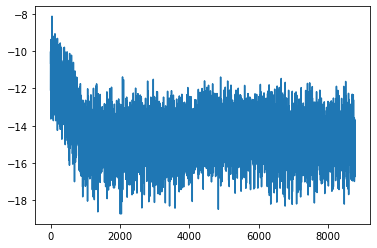

In [3]:
plt.plot(reward_records)

In [4]:
import misc

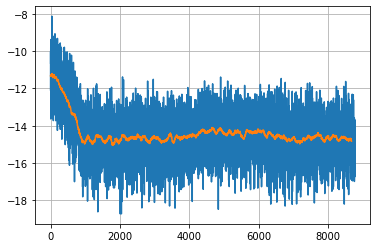

In [5]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,100))
plt.grid()


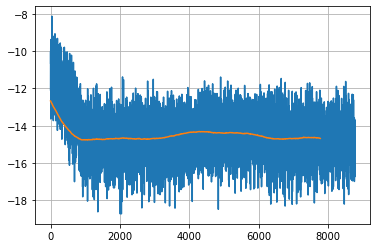

In [6]:
plt.plot(reward_records)
plt.plot(misc.smooth(reward_records,1000))
plt.grid()

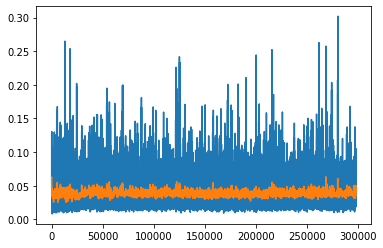

In [7]:
plt.plot(buffer.critic_loss_buffer[100:])
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))

In [9]:
reward.numpy().var()

0.044549115

In [11]:
np.mean(buffer.critic_loss_buffer[10000:])

0.03871274

In [ ]:
plt.plot(buffer.critic_loss_buffer[:10])


In [ ]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1000))
plt.ylim([0,0.05])
plt.grid()

In [ ]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[100:],1000))
plt.grid()

In [ ]:
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],100))
plt.plot(misc.smooth(buffer.critic_loss_buffer[-500:],1000))
plt.grid()

In [ ]:
## Debugging Nan values in action

In [ ]:
plt.plot(buffer.actor_loss_buffer[100:])


In [ ]:
deterministic_action.numpy()

In [ ]:
reward

In [ ]:
env.reset()
for ii in range(55):
    random_action = -2+4*np.random.uniform(size=(config.batch_size,2))
    state, reward, done, info = env.step(random_action)
    print('----------')
    print(reward.numpy()[:5])
    print(critic_model([env.unflatten_observation(state),
                          deterministic_action]).numpy()[:5].T)
    print(critic_model([env.unflatten_observation(state),
                          random_action]).numpy()[:5].T)

In [ ]:
plt.imshow(env.unflatten_observation(state)[0].numpy()[0])

In [ ]:
env.unflatten_observation(state)[1].numpy()[0]

In [ ]:
env.unflatten_observation(state)[2].numpy()[0]

In [ ]:
env.unflatten_observation(state)[3].numpy()[0]

In [ ]:
random_action

In [ ]:
critic_model([env.unflatten_observation(state),
                          random_action])

In [ ]:
deterministic_action

In [ ]:
actor_model(env.unflatten_observation(state))

In [ ]:
actor_model.weights

In [ ]:
critic_model.weights